In [1]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [2]:
from google.colab import files
def getLocalFiles():
    _files = files.upload()
    if len(_files) >0:
       for k,v in _files.items():
         open(k,'wb').write(v)
getLocalFiles()

Saving outils_data.py to outils_data (1).py
Saving outils_model.py to outils_model (1).py


In [3]:
!pip install shap
!pip install catboost
!pip install eli5
!pip install pycaret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached Jinja2-3.1.2-py3-none-any.whl (133 kB)
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires markupsafe~=2.1.1, but you have markupsafe 2.0.1 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.28.0 which is incompatible.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incompatible.
datascience 0.10.6 require

In [4]:
!pip install MarkupSafe==2.0.1
!pip install bayesian-optimization
!pip install scikit-optimize
!pip install optuna
!pip install tune-sklearn
!pip install pycodestyle_magic
!pip install pycodestyle
!pip install flake8

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached MarkupSafe-2.0.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (31 kB)
  Attempting uninstall: MarkupSafe
    Found existing installation: MarkupSafe 2.1.1
    Uninstalling MarkupSafe-2.1.1:
      Successfully uninstalled MarkupSafe-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires markupsafe~=2.1.1, but you have markupsafe 2.0.1 which is incompatible.
eli5 0.13.0 requires jinja2>=3.0.0, but you have jinja2 2.11.3 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/sim

# <span style='color:SteelBlue'>P7 - Implémentez un modèle de scoring</span>

![image.png](attachment:image.png)

 # <span class='bg-primary'>P7_01_05 - MODELISATION</span>

Ce notebook traite de la modélisation

En particulier :

- **choix algorithme** : utilisation de Pycaret pour lancer les différents modèles de classification installés dans nos environnements pour classer les modèles qui semblent être les plus performants pour notre jeu de données et en prenant en compte les différents scores, sélectionner le modèle le plus prometteur.
- **choix du jeu de données** : utilisation de Pycaret pour entraîner les modèles de classification sur nos différents jeux de données issus du feature engineering et du feature selection (imputation avec la médiane/mode avec ou sans la variable magique Kaggle, étendu ou réduit ; imputation avec les constantes 0/XNA ou imputation avec NanImputer/ constante XNA) pour sélectionner le jeu de données à utiliser.
- **choix des métriques** : adaptées aux contraintes métiers de notre problématique.
- **optimisation modèle** : en traitant le déséquilibrage des classes, en sélectionnant les meilleurs hyperparamètres de notre modèle pour défavoriser le nombre de faux négatifs (prêt accordé non remboursé donc énormer perte d'argent pour Home Crédit).

***
Sources
***
- [Métriques_classification_théorie](https://www.deepl.com/fr/translator#en/fr/10.%20F-score%0ASimply%20put%2C%20it%20combines%20precision%20and%20recall%20into%20one%20metric.%20The%20higher%20the%20score%20the%20better%20our%20model%20is.%20You%20can%20calculate%20it%20in%20the%20following%20way%3A%0A)
- [Métriques_sklearn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)
- [Pycaret](https://pycaret.readthedocs.io/en/latest/api/classification.html)
- [Pycaret_classification](https://github.com/pycaret/pycaret/blob/master/tutorials/Binary%20Classification%20Tutorial%20Level%20Beginner%20-%20%20CLF101.ipynb)
- [SMOTE](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)
- [BayesianOptimisation](https://github.com/fmfn/BayesianOptimization)

## <span style='background:Thistle'>Sommaire du notebook</span> 

In [ ]:
# from jyquickhelper import add_notebook_menu
# add_notebook_menu()

## <span style='background:Thistle'>1. Introduction</span>

*****
**Mission**
*****
**Développer un modèle de scoring de la probabilité de défaut de paiement du client** pour étayer la décision d'accorder ou non un prêt à un client potentiel en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières...).

*****
**Objectifs**
*****
- analyser le jeu de données,
- Construire **un modèle de scoring** qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique,
- réaliser un **dashboard interactif** permettant aux chargés de clientèles d'expliquer de manière transparente la décision d'octroi ou non de crédit

*****
**Sources**
*****
- [Jeu de données](https://www.kaggle.com/c/home-credit-default-risk/data)

In [5]:
# Chargement des librairies
import datetime
import sys
import time
from datetime import datetime
import warnings
# import jyquickhelper
import numpy as np
import pandas as pd
import os
import outils_model
import outils_data
import pickle
from collections import Counter

# Visualisation
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Data pré-processing
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler, \
    PowerTransformer, RobustScaler
# Oversampling
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
# UnderSampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Modelisation
# Préparation
from sklearn.model_selection import train_test_split, StratifiedKFold


# Modèles
import pycaret
from pycaret.classification import *
import lightgbm as lgb
from lightgbm import LGBMClassifier
# Optimisation bayésienne
from bayes_opt import BayesianOptimization
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, VerboseCallback
from skopt.space import Real, Categorical, Integer
# Optimisation optuna
import optuna
from optuna.distributions import IntUniformDistribution as IntUniDist
from optuna.distributions import UniformDistribution as UniDist
from optuna.distributions import LogUniformDistribution as LogUniDist
from optuna.distributions import CategoricalDistribution as CatDist
# Métriques
from sklearn.metrics import roc_auc_score, average_precision_score, \
    fbeta_score, make_scorer

# Interprétation
import shap

# Warnings
import warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline
# Chargement à chaud des librairies personnelles
%load_ext autoreload
%autoreload 2
# Valide code pep8
%load_ext pycodestyle_magic
# %pycodestyle_on
# %pycodestyle_off

# Versions
print('Version des librairies utilisées :')
print('Python                : ' + sys.version)
print('NumPy                 : ' + np.version.full_version)
print('Pandas                : ' + pd.__version__)
print('Scikit-learn          : ' + sklearn.__version__)
print('Matplotlib            : ' + matplotlib.__version__)
print('Seaborn               : ' + sns.__version__)
print('Pycaret               : ' + pycaret.__version__)
print('Shape                 : ' + shap.__version__)
print('Lightgbm              : ' + lgb.__version__)
print('Optuna                : ' + optuna.__version__)
print('Outils data           : ' + outils_data.__version__)
print('Outils model          : ' + outils_model.__version__)
now = datetime.now().isoformat()
print('Lancé le           : ' + now)

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


Version des librairies utilisées :
Python                : 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
NumPy                 : 1.19.5
Pandas                : 1.3.5
Scikit-learn          : 0.23.2
Matplotlib            : 3.2.2
Seaborn               : 0.11.2
Pycaret               : 2.3.10
Shape                 : 0.41.0
Lightgbm              : 3.3.2
Optuna                : 2.10.1
Outils data           : 0.0.4
Outils model          : 0.0.1
Lancé le           : 2022-06-20T05:23:34.341962


In [6]:
dico_pd_option = {
    'display.max_rows': 500,
    'display.max_column': 200,
    'display.width': 300,
    'display.precision': 4,
    'display.max_colwidth': 1000,
    'mode.chained_assignment': None
}
for cle, val in dico_pd_option.items():
    pd.set_option(cle, val)

## <span style='background:Thistle'>2. Chargement des jeux de données</span>

**Chargement des dataframes issus du pré-processing**

<span style='background:Moccasin'>**Train_set/test_set**</span>

<span style='background:LightGreen'>**Avec la variable magique TARGET_NEIGHBORS_500_MEAN**</span>

- **train_set** : jeu de données étiquetté (variable cible = TARGET) du train set, issu de la phase de pré-processing (nettoyage, gestion des valeurs manquantes, gestion des valeurs aberrantes, encodage, merge de tous les fichiers, feature engineering et feature sélection).

In [7]:
fic_sav_train_set = \
    '/content/drive/My Drive/sauvegarde/features-selection/train_set.pickle'
# Chargement de train_set
with open(fic_sav_train_set, 'rb') as df_appli_train_set:
    train_set = pickle.load(df_appli_train_set)
train_set.shape

(307507, 100)

- **test_set** : jeu de données non étiquetté (sans la variable cible TARGET) du test set, issu de la phase de pré-processing (nettoyage, gestion des valeurs manquantes, gestion des valeurs aberrantes, encodage, merge de tous les fichiers, feature engineering et feature sélection).

In [8]:
fic_sav_test_set = \
    '/content/drive/My Drive/sauvegarde/features-selection/test_set.pickle'
# Chargement de test_set
with open(fic_sav_test_set, 'rb') as df_appli_test_set:
    test_set = pickle.load(df_appli_test_set)
test_set.shape

(48744, 99)

<span style='background:LightGreen'>**Sans la variable magique TARGET_NEIGHBORS_500_MEAN**</span>

- **train_set_sans_var_magique** : jeu de données étiquetté (variable cible = TARGET) du train set, issu de la phase de pré-processing (nettoyage, gestion des valeurs manquantes, gestion des valeurs aberrantes, encodage, merge de tous les fichiers, feature engineering et feature sélection).

In [9]:
fic_sav_train_set_sans = \
    '/content/drive/My Drive/sauvegarde/features-selection/train_set_sans_var_magique.pickle'
# Chargement de train_set
with open(fic_sav_train_set_sans, 'rb') as df_appli_train_set_sans:
    train_set_sans_var_magique = pickle.load(df_appli_train_set_sans)
train_set_sans_var_magique.shape

(307507, 100)

- **test_set_sans_var_magique** : jeu de données non étiquetté (sans la variable cible TARGET) du test set, issu de la phase de pré-processing (nettoyage, gestion des valeurs manquantes, gestion des valeurs aberrantes, encodage, merge de tous les fichiers, feature engineering et feature sélection).

In [10]:
fic_sav_test_set_sans = \
    '/content/drive/My Drive/sauvegarde/features-selection/test_set_sans_var_magique.pickle'
# Chargement de test_set
with open(fic_sav_test_set_sans, 'rb') as df_appli_test_set_sans:
    test_set_sans_var_magique = pickle.load(df_appli_test_set_sans)
test_set_sans_var_magique.shape

(48744, 99)

***Note*** :
***
- l'imputation est effectuée :
    - valeurs quantitatives : médiane,
    - valeurs qualitatives : mode.

<span style='background:Moccasin'>**Train_imp1_set/test_imp1_set**</span>

- **train_imp1_set** : jeu de données étiquetté (variable cible = TARGET) du train set, issu de la phase de pré-processing (nettoyage, gestion des valeurs manquantes, gestion des valeurs aberrantes, encodage, merge de tous les fichiers, feature engineering et feature sélection).

In [11]:
fic_sav_train_imp1_set = \
    '/content/drive/My Drive/sauvegarde/features-selection/train_imp1_set.pickle'
# Chargement de train_imp1_set
with open(fic_sav_train_imp1_set, 'rb') as df_appli_train_imp1_set:
    train_imp1_set = pickle.load(df_appli_train_imp1_set)
train_imp1_set.shape

(307507, 105)

- **test_imp1_set** : jeu de données non étiquetté (sans la variable cible TARGET) du test set, issu de la phase de pré-processing (nettoyage, gestion des valeurs manquantes, gestion des valeurs aberrantes, encodage, merge de tous les fichiers, feature engineering et feature sélection).

In [12]:
fic_sav_test_imp1_set = \
    '/content/drive/My Drive/sauvegarde/features-selection/test_imp1_set.pickle'
# Chargement de test_imp1_set
with open(fic_sav_test_imp1_set, 'rb') as df_appli_test_imp1_set:
    test_imp1_set = pickle.load(df_appli_test_imp1_set)
test_imp1_set.shape

(48744, 104)

***Note*** :
***
- l'imputation est effectuée :
    - valeurs quantitatives : constante 0,
    - valeurs qualitatives : constante XNA.

<span style='background:Moccasin'>**Train_imp2_set/test_imp2_set**</span>

- **train_imp2_set** : jeu de données étiquetté (variable cible = TARGET) du train set, issu de la phase de pré-processing (nettoyage, gestion des valeurs manquantes, gestion des valeurs aberrantes, encodage, merge de tous les fichiers, feature engineering et feature sélection).

In [13]:
fic_sav_train_imp2_set = \
    '/content/drive/My Drive/sauvegarde/features-selection/train_imp2_set.pickle'
# Chargement de train_imp2_set
with open(fic_sav_train_imp2_set, 'rb') as df_appli_train_imp2_set:
    train_imp2_set = pickle.load(df_appli_train_imp2_set)
train_imp2_set.shape

(307507, 102)

- **test_imp2_set** : jeu de données non étiquetté (sans la variable cible TARGET) du test set, issu de la phase de pré-processing (nettoyage, gestion des valeurs manquantes, gestion des valeurs aberrantes, encodage, merge de tous les fichiers, feature engineering et feature sélection).

In [14]:
fic_sav_test_imp2_set = \
    '/content/drive/My Drive/sauvegarde/features-selection/test_imp2_set.pickle'
# Chargement de test_imp2_set
with open(fic_sav_test_imp2_set, 'rb') as df_appli_test_imp2_set:
    test_imp2_set = pickle.load(df_appli_test_imp2_set)
test_imp2_set.shape

(48744, 101)

***Note*** :
***
- l'imputation est effectuée :
    - valeurs quantitatives : NaNImputer de la librairie Verstack,
    - valeurs qualitatives : constante XNA.

## <span style='background:Thistle'>3. Première idée sur les modèles avec pycaret</span>

L'idée d'utiliser pycaret est :
- d'avoir une **première impression sur les modèles** avec les hyperparamètres de base pour choisir le modèle à optimiser,
- et de voir l'**impact sur les scores** en fonction des différentes imputation effectuées lors du pré-processing pour choisir le jeu de données à conserver qui donne les meilleurs résultats.

***Note*** :
***
 Paramètre d'initialisation pour les jeux de données déséquilibrés comme c'est notre cas :
- **fix_imbalance** : bool, défaut = False. Lorsque l'ensemble de données d'apprentissage présente une distribution inégale de la classe cible, il peut être équilibré à l'aide de ce paramètre. Lorsqu'il est défini sur True, SMOTE (Synthetic Minority Over-sampling Technique) est appliqué par défaut pour créer des points de données synthétiques pour la classe minoritaire.
- **data_split_stratify** : bool ou liste, par défaut = False. Contrôle la stratification pendant 'train_test_split'. Si la valeur est True, la stratification se fera sur la colonne cible. Pour stratifier sur d'autres colonnes, passez une liste de noms de colonnes. Ignoré lorsque data_split_shuffle est False.

[Source](https://pycaret.readthedocs.io/en/latest/api/classification.html)

### <span style='background:PowderBlue'>3.1. Pycaret : train_set</span>

<span style='background:LightGreen'>**Sans la variable magique TARGET_NEIGHBORS_500_MEAN**</span>

In [ ]:
# Classification PyCaret - Initialisation
exp_name_sans = setup(data=train_set_sans_var_magique,
                      target='TARGET',
                      fix_imbalance=True,
                      data_split_stratify=True,
                      session_id=21,
                      log_experiment=True,
                      experiment_name='train_set_sans',
                      silent=True)

Description            Value
0                               session_id               21
1                                   Target           TARGET
2                              Target Type           Binary
3                            Label Encoded             None
4                            Original Data    (307507, 100)
5                           Missing Values            False
6                         Numeric Features               99
7                     Categorical Features                0
8                         Ordinal Features            False
9                High Cardinality Features            False
10                 High Cardinality Method             None
11                   Transformed Train Set     (215254, 99)
12                    Transformed Test Set      (92253, 99)
13                      Shuffle Train-Test             True
14                     Stratify Train-Test             True
15                          Fold Generator  StratifiedKFold
16                             Fold Number               10
17                                CPU Jobs               -1
18                                 Use GPU            False
19                          Log Experiment             True
20                         Experiment Name   train_set_sans
21                                     USI             c9fe
22                         Imputation Type           simple
23          Iterative Imputation Iteration             None
24                         Numeric Imputer             mean
25      Iterative Imputation Numeric Model             None
26                     Categorical Imputer         constant
27  Iterative Imputation Categorical Model             None
28           Unknown Categoricals Handling   least_frequent
29                               Normalize            False
30                        Normalize Method             None
31                          Transformation            False
32                   Transformation Method             None
33                                     PCA            False
34                              PCA Method             None
35                          PCA Components             None
36                     Ignore Low Variance            False
37                     Combine Rare Levels            False
38                    Rare Level Threshold             None
39                         Numeric Binning            False
40                         Remove Outliers            False
41                      Outliers Threshold             None
42                Remove Multicollinearity            False
43             Multicollinearity Threshold             None
44             Remove Perfect Collinearity             True
45                              Clustering            False
46                    Clustering Iteration             None
47                     Polynomial Features            False
48                       Polynomial Degree             None
49                    Trignometry Features            False
50                    Polynomial Threshold             None
51                          Group Features            False
52                       Feature Selection            False
53                Feature Selection Method          classic
54            Features Selection Threshold             None
55                     Feature Interaction            False
56                           Feature Ratio            False
57                   Interaction Threshold             None
58                           Fix Imbalance             True
59                    Fix Imbalance Method            SMOTE

2022/06/18 10:45:45 INFO mlflow.tracking.fluent: Experiment with name 'train_set_sans' does not exist. Creating a new experiment.


In [ ]:
# Lance pycaret sur tous les modèles de base (non optimisés) installés
# sur notre environnement de développement
# Tri par score AUC
best_models = compare_models(sort='AUC')

Model  Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC  TT (Sec)
catboost              CatBoost Classifier    0.9178  0.7744  0.0737  0.4436  0.1264  0.1058  0.1553   113.642
lightgbm  Light Gradient Boosting Machine    0.9155  0.7663  0.0547  0.3505  0.0945  0.0744  0.1118    21.160
rf               Random Forest Classifier    0.9101  0.7511  0.0796  0.2915  0.1251  0.0937  0.1162   166.175
gbc          Gradient Boosting Classifier    0.8961  0.7387  0.1402  0.2473  0.1789  0.1280  0.1339   451.897
et                 Extra Trees Classifier    0.8987  0.7345  0.1272  0.2498  0.1685  0.1206  0.1284    71.014
ada                  Ada Boost Classifier    0.8711  0.7116  0.2059  0.2043  0.2050  0.1349  0.1350    89.383
lda          Linear Discriminant Analysis    0.7535  0.7080  0.5270  0.1696  0.2566  0.1532  0.1888    13.283
lr                    Logistic Regression    0.7922  0.5695  0.2218  0.1099  0.1469  0.0437  0.0473    14.487
dt               Decision Tree Classifier    0.8316  0.5588  0.2336  0.1503  0.1829  0.0939  0.0968    30.562
nb                            Naive Bayes    0.1092  0.5568  0.9769  0.0815  0.1504  0.0016  0.0154     8.706
qda       Quadratic Discriminant Analysis    0.1438  0.5556  0.9506  0.0826  0.1520  0.0041  0.0249    11.964
knn                K Neighbors Classifier    0.6791  0.5506  0.3649  0.0985  0.1551  0.0321  0.0426   203.115
dummy                    Dummy Classifier    0.9193  0.5000  0.0000  0.0000  0.0000  0.0000  0.0000     8.695
svm                   SVM - Linear Kernel    0.5631  0.0000  0.5274  0.0978  0.1611  0.0321  0.0551    24.559
ridge                    Ridge Classifier    0.7534  0.0000  0.5254  0.1692  0.2559  0.1524  0.1878     9.127

In [ ]:
# Le meilleur modèle ?
print(best_models)

In [ ]:
# Sauvegarde des scores
df_best_models_scores_sans = pull()
df_best_models_scores_sans

Model  Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC  TT (Sec)
catboost              CatBoost Classifier    0.9178  0.7744  0.0737  0.4436  0.1264  0.1058  0.1553   113.642
lightgbm  Light Gradient Boosting Machine    0.9155  0.7663  0.0547  0.3505  0.0945  0.0744  0.1118    21.160
rf               Random Forest Classifier    0.9101  0.7511  0.0796  0.2915  0.1251  0.0937  0.1162   166.175
gbc          Gradient Boosting Classifier    0.8961  0.7387  0.1402  0.2473  0.1789  0.1280  0.1339   451.897
et                 Extra Trees Classifier    0.8987  0.7345  0.1272  0.2498  0.1685  0.1206  0.1284    71.014
ada                  Ada Boost Classifier    0.8711  0.7116  0.2059  0.2043  0.2050  0.1349  0.1350    89.383
lda          Linear Discriminant Analysis    0.7535  0.7080  0.5270  0.1696  0.2566  0.1532  0.1888    13.283
lr                    Logistic Regression    0.7922  0.5695  0.2218  0.1099  0.1469  0.0437  0.0473    14.487
dt               Decision Tree Classifier    0.8316  0.5588  0.2336  0.1503  0.1829  0.0939  0.0968    30.562
nb                            Naive Bayes    0.1092  0.5568  0.9769  0.0815  0.1504  0.0016  0.0154     8.706
qda       Quadratic Discriminant Analysis    0.1438  0.5556  0.9506  0.0826  0.1520  0.0041  0.0249    11.964
knn                K Neighbors Classifier    0.6791  0.5506  0.3649  0.0985  0.1551  0.0321  0.0426   203.115
dummy                    Dummy Classifier    0.9193  0.5000  0.0000  0.0000  0.0000  0.0000  0.0000     8.695
svm                   SVM - Linear Kernel    0.5631  0.0000  0.5274  0.0978  0.1611  0.0321  0.0551    24.559
ridge                    Ridge Classifier    0.7534  0.0000  0.5254  0.1692  0.2559  0.1524  0.1878     9.127

In [ ]:
# Sauvegarde des scores des best models du train_set
fic_sav_train_set_scores_sans = \
    '/content/drive/My Drive/sauvegarde/modelisation/pycaret_train_set_scores_sans.pickle'
with open(fic_sav_train_set_scores_sans, 'wb') as f:
    pickle.dump(df_best_models_scores_sans, f, pickle.HIGHEST_PROTOCOL)

**Test jeu de données réduit avec les 3 modèles les plus performants obtenus précédemment sur le train_set**

Quels sont les scores pour un jeu de données réduits à 80 variables au lieu des 104 variables du train_set ?

In [ ]:
fic_sav_train_set_sans_small = \
    '/content/drive/My Drive/sauvegarde/features-selection/train_set_sans_var_magique_small.pickle'
# Chargement de train_set réduit
with open(fic_sav_train_set_sans_small, 'rb') as df_appli_train_set_sans_small:
    train_set_sans_var_magique_small = \
        pickle.load(df_appli_train_set_sans_small)
train_set_sans_var_magique_small.shape

(307507, 100)

In [ ]:
fic_sav_test_set_sans_small = \
    '/content/drive/My Drive/sauvegarde/features-selection/test_set_sans_var_magique_small.pickle'
# Chargement de test_set réduit
with open(fic_sav_test_set_sans_small, 'rb') as df_appli_test_sans_set_small:
    test_set_sans_var_magique_small = \
        pickle.load(df_appli_test_sans_set_small)
test_set_sans_var_magique_small.shape

(48744, 99)

In [ ]:
# Classification PyCaret - Initialisation
exp_name_sans = setup(data=train_set_sans_var_magique_small,
                      target='TARGET',
                      fix_imbalance=True,
                      data_split_stratify=True,
                      session_id=21,
                      log_experiment=True,
                      experiment_name='train_set_sans_small',
                      silent=True)

Description                 Value
0                               session_id                    21
1                                   Target                TARGET
2                              Target Type                Binary
3                            Label Encoded                  None
4                            Original Data         (307507, 100)
5                           Missing Values                 False
6                         Numeric Features                    99
7                     Categorical Features                     0
8                         Ordinal Features                 False
9                High Cardinality Features                 False
10                 High Cardinality Method                  None
11                   Transformed Train Set          (215254, 99)
12                    Transformed Test Set           (92253, 99)
13                      Shuffle Train-Test                  True
14                     Stratify Train-Test                  True
15                          Fold Generator       StratifiedKFold
16                             Fold Number                    10
17                                CPU Jobs                    -1
18                                 Use GPU                 False
19                          Log Experiment                  True
20                         Experiment Name  train_set_sans_small
21                                     USI                  54de
22                         Imputation Type                simple
23          Iterative Imputation Iteration                  None
24                         Numeric Imputer                  mean
25      Iterative Imputation Numeric Model                  None
26                     Categorical Imputer              constant
27  Iterative Imputation Categorical Model                  None
28           Unknown Categoricals Handling        least_frequent
29                               Normalize                 False
30                        Normalize Method                  None
31                          Transformation                 False
32                   Transformation Method                  None
33                                     PCA                 False
34                              PCA Method                  None
35                          PCA Components                  None
36                     Ignore Low Variance                 False
37                     Combine Rare Levels                 False
38                    Rare Level Threshold                  None
39                         Numeric Binning                 False
40                         Remove Outliers                 False
41                      Outliers Threshold                  None
42                Remove Multicollinearity                 False
43             Multicollinearity Threshold                  None
44             Remove Perfect Collinearity                  True
45                              Clustering                 False
46                    Clustering Iteration                  None
47                     Polynomial Features                 False
48                       Polynomial Degree                  None
49                    Trignometry Features                 False
50                    Polynomial Threshold                  None
51                          Group Features                 False
52                       Feature Selection                 False
53                Feature Selection Method               classic
54            Features Selection Threshold                  None
55                     Feature Interaction                 False
56                           Feature Ratio                 False
57                   Interaction Threshold                  None
58                           Fix Imbalance                  True
59                    Fix Imbalance Method                 SMOTE

2022/06/18 14:17:57 INFO mlflow.tracking.fluent: Experiment with name 'train_set_sans_small' does not exist. Creating a new experiment.


In [ ]:
# Lance pycaret sur les 3 modèles les plus performants sur le train_set
# Tri par score AUC
best_models_sans_small = compare_models(
    include=['catboost', 'lightgbm', 'rf'],
    sort='AUC')

Model  Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC  TT (Sec)
catboost              CatBoost Classifier    0.9178  0.7744  0.0737  0.4436  0.1264  0.1058  0.1553   113.619
lightgbm  Light Gradient Boosting Machine    0.9155  0.7663  0.0547  0.3505  0.0945  0.0744  0.1118    21.832
rf               Random Forest Classifier    0.9101  0.7511  0.0796  0.2915  0.1251  0.0937  0.1162   170.444

In [ ]:
# Le meilleur modèle ?
print(best_models_sans_small)

In [ ]:
# Sauvegarde des scores
df_best_models_scores_sans_small = pull()
df_best_models_scores_sans_small

Model  Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC  TT (Sec)
catboost              CatBoost Classifier    0.9178  0.7744  0.0737  0.4436  0.1264  0.1058  0.1553   113.619
lightgbm  Light Gradient Boosting Machine    0.9155  0.7663  0.0547  0.3505  0.0945  0.0744  0.1118    21.832
rf               Random Forest Classifier    0.9101  0.7511  0.0796  0.2915  0.1251  0.0937  0.1162   170.444

In [ ]:
# Sauvegarde des scores des best models du train_set réduit
fic_sav_train_set_scores_sans_small = \
    '/content/drive/My Drive/sauvegarde/modelisation/pycaret_train_set_scores_sans_small.pickle'
with open(fic_sav_train_set_scores_sans_small, 'wb') as f:
    pickle.dump(df_best_models_scores_sans_small, f, pickle.HIGHEST_PROTOCOL)

<span style='background:LightGreen'>**Avec la variable magique TARGET_NEIGHBORS_500_MEAN**</span>

In [ ]:
# Classification PyCaret - Initialisation
exp_name = setup(data=train_set,
                 target='TARGET',
                 fix_imbalance=True,
                 data_split_stratify=True,
                 session_id=21,
                 log_experiment=True,
                 experiment_name='train_set',
                 silent=True)

Description            Value
0                               session_id               21
1                                   Target           TARGET
2                              Target Type           Binary
3                            Label Encoded             None
4                            Original Data    (307507, 100)
5                           Missing Values            False
6                         Numeric Features               99
7                     Categorical Features                0
8                         Ordinal Features            False
9                High Cardinality Features            False
10                 High Cardinality Method             None
11                   Transformed Train Set     (215254, 99)
12                    Transformed Test Set      (92253, 99)
13                      Shuffle Train-Test             True
14                     Stratify Train-Test             True
15                          Fold Generator  StratifiedKFold
16                             Fold Number               10
17                                CPU Jobs               -1
18                                 Use GPU            False
19                          Log Experiment             True
20                         Experiment Name        train_set
21                                     USI             2e73
22                         Imputation Type           simple
23          Iterative Imputation Iteration             None
24                         Numeric Imputer             mean
25      Iterative Imputation Numeric Model             None
26                     Categorical Imputer         constant
27  Iterative Imputation Categorical Model             None
28           Unknown Categoricals Handling   least_frequent
29                               Normalize            False
30                        Normalize Method             None
31                          Transformation            False
32                   Transformation Method             None
33                                     PCA            False
34                              PCA Method             None
35                          PCA Components             None
36                     Ignore Low Variance            False
37                     Combine Rare Levels            False
38                    Rare Level Threshold             None
39                         Numeric Binning            False
40                         Remove Outliers            False
41                      Outliers Threshold             None
42                Remove Multicollinearity            False
43             Multicollinearity Threshold             None
44             Remove Perfect Collinearity             True
45                              Clustering            False
46                    Clustering Iteration             None
47                     Polynomial Features            False
48                       Polynomial Degree             None
49                    Trignometry Features            False
50                    Polynomial Threshold             None
51                          Group Features            False
52                       Feature Selection            False
53                Feature Selection Method          classic
54            Features Selection Threshold             None
55                     Feature Interaction            False
56                           Feature Ratio            False
57                   Interaction Threshold             None
58                           Fix Imbalance             True
59                    Fix Imbalance Method            SMOTE

2022/06/18 15:13:22 INFO mlflow.tracking.fluent: Experiment with name 'train_set' does not exist. Creating a new experiment.


In [ ]:
# Lance pycaret sur tous les modèles de base (non optimisés) installés
# sur notre environnement de développement
# Tri par score AUC
best_models = compare_models(sort='AUC')

Model  Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC  TT (Sec)
catboost              CatBoost Classifier    0.9178  0.7744  0.0737  0.4436  0.1264  0.1058  0.1553   113.632
lightgbm  Light Gradient Boosting Machine    0.9155  0.7663  0.0547  0.3505  0.0945  0.0744  0.1118    21.218
rf               Random Forest Classifier    0.9101  0.7511  0.0796  0.2915  0.1251  0.0937  0.1162   168.113
gbc          Gradient Boosting Classifier    0.8961  0.7387  0.1402  0.2473  0.1789  0.1280  0.1339   447.575
et                 Extra Trees Classifier    0.8987  0.7345  0.1272  0.2498  0.1685  0.1206  0.1284    71.056
ada                  Ada Boost Classifier    0.8711  0.7116  0.2059  0.2043  0.2050  0.1349  0.1350    88.585
lda          Linear Discriminant Analysis    0.7535  0.7080  0.5270  0.1696  0.2566  0.1532  0.1888    13.833
lr                    Logistic Regression    0.7922  0.5695  0.2218  0.1099  0.1469  0.0437  0.0473    14.864
dt               Decision Tree Classifier    0.8316  0.5588  0.2336  0.1503  0.1829  0.0939  0.0968    30.519
nb                            Naive Bayes    0.1092  0.5568  0.9769  0.0815  0.1504  0.0016  0.0154     8.923
qda       Quadratic Discriminant Analysis    0.1438  0.5556  0.9506  0.0826  0.1520  0.0041  0.0249    11.724
knn                K Neighbors Classifier    0.6791  0.5506  0.3649  0.0985  0.1551  0.0321  0.0426   221.572
dummy                    Dummy Classifier    0.9193  0.5000  0.0000  0.0000  0.0000  0.0000  0.0000     8.476
svm                   SVM - Linear Kernel    0.5631  0.0000  0.5274  0.0978  0.1611  0.0321  0.0551    24.256
ridge                    Ridge Classifier    0.7534  0.0000  0.5254  0.1692  0.2559  0.1524  0.1878     8.902

In [ ]:
# Le meilleur modèle ?
print(best_models)

In [ ]:
# Sauvegarde des scores
df_best_models_scores = pull()
df_best_models_scores

Model  Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC  TT (Sec)
catboost              CatBoost Classifier    0.9178  0.7744  0.0737  0.4436  0.1264  0.1058  0.1553   113.632
lightgbm  Light Gradient Boosting Machine    0.9155  0.7663  0.0547  0.3505  0.0945  0.0744  0.1118    21.218
rf               Random Forest Classifier    0.9101  0.7511  0.0796  0.2915  0.1251  0.0937  0.1162   168.113
gbc          Gradient Boosting Classifier    0.8961  0.7387  0.1402  0.2473  0.1789  0.1280  0.1339   447.575
et                 Extra Trees Classifier    0.8987  0.7345  0.1272  0.2498  0.1685  0.1206  0.1284    71.056
ada                  Ada Boost Classifier    0.8711  0.7116  0.2059  0.2043  0.2050  0.1349  0.1350    88.585
lda          Linear Discriminant Analysis    0.7535  0.7080  0.5270  0.1696  0.2566  0.1532  0.1888    13.833
lr                    Logistic Regression    0.7922  0.5695  0.2218  0.1099  0.1469  0.0437  0.0473    14.864
dt               Decision Tree Classifier    0.8316  0.5588  0.2336  0.1503  0.1829  0.0939  0.0968    30.519
nb                            Naive Bayes    0.1092  0.5568  0.9769  0.0815  0.1504  0.0016  0.0154     8.923
qda       Quadratic Discriminant Analysis    0.1438  0.5556  0.9506  0.0826  0.1520  0.0041  0.0249    11.724
knn                K Neighbors Classifier    0.6791  0.5506  0.3649  0.0985  0.1551  0.0321  0.0426   221.572
dummy                    Dummy Classifier    0.9193  0.5000  0.0000  0.0000  0.0000  0.0000  0.0000     8.476
svm                   SVM - Linear Kernel    0.5631  0.0000  0.5274  0.0978  0.1611  0.0321  0.0551    24.256
ridge                    Ridge Classifier    0.7534  0.0000  0.5254  0.1692  0.2559  0.1524  0.1878     8.902

In [ ]:
# Sauvegarde des scores des best models du train_set
fic_sav_train_set_scores = \
    '/content/drive/My Drive/sauvegarde/modelisation/pycaret_train_set_scores.pickle'
with open(fic_sav_train_set_scores, 'wb') as f:
    pickle.dump(df_best_models_scores, f, pickle.HIGHEST_PROTOCOL)

**Test jeu de données réduit avec les 3 modèles les plus performants obtenus précédemment sur le train_set**

Quels sont les scores pour un jeu de données réduits à 70 variables au lieu des 108 variables du train_set ?

In [ ]:
fic_sav_train_set_small = \
    '/content/drive/My Drive/sauvegarde/features-selection/train_set_small.pickle'
# Chargement de train_set réduit
with open(fic_sav_train_set_small, 'rb') as df_appli_train_set_small:
    train_set_small = \
        pickle.load(df_appli_train_set_small)
train_set_small.shape

(307507, 70)

In [ ]:
fic_sav_test_set_small = \
    '/content/drive/My Drive/sauvegarde/features-selection/test_set_small.pickle'
# Chargement de test_set réduit
with open(fic_sav_test_set_small, 'rb') as df_appli_test_set_small:
    test_set_small = \
        pickle.load(df_appli_test_set_small)
test_set_small.shape

(48744, 69)

In [ ]:
# Classification PyCaret - Initialisation
exp_name_sans = setup(data=train_set_small,
                      target='TARGET',
                      fix_imbalance=True,
                      data_split_stratify=True,
                      session_id=21,
                      log_experiment=True,
                      experiment_name='train_set_small',
                      silent=True)

Description            Value
0                               session_id               21
1                                   Target           TARGET
2                              Target Type           Binary
3                            Label Encoded             None
4                            Original Data     (307507, 70)
5                           Missing Values            False
6                         Numeric Features               69
7                     Categorical Features                0
8                         Ordinal Features            False
9                High Cardinality Features            False
10                 High Cardinality Method             None
11                   Transformed Train Set     (215254, 69)
12                    Transformed Test Set      (92253, 69)
13                      Shuffle Train-Test             True
14                     Stratify Train-Test             True
15                          Fold Generator  StratifiedKFold
16                             Fold Number               10
17                                CPU Jobs               -1
18                                 Use GPU            False
19                          Log Experiment             True
20                         Experiment Name  train_set_small
21                                     USI             a62d
22                         Imputation Type           simple
23          Iterative Imputation Iteration             None
24                         Numeric Imputer             mean
25      Iterative Imputation Numeric Model             None
26                     Categorical Imputer         constant
27  Iterative Imputation Categorical Model             None
28           Unknown Categoricals Handling   least_frequent
29                               Normalize            False
30                        Normalize Method             None
31                          Transformation            False
32                   Transformation Method             None
33                                     PCA            False
34                              PCA Method             None
35                          PCA Components             None
36                     Ignore Low Variance            False
37                     Combine Rare Levels            False
38                    Rare Level Threshold             None
39                         Numeric Binning            False
40                         Remove Outliers            False
41                      Outliers Threshold             None
42                Remove Multicollinearity            False
43             Multicollinearity Threshold             None
44             Remove Perfect Collinearity             True
45                              Clustering            False
46                    Clustering Iteration             None
47                     Polynomial Features            False
48                       Polynomial Degree             None
49                    Trignometry Features            False
50                    Polynomial Threshold             None
51                          Group Features            False
52                       Feature Selection            False
53                Feature Selection Method          classic
54            Features Selection Threshold             None
55                     Feature Interaction            False
56                           Feature Ratio            False
57                   Interaction Threshold             None
58                           Fix Imbalance             True
59                    Fix Imbalance Method            SMOTE

2022/06/18 18:47:19 INFO mlflow.tracking.fluent: Experiment with name 'train_set_small' does not exist. Creating a new experiment.


In [ ]:
# Lance pycaret sur les 3 modèles les plus performants sur le train_set
# Tri par score AUC
best_models_small = compare_models(
    include=['catboost', 'lightgbm', 'rf'],
    sort='AUC')

Model  Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC  TT (Sec)
catboost              CatBoost Classifier    0.9170  0.7719  0.0737  0.4192  0.1253  0.1037  0.1490    97.277
lightgbm  Light Gradient Boosting Machine    0.9147  0.7645  0.0589  0.3372  0.1002  0.0781  0.1126    17.634
rf               Random Forest Classifier    0.9096  0.7488  0.0747  0.2777  0.1177  0.0865  0.1077   143.668

In [ ]:
# Le meilleur modèle ?
print(best_models_small)

In [ ]:
# Sauvegarde des scores
df_best_models_scores_small = pull()
df_best_models_scores_small

Model  Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC  TT (Sec)
catboost              CatBoost Classifier    0.9170  0.7719  0.0737  0.4192  0.1253  0.1037  0.1490    97.277
lightgbm  Light Gradient Boosting Machine    0.9147  0.7645  0.0589  0.3372  0.1002  0.0781  0.1126    17.634
rf               Random Forest Classifier    0.9096  0.7488  0.0747  0.2777  0.1177  0.0865  0.1077   143.668

In [ ]:
# Sauvegarde des scores des best models du train_set réduit
fic_sav_train_set_scores_small = \
    '/content/drive/My Drive/sauvegarde/modelisation/pycaret_train_set_scores_small.pickle'
with open(fic_sav_train_set_scores_small, 'wb') as f:
    pickle.dump(df_best_models_scores_small, f, pickle.HIGHEST_PROTOCOL)

### <span style='background:PowderBlue'>3.2. Pycaret : train_imp1_set</span>

In [ ]:
# Classification PyCaret - Initialisation
exp_name_imp1 = setup(data=train_imp1_set,
                      target='TARGET',
                      fix_imbalance=True,
                      data_split_stratify=True,
                      session_id=21,
                      log_experiment=True,
                      experiment_name='train_imp1_set',
                      silent=True)

Description            Value
0                               session_id               21
1                                   Target           TARGET
2                              Target Type           Binary
3                            Label Encoded             None
4                            Original Data    (307507, 105)
5                           Missing Values            False
6                         Numeric Features              104
7                     Categorical Features                0
8                         Ordinal Features            False
9                High Cardinality Features            False
10                 High Cardinality Method             None
11                   Transformed Train Set    (215254, 104)
12                    Transformed Test Set     (92253, 104)
13                      Shuffle Train-Test             True
14                     Stratify Train-Test             True
15                          Fold Generator  StratifiedKFold
16                             Fold Number               10
17                                CPU Jobs               -1
18                                 Use GPU            False
19                          Log Experiment             True
20                         Experiment Name   train_imp1_set
21                                     USI             35d3
22                         Imputation Type           simple
23          Iterative Imputation Iteration             None
24                         Numeric Imputer             mean
25      Iterative Imputation Numeric Model             None
26                     Categorical Imputer         constant
27  Iterative Imputation Categorical Model             None
28           Unknown Categoricals Handling   least_frequent
29                               Normalize            False
30                        Normalize Method             None
31                          Transformation            False
32                   Transformation Method             None
33                                     PCA            False
34                              PCA Method             None
35                          PCA Components             None
36                     Ignore Low Variance            False
37                     Combine Rare Levels            False
38                    Rare Level Threshold             None
39                         Numeric Binning            False
40                         Remove Outliers            False
41                      Outliers Threshold             None
42                Remove Multicollinearity            False
43             Multicollinearity Threshold             None
44             Remove Perfect Collinearity             True
45                              Clustering            False
46                    Clustering Iteration             None
47                     Polynomial Features            False
48                       Polynomial Degree             None
49                    Trignometry Features            False
50                    Polynomial Threshold             None
51                          Group Features            False
52                       Feature Selection            False
53                Feature Selection Method          classic
54            Features Selection Threshold             None
55                     Feature Interaction            False
56                           Feature Ratio            False
57                   Interaction Threshold             None
58                           Fix Imbalance             True
59                    Fix Imbalance Method            SMOTE

In [ ]:
# Lance pycaret sur tous les modèles de base (non optimisés) installés
# sur notre environnement de développement
# Tri par score AUC
best_models_imp1 = compare_models(
    include=['catboost', 'lightgbm', 'rf'],
    sort='AUC')

Model  Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC  TT (Sec)
catboost              CatBoost Classifier    0.9181  0.7784  0.0741  0.4536  0.1273  0.1071  0.1582    96.418
lightgbm  Light Gradient Boosting Machine    0.9169  0.7708  0.0524  0.3904  0.0923  0.0747  0.1189    16.040
rf               Random Forest Classifier    0.9131  0.7488  0.0693  0.3222  0.1140  0.0880  0.1178   137.290

In [ ]:
# Le meilleur modèle ?
print(best_models_imp1)

In [ ]:
# Sauvegarde des scores
df_best_models_scores_imp1 = pull()
df_best_models_scores_imp1

Model  Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC  TT (Sec)
catboost              CatBoost Classifier    0.9181  0.7784  0.0741  0.4536  0.1273  0.1071  0.1582    96.418
lightgbm  Light Gradient Boosting Machine    0.9169  0.7708  0.0524  0.3904  0.0923  0.0747  0.1189    16.040
rf               Random Forest Classifier    0.9131  0.7488  0.0693  0.3222  0.1140  0.0880  0.1178   137.290

In [ ]:
# Sauvegarde des scores des best models du train_imp1_set
fic_sav_train_imp1_set_scores = \
    '/content/drive/My Drive/sauvegarde/modelisation/pycaret_train_imp1_set_scores.pickle'
with open(fic_sav_train_imp1_set_scores, 'wb') as f:
    pickle.dump(df_best_models_scores_imp1, f, pickle.HIGHEST_PROTOCOL)

### <span style='background:PowderBlue'>3.3. Pycaret : train_imp2_set</span>

In [ ]:
# Classification PyCaret - Initialisation
exp_name_imp2 = setup(data=train_imp2_set,
                      target='TARGET',
                      fix_imbalance=True,
                      data_split_stratify=True,
                      session_id=21,
                      log_experiment=True,
                      experiment_name='train_imp2_set',
                      silent=True)

Description            Value
0                               session_id               21
1                                   Target           TARGET
2                              Target Type           Binary
3                            Label Encoded             None
4                            Original Data    (307507, 102)
5                           Missing Values            False
6                         Numeric Features              101
7                     Categorical Features                0
8                         Ordinal Features            False
9                High Cardinality Features            False
10                 High Cardinality Method             None
11                   Transformed Train Set    (215254, 101)
12                    Transformed Test Set     (92253, 101)
13                      Shuffle Train-Test             True
14                     Stratify Train-Test             True
15                          Fold Generator  StratifiedKFold
16                             Fold Number               10
17                                CPU Jobs               -1
18                                 Use GPU            False
19                          Log Experiment             True
20                         Experiment Name   train_imp2_set
21                                     USI             b2d5
22                         Imputation Type           simple
23          Iterative Imputation Iteration             None
24                         Numeric Imputer             mean
25      Iterative Imputation Numeric Model             None
26                     Categorical Imputer         constant
27  Iterative Imputation Categorical Model             None
28           Unknown Categoricals Handling   least_frequent
29                               Normalize            False
30                        Normalize Method             None
31                          Transformation            False
32                   Transformation Method             None
33                                     PCA            False
34                              PCA Method             None
35                          PCA Components             None
36                     Ignore Low Variance            False
37                     Combine Rare Levels            False
38                    Rare Level Threshold             None
39                         Numeric Binning            False
40                         Remove Outliers            False
41                      Outliers Threshold             None
42                Remove Multicollinearity            False
43             Multicollinearity Threshold             None
44             Remove Perfect Collinearity             True
45                              Clustering            False
46                    Clustering Iteration             None
47                     Polynomial Features            False
48                       Polynomial Degree             None
49                    Trignometry Features            False
50                    Polynomial Threshold             None
51                          Group Features            False
52                       Feature Selection            False
53                Feature Selection Method          classic
54            Features Selection Threshold             None
55                     Feature Interaction            False
56                           Feature Ratio            False
57                   Interaction Threshold             None
58                           Fix Imbalance             True
59                    Fix Imbalance Method            SMOTE

2022/06/18 23:47:26 INFO mlflow.tracking.fluent: Experiment with name 'train_imp2_set' does not exist. Creating a new experiment.


In [ ]:
# Lance pycaret sur tous les modèles de base (non optimisés) installés
# sur notre environnement de développement
# Tri par score AUC
best_models_imp2 = compare_models(
    include=['catboost', 'lightgbm', 'rf'],
    sort='AUC')

Model  Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC  TT (Sec)
catboost              CatBoost Classifier    0.9183  0.7804  0.0760  0.4625  0.1304  0.1102  0.1624    92.591
lightgbm  Light Gradient Boosting Machine    0.9167  0.7709  0.0502  0.3782  0.0887  0.0711  0.1136    14.466
rf               Random Forest Classifier    0.9128  0.7518  0.0598  0.3000  0.0997  0.0749  0.1029   141.509

In [ ]:
# Le meilleur modèle ?
print(best_models_imp2)

In [ ]:
# Sauvegarde des scores
df_best_models_scores_imp2 = pull()
df_best_models_scores_imp2

Model  Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC  TT (Sec)
catboost              CatBoost Classifier    0.9183  0.7804  0.0760  0.4625  0.1304  0.1102  0.1624    92.591
lightgbm  Light Gradient Boosting Machine    0.9167  0.7709  0.0502  0.3782  0.0887  0.0711  0.1136    14.466
rf               Random Forest Classifier    0.9128  0.7518  0.0598  0.3000  0.0997  0.0749  0.1029   141.509

In [ ]:
# Sauvegarde des scores des best models du train_set
fic_sav_train_imp2_set_scores = \
    '/content/drive/My Drive/sauvegarde/modelisation/pycaret_train_imp2_set_scores.pickle'
with open(fic_sav_train_imp2_set_scores, 'wb') as f:
    pickle.dump(df_best_models_scores_imp2, f, pickle.HIGHEST_PROTOCOL)

### <span style='background:PowderBlue'>3.4. Pycaret : bilan</span>

In [ ]:
# Scores du train_set avec variable magique
fic_train_set_scores = \
    '/content/drive/My Drive/sauvegarde/modelisation/pycaret_train_set_scores.pickle'
# Chargement de train_set
with open(fic_train_set_scores, 'rb') as df_pycaret_train_set:
    df_best_models_scores = pickle.load(df_pycaret_train_set)
df_best_models_scores.shape

(15, 9)

In [ ]:
# Scores du train_set sans la variable magique
fic_train_set_scores_sans = \
    '/content/drive/My Drive/sauvegarde/modelisation/pycaret_train_set_scores_sans.pickle'
# Chargement de train_set
with open(fic_train_set_scores_sans, 'rb') as df_pycaret_train_set_sans:
    df_best_models_scores_sans = pickle.load(df_pycaret_train_set_sans)
df_best_models_scores_sans.shape

(15, 9)

In [ ]:
# Scores du train_set sans variable magique, réduit
fic_train_set_scores_sans_small = \
    '/content/drive/My Drive/sauvegarde/modelisation/pycaret_train_set_scores_sans_small.pickle'
# Chargement de train_set
with open(fic_train_set_scores_sans_small, 'rb') as df_pycaret_trainsanssmall:
    df_best_models_scores_sans_small = \
        pickle.load(df_pycaret_trainsanssmall)
df_best_models_scores_sans_small.shape

(3, 9)

In [ ]:
# Scores du train_set avec variable magique, réduit
fic_train_set_scores_small = \
    '/content/drive/My Drive/sauvegarde/modelisation/pycaret_train_set_scores_small.pickle'
# Chargement de train_set
with open(fic_train_set_scores_small, 'rb') as df_pycaret_train_small:
    df_best_models_scores_small = \
        pickle.load(df_pycaret_train_small)
df_best_models_scores_small.shape

(3, 9)

In [ ]:
# Scores du train_imp1_set
fic_train_imp1_set_scores = \
    '/content/drive/My Drive/sauvegarde/modelisation/pycaret_train_imp1_set_scores.pickle'
# Chargement de train_imp1_set
with open(fic_train_imp1_set_scores, 'rb') as df_pycaret_train_imp1_set:
    df_best_models_scores_imp1 = pickle.load(df_pycaret_train_imp1_set)
df_best_models_scores_imp1.shape

(3, 9)

In [ ]:
# Scores du train_imp2_set
fic_train_imp2_set_scores = \
    '/content/drive/My Drive/sauvegarde/modelisation/pycaret_train_imp2_set_scores.pickle'
# Chargement de train_imp2_set
with open(fic_train_imp2_set_scores, 'rb') as df_pycaret_train_imp2_set:
    df_best_models_scores_imp2 = pickle.load(df_pycaret_train_imp2_set)
df_best_models_scores_imp2.shape

(3, 9)

In [ ]:
# Ajout du jeu de données pour identifier les scores
df_best_models_scores['Jeu_donnees'] = 'train_set'
df_best_models_scores_sans['Jeu_donnees'] = 'train_set_sans'
df_best_models_scores_small['Jeu_donnees'] = 'train_set_small'
df_best_models_scores_sans_small['Jeu_donnees'] = 'train_set_sans_small'
df_best_models_scores_imp1['Jeu_donnees'] = 'train_imp1_set'
df_best_models_scores_imp2['Jeu_donnees'] = 'train_imp2_set'

In [ ]:
# Constitution d'un seul dataframes
df_best_models_scores_all = \
    df_best_models_scores.append(df_best_models_scores_sans)
df_best_models_scores_all = \
    df_best_models_scores_all.append(df_best_models_scores_small)
df_best_models_scores_all = \
    df_best_models_scores_all.append(df_best_models_scores_sans_small)
df_best_models_scores_all = \
    df_best_models_scores_all.append(df_best_models_scores_imp1)
df_best_models_scores_all = \
    df_best_models_scores_all.append(df_best_models_scores_imp2)
df_best_models_scores_all.shape

(42, 10)

In [ ]:
# Tri avec métrique AUC
df_tri = df_best_models_scores_all.sort_values(by='AUC', ascending=False)
df_tri

Model  Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC  TT (Sec)           Jeu_donnees
catboost              CatBoost Classifier    0.9183  0.7804  0.0760  0.4625  0.1304  0.1102  0.1624    92.591        train_imp2_set
catboost              CatBoost Classifier    0.9181  0.7784  0.0741  0.4536  0.1273  0.1071  0.1582    96.418        train_imp1_set
catboost              CatBoost Classifier    0.9178  0.7744  0.0737  0.4436  0.1264  0.1058  0.1553   113.632             train_set
catboost              CatBoost Classifier    0.9178  0.7744  0.0737  0.4436  0.1264  0.1058  0.1553   113.642        train_set_sans
catboost              CatBoost Classifier    0.9178  0.7744  0.0737  0.4436  0.1264  0.1058  0.1553   113.619  train_set_sans_small
catboost              CatBoost Classifier    0.9170  0.7719  0.0737  0.4192  0.1253  0.1037  0.1490    97.277       train_set_small
lightgbm  Light Gradient Boosting Machine    0.9167  0.7709  0.0502  0.3782  0.0887  0.0711  0.1136    14.466        train_imp2_set
lightgbm  Light Gradient Boosting Machine    0.9169  0.7708  0.0524  0.3904  0.0923  0.0747  0.1189    16.040        train_imp1_set
lightgbm  Light Gradient Boosting Machine    0.9155  0.7663  0.0547  0.3505  0.0945  0.0744  0.1118    21.832  train_set_sans_small
lightgbm  Light Gradient Boosting Machine    0.9155  0.7663  0.0547  0.3505  0.0945  0.0744  0.1118    21.218             train_set
lightgbm  Light Gradient Boosting Machine    0.9155  0.7663  0.0547  0.3505  0.0945  0.0744  0.1118    21.160        train_set_sans
lightgbm  Light Gradient Boosting Machine    0.9147  0.7645  0.0589  0.3372  0.1002  0.0781  0.1126    17.634       train_set_small
rf               Random Forest Classifier    0.9128  0.7518  0.0598  0.3000  0.0997  0.0749  0.1029   141.509        train_imp2_set
rf               Random Forest Classifier    0.9101  0.7511  0.0796  0.2915  0.1251  0.0937  0.1162   170.444  train_set_sans_small
rf               Random Forest Classifier    0.9101  0.7511  0.0796  0.2915  0.1251  0.0937  0.1162   168.113             train_set
rf               Random Forest Classifier    0.9101  0.7511  0.0796  0.2915  0.1251  0.0937  0.1162   166.175        train_set_sans
rf               Random Forest Classifier    0.9096  0.7488  0.0747  0.2777  0.1177  0.0865  0.1077   143.668       train_set_small
rf               Random Forest Classifier    0.9131  0.7488  0.0693  0.3222  0.1140  0.0880  0.1178   137.290        train_imp1_set
gbc          Gradient Boosting Classifier    0.8961  0.7387  0.1402  0.2473  0.1789  0.1280  0.1339   447.575             train_set
gbc          Gradient Boosting Classifier    0.8961  0.7387  0.1402  0.2473  0.1789  0.1280  0.1339   451.897        train_set_sans
et                 Extra Trees Classifier    0.8987  0.7345  0.1272  0.2498  0.1685  0.1206  0.1284    71.014        train_set_sans
et                 Extra Trees Classifier    0.8987  0.7345  0.1272  0.2498  0.1685  0.1206  0.1284    71.056             train_set
ada                  Ada Boost Classifier    0.8711  0.7116  0.2059  0.2043  0.2050  0.1349  0.1350    89.383        train_set_sans
ada                  Ada Boost Classifier    0.8711  0.7116  0.2059  0.2043  0.2050  0.1349  0.1350    88.585             train_set
lda          Linear Discriminant Analysis    0.7535  0.7080  0.5270  0.1696  0.2566  0.1532  0.1888    13.833             train_set
lda          Linear Discriminant Analysis    0.7535  0.7080  0.5270  0.1696  0.2566  0.1532  0.1888    13.283        train_set_sans
lr                    Logistic Regression    0.7922  0.5695  0.2218  0.1099  0.1469  0.0437  0.0473    14.487        train_set_sans
lr                    Logistic Regression    0.7922  0.5695  0.2218  0.1099  0.1469  0.0437  0.0473    14.864             train_set
dt               Decision Tree Classifier    0.8316  0.5588  0.2336  0.1503  0.1829  0.0939  0.0968    30.562        train_set_sans
dt               Decision Tree Classifier    0.8316  0.5588  0.2336  0.1503 

**Bilan** : 
***
- **Jeux de données** à utiliser (selon l'imputation effectuée) :
    - Les scores sont légèrement supérieurs pour le jeu de données train_imp2_set que pour le jeu de données train_set.
    - Mais il est difficile d'expliquer l'imputation avec NaNImputer par la librairie verstack à un utilisateur non datascientist alors qu'il est facile d'expliquer l'utilisation de la valeur moyenne pour les variables numériques et le mode ou la valeur la plus utilisée pour les variables catégorielles.
    - L'imputation par la librairie verstack est également beaucoup plus longues (presque 25 minutes au lieu de quelques secondes pour la médiane).
    - les jeux de données train_set/test_set seront utilisés pour entraîner et valider le modèle.
- **Modèles** : en se basant sur la métrique AUC, 3 modèles se détachent :
    - Catboost Classifier,
    - Light Gradient Boosting Machine,
    - Random Forest Classifier.
    - Observons les autres métriques pour départager nos 3 modèles.

In [ ]:
mask_model = df_best_models_scores_all['Model'] \
    .isin(['CatBoost Classifier', 'Light Gradient Boosting Machine',
           'Random Forest Classifier'])
mask_jeu = \
    df_best_models_scores_all['Jeu_donnees'].isin(['train_set',
                                                   'train_set_sans',
                                                   'train_set_sans_small',
                                                   'train_set_small'])
df_compare = df_best_models_scores_all[mask_model & mask_jeu]

- Pour notre problématique :
    - les **défaillants** forment la classe **positive**,
    - les **non-défaillants** forment la classe **négative**.
- Pour minimiser les pertes d'argent, nous devons :
    - nous efforcer de ne pas prédire un client non-défaillant s'il est défaillant ==> **minimiser le nombre de faux négatifs** (prédit non-défaillant mais client défaillant). Si un défaillant est prédit non défaillant, le groupe Home Crédit aura perdu toute la somme prêtée à l'emprunteur. Cela constitue les plus grosses pertes pour l'entreprise.
    - nous efforcer de ne pas prédire de défaillant si le client n'est pas défaillant donc **minimiser les faux positifs** (classe 1 défaillant alors que non-défaillant dans la réalité). Si un non-défaillant est prédit défaillant, le groupe Home Crédit aura perdu les intérêts de la somme prêtée à l'emprunteur. 
- La métrique pour déterminer le **taux de vrais positif** est le Rappel/**Recall**, elle mesure parmi toutes les observations positives combien ont été classées comme positives. Pour ne pas avoir de pertes, il faut détecter tous les défaillants (classe positive) donc **maximiser la métrique recall**.
- La métrique **Precision**  mesure le nombre d'observations prédites comme positives (client défaillant) qui le sont en réalité. Si le client est prédit défaillant alors qu'il ne le sera pas le prêt ne sera pas accordé et les intérêts ne seront pas empochés. Il faut donc **maximiser la 'Precision'**.

***Note :***
***
- Si on augmente le recall, la précision diminue, il s'agit de faire un compromis entre ces 2 métriques qui dépendent l'une de l'autre, en prenant en compte le métier/problème de l'entreprise et les coûts associés pour répondre à ces questions.
- Dans notre cas, il faut trouver le plus grand nombre d'observations réellement positives (client prédit défaillant et bien défaillant) et la perte est moins grande si on prédit un client défaillant mais qu'il n'est pas défaillant (faux positifs), donc **on donnera priorité à maximiser le recall au dépend de la précision** (on parle bien de Precision pas d'accuracy).
- Le réglage du paramètre beta pour le Fbeta score permet de donner plus de poids au recall (beta>1) qu'à la précision (0<beta<1). Le score F1 est la moyenne harmonique entre le recall et la précision.

[Source](https://towardsdatascience.com/the-ultimate-guide-to-binary-classification-metrics-c25c3627dd0a)

**Choix du modèle**

In [ ]:
# Tri avec métrique AUC
df_compare.groupby(['Model','Jeu_donnees']).agg({'AUC' : max}) \
    .sort_values(by=['Model', 'AUC'], ascending=[True, False]).unstack()

AUC                                                    
Jeu_donnees                     train_set train_set_sans train_set_sans_small train_set_small
Model                                                                                        
CatBoost Classifier                0.7744         0.7744               0.7744          0.7719
Light Gradient Boosting Machine    0.7663         0.7663               0.7663          0.7645
Random Forest Classifier           0.7511         0.7511               0.7511          0.7488

- Léger avantage au modèle Catboost, Lightgbm et randomforest ont des résultats proches.
- Les meilleurs résultats sont obtenus par le train_set et le train_set_small mais les résultats sont assez proches pour tous les jeux de données.

In [ ]:
# Tri avec métrique Recall
df_compare.groupby(['Model','Jeu_donnees']).agg({'Recall' : max}) \
    .sort_values(by=['Model', 'Recall'], ascending=[True, False]).unstack()

Recall                                                    
Jeu_donnees                     train_set train_set_sans train_set_sans_small train_set_small
Model                                                                                        
CatBoost Classifier                0.0737         0.0737               0.0737          0.0737
Light Gradient Boosting Machine    0.0547         0.0547               0.0547          0.0589
Random Forest Classifier           0.0796         0.0796               0.0796          0.0747

- Le meilleur résultat est obtenu par CatBoost avec un résultat meilleur que pour Lightgbm mais le recall peut-être affiné en optimisant le modèle et le seuil de probabilité.
- Au niveau des jeux de données, avantage pour le train_set_small suivi par  le train_set_sans_small mais les résultats sont assez proches pour tous les jeux de données.

In [ ]:
# Tri avec métrique Precision
df_compare.groupby(['Model','Jeu_donnees']).agg({'Prec.' : max}) \
    .sort_values(by=['Model', 'Prec.'], ascending=[True, False]).unstack()

Prec.                                                    
Jeu_donnees                     train_set train_set_sans train_set_sans_small train_set_small
Model                                                                                        
CatBoost Classifier                0.4436         0.4436               0.4436          0.4192
Light Gradient Boosting Machine    0.3505         0.3505               0.3505          0.3372
Random Forest Classifier           0.2915         0.2915               0.2915          0.2777

- Le meilleur résultat est obtenu par CatBoost, suivi par les 2 autres modèles qui ont des résultats proches.
- Au niveau des jeux de données, avantage pour le train_set suivi par  le train_set_sans mais les résultats sont assez proches pour tous les jeux de données.

In [ ]:
# Tri avec métrique F1-Score
df_compare.groupby(['Model','Jeu_donnees']).agg({'F1' : max}) \
    .sort_values(by=['Model', 'F1'], ascending=[True, False]).unstack()

F1                                                    
Jeu_donnees                     train_set train_set_sans train_set_sans_small train_set_small
Model                                                                                        
CatBoost Classifier                0.1264         0.1264               0.1264          0.1253
Light Gradient Boosting Machine    0.0945         0.0945               0.0945          0.1002
Random Forest Classifier           0.1251         0.1251               0.1251          0.1177

- Le meilleur résultat est obtenu par Catboost, Lightgbm est légèrement à la traîne sauf pour les train_set_small et  train_set_sans_small.
- Au niveau des jeux de données, avantage pour le train_set_small suivi par  le train_set_sans_small mais les résultats sont assez proches pour tous les jeux de données.

In [ ]:
# Tri avec métrique Temps
df_compare.groupby(['Model','Jeu_donnees']).agg({'TT (Sec)' : max}) \
    .sort_values(by=['Model', 'TT (Sec)'], ascending=[True, False]).unstack()

TT (Sec)                                                    
Jeu_donnees                     train_set train_set_sans train_set_sans_small train_set_small
Model                                                                                        
CatBoost Classifier               113.632        113.642              113.619          97.277
Light Gradient Boosting Machine    21.218         21.160               21.832          17.634
Random Forest Classifier          168.113        166.175              170.444         143.668

- Lightgbm est le plus rapide (6 fois plus rapide que Catboost qui est très lent).
- Sans surprise les jeux de données avec moins de variables (small) ont des temps de réponse plus rapides.

**Bilan** :
***
- Les résultats sont meilleurs pour Catboost, mais le modèle Lightgbm est 6 fois plus rapide que Catboost. Puisque le but est un dashboard interactif, si de nouvelles données sont fournies ou si les données des clients évoluent, le temps d'exécution sera un facteur essentiel pour notre problématique.
- Les métriques peuvent être optimisées en jouant sur l'équilibrage du jeu de données, sur l'optimisation du modèle et sur le réglage du seuil de probabilité.
- Après analyse des résultats et des contraintes de notre problématique, **le modèle retenu sera Lightgbm**.

**Choix du jeu de données**

In [ ]:
mask_model = df_best_models_scores_all['Model'] == 'Light Gradient Boosting Machine'
mask_jeu = \
    df_best_models_scores_all['Jeu_donnees'].isin(['train_set',
                                                   'train_set_sans',
                                                   'train_set_sans_small',
                                                   'train_set_small'])
df_compare_jeu = df_best_models_scores_all[mask_model & mask_jeu]
df_compare_jeu

Model  Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC  TT (Sec)           Jeu_donnees
lightgbm  Light Gradient Boosting Machine    0.9155  0.7663  0.0547  0.3505  0.0945  0.0744  0.1118    21.218             train_set
lightgbm  Light Gradient Boosting Machine    0.9155  0.7663  0.0547  0.3505  0.0945  0.0744  0.1118    21.160        train_set_sans
lightgbm  Light Gradient Boosting Machine    0.9147  0.7645  0.0589  0.3372  0.1002  0.0781  0.1126    17.634       train_set_small
lightgbm  Light Gradient Boosting Machine    0.9155  0.7663  0.0547  0.3505  0.0945  0.0744  0.1118    21.832  train_set_sans_small

- La variable magique qui a permis de gagner le concours Kaggle offre un avantage sur l'accuracy mais a de moins bon résultat sur la métrique recall qui est très importante pour notre problématique. Comme elle est difficilement explicable et peut être controversée (comparaison avec d'autres individus) nous utiliserons les datasets sans cette variable sur **le jeu de données non réduit sans la variable magique Kaggle(train_set_sans_var_magique)**.

**Bilan** :
- Modèle : **Light Gradient Boosting Machine**.
- Jeu de données : **train_set_sans_var_magique**.

## <span style='background:Thistle'>4. Préparation du jeu de données</span>

**Nombre aléatoire**

In [15]:
# Nombre aléatoire pour la reproductibilité des résultats
seed = 21
print(f'Nombre aléatoire : {seed}')

Nombre aléatoire : 21


### <span style='background:PowderBlue'>4.1. Split du jeu d'entraînement en entraînement/validation</span>

**Vecteur y**

In [16]:
# Vecteur y cible
y = train_set_sans_var_magique['TARGET']
print(f'y : {y.shape}')

y : (307507,)


**Matrice X**

In [17]:
# Matrice X
# Copie du jeu de données
train_set = train_set_sans_var_magique.copy(deep=True)
# Passage de l'identifiant du client en index pour la modélisation
train_set.set_index('SK_ID_CURR', inplace=True)
# Suppression de la variable cible pour la modélisation
X = train_set.drop(['TARGET'], axis=1)
print(f'X : {X.shape}')

X : (307507, 98)


**Découpage du jeu d'entraînement**

In [18]:
# Découpage du jeu d'entraînement en :
# X_train : pour entraîner le modèle et trouver les meilleurs
#           hyperparamètres
# X_valid : pour évaluer les performances du modèle
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      test_size=0.2,
                                                      shuffle=True,
                                                      stratify=y,
                                                      random_state=seed)
print(f'X_train : {X_train.shape} - y_train : {y_train.shape}')
print(f'X_valid : {X_valid.shape} - y_valid : {y_valid.shape}')

X_train : (246005, 98) - y_train : (246005,)
X_valid : (61502, 98) - y_valid : (61502,)


## <span style='background:Thistle'>5. Choix des métriques</span>

### <span style='background:PowderBlue'>5.1. Métriques de classification binaire</span>

Comme nous en avons déjà discuté dans la partie ***3.4. Pycaret : bilan***, différentes métriques existent pour les modélisations de classification binaire.

**Problématique**
***
- Pour notre problématique :
    - les **défaillants** forment la classe **positive**,
    - les **non-défaillants** forment la classe **négative**.
- Pour minimiser les pertes d'argent, nous devons :
    - nous efforcer de ne pas prédire un client non-défaillant s'il est défaillant ==> **minimiser le nombre de faux négatifs (erreur de type II)** (prédit non-défaillant mais client défaillant). Si un défaillant est prédit non défaillant, le groupe Home Crédit aura perdu toute la somme prêtée à l'emprunteur. Cela constitue les plus grosses pertes pour l'entreprise.
    - nous efforcer de ne pas prédire de défaillant si le client n'est pas défaillant donc **minimiser les faux positifs (erreur de type I)** (classe 1 défaillant alors que non-défaillant dans la réalité). Si un non-défaillant est prédit défaillant, le groupe Home Crédit aura perdu les intérêts de la somme prêtée à l'emprunteur.
    
**Métriques**
***
-  **Recall** : la métrique pour déterminer le **taux de vrais positif** est le Rappel(Sensibilité)/**Recall**, elle mesure parmi toutes les observations positives combien ont été classées comme positives. Pour ne pas avoir de pertes, il faut détecter tous les défaillants (classe positive) donc **maximiser la métrique recall**.
![image.png](attachment:image.png)

- **Precision** : elle mesure le nombre d'observations prédites comme positives (client défaillant) qui le sont en réalité. Si le client est prédit défaillant alors qu'il ne le sera pas le prêt ne sera pas accordé et les intérêts ne seront pas empochés. Il faut donc **maximiser la 'Precision'**.
![image-2.png](attachment:image-2.png)

- **F-mesure ou F1** : compromis entre le rappel et précision.
    -  Si on augmente le recall, la précision diminue, il s'agit de faire un compromis entre ces 2 métriques qui dépendent l'une de l'autre, en prenant en compte le métier/problème de l'entreprise et les coûts associés pour répondre à ces questions.
    - Dans notre cas, il faut trouver le plus grand nombre d'observations réellement positives (client prédit défaillant et bien défaillant) et la perte est moins grande si on prédit un client défaillant mais qu'il n'est pas défaillant (faux positifs), donc **on donnera priorité à maximiser le recall au dépend de la précision** (on parle bien de Precision pas d'accuracy).
    - Le réglage du paramètre beta pour le Fbeta score permet de donner plus de poids au recall (beta>1) qu'à la précision (0<beta<1). Le score F1 est la moyenne harmonique entre le recall et la précision.

- **Score ROC AUC** : le score ROC AUC est équivalent au calcul de la corrélation de rang entre les prédictions et la cible. Du point de vue de l'interprétation, il est plus utile car il nous indique que cette métrique montre à quel point votre modèle est bon pour classer les prédictions. Elle vous indique la probabilité qu'une instance positive choisie au hasard soit classée plus haut qu'une instance négative choisie au hasard.

- **Score PR AUC** : calcule de l'aire sous la courbe précision-rappel pour obtenir un nombre qui vous donne des informations sur la performance du modèle. A utiliser : 
    - lorsque vous voulez communiquer la décision de précision/rappel à d'autres parties prenantes et que vous voulez choisir le seuil qui correspond au problème de l'entreprise.
    - lorsque vos données sont fortement déséquilibrées. Puisque l'AUC de PR se concentre principalement sur la classe positive (PPV et TPR), elle se soucie moins de la classe négative fréquente.
    - quand vous vous souciez plus de la classe positive que de la classe négative. Si vous vous souciez davantage de la classe positive et donc du PPV et du TPR, vous devriez opter pour la courbe Precision-Recall et la PR AUC (précision moyenne).


**Notes :**
***
- La librairie sklearn permet de calculer tous ses scores.
- Une fonction permettra d calculer et de sauvegarder ses différents scores lors de la modélisation : <span style='background:PaleGreen'>**outils_model.calculer_scores**</span>.

[Source](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)

### <span style='background:PowderBlue'>5.2. Métriques métiers</span>

**Score pénalisant les faux négatifs**
- Les métriques ci-dessus ne pénalisent pas les faux négatifs sauf le Fbeta qui en utilisant une valeur supérieure à 1 pénalise plus les faux négatifs.
- Nous allons donc créer une métrique métier tentant d'optimiser notre modèle de classification grâce à la personnalisation de la fonction de perte pour définir à la main le coût des faux positifs/négatifs et des vrais positifs/négatifs.
- Cette métrique métier est définie dans la fonction <span style='background:PaleGreen'>**outils_model.custom_score**</span>.

**Seuil de probabilité**
- La valeur du seuil de probabilité à 0.5 par défaut pourra également être réglée pour tenter d'optimiser les performances du modèles pour notre métrique métier. Le seuil optimal de bascule de la classe 0 à la classe 1 devra être déterminée pour chacun des modèles entraînés avec la métrique métier comme score.
- Cette fonction sera appelée: <span style='background:PaleGreen'>**outils_model.determiner_seuil_probabilte**</span>.

In [ ]:
df_resultats = pd.DataFrame({})

In [ ]:
df_taux = pd.DataFrame({})

In [19]:
# Chargement du dataframe de sauvegardes des scores des modèles
fic_df_resultat_scores = \
    '/content/drive/My Drive/sauvegarde/modelisation/df_resultats.pickle'
with open(fic_df_resultat_scores, 'rb') as df_resultats:
    df_resultats = pickle.load(df_resultats)

In [20]:
# Chargement du dataframe de sauvegardes des différents taux :
# TN : vrais négatifs, TP : vrais positifs
# FP : faux positifs, FN : faux négatifs
fic_df_taux = '/content/drive/My Drive/sauvegarde/modelisation/df_taux.pickle'
with open(fic_df_taux, 'rb') as df_taux:
    df_taux = pickle.load(df_taux)

In [21]:
# Métriques
roc_auc = make_scorer(roc_auc_score, greater_is_better=True,
                      needs_proba=True)
pr_auc = make_scorer(average_precision_score, greater_is_better=True,
                     needs_proba=True)
f1_score = make_scorer(fbeta_score, beta=1, greater_is_better=True)
f5_score = make_scorer(fbeta_score, beta=5, greater_is_better=True)
f10_score = make_scorer(fbeta_score, beta=10, greater_is_better=True)
custom_score = make_scorer(outils_model.custom_score,
                           greater_is_better=True)
custom_score_2 = make_scorer(outils_model.custom_score_2,
                           greater_is_better=True)
custom_score_3 = make_scorer(outils_model.custom_score_3,
                           greater_is_better=True)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

### <span style='background:PowderBlue'>6.1. Modèle LGBM de base</span>

Les résultats constitue la baseline pour comparer les modèles optimisés.

**Sans rééquilibrage**

In [ ]:
# Initialisation du modèle avec les hyperparamètres de base
lgbm_base = LGBMClassifier(random_state=seed, verbose=0,
                           force_col_wise=True)

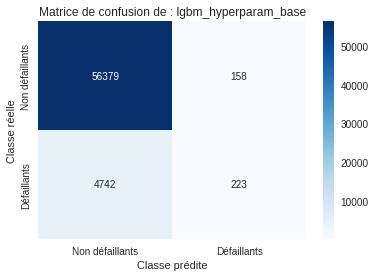

In [ ]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_base, X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_hyperparam_base')

In [ ]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_hyperparam_base',
                                        4742, 158, 223, 56379, df_taux)

**Avec rééquilibrage**

In [ ]:
# Initialisation du modèle avec les hyperparamètres de base
lgbm_base_bal = LGBMClassifier(random_state=seed, verbose=0,
                               force_col_wise=True,
                               class_weight='balanced')

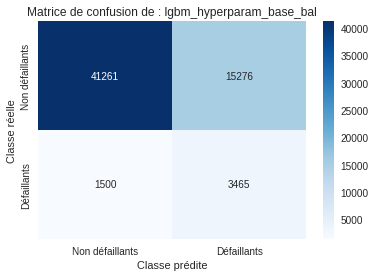

In [ ]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_base_bal, X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_hyperparam_base_bal')

In [ ]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_hyperparam_base_bal',
                                        1500, 15276, 3469, 41261, df_taux)

### <span style='background:PowderBlue'>6.2. Optimisation LGBM - Standardisation</span>

Normalement les modèles à base d'arbres décisionnels n'utilisant pas les distances ne nécessitent pas de données standardisées. La plupart des notebooks Kaggle utilisant la modélisation LightGBM utilise les données standardisées sans l'expliquer. Est-ce que cela peut avoir un fort impact sur notre modèle? Nous observerons l'impact de la standardisation sur notre jeu de données standardisé avec le modèle LightGBM de base.

<span style='background:Moccasin'>**6.2.1. Standardisation - StandardScaler**</span>

In [ ]:
# StandardScaler
scaler_std = StandardScaler()

# Jeu d'entraînement du jeu d'entraînement
X_train_std = scaler_std.fit_transform(X_train.copy(deep=True))
# Jeu de validation du jeu d'entraînement
X_valid_std = scaler_std.transform(X_valid.copy(deep=True))

# Sauvegarde de la standardisation
with open('/content/drive/My Drive/sauvegarde/modelisation/standardisation_std.pickle', 'wb') as f:
    pickle.dump(scaler_std, f, pickle.HIGHEST_PROTOCOL)

**Sans rééquilibrage**

In [ ]:
# Initialisation du modèle avec les hyperparamètres de base
lgbm_base_std = LGBMClassifier(random_state=seed, verbose=0,
                               force_col_wise=True)

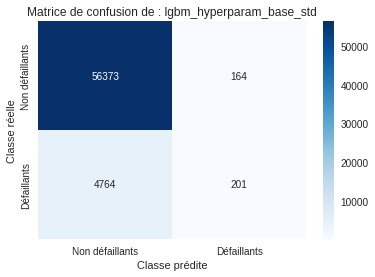

In [ ]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_base_std, X_train_std,
                                        X_valid_std, y_train, y_valid,
                                        df_resultats,
                                        'lgbm_hyperparam_base_std')

In [ ]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_hyperparam_base_std',
                                        4764, 164, 201, 56373, df_taux)

**Avec rééquilibrage**

In [ ]:
# Initialisation du modèle avec les hyperparamètres de base
lgbm_base_std_bal = LGBMClassifier(random_state=seed, verbose=0,
                                   force_col_wise=True,
                                   class_weight='balanced')

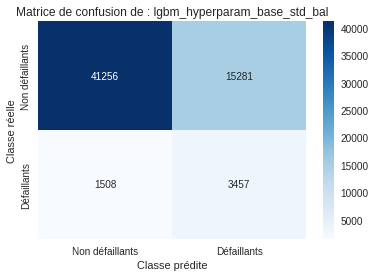

In [ ]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_base_std_bal, X_train_std,
                                        X_valid_std, y_train, y_valid,
                                        df_resultats,
                                        'lgbm_hyperparam_base_std_bal')

In [ ]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_hyperparam_base_std_bal',
                                        1508, 15281, 3457, 41256, df_taux)

<span style='background:Moccasin'>**6.2.2. Standardisation - MinMaxScaler**</span>

In [ ]:
# MinMaxScaler
scaler_min = MinMaxScaler()

# Jeu de la target de consommation d'énergie non transformée en log10
X_train_min = scaler_min.fit_transform(X_train.copy(deep=True))
X_valid_min = scaler_min.transform(X_valid.copy(deep=True))

# Sauvegarde de la standardisation
with open('/content/drive/My Drive/sauvegarde/modelisation/scaler_min.pickle', 'wb') as f:
    pickle.dump(scaler_min, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Initialisation du modèle avec les hyperparamètres de base
lgbm_base_min = LGBMClassifier(random_state=seed, verbose=0,
                               force_col_wise=True)

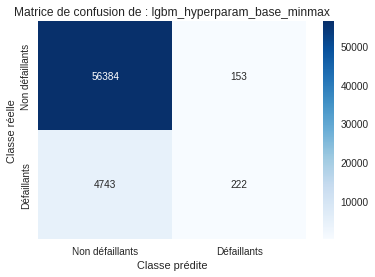

In [ ]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_base_min, X_train_min,
                                        X_valid_min, y_train, y_valid,
                                        df_resultats,
                                        'lgbm_hyperparam_base_minmax')

In [ ]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_hyperparam_base_minmax',
                                        4743, 153, 222, 56384, df_taux)

<span style='background:Moccasin'>**6.2.3. Standardisation - RobustScaler**</span>

In [ ]:
# RobustScaler
scaler_rob = RobustScaler()

X_train_rob = scaler_rob.fit_transform(X_train.copy(deep=True))
X_valid_rob = scaler_rob.transform(X_valid.copy(deep=True))

# Sauvegarde de la standardisation
with open('/content/drive/My Drive/sauvegarde/modelisation/scaler_rob.pickle', 'wb') as f:
    pickle.dump(scaler_rob, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Initialisation du modèle avec les hyperparamètres de base
lgbm_base_rob = LGBMClassifier(random_state=seed, verbose=0,
                               force_col_wise=True)

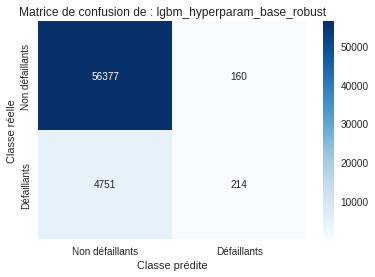

In [ ]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_base_rob, X_train_rob,
                                        X_valid_rob, y_train, y_valid,
                                        df_resultats,
                                        'lgbm_hyperparam_base_robust')

In [ ]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_hyperparam_base_robust',
                                        4751, 160, 214, 56377, df_taux)

**Bilan** :
Le nombre de faux négatifs est légèrement plus faible pour le jeux d'entraînement non standardisé. Ce résultat nous conforte sur la connaissance théorique, à savoir que les algorithmes non basés sur des calculs de distances peuvent manipuler les données non standardisées.  

### <span style='background:PowderBlue'>6.3. Optimisation LGBM : Pycaret</span>

[Source](https://pycaret.readthedocs.io/en/latest/api/classification.html)
[Source](https://github.com/pycaret/pycaret/blob/master/tutorials/Binary%20Classification%20Tutorial%20Level%20Beginner%20-%20%20CLF101.ipynb)

#### <span style='background:Moccasin'>6.3.1. Optimisation LGBM : Pycaret - hyperopt</span>

In [ ]:
# Classification PyCaret - Initialisation
exp_name_sans = setup(data=train_set,
                      target='TARGET',
                      fix_imbalance=True,  # SMOTE
                      data_split_stratify=True,
                      session_id=21,
                      log_experiment=True,
                      experiment_name='train_set_sans',
                      silent=True,
                      n_jobs=1)

Description            Value
0                               session_id               21
1                                   Target           TARGET
2                              Target Type           Binary
3                            Label Encoded             None
4                            Original Data     (307507, 99)
5                           Missing Values            False
6                         Numeric Features               98
7                     Categorical Features                0
8                         Ordinal Features            False
9                High Cardinality Features            False
10                 High Cardinality Method             None
11                   Transformed Train Set     (215254, 98)
12                    Transformed Test Set      (92253, 98)
13                      Shuffle Train-Test             True
14                     Stratify Train-Test             True
15                          Fold Generator  StratifiedKFold
16                             Fold Number               10
17                                CPU Jobs                1
18                                 Use GPU            False
19                          Log Experiment             True
20                         Experiment Name   train_set_sans
21                                     USI             d7bf
22                         Imputation Type           simple
23          Iterative Imputation Iteration             None
24                         Numeric Imputer             mean
25      Iterative Imputation Numeric Model             None
26                     Categorical Imputer         constant
27  Iterative Imputation Categorical Model             None
28           Unknown Categoricals Handling   least_frequent
29                               Normalize            False
30                        Normalize Method             None
31                          Transformation            False
32                   Transformation Method             None
33                                     PCA            False
34                              PCA Method             None
35                          PCA Components             None
36                     Ignore Low Variance            False
37                     Combine Rare Levels            False
38                    Rare Level Threshold             None
39                         Numeric Binning            False
40                         Remove Outliers            False
41                      Outliers Threshold             None
42                Remove Multicollinearity            False
43             Multicollinearity Threshold             None
44             Remove Perfect Collinearity             True
45                              Clustering            False
46                    Clustering Iteration             None
47                     Polynomial Features            False
48                       Polynomial Degree             None
49                    Trignometry Features            False
50                    Polynomial Threshold             None
51                          Group Features            False
52                       Feature Selection            False
53                Feature Selection Method          classic
54            Features Selection Threshold             None
55                     Feature Interaction            False
56                           Feature Ratio            False
57                   Interaction Threshold             None
58                           Fix Imbalance             True
59                    Fix Imbalance Method            SMOTE

2022/06/19 01:46:55 INFO mlflow.tracking.fluent: Experiment with name 'train_set_sans' does not exist. Creating a new experiment.


In [ ]:
# Instanciation du modèle
# Cette fonction entraîne et évalue la performance d'un estimateur donné
# en utilisant la validation croisée.
# La sortie de cette fonction est une grille de score avec les scores CV
# par pli.
lgbm_pycaret = create_model('lightgbm')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.9151  0.7718  0.0552  0.3404  0.0950  0.0742  0.1098
1       0.9151  0.7680  0.0570  0.3449  0.0978  0.0766  0.1127
2       0.9158  0.7698  0.0656  0.3762  0.1117  0.0899  0.1296
3       0.9158  0.7625  0.0616  0.3702  0.1056  0.0845  0.1240
4       0.9156  0.7598  0.0553  0.3529  0.0956  0.0754  0.1131
5       0.9146  0.7612  0.0507  0.3177  0.0874  0.0667  0.0993
6       0.9154  0.7624  0.0564  0.3488  0.0971  0.0764  0.1132
7       0.9154  0.7679  0.0455  0.3292  0.0799  0.0615  0.0968
8       0.9145  0.7617  0.0524  0.3193  0.0900  0.0688  0.1014
9       0.9158  0.7744  0.0604  0.3697  0.1039  0.0831  0.1226
Mean    0.9153  0.7660  0.0560  0.3469  0.0964  0.0757  0.1123
Std     0.0005  0.0048  0.0055  0.0199  0.0088  0.0082  0.0104

In [ ]:
!pip install tune-sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 40 kB 4.4 MB/s 
     |████████████████████████████████| 54.5 MB 1.2 MB/s 
     |████████████████████████████████| 144 kB 47.0 MB/s 
     |████████████████████████████████| 4.1 MB 29.9 MB/s 
     |████████████████████████████████| 8.8 MB 67.5 MB/s 
     |████████████████████████████████| 125 kB 77.9 MB/s 
     |████████████████████████████████| 461 kB 22.0 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.46.3
    Uninstalling grpcio-1.46.3:
      Successfully uninstalled grpcio-1.46.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220527125636 requires numpy>=1.20, but you have numpy 1.19.5 which is incompatible.


In [ ]:
lgbm_tuned_hyperopt = tune_model(lgbm_pycaret,
                                 optimize='AUC',
                                 choose_better=True,
                                 search_library='tune-sklearn',
                                 search_algorithm='hyperopt',
                                 n_iter=20)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.9179  0.7860  0.0639  0.4422  0.1116  0.0931  0.1441
1       0.9172  0.7854  0.0650  0.4170  0.1125  0.0927  0.1394
2       0.9170  0.7828  0.0708  0.4184  0.1211  0.1000  0.1458
3       0.9190  0.7755  0.0708  0.4881  0.1236  0.1053  0.1627
4       0.9184  0.7730  0.0628  0.4599  0.1104  0.0929  0.1469
5       0.9158  0.7767  0.0541  0.3574  0.0940  0.0744  0.1130
6       0.9178  0.7769  0.0651  0.4380  0.1133  0.0944  0.1445
7       0.9168  0.7793  0.0449  0.3732  0.0801  0.0639  0.1063
8       0.9173  0.7754  0.0587  0.4130  0.1028  0.0844  0.1314
9       0.9178  0.7879  0.0656  0.4385  0.1141  0.0951  0.1452
Mean    0.9175  0.7799  0.0622  0.4246  0.1084  0.0896  0.1379
Std     0.0008  0.0050  0.0075  0.0365  0.0123  0.0117  0.0160

In [ ]:
print(lgbm_tuned_hyperopt)

LGBMClassifier(bagging_fraction=0.8955202084365773, bagging_freq=3,
               boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.6343758133045186, importance_type='split',
               learning_rate=0.059644510589006425, max_depth=-1,
               min_child_samples=57, min_child_weight=0.001,
               min_split_gain=0.8461300971585886, n_estimators=238, n_jobs=1,
               num_leaves=92, objective=None, random_state=21,
               reg_alpha=9.476669457133356e-10,
               reg_lambda=0.0025378487047783864, silent='warn', subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)


In [ ]:
plot_model(estimator=lgbm_tuned_hyperopt, plot='auc', save=True)

'AUC.png'

In [ ]:
plot_model(estimator=lgbm_tuned_hyperopt,
           plot='confusion_matrix', save=True)

'Confusion Matrix.png'

In [ ]:
plot_model(estimator=lgbm_tuned_hyperopt, plot='error', save=True)

'Prediction Error.png'

In [ ]:
plot_model(estimator=lgbm_tuned_hyperopt, plot='class_report', save=True)

'Class Report.png'

In [ ]:
print(lgbm_pycaret)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=1, num_leaves=31, objective=None,
               random_state=21, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [ ]:
print(lgbm_tuned_hyperopt)

LGBMClassifier(bagging_fraction=0.8955202084365773, bagging_freq=3,
               boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.6343758133045186, importance_type='split',
               learning_rate=0.059644510589006425, max_depth=-1,
               min_child_samples=57, min_child_weight=0.001,
               min_split_gain=0.8461300971585886, n_estimators=238, n_jobs=1,
               num_leaves=92, objective=None, random_state=21,
               reg_alpha=9.476669457133356e-10,
               reg_lambda=0.0025378487047783864, silent='warn', subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)


In [ ]:
# Sauvegarde du model pycaret optimisé hyperopt
fic_pycaret_lgbm_hyperopt = \
    '/content/drive/My Drive/sauvegarde/modelisation/pycaret_lgbm_hyperopt.pickle'
with open(fic_pycaret_lgbm_hyperopt, 'wb') as f:
    pickle.dump(lgbm_tuned_hyperopt, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Sauvegarde du model pycaret de base
fic_pycaret_lgbm = \
    '/content/drive/My Drive/sauvegarde/modelisation/pycaret_lgbm.pickle'
with open(fic_pycaret_lgbm, 'wb') as f:
    pickle.dump(lgbm_pycaret, f, pickle.HIGHEST_PROTOCOL)

**Visualisation**

![image.png](attachment:image.png)
![image-2.png](attachment:image-2.png)
![image-3.png](attachment:image-3.png)
![image-4.png](attachment:image-4.png)

In [ ]:
# Chargement du modèle pycaret LightGBM optimisé avec hyperopt
fic_pycaret_lgbm_hyperopt = \
    '/content/drive/My Drive/sauvegarde/modelisation/pycaret_lgbm_hyperopt.pickle'
with open(fic_pycaret_lgbm_hyperopt, 'rb') as model_pycaret_lgbm_hyperopt:
    pycaret_lgbm_hyperopt = pickle.load(model_pycaret_lgbm_hyperopt)

[LightGBM] [Warning] feature_fraction is set=0.6343758133045186, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6343758133045186
[LightGBM] [Warning] bagging_fraction is set=0.8955202084365773, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8955202084365773
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6343758133045186, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6343758133045186
[LightGBM] [Warning] bagging_fraction is set=0.8955202084365773, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8955202084365773
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6343758133045186, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6343758133045186
[LightGBM] [Warning] bagging

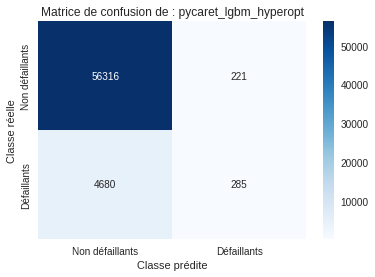

In [ ]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(pycaret_lgbm_hyperopt,
                                        X_train, X_valid, y_train, y_valid,
                                        df_resultats,
                                        'pycaret_lgbm_hyperopt')

In [ ]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('pycaret_lgbm_hyperopt',
                                        4680, 221, 285, 56316, df_taux)

#### <span style='background:Moccasin'>6.3.2. Optimisation LGBM : Pycaret - optuna</span>

In [ ]:
lgbm_tuned_optuna = tune_model(lgbm_pycaret,
                               optimize='AUC',
                               choose_better=True,
                               search_library='tune-sklearn',
                               search_algorithm='optuna',
                               n_iter=20)

IntProgress(value=0, description='Processing: ', max=7)
                                                                    
                                                                    
Initiated  . . . . . . . . . . . . . . . . . .              23:46:49
Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library
Empty DataFrame
Columns: [Accuracy, AUC, Recall, Prec., F1, Kappa, MCC]
Index: []
                                                                               
                                                                               
Initiated  . . . . . . . . . . . . . . . . . .                         23:46:49
Status     . . . . . . . . . . . . . . . . . .             Loading Dependencies
Estimator  . . . . . . . . . . . . . . . . . .  Light Gradient Boosting Machine
                                                                               
                                     

[I 2021-08-01 23:46:58,815] A new study created in memory with name: optuna


[LightGBM] [Warning] feature_fraction is set=0.4304639540172261, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4304639540172261
[LightGBM] [Warning] bagging_fraction is set=0.5813631363787701, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5813631363787701
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.4304639540172261, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4304639540172261
[LightGBM] [Warning] bagging_fraction is set=0.5813631363787701, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5813631363787701
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.4304639540172261, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4304639540172261
[LightGBM] [Warning] bagging

The `start_trial` operation took 630.940 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.506874796935699, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.506874796935699
[LightGBM] [Warning] bagging_fraction is set=0.6975577298956934, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6975577298956934
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.506874796935699, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.506874796935699
[LightGBM] [Warning] bagging_fraction is set=0.6975577298956934, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6975577298956934
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.506874796935699, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.506874796935699

The `start_trial` operation took 652.343 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.9254575547754903, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9254575547754903
[LightGBM] [Warning] bagging_fraction is set=0.9558787026439736, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9558787026439736
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9254575547754903, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9254575547754903
[LightGBM] [Warning] bagging_fraction is set=0.9558787026439736, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9558787026439736
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9254575547754903, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9254575547

The `start_trial` operation took 639.306 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.5963275459706385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5963275459706385
[LightGBM] [Warning] bagging_fraction is set=0.6760842002757856, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6760842002757856
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.5963275459706385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5963275459706385
[LightGBM] [Warning] bagging_fraction is set=0.6760842002757856, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6760842002757856
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.5963275459706385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5963275459

The `start_trial` operation took 749.535 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.7688948266890607, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7688948266890607
[LightGBM] [Warning] bagging_fraction is set=0.7916536439163935, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7916536439163935
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7688948266890607, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7688948266890607
[LightGBM] [Warning] bagging_fraction is set=0.7916536439163935, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7916536439163935
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7688948266890607, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7688948266

The `start_trial` operation took 491.203 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.8603637733707851, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8603637733707851
[LightGBM] [Warning] bagging_fraction is set=0.6539935251553883, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6539935251553883
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8603637733707851, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8603637733707851
[LightGBM] [Warning] bagging_fraction is set=0.6539935251553883, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6539935251553883
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8603637733707851, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8603637733

The `start_trial` operation took 684.815 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.8397489073930524, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8397489073930524
[LightGBM] [Warning] bagging_fraction is set=0.5682600910866811, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5682600910866811
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8397489073930524, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8397489073930524
[LightGBM] [Warning] bagging_fraction is set=0.5682600910866811, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5682600910866811
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8397489073930524, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8397489073

The `start_trial` operation took 329.401 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.8366723156017117, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8366723156017117
[LightGBM] [Warning] bagging_fraction is set=0.6352248344083521, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6352248344083521
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8366723156017117, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8366723156017117
[LightGBM] [Warning] bagging_fraction is set=0.6352248344083521, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6352248344083521
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8366723156017117, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8366723156

The `start_trial` operation took 547.178 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.6190673481051913, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6190673481051913
[LightGBM] [Warning] bagging_fraction is set=0.628621083646526, subsample=1.0 will be ignored. Current value: bagging_fraction=0.628621083646526
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6190673481051913, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6190673481051913
[LightGBM] [Warning] bagging_fraction is set=0.628621083646526, subsample=1.0 will be ignored. Current value: bagging_fraction=0.628621083646526
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6190673481051913, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.61906734810519

The `start_trial` operation took 410.166 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.5060377376384351, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5060377376384351
[LightGBM] [Warning] bagging_fraction is set=0.624112659190208, subsample=1.0 will be ignored. Current value: bagging_fraction=0.624112659190208
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5060377376384351, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5060377376384351
[LightGBM] [Warning] bagging_fraction is set=0.624112659190208, subsample=1.0 will be ignored. Current value: bagging_fraction=0.624112659190208
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5060377376384351, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.50603773763843

The `start_trial` operation took 503.004 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.4102708887717488, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4102708887717488
[LightGBM] [Warning] bagging_fraction is set=0.4224171746596046, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4224171746596046
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.4102708887717488, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4102708887717488
[LightGBM] [Warning] bagging_fraction is set=0.4224171746596046, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4224171746596046
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.4102708887717488, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4102708887

The `start_trial` operation took 492.706 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.4010455018829906, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4010455018829906
[LightGBM] [Warning] bagging_fraction is set=0.8208561568064587, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8208561568064587
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4010455018829906, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4010455018829906
[LightGBM] [Warning] bagging_fraction is set=0.8208561568064587, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8208561568064587
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.4010455018829906, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4010455018

The `start_trial` operation took 751.459 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.481457076877615, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.481457076877615
[LightGBM] [Warning] bagging_fraction is set=0.4671990549101478, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4671990549101478
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.481457076877615, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.481457076877615
[LightGBM] [Warning] bagging_fraction is set=0.4671990549101478, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4671990549101478
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.481457076877615, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.481457076877615

The `start_trial` operation took 689.888 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.5168278464947769, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5168278464947769
[LightGBM] [Warning] bagging_fraction is set=0.521973068660046, subsample=1.0 will be ignored. Current value: bagging_fraction=0.521973068660046
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5168278464947769, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5168278464947769
[LightGBM] [Warning] bagging_fraction is set=0.521973068660046, subsample=1.0 will be ignored. Current value: bagging_fraction=0.521973068660046
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5168278464947769, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.51682784649477

The `start_trial` operation took 625.606 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.6517448547863733, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6517448547863733
[LightGBM] [Warning] bagging_fraction is set=0.7677387718182775, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7677387718182775
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.6517448547863733, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6517448547863733
[LightGBM] [Warning] bagging_fraction is set=0.7677387718182775, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7677387718182775
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.6517448547863733, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6517448547

The `start_trial` operation took 632.015 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.40193924937309866, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40193924937309866
[LightGBM] [Warning] bagging_fraction is set=0.8878956275023774, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8878956275023774
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.40193924937309866, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40193924937309866
[LightGBM] [Warning] bagging_fraction is set=0.8878956275023774, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8878956275023774
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.40193924937309866, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40193

The `start_trial` operation took 503.272 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.5597558177409473, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5597558177409473
[LightGBM] [Warning] bagging_fraction is set=0.5343833537411452, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5343833537411452
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5597558177409473, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5597558177409473
[LightGBM] [Warning] bagging_fraction is set=0.5343833537411452, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5343833537411452
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5597558177409473, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5597558177

The `start_trial` operation took 277.683 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.6848930511089657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6848930511089657
[LightGBM] [Warning] bagging_fraction is set=0.7227471820669408, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7227471820669408
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6848930511089657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6848930511089657
[LightGBM] [Warning] bagging_fraction is set=0.7227471820669408, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7227471820669408
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6848930511089657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6848930511

The `start_trial` operation took 632.424 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.4517496730384321, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4517496730384321
[LightGBM] [Warning] bagging_fraction is set=0.40276819338279735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40276819338279735
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4517496730384321, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4517496730384321
[LightGBM] [Warning] bagging_fraction is set=0.40276819338279735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40276819338279735
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4517496730384321, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.451749

The `start_trial` operation took 521.802 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.5568326432387583, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5568326432387583
[LightGBM] [Warning] bagging_fraction is set=0.7220613749535476, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7220613749535476
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5568326432387583, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5568326432387583
[LightGBM] [Warning] bagging_fraction is set=0.7220613749535476, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7220613749535476
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5568326432387583, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5568326432

The `start_trial` operation took 457.085 s, which may be a performance bottleneck.


Over the last 60 seconds, the Tune event loop has been backlogged processing new results. Consider increasing your period of result reporting to improve performance.


<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
[LightGBM] [Warning] feature_fraction is set=0.506874796935699, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.506874796935699
[LightGBM] [Warning] bagging_fraction is set=0.6975577298956934, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6975577298956934
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
                                                                               
                                                                               
Initiated  . . . . . . . . . . . . . . . . . .                         23:46:49
Status     . . . . . . . . . . . . . . . . . .              Selecting Estimator
Estimator  . . . . . . . . . . . . . . . . . .  Light Gradient Boosting Machine
                                                                               
                                           

                                                                               
                                                                               
Initiated  . . . . . . . . . . . . . . . . . .                         23:46:49
Status     . . . . . . . . . . . . . . . . . .                    Creating Logs
Estimator  . . . . . . . . . . . . . . . . . .  Light Gradient Boosting Machine
                                                                               
                                                                               
Initiated  . . . . . . . . . . . . . . . . . .                         23:46:49
Status     . . . . . . . . . . . . . . . . . .                    Creating Logs
Estimator  . . . . . . . . . . . . . . . . . .  Light Gradient Boosting Machine


In [ ]:
print(lgbm_tuned_optuna)

LGBMClassifier(bagging_fraction=0.6975577298956934, bagging_freq=4,
               boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.506874796935699, importance_type='split',
               learning_rate=0.0498838441998684, max_depth=-1,
               min_child_samples=57, min_child_weight=0.001,
               min_split_gain=0.06957095461260054, n_estimators=243, n_jobs=1,
               num_leaves=174, objective=None, random_state=21,
               reg_alpha=0.3478959107062774, reg_lambda=2.921767889068947e-09,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)


In [ ]:
plot_model(estimator=lgbm_tuned_optuna, plot='auc', save=True)

IntProgress(value=0, description='Processing: ', max=5)
Finished loading model, total used 243 iterations


'AUC.png'

In [ ]:
plot_model(estimator=lgbm_tuned_optuna,
           plot='confusion_matrix', save=True)

IntProgress(value=0, description='Processing: ', max=5)
Finished loading model, total used 243 iterations


'Confusion Matrix.png'

In [ ]:
plot_model(estimator=lgbm_tuned_optuna, plot='error', save=True)

IntProgress(value=0, description='Processing: ', max=5)
Finished loading model, total used 243 iterations


'Prediction Error.png'

In [ ]:
plot_model(estimator=lgbm_tuned_optuna, plot='class_report', save=True)

IntProgress(value=0, description='Processing: ', max=5)
Finished loading model, total used 243 iterations


'Class Report.png'

In [ ]:
print(lgbm_pycaret)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=1, num_leaves=31, objective=None,
               random_state=21, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [ ]:
print(lgbm_tuned_optuna)

LGBMClassifier(bagging_fraction=0.6975577298956934, bagging_freq=4,
               boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.506874796935699, importance_type='split',
               learning_rate=0.0498838441998684, max_depth=-1,
               min_child_samples=57, min_child_weight=0.001,
               min_split_gain=0.06957095461260054, n_estimators=243, n_jobs=1,
               num_leaves=174, objective=None, random_state=21,
               reg_alpha=0.3478959107062774, reg_lambda=2.921767889068947e-09,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)


In [ ]:
# Sauvegarde du model pycaret optimisé optuna
fic_pycaret_lgbm_optuna = \
    '../sauvegarde/modelisation/pycaret_lgbm_optuna.pickle'
with open(fic_pycaret_lgbm_optuna, 'wb') as f:
    pickle.dump(lgbm_tuned_optuna, f, pickle.HIGHEST_PROTOCOL)

**Visualisation**

![image.png](attachment:image.png)
![image-2.png](attachment:image-2.png)
![image-3.png](attachment:image-3.png)
![image-4.png](attachment:image-4.png)

In [ ]:
# Chargement du modèle pycaret LightGBM optimisé avec optuna
fic_pycaret_lgbm_optuna = \
    '../sauvegarde/modelisation/pycaret_lgbm_optuna.pickle'
with open(fic_pycaret_lgbm_optuna, 'rb') as model_pycaret_lgbm_optuna:
    pycaret_lgbm_optuna = pickle.load(model_pycaret_lgbm_optuna)

[LightGBM] [Warning] feature_fraction is set=0.506874796935699, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.506874796935699
[LightGBM] [Warning] bagging_fraction is set=0.6975577298956934, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6975577298956934
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.506874796935699, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.506874796935699
[LightGBM] [Warning] bagging_fraction is set=0.6975577298956934, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6975577298956934
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.506874796935699, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.506874796935699
[LightGBM] [Warning] bagging_fract

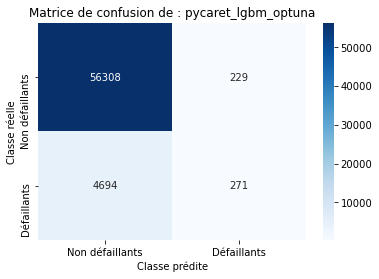

In [ ]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(pycaret_lgbm_optuna,
                                        X_train, X_valid, y_train, y_valid,
                                        df_resultats,
                                        'pycaret_lgbm_optuna')

In [ ]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('pycaret_lgbm_optuna',
                                        4694, 229, 271, 56308, df_taux)

### <span style='background:PowderBlue'>6.4. Optimisation LGBM : meilleurs hyperparamètres BayesianOptimization</span>

Lors du projet 4, nous avons explorer l'optimisation en réglant les paramètres pas à pas, en utlisant RandomizedSearchCV, GridSearchCV et hyperopt. Nous allons découvrir l'optimisation Bayésienne en utilisant la librairie bayes_opt du MIT.

[Source](https://github.com/fmfn/BayesianOptimization)

#### <span style='background:Moccasin'>6.4.1. Optimisation LGBM : BayesianOptimization - Score ROC_AUC</span>

***
<span style='background:LightGreen'>**Modèle lgbm_bayesian_opt_1**</span>
***
- sans forcer les paramètres :
    - learning_rate
    - n_estimators
    - class_weight

In [ ]:
# Définition de l'objective fonction
def lgbm_eval_1(num_leaves, max_depth, min_split_gain,
                min_child_weight, min_child_samples, subsample,
                subsample_freq, colsample_bytree, reg_alpha, reg_lambda):
    '''
    Objective function for Bayesian Optimization of LightGBM's
    Hyperparamters. Takes the hyperparameters as input, and
    returns the Cross-Validation AUC as output.

    Inputs: Hyperparamters to be tuned.
        boost, num_leaves, max_depth, min_split_gain, min_child_weight,
        min_child_samples, subsample, colsample_bytree, reg_alpha,
        reg_lambda

    Returns:
        CV ROC-AUC Score
    '''

    params = {
        'objective' : 'binary',
        'boosting_type' : 'gbdt',
#         'learning_rate' : 0.005,
#         'n_estimators' : 10000,
        'n_jobs' : -1,
#         'class_weight' : 'balanced', # Balanced        
        'num_leaves' : int(round(num_leaves)),
        'max_depth' : int(round(max_depth)),
        'min_split_gain' : min_split_gain,
        'min_child_weight' : min_child_weight,
        'min_child_samples' : int(round(min_child_samples)),
        'subsample': subsample,
        'subsample_freq' : int(round(subsample_freq)),
        'colsample_bytree' : colsample_bytree,
        'reg_alpha' : reg_alpha,
        'reg_lambda' : reg_lambda,
        'verbosity' : -1,
        'seed' : seed
    }
    
    stratified_cv = StratifiedKFold(n_splits=3, shuffle=True,
                                    random_state=seed)
    
    cv_preds = np.zeros(X_train.shape[0])
    for train_indices, cv_indices in stratified_cv.split(X_train,
                                                         y_train):

        x_tr = X_train.iloc[train_indices]
        y_tr = y_train.iloc[train_indices]
        x_cv = X_train.iloc[cv_indices]
        y_cv = y_train.iloc[cv_indices]

        lgbm_clf = lgb.LGBMClassifier(**params)
        lgbm_clf.fit(x_tr, y_tr, eval_set= [(x_cv, y_cv)],
                     eval_metric='auc', verbose=False,
                     early_stopping_rounds=200)

        cv_preds[cv_indices] = \
            lgbm_clf.predict_proba(x_cv,
                                   num_iteration=lgbm_clf.best_iteration_)[:,1]

    return roc_auc_score(y_train, cv_preds)

In [ ]:
# Recherche des meilleurs paramètres 
lgbm_bayesian_opt_1 = \
    BayesianOptimization(lgbm_eval_1,
                         {'num_leaves' : (25, 50),
                          'max_depth' : (6, 11),
                          'min_split_gain' : (0, 0.1),
                          'min_child_weight' : (5, 80),
                          'min_child_samples' : (5, 80),
                          'subsample' : (0.5, 1),
                          'subsample_freq' : (1, 7),
                          'colsample_bytree' : (0.5, 1),
                          'reg_alpha' : (0.001, 0.3),
                          'reg_lambda' : (0.001, 0.3)})

bayesian_opt_1 = lgbm_bayesian_opt_1.maximize(n_iter=20,
                                              init_points=4)

|   iter    |  target   | colsam... | max_depth | min_ch... | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample | subsam... |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.7902   |  0.8147   |  7.821    |  69.17    |  40.56    |  0.02958  |  49.12    |  0.2662   |  0.1483   |  0.9263   |  5.308    |
|  2        |  0.7908   |  0.835    |  10.77    |  9.922    |  38.54    |  0.05186  |  39.43    |  0.1303   |  0.1068   |  0.9643   |  6.681    |
|  3        |  0.7901   |  0.7561   |  7.319    |  24.04    |  63.56    |  0.07992  |  42.43    |  0.2128   |  0.09207  |  0.9349   |  5.8      |
|  4        |  0.7905   |  0.6794   |  9.023    |  60.08    |  78.26    |  0.06453  |  32.11    |  0.1718   |  0.01244  |  0.8648   |  3.319    |
|  5        |  0.7891   |  0.8952   |  10.37    |  11.74    |  38.44    |  0.04025  |  37.93    |  0.1289   |  0.1288   |  0

In [ ]:
#extracting the best parameters
target_values = []
for result in lgbm_bayesian_opt_1.res:
    target_values.append(result['target'])
    if result['target'] == max(target_values):
        best_params = result['params']

print('Best Hyperparamètres :\n')
print(best_params)

Best Hyperparamètres :

{'colsample_bytree': 0.5143267592224399, 'max_depth': 10.286368069602021, 'min_child_samples': 61.66352328025064, 'min_child_weight': 79.33581570209569, 'min_split_gain': 0.09894969155250699, 'num_leaves': 30.943455439553812, 'reg_alpha': 0.2809176222523091, 'reg_lambda': 0.05702269310737356, 'subsample': 0.9316231583249737, 'subsample_freq': 3.3648610853009693}


In [ ]:
param_lgbm_bayesian_opt_1 = {'objective' : 'binary',
                             'boosting_type' : 'gbdt',
                             'n_jobs' : -1,
                             'colsample_bytree': 0.5143267592224399,
                             'max_depth': 10,
                             'min_child_samples': 62,
                             'min_child_weight': 79.33581570209569,
                             'min_split_gain': 0.09894969155250699,
                             'num_leaves': 31,
                             'reg_alpha': 0.2809176222523091,
                             'reg_lambda': 0.05702269310737356,
                             'subsample': 0.9316231583249737,
                             'subsample_freq' : 3,
                             'verbosity' : -1,
                             'seed' : seed}

**Sans le paramètre class_weight='balanced'**

In [ ]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_bayesian_opt_1 = LGBMClassifier(**param_lgbm_bayesian_opt_1,
                                     #class_weight='balanced',
                                     force_col_wise=True)

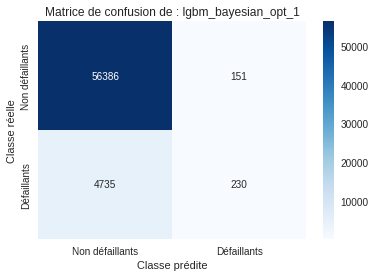

In [ ]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_bayesian_opt_1,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_bayesian_opt_1')

In [ ]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_bayesian_opt_1',
                                        4735, 151, 230, 56386, df_taux)

**Avec le paramètre class_weight='balanced'**

In [ ]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_bayesian_opt_1_bal = LGBMClassifier(**param_lgbm_bayesian_opt_1,
                                         class_weight='balanced',
                                         force_col_wise=True)

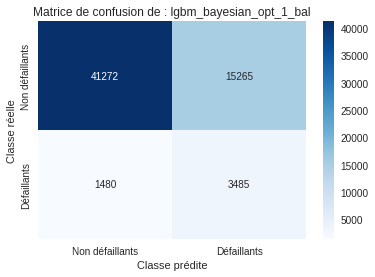

In [ ]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_bayesian_opt_1_bal,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_bayesian_opt_1_bal')

In [ ]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_bayesian_opt_1_bal',
                                        1480, 15265, 3485, 41272, df_taux)

In [ ]:
param_lgbm_bayesian_opt_1_bis = {'objective' : 'binary',
                             'boosting_type' : 'gbdt',
                             'n_jobs' : -1,
                             'colsample_bytree': 0.5143267592224399,
                             'max_depth': 10,
                             'min_child_samples': 62,
                             'min_child_weight': 79.33581570209569,
                             'min_split_gain': 0.09894969155250699,
                             'num_leaves': 31,
                             'reg_alpha': 0.2809176222523091,
                             'reg_lambda': 0.05702269310737356,
                             'subsample': 0.9316231583249737,
                             'subsample_freq' : 3,
                             'verbosity' : -1,
                             'seed' : seed}

**Sans le paramètre class_weight='balanced'**

In [ ]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_bayesian_opt_1_bis = LGBMClassifier(**param_lgbm_bayesian_opt_1_bis,
                                         #class_weight='balanced',
                                         force_col_wise=True)

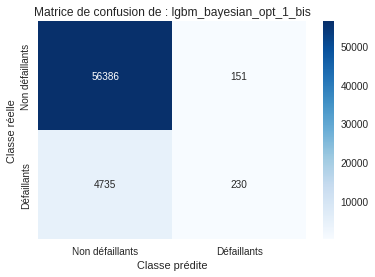

In [ ]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_bayesian_opt_1_bis,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_bayesian_opt_1_bis')

In [ ]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_bayesian_opt_1_bis',
                                        4735, 151, 230, 56386, df_taux)

**Avec le paramètre class_weight='balanced'**

In [ ]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_bayesian_opt_1_bis_bal = LGBMClassifier(**param_lgbm_bayesian_opt_1_bis,
                                             class_weight='balanced',
                                             force_col_wise=True)

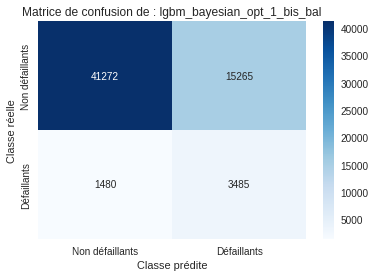

In [ ]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_bayesian_opt_1_bis_bal,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_bayesian_opt_1_bis_bal')

In [ ]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_bayesian_opt_1_bis_bal',
                                        1480, 15265, 3485, 41272, df_taux)

***
<span style='background:LightGreen'>**Modèle lgbm_bayesian_opt_2**</span>
***
- en initialisant les paramètres :
    - learning_rate,
    - n_estimators
- sans forcer le paramètre :    
    - class_weight.

In [24]:
# Définition de l'objective fonction
def lgbm_eval_2(num_leaves, max_depth, min_split_gain,
                min_child_weight, min_child_samples, subsample,
                subsample_freq, colsample_bytree, reg_alpha, reg_lambda):
    '''
    Objective function for Bayesian Optimization of LightGBM's
    Hyperparamters. Takes the hyperparameters as input, and
    returns the Cross-Validation AUC as output.

    Inputs: Hyperparamters to be tuned.
        boost, num_leaves, max_depth, min_split_gain, min_child_weight,
        min_child_samples, subsample, colsample_bytree, reg_alpha,
        reg_lambda

    Returns:
        CV ROC-AUC Score
    '''

    params = {
        'objective' : 'binary',
        'boosting_type' : 'gbdt',
        'learning_rate' : 0.005,
        'n_estimators' : 10000,
        'n_jobs' : -1,
#         'class_weight' : 'balanced', # Balanced
        'num_leaves' : int(round(num_leaves)),
        'max_depth' : int(round(max_depth)),
        'min_split_gain' : min_split_gain,
        'min_child_weight' : min_child_weight,
        'min_child_samples' : int(round(min_child_samples)),
        'subsample': subsample,
        'subsample_freq' : int(round(subsample_freq)),
        'colsample_bytree' : colsample_bytree,
        'reg_alpha' : reg_alpha,
        'reg_lambda' : reg_lambda,
        'verbosity' : -1,
        'seed' : seed
    }
    
    stratified_cv = StratifiedKFold(n_splits=3, shuffle=True,
                                    random_state=seed)
    
    cv_preds = np.zeros(X_train.shape[0])
    for train_indices, cv_indices in stratified_cv.split(X_train,
                                                         y_train):

        x_tr = X_train.iloc[train_indices]
        y_tr = y_train.iloc[train_indices]
        x_cv = X_train.iloc[cv_indices]
        y_cv = y_train.iloc[cv_indices]

        lgbm_clf = lgb.LGBMClassifier(**params)
        lgbm_clf.fit(x_tr, y_tr, eval_set= [(x_cv, y_cv)],
                     eval_metric='auc', verbose=False,
                     early_stopping_rounds=200)

        cv_preds[cv_indices] = \
            lgbm_clf.predict_proba(x_cv,
                                   num_iteration=lgbm_clf.best_iteration_)[:,1]

    return roc_auc_score(y_train, cv_preds)

In [25]:
# Objective fonction 
lgbm_bayesian_opt_2 = \
    BayesianOptimization(lgbm_eval_2,
                         {'num_leaves' : (25, 50),
                          'max_depth' : (6, 11),
                          'min_split_gain' : (0, 0.1),
                          'min_child_weight' : (5, 80),
                          'min_child_samples' : (5, 80),
                          'subsample' : (0.5, 1),
                          'subsample_freq' : (1, 7),
                          'colsample_bytree' : (0.5, 1),
                          'reg_alpha' : (0.001, 0.3),
                          'reg_lambda' : (0.001, 0.3)},
                          random_state = 21)

bayesian_opt_2 = lgbm_bayesian_opt_2.maximize(n_iter=20,
                                              init_points=4)

|   iter    |  target   | colsam... | max_depth | min_ch... | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample | subsam... |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.7952   |  0.5244   |  7.446    |  59.07    |  6.621    |  0.02059  |  26.27    |  0.09138  |  0.1995   |  0.6541   |  4.502    |
|  2        |  0.795    |  0.5348   |  10.34    |  14.99    |  18.36    |  0.04959  |  46.59    |  0.2279   |  0.2912   |  0.8797   |  3.306    |
|  3        |  0.7953   |  0.7044   |  9.567    |  25.3     |  69.06    |  0.09132  |  44.02    |  0.1555   |  0.05118  |  0.6493   |  2.704    |
|  4        |  0.7951   |  0.6636   |  8.301    |  45.83    |  21.31    |  0.07999  |  43.17    |  0.2549   |  0.08099  |  0.8074   |  4.917    |
|  5        |  0.7945   |  0.648    |  9.165    |  57.06    |  5.975    |  0.0146   |  25.77    |  0.1221   |  0.1662   |  0

In [26]:
#extracting the best parameters
target_values = []
for result in lgbm_bayesian_opt_2.res:
    target_values.append(result['target'])
    if result['target'] == max(target_values):
        best_params = result['params']

print('Best Hyperparamètres :\n')
print(best_params)

Best Hyperparamètres :

{'colsample_bytree': 0.6451073364691495, 'max_depth': 9.16895856829377, 'min_child_samples': 38.83361921652628, 'min_child_weight': 76.96953140501162, 'min_split_gain': 0.022924315236907723, 'num_leaves': 36.68195167025361, 'reg_alpha': 0.2199934451313309, 'reg_lambda': 0.04064180087307683, 'subsample': 0.6785553886621116, 'subsample_freq': 1.3463794085015468}


In [27]:
param_lgbm_bayesian_opt_2 = {'objective' : 'binary',
                             'boosting_type' : 'gbdt',
                             'learning_rate' : 0.005,
                             'n_estimators' : 10000,
                             'n_jobs' : -1,
                             'colsample_bytree': 0.6451073364691495,
                             'max_depth': 9,
                             'min_child_samples': 39,
                             'min_child_weight': 76.96953140501162,
                             'min_split_gain': 0.022924315236907723,
                             'num_leaves': 36,
                             'reg_alpha': 0.2199934451313309,
                             'reg_lambda': 0.04064180087307683,
                             'subsample': 0.6785553886621116,
                             'subsample_freq' : 1,
                             'verbosity' : -1,
                             'seed' : seed}

In [28]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_bayesian_opt_2 = LGBMClassifier(**param_lgbm_bayesian_opt_2,
                                     force_col_wise=True)

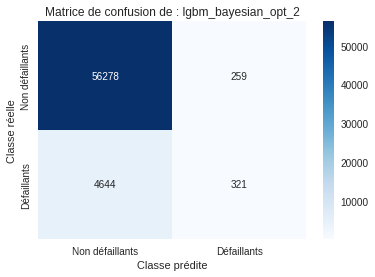

In [29]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_bayesian_opt_2,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_bayesian_opt_2')

In [30]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_bayesian_opt_2',
                                        4644, 259, 321, 56278, df_taux)

***
<span style='background:LightGreen'>**Modèle lgbm_bayesian_opt_3**</span>
***
- en initialisant les paramètres :
    - learning_rate,
    - n_estimators,
    - class_weight.
- et en utilisant les hyperparamètres précedemment trouvés.    

Best Hyperparamètres :

{'colsample_bytree': 0.6572444671016864, 'max_depth': 6.725368912391493, 'min_child_samples': 21.798266653578562, 'min_child_weight': 6.877453971458381, 'min_split_gain': 0.0063894515090233365, 'num_leaves': 35.38010803943543, 'reg_alpha': 0.04446350586910105, 'reg_lambda': 0.051640348086451224, 'subsample': 0.6095326147567048, 'subsample_freq': 1.1312051919957602}

In [22]:
param_lgbm_bayesian_opt_3 = {'objective' : 'binary',
                             'boosting_type' : 'gbdt',
                             'learning_rate' : 0.005,
                             'n_estimators' : 10000,
                             'n_jobs' : -1,
                             'colsample_bytree': 0.6451073364691495,
                             'max_depth': 9,
                             'min_child_samples': 39,
                             'min_child_weight': 76.96953140501162,
                             'min_split_gain': 0.022924315236907723,
                             'num_leaves': 36,
                             'reg_alpha': 0.2199934451313309,
                             'reg_lambda': 0.04064180087307683,
                             'subsample': 0.6785553886621116,
                             'subsample_freq' : 1,
                             'verbosity' : -1,
                             'seed' : seed}

In [23]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_bayesian_opt_3 = LGBMClassifier(**param_lgbm_bayesian_opt_3,
                                     force_col_wise=True,
                                     class_weight='balanced'
                                    )

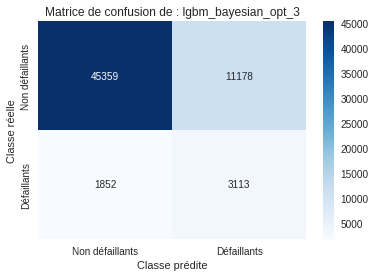

In [33]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_bayesian_opt_3,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_bayesian_opt_3')

In [24]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_bayesian_opt_3',
                                        1852, 11178, 3113, 45359, df_taux)

***
<span style='background:LightGreen'>**Modèle lgbm_bayesian_opt_4**</span>
***
- sans initialiser les paramètres :
    - learning_rate,
    - n_estimators
- en forcant le paramètre suivant avant de lancer la recherche bayésienne :
    - class_weight='balanced'.

In [25]:
# Définition de l'objective fonction
def lgbm_eval_4(num_leaves, max_depth, min_split_gain,
                min_child_weight, min_child_samples, subsample,
                subsample_freq, colsample_bytree, reg_alpha, reg_lambda):
    '''
    Objective function for Bayesian Optimization of LightGBM's
    Hyperparamters. Takes the hyperparameters as input, and
    returns the Cross-Validation AUC as output.

    Inputs: Hyperparamters to be tuned.
        boost, num_leaves, max_depth, min_split_gain, min_child_weight,
        min_child_samples, subsample, colsample_bytree, reg_alpha,
        reg_lambda

    Returns:
        CV ROC-AUC Score
    '''

    params = {
        'objective' : 'binary',
        'boosting_type' : 'gbdt',
#         'learning_rate' : 0.005,
#         'n_estimators' : 10000,
        'n_jobs' : -1,
        'class_weight' : 'balanced', # Balanced
        'num_leaves' : int(round(num_leaves)),
        'max_depth' : int(round(max_depth)),
        'min_split_gain' : min_split_gain,
        'min_child_weight' : min_child_weight,
        'min_child_samples' : int(round(min_child_samples)),
        'subsample': subsample,
        'subsample_freq' : int(round(subsample_freq)),
        'colsample_bytree' : colsample_bytree,
        'reg_alpha' : reg_alpha,
        'reg_lambda' : reg_lambda,
        'verbosity' : -1,
        'seed' : seed
    }
    
    stratified_cv = StratifiedKFold(n_splits=3, shuffle=True,
                                    random_state=seed)
    
    cv_preds = np.zeros(X_train.shape[0])
    for train_indices, cv_indices in stratified_cv.split(X_train,
                                                         y_train):

        x_tr = X_train.iloc[train_indices]
        y_tr = y_train.iloc[train_indices]
        x_cv = X_train.iloc[cv_indices]
        y_cv = y_train.iloc[cv_indices]

        lgbm_clf = lgb.LGBMClassifier(**params)
        lgbm_clf.fit(x_tr, y_tr, eval_set= [(x_cv, y_cv)],
                     eval_metric='auc', verbose=False,
                     early_stopping_rounds=200)

        cv_preds[cv_indices] = \
            lgbm_clf.predict_proba(x_cv,
                                   num_iteration=lgbm_clf.best_iteration_)[:,1]

    return roc_auc_score(y_train, cv_preds)

In [26]:
# Objective fonction 
lgbm_bayesian_opt_4 = \
    BayesianOptimization(lgbm_eval_4,
                         {'num_leaves' : (25, 50),
                          'max_depth' : (6,11),
                          'min_split_gain' : (0, 0.1),
                          'min_child_weight' : (5, 80),
                          'min_child_samples' : (5, 80),
                          'subsample' : (0.5, 1),
                          'subsample_freq' : (1, 7),
                          'colsample_bytree' : (0.5, 1),
                          'reg_alpha' : (0.001, 0.3),
                          'reg_lambda' : (0.001, 0.3)},
                          random_state = seed)

bayesian_opt_4 = lgbm_bayesian_opt_4.maximize(n_iter=20,
                                              init_points=4)

|   iter    |  target   | colsam... | max_depth | min_ch... | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample | subsam... |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.7885   |  0.5244   |  7.446    |  59.07    |  6.621    |  0.02059  |  26.27    |  0.09138  |  0.1995   |  0.6541   |  4.502    |
|  2        |  0.7894   |  0.5348   |  10.34    |  14.99    |  18.36    |  0.04959  |  46.59    |  0.2279   |  0.2912   |  0.8797   |  3.306    |
|  3        |  0.7893   |  0.7044   |  9.567    |  25.3     |  69.06    |  0.09132  |  44.02    |  0.1555   |  0.05118  |  0.6493   |  2.704    |
|  4        |  0.7884   |  0.6636   |  8.301    |  45.83    |  21.31    |  0.07999  |  43.17    |  0.2549   |  0.08099  |  0.8074   |  4.917    |
|  5        |  0.7881   |  0.7589   |  10.61    |  14.14    |  19.53    |  0.02771  |  46.51    |  0.22     |  0.1816   |  0

In [27]:
#extracting the best parameters
target_values = []
for result in lgbm_bayesian_opt_4.res:
    target_values.append(result['target'])
    if result['target'] == max(target_values):
        best_params = result['params']

print('Best Hyperparamètres :\n')
print(best_params)

Best Hyperparamètres :

{'colsample_bytree': 0.7158743611392127, 'max_depth': 6.603637177916277, 'min_child_samples': 75.58299719754251, 'min_child_weight': 61.80481501340966, 'min_split_gain': 0.014191546242537113, 'num_leaves': 30.68017245066918, 'reg_alpha': 0.10495436953710384, 'reg_lambda': 0.1792725196041633, 'subsample': 0.852325679894586, 'subsample_freq': 3.5832918841045283}


In [28]:
param_lgbm_bayesian_opt_4 = {'objective' : 'binary',
                             'boosting_type' : 'gbdt',
                             'n_jobs' : -1,
                             'class_weight' : 'balanced', # Balanced
                             'colsample_bytree': 0.7158743611392127,
                             'max_depth': 6,
                             'min_child_samples': 75,
                             'min_child_weight': 61.80481501340966,
                             'min_split_gain': 0.014191546242537113,
                             'num_leaves': 30,
                             'reg_alpha': 0.10495436953710384,
                             'reg_lambda': 0.1792725196041633,
                             'subsample': 0.852325679894586,
                             'subsample_freq' : 3,
                             'verbosity' : -1,
                             'seed' : seed}

In [29]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_bayesian_opt_4 = LGBMClassifier(**param_lgbm_bayesian_opt_4,
                                     force_col_wise=True)

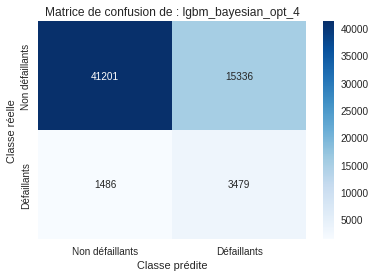

In [30]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_bayesian_opt_4,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_bayesian_opt_4')

In [31]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_bayesian_opt_4',
                                        1486, 15336, 3479, 41201, df_taux)

***
<span style='background:LightGreen'>**Modèle lgbm_bayesian_opt_9**</span>
***
- sans initialiser les paramètres :
    - learning_rate,
    - n_estimators
    - subsample_freq
- en forcant le paramètre suivant avant de lancer la recherche bayésienne :
    - class_weight='balanced'.
- en augmentant le nombre d'itérations de 20 à 100.    

In [32]:
# Définition de l'objective fonction
def lgbm_eval_9(num_leaves, max_depth, min_split_gain,
                min_child_weight, min_child_samples, subsample,
                subsample_freq, colsample_bytree, reg_alpha, reg_lambda):
    '''
    Objective function for Bayesian Optimization of LightGBM's
    Hyperparamters. Takes the hyperparameters as input, and
    returns the Cross-Validation AUC as output.

    Inputs: Hyperparamters to be tuned.
        boost, num_leaves, max_depth, min_split_gain, min_child_weight,
        min_child_samples, subsample, colsample_bytree, reg_alpha,
        reg_lambda

    Returns:
        CV ROC-AUC Score
    '''

    params = {
        'objective' : 'binary',
        'boosting_type' : 'gbdt',
        'n_jobs' : -1,
        'class_weight' : 'balanced', # Balanced
        'num_leaves' : int(round(num_leaves)),
        'max_depth' : int(round(max_depth)),
        'min_split_gain' : min_split_gain,
        'min_child_weight' : min_child_weight,
        'min_child_samples' : int(round(min_child_samples)),
        'subsample': subsample,
        'subsample_freq' : int(round(subsample_freq)),
        'colsample_bytree' : colsample_bytree,
        'reg_alpha' : reg_alpha,
        'reg_lambda' : reg_lambda,
        'verbosity' : -1
    }
    
    stratified_cv = StratifiedKFold(n_splits=5, shuffle=True,
                                    random_state=seed)
    
    cv_preds = np.zeros(X_train.shape[0])
    for train_indices, cv_indices in stratified_cv.split(X_train,
                                                         y_train):

        x_tr = X_train.iloc[train_indices]
        y_tr = y_train.iloc[train_indices]
        x_cv = X_train.iloc[cv_indices]
        y_cv = y_train.iloc[cv_indices]

        lgbm_clf = lgb.LGBMClassifier(**params)
        lgbm_clf.fit(x_tr, y_tr, eval_set= [(x_cv, y_cv)],
                     eval_metric='auc', verbose=False,
                     early_stopping_rounds=200)

        cv_preds[cv_indices] = \
            lgbm_clf.predict_proba(x_cv,
                                   num_iteration=lgbm_clf.best_iteration_)[:,1]

    return roc_auc_score(y_train, cv_preds)

In [33]:
# Objective fonction 
lgbm_bayesian_opt_9 = \
    BayesianOptimization(lgbm_eval_9,
                         {'num_leaves' : (25, 50),
                          'max_depth' : (6, 11),
                          'min_split_gain' : (0, 0.1),
                          'min_child_weight' : (5, 80),
                          'min_child_samples' : (5, 80),
                          'subsample' : (0.5, 1),
                          'subsample_freq' : (1, 7),
                          'colsample_bytree' : (0.5, 1),
                          'reg_alpha' : (0.001, 0.3),
                          'reg_lambda' : (0.001, 0.3)},
                          random_state = 42)

bayesian_opt_9 = lgbm_bayesian_opt_9.maximize(n_iter=100,
                                              init_points=5)

|   iter    |  target   | colsam... | max_depth | min_ch... | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample | subsam... |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.7911   |  0.6873   |  10.75    |  59.9     |  49.9     |  0.0156   |  28.9     |  0.01837  |  0.26     |  0.8006   |  5.248    |
|  2        |  0.79     |  0.5103   |  10.85    |  67.43    |  20.93    |  0.01818  |  29.59    |  0.09197  |  0.1579   |  0.716    |  2.747    |
|  3        |  0.7903   |  0.8059   |  6.697    |  26.91    |  32.48    |  0.04561  |  44.63    |  0.0607   |  0.1548   |  0.7962   |  1.279    |
|  4        |  0.7909   |  0.8038   |  6.853    |  9.879    |  76.17    |  0.09656  |  45.21    |  0.09208  |  0.0302   |  0.8421   |  3.641    |
|  5        |  0.7904   |  0.561    |  8.476    |  7.579    |  73.2     |  0.02588  |  41.56    |  0.0942   |  0.1565   |  0

In [34]:
#extracting the best parameters
target_values = []
for result in lgbm_bayesian_opt_9.res:
    target_values.append(result['target'])
    if result['target'] == max(target_values):
        best_params = result['params']

print('Best Hyperparamètres :\n')
print(best_params)

Best Hyperparamètres :

{'colsample_bytree': 0.7343841013143061, 'max_depth': 10.323259050266852, 'min_child_samples': 79.19154560808641, 'min_child_weight': 38.984212122742214, 'min_split_gain': 0.05330699845866436, 'num_leaves': 35.20131515292721, 'reg_alpha': 0.28573036208556013, 'reg_lambda': 0.11188908750281538, 'subsample': 0.8245128462967717, 'subsample_freq': 5.162636301586243}


In [35]:
param_lgbm_bayesian_opt_9 = {'objective' : 'binary',
                             'boosting_type' : 'gbdt',
                             'n_jobs' : -1,
                             'class_weight' : 'balanced', # Balanced
                             'colsample_bytree': 0.7343841013143061,
                             'max_depth': 10,
                             'min_child_samples': 79,
                             'min_child_weight': 38.984212122742214,
                             'min_split_gain': 0.05330699845866436,
                             'num_leaves': 35,
                             'reg_alpha': 0.28573036208556013,
                             'reg_lambda': 0.11188908750281538,
                             'subsample': 0.8245128462967717,
                             'subsample_freq': 5,
                             'verbosity' : -1}

In [36]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_bayesian_opt_9 = LGBMClassifier(**param_lgbm_bayesian_opt_9,
                                     force_col_wise=True)

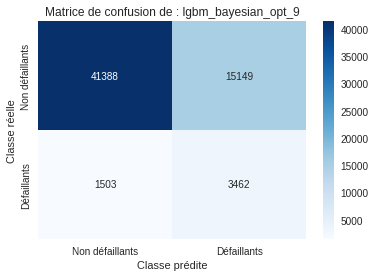

In [37]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_bayesian_opt_9,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_bayesian_opt_9')

In [38]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_bayesian_opt_9',
                                        1503, 15149, 3462, 41388, df_taux)

#### <span style='background:Moccasin'>6.4.2. Optimisation LGBM : BayesianOptimization - Score la métrique métier</span>

***
<span style='background:LightGreen'>**Modèle lgbm_bayesian_opt_5**</span>
***
- sans forcer les paramètres :
    - learning_rate
    - n_estimators
- en utilisant : class_weight='balanced' pour le déséquilibrage des classes
- en utilisant la métrique métier pour récupérer les meilleurs paramètres lors de la recherche bayésienne.
- avec les poids de pénalisation : taux_tn=1, taux_fp=0, taux_fn=-10, taux_tp=0

[Source](https://medium.com/analytics-vidhya/hyperparameters-optimization-for-lightgbm-catboost-and-xgboost-regressors-using-bayesian-6e7c495947a9)

In [39]:
# Définition de l'objective fonction
def lgbm_eval_5(num_leaves, max_depth, min_split_gain,
                min_child_weight, min_child_samples, subsample,
                subsample_freq, colsample_bytree, reg_alpha, reg_lambda):
    '''
    Objective function for Bayesian Optimization of LightGBM's
    Hyperparamters. Takes the hyperparameters as input, and
    returns the Cross-Validation AUC as output.

    Inputs: Hyperparamters to be tuned.
        boost, num_leaves, max_depth, min_split_gain, min_child_weight,
        min_child_samples, subsample, colsample_bytree, reg_alpha,
        reg_lambda

    Returns:
        CV ROC-AUC Score
    '''

    params = {
        'objective' : 'binary',
        'boosting_type' : 'gbdt',
        'n_jobs' : -1,
        'class_weight' : 'balanced', # Balanced        
        'num_leaves' : int(round(num_leaves)),
        'max_depth' : int(round(max_depth)),
        'min_split_gain' : min_split_gain,
        'min_child_weight' : min_child_weight,
        'min_child_samples' : int(round(min_child_samples)),
        'subsample': subsample,
        'subsample_freq' : int(round(subsample_freq)),
        'colsample_bytree' : colsample_bytree,
        'reg_alpha' : reg_alpha,
        'reg_lambda' : reg_lambda,
        'verbosity' : -1,
        'seed' : seed
    }
    
    stratified_cv = StratifiedKFold(n_splits=3, shuffle=True,
                                    random_state=seed)
    
    cv_preds = np.zeros(X_train.shape[0])
    for train_indices, cv_indices in stratified_cv.split(X_train,
                                                         y_train):

        x_tr = X_train.iloc[train_indices]
        y_tr = y_train.iloc[train_indices]
        x_cv = X_train.iloc[cv_indices]
        y_cv = y_train.iloc[cv_indices]

        lgbm_clf = lgb.LGBMClassifier(**params)
        lgbm_clf.fit(x_tr, y_tr, eval_set= [(x_cv, y_cv)],
                     eval_metric='custom_score', verbose=False,
                     early_stopping_rounds=200)

        cv_preds[cv_indices] = \
            lgbm_clf.predict(x_cv,
                             num_iteration=lgbm_clf.best_iteration_)
#         display(cv_preds)
    return outils_model.custom_score(y_train, np.rint(cv_preds))

In [40]:
# Recherche des meilleurs paramètres 
lgbm_bayesian_opt_5 = \
    BayesianOptimization(lgbm_eval_5,
                         {'num_leaves' : (25, 50),
                          'max_depth' : (6, 11),
                          'min_split_gain' : (0, 0.1),
                          'min_child_weight' : (5, 80),
                          'min_child_samples' : (5, 80),
                          'subsample' : (0.5, 1),
                          'subsample_freq' : (1, 7),
                          'colsample_bytree' : (0.5, 1),
                          'reg_alpha' : (0.001, 0.3),
                          'reg_lambda' : (0.001, 0.3)},
                         random_state=seed)

bayesian_opt_5 = lgbm_bayesian_opt_5.maximize(n_iter=20,
                                              init_points=4)

|   iter    |  target   | colsam... | max_depth | min_ch... | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample | subsam... |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.7236   |  0.5244   |  7.446    |  59.07    |  6.621    |  0.02059  |  26.27    |  0.09138  |  0.1995   |  0.6541   |  4.502    |
|  2        |  0.7329   |  0.5348   |  10.34    |  14.99    |  18.36    |  0.04959  |  46.59    |  0.2279   |  0.2912   |  0.8797   |  3.306    |
|  3        |  0.7318   |  0.7044   |  9.567    |  25.3     |  69.06    |  0.09132  |  44.02    |  0.1555   |  0.05118  |  0.6493   |  2.704    |
|  4        |  0.732    |  0.6636   |  8.301    |  45.83    |  21.31    |  0.07999  |  43.17    |  0.2549   |  0.08099  |  0.8074   |  4.917    |
|  5        |  0.7327   |  0.7589   |  10.61    |  14.14    |  19.53    |  0.02771  |  46.51    |  0.22     |  0.1816   |  0

In [41]:
#extracting the best parameters
target_values = []
for result in lgbm_bayesian_opt_5.res:
    target_values.append(result['target'])
    if result['target'] == max(target_values):
        best_params = result['params']

print('Best Hyperparamètres :\n')
print(best_params)

Best Hyperparamètres :

{'colsample_bytree': 1.0, 'max_depth': 11.0, 'min_child_samples': 80.0, 'min_child_weight': 5.838255190134416, 'min_split_gain': 0.1, 'num_leaves': 50.0, 'reg_alpha': 0.001, 'reg_lambda': 0.3, 'subsample': 1.0, 'subsample_freq': 1.0}


In [42]:
param_lgbm_bayesian_opt_5 = {'objective' : 'binary',
                             'boosting_type' : 'gbdt',
                             'n_jobs' : -1,
                             'class_weight' : 'balanced', # Balanced        
                             'colsample_bytree': 1.0,
                             'max_depth': 11,
                             'min_child_samples': 80,
                             'min_child_weight': 5.838255190134416,
                             'min_split_gain': 0.1,
                             'num_leaves': 50,
                             'reg_alpha': 0.001,
                             'reg_lambda': 0.3,
                             'subsample': 1.0,
                             'subsample_freq' : 1,
                             'verbosity' : -1,
                             'seed' : seed}

In [43]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_bayesian_opt_5 = LGBMClassifier(**param_lgbm_bayesian_opt_5,
                                     force_col_wise=True)

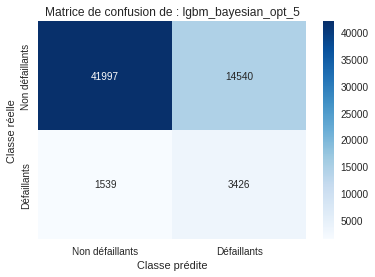

In [44]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_bayesian_opt_5,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_bayesian_opt_5')

In [45]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_bayesian_opt_5',
                                        1539, 14540, 3426, 41997, df_taux)

***
<span style='background:LightGreen'>**Modèle lgbm_bayesian_opt_6**</span>
***
- sans forcer les paramètres :
    - learning_rate
    - n_estimators
- en utilisant : class_weight='balanced' pour le déséquilibrage des classes
- en utilisant la métrique métier pour récupérer les meilleurs paramètres lors de la recherche bayésienne.
- avec les poids de pénalisation : taux_tn=1, taux_fp=-1, taux_fn=-10, taux_tp=0

[Source](https://medium.com/analytics-vidhya/hyperparameters-optimization-for-lightgbm-catboost-and-xgboost-regressors-using-bayesian-6e7c495947a9)

In [46]:
# Définition de l'objective fonction
def lgbm_eval_6(num_leaves, max_depth, min_split_gain,
                min_child_weight, min_child_samples, subsample,
                subsample_freq, colsample_bytree, reg_alpha, reg_lambda):
    '''
    Objective function for Bayesian Optimization of LightGBM's
    Hyperparamters. Takes the hyperparameters as input, and
    returns the Cross-Validation AUC as output.

    Inputs: Hyperparamters to be tuned.
        boost, num_leaves, max_depth, min_split_gain, min_child_weight,
        min_child_samples, subsample, colsample_bytree, reg_alpha,
        reg_lambda

    Returns:
        CV ROC-AUC Score
    '''

    params = {
        'objective' : 'binary',
        'boosting_type' : 'gbdt',
        'n_jobs' : -1,
        'class_weight' : 'balanced', # Balanced        
        'num_leaves' : int(round(num_leaves)),
        'max_depth' : int(round(max_depth)),
        'min_split_gain' : min_split_gain,
        'min_child_weight' : min_child_weight,
        'min_child_samples' : int(round(min_child_samples)),
        'subsample': subsample,
        'subsample_freq' : int(round(subsample_freq)),
        'colsample_bytree' : colsample_bytree,
        'reg_alpha' : reg_alpha,
        'reg_lambda' : reg_lambda,
        'verbosity' : -1,
        'seed' : seed
    }
    
    stratified_cv = StratifiedKFold(n_splits=3, shuffle=True,
                                    random_state=seed)
    
    cv_preds = np.zeros(X_train.shape[0])
    for train_indices, cv_indices in stratified_cv.split(X_train,
                                                         y_train):

        x_tr = X_train.iloc[train_indices]
        y_tr = y_train.iloc[train_indices]
        x_cv = X_train.iloc[cv_indices]
        y_cv = y_train.iloc[cv_indices]

        lgbm_clf = lgb.LGBMClassifier(**params)
        lgbm_clf.fit(x_tr, y_tr, eval_set= [(x_cv, y_cv)],
                     eval_metric='custom_score_2', verbose=False,
                     early_stopping_rounds=200)

        cv_preds[cv_indices] = \
            lgbm_clf.predict(x_cv,
                             num_iteration=lgbm_clf.best_iteration_)
        
    return outils_model.custom_score_2(y_train, np.rint(cv_preds))

In [47]:
# Recherche des meilleurs paramètres 
lgbm_bayesian_opt_6 = \
    BayesianOptimization(lgbm_eval_6,
                         {'num_leaves' : (25, 50),
                          'max_depth' : (6, 11),
                          'min_split_gain' : (0, 0.1),
                          'min_child_weight' : (5, 80),
                          'min_child_samples' : (5, 80),
                          'subsample' : (0.5, 1),
                          'subsample_freq' : (1, 7),
                          'colsample_bytree' : (0.5, 1),
                          'reg_alpha' : (0.001, 0.3),
                          'reg_lambda' : (0.001, 0.3)},
                         random_state=seed)

bayesian_opt_6 = lgbm_bayesian_opt_6.maximize(n_iter=20,
                                              init_points=4)

|   iter    |  target   | colsam... | max_depth | min_ch... | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample | subsam... |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.7216   |  0.5244   |  7.446    |  59.07    |  6.621    |  0.02059  |  26.27    |  0.09138  |  0.1995   |  0.6541   |  4.502    |
|  2        |  0.7279   |  0.5348   |  10.34    |  14.99    |  18.36    |  0.04959  |  46.59    |  0.2279   |  0.2912   |  0.8797   |  3.306    |
|  3        |  0.7271   |  0.7044   |  9.567    |  25.3     |  69.06    |  0.09132  |  44.02    |  0.1555   |  0.05118  |  0.6493   |  2.704    |
|  4        |  0.7269   |  0.6636   |  8.301    |  45.83    |  21.31    |  0.07999  |  43.17    |  0.2549   |  0.08099  |  0.8074   |  4.917    |
|  5        |  0.7272   |  0.7589   |  10.61    |  14.14    |  19.53    |  0.02771  |  46.51    |  0.22     |  0.1816   |  0

In [48]:
#extracting the best parameters
target_values = []
for result in lgbm_bayesian_opt_6.res:
    target_values.append(result['target'])
    if result['target'] == max(target_values):
        best_params = result['params']

print('Best Hyperparamètres :\n')
print(best_params)

Best Hyperparamètres :

{'colsample_bytree': 1.0, 'max_depth': 11.0, 'min_child_samples': 5.0, 'min_child_weight': 80.0, 'min_split_gain': 0.1, 'num_leaves': 50.0, 'reg_alpha': 0.19806219891115823, 'reg_lambda': 0.15582988591617394, 'subsample': 1.0, 'subsample_freq': 1.0}


In [49]:
param_lgbm_bayesian_opt_6 = {'objective' : 'binary',
                             'boosting_type' : 'gbdt',
                             'n_jobs' : -1,
                             'class_weight' : 'balanced', # Balanced        
                             'colsample_bytree': 1.0,
                             'max_depth': 11,
                             'min_child_samples': 5,
                             'min_child_weight': 80.0,
                             'min_split_gain': 0.1,
                             'num_leaves': 50,
                             'reg_alpha': 0.19806219891115823,
                             'reg_lambda': 0.15582988591617394,
                             'subsample': 1.0,
                             'subsample_freq' : 1,
                             'verbosity' : -1,
                             'seed' : seed}

In [50]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_bayesian_opt_6 = LGBMClassifier(**param_lgbm_bayesian_opt_6,
                                     force_col_wise=True)

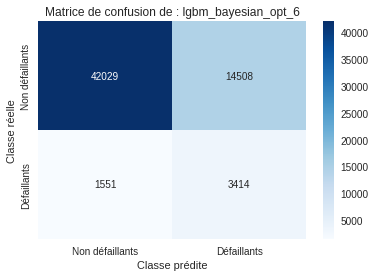

In [51]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_bayesian_opt_6,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_bayesian_opt_6')

In [52]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_bayesian_opt_6',
                                        1551, 14508, 3414, 42029, df_taux)

#### <span style='background:Moccasin'>6.4.3. Optimisation LGBM : BayesianOptimization - Score PR_AUC</span>

***
<span style='background:LightGreen'>**Modèle 7lgbm_bayesian_opt_7**</span>
***
- sans forcer les paramètres :
    - learning_rate
    - n_estimators
- en utilisant : class_weight='balanced' pour le déséquilibrage des classes
- avec la métrique PR_AUC comme métrique d'évaluation lors de la recherche bayésienne.

In [53]:
# Définition de l'objective fonction
def lgbm_eval_7(num_leaves, max_depth, min_split_gain,
                min_child_weight, min_child_samples, subsample,
                colsample_bytree, reg_alpha, reg_lambda):
    '''
    Objective function for Bayesian Optimization of LightGBM's
    Hyperparamters. Takes the hyperparameters as input, and
    returns the Cross-Validation AUC as output.

    Inputs: Hyperparamters to be tuned.
        boost, num_leaves, max_depth, min_split_gain, min_child_weight,
        min_child_samples, subsample, colsample_bytree, reg_alpha,
        reg_lambda

    Returns:
        CV ROC-AUC Score
    '''

    params = {
        'objective' : 'binary',
        'boosting_type' : 'gbdt',
        'n_jobs' : -1,
        'class_weight' : 'balanced', # Balanced        
        'num_leaves' : int(round(num_leaves)),
        'max_depth' : int(round(max_depth)),
        'min_split_gain' : min_split_gain,
        'min_child_weight' : min_child_weight,
        'min_child_samples' : int(round(min_child_samples)),
        'subsample': subsample,
        'subsample_freq' : 1,
        'colsample_bytree' : colsample_bytree,
        'reg_alpha' : reg_alpha,
        'reg_lambda' : reg_lambda,
        'verbosity' : -1,
        'seed' : seed
    }
    
    stratified_cv = StratifiedKFold(n_splits=5, shuffle=True,
                                    random_state=seed)
    
    cv_preds = np.zeros(X_train.shape[0])
    for train_indices, cv_indices in stratified_cv.split(X_train,
                                                         y_train):

        x_tr = X_train.iloc[train_indices]
        y_tr = y_train.iloc[train_indices]
        x_cv = X_train.iloc[cv_indices]
        y_cv = y_train.iloc[cv_indices]

        lgbm_clf = lgb.LGBMClassifier(**params)
        lgbm_clf.fit(x_tr, y_tr, eval_set= [(x_cv, y_cv)],
                     eval_metric='pr_auc', verbose=False,
                     early_stopping_rounds=200)

        cv_preds[cv_indices] = \
            lgbm_clf.predict_proba(x_cv,
                                   num_iteration=lgbm_clf.best_iteration_)[:,1]

    return average_precision_score(y_train, cv_preds)

In [54]:
# Recherche des meilleurs paramètres 
lgbm_bayesian_opt_7 = \
    BayesianOptimization(lgbm_eval_7,
                         {'num_leaves' : (25, 50),
                          'max_depth' : (6, 11),
                          'min_split_gain' : (0, 0.1),
                          'min_child_weight' : (5, 80),
                          'min_child_samples' : (5, 80),
                          'subsample' : (0.5, 1),
                          'colsample_bytree' : (0.5, 1),
                          'reg_alpha' : (0.001, 0.3),
                          'reg_lambda' : (0.001, 0.3)},
                         random_state=seed)

bayesian_opt_7 = lgbm_bayesian_opt_7.maximize(n_iter=20,
                                              init_points=4)

|   iter    |  target   | colsam... | max_depth | min_ch... | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.2748   |  0.5244   |  7.446    |  59.07    |  6.621    |  0.02059  |  26.27    |  0.09138  |  0.1995   |  0.6541   |
|  2        |  0.2758   |  0.7918   |  6.348    |  70.06    |  14.99    |  0.01781  |  37.4     |  0.2592   |  0.2279   |  0.9852   |
|  3        |  0.2766   |  0.8797   |  7.921    |  35.65    |  58.5     |  0.02707  |  46.35    |  0.274    |  0.2285   |  0.7583   |
|  4        |  0.2764   |  0.5839   |  7.493    |  26.3     |  29.54    |  0.04601  |  38.61    |  0.066    |  0.2402   |  0.8633   |
|  5        |  0.2781   |  0.503    |  7.527    |  35.28    |  60.0     |  0.04912  |  45.61    |  0.05169  |  0.07763  |  0.9864   |
|  6        |  0.2777   |  0.7995   |  8.15     |  35.79    | 

In [55]:
#extracting the best parameters
target_values = []
for result in lgbm_bayesian_opt_7.res:
    target_values.append(result['target'])
    if result['target'] == max(target_values):
        best_params = result['params']

print('Best Hyperparamètres :\n')
print(best_params)

Best Hyperparamètres :

{'colsample_bytree': 0.6149384105879099, 'max_depth': 10.993544976009925, 'min_child_samples': 31.72656556962302, 'min_child_weight': 57.383712910003446, 'min_split_gain': 0.08524439802153662, 'num_leaves': 40.53111622160523, 'reg_alpha': 0.18159642030920264, 'reg_lambda': 0.2054094041799748, 'subsample': 0.7869550999504538}


In [56]:
param_lgbm_bayesian_opt_7 = {'objective' : 'binary',
                             'boosting_type' : 'gbdt',
                             'n_jobs' : -1,
                             'class_weight' : 'balanced', # Balanced        
                             'colsample_bytree': 0.6149384105879099,
                             'max_depth': 11,
                             'min_child_samples': 32,
                             'min_child_weight': 57.383712910003446,
                             'min_split_gain': 0.08524439802153662,
                             'num_leaves': 41,
                             'reg_alpha': 0.18159642030920264,
                             'reg_lambda': 0.2054094041799748,
                             'subsample': 0.7869550999504538,
                             'subsample_freq' : 1,
                             'verbosity' : -1,
                             'seed' : seed}

In [57]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_bayesian_opt_7 = LGBMClassifier(**param_lgbm_bayesian_opt_7,
                                     force_col_wise=True)

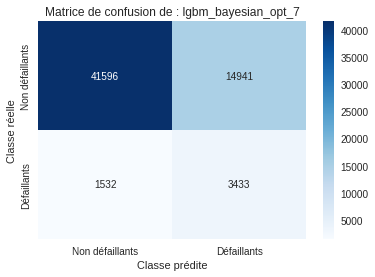

In [58]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_bayesian_opt_7,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_bayesian_opt_7')

In [59]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_bayesian_opt_7',
                                        1532, 14941, 3433, 41596, df_taux)

#### <span style='background:Moccasin'>6.4.3. Optimisation LGBM : BayesianOptimization - Score F10</span>

***
<span style='background:LightGreen'>**Modèle 7 lgbm_bayesian_opt_8**</span>
***
- sans forcer les paramètres :
    - learning_rate
    - n_estimators
- en utilisant : class_weight='balanced' pour le déséquilibrage des classes
- avec la métrique F-mesure beta = 10 qui pénalise plus les faux négaifs que les faux positifs comme métrique d'évaluation lors de la recherche bayésienne.

In [60]:
# Définition de l'objective fonction
def lgbm_eval_8(num_leaves, max_depth, min_split_gain,
                min_child_weight, min_child_samples, subsample,
                colsample_bytree, reg_alpha, reg_lambda):
    '''
    Objective function for Bayesian Optimization of LightGBM's
    Hyperparamters. Takes the hyperparameters as input, and
    returns the Cross-Validation AUC as output.

    Inputs: Hyperparamters to be tuned.
        boost, num_leaves, max_depth, min_split_gain, min_child_weight,
        min_child_samples, subsample, colsample_bytree, reg_alpha,
        reg_lambda

    Returns:
        CV ROC-AUC Score
    '''

    params = {
        'objective' : 'binary',
        'boosting_type' : 'gbdt',
        'n_jobs' : -1,
        'class_weight' : 'balanced', # Balanced        
        'num_leaves' : int(round(num_leaves)),
        'max_depth' : int(round(max_depth)),
        'min_split_gain' : min_split_gain,
        'min_child_weight' : min_child_weight,
        'min_child_samples' : int(round(min_child_samples)),
        'subsample': subsample,
        'subsample_freq' : 1,
        'colsample_bytree' : colsample_bytree,
        'reg_alpha' : reg_alpha,
        'reg_lambda' : reg_lambda,
        'verbosity' : -1,
        'seed' : seed
    }
    
    stratified_cv = StratifiedKFold(n_splits=5, shuffle=True,
                                    random_state=seed)
    
    cv_preds = np.zeros(X_train.shape[0])
    for train_indices, cv_indices in stratified_cv.split(X_train,
                                                         y_train):

        x_tr = X_train.iloc[train_indices]
        y_tr = y_train.iloc[train_indices]
        x_cv = X_train.iloc[cv_indices]
        y_cv = y_train.iloc[cv_indices]

        lgbm_clf = lgb.LGBMClassifier(**params)
        lgbm_clf.fit(x_tr, y_tr, eval_set= [(x_cv, y_cv)],
                     eval_metric='pr_auc', verbose=False,
                     early_stopping_rounds=200)

        cv_preds[cv_indices] = \
            lgbm_clf.predict(x_cv, num_iteration=lgbm_clf.best_iteration_)

    return fbeta_score(y_train, cv_preds, 10)

In [61]:
# Recherche des meilleurs paramètres 
lgbm_bayesian_opt_8 = \
    BayesianOptimization(lgbm_eval_8,
                         {'num_leaves' : (25, 50),
                          'max_depth' : (6, 11),
                          'min_split_gain' : (0, 0.1),
                          'min_child_weight' : (5, 80),
                          'min_child_samples' : (5, 80),
                          'subsample' : (0.5, 1),
                          'colsample_bytree' : (0.5, 1),
                          'reg_alpha' : (0.001, 0.3),
                          'reg_lambda' : (0.001, 0.3)},
                         random_state=seed)

bayesian_opt_8 = lgbm_bayesian_opt_8.maximize(n_iter=20,
                                              init_points=4)

|   iter    |  target   | colsam... | max_depth | min_ch... | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.6875   |  0.5244   |  7.446    |  59.07    |  6.621    |  0.02059  |  26.27    |  0.09138  |  0.1995   |  0.6541   |
|  2        |  0.6762   |  0.7918   |  6.348    |  70.06    |  14.99    |  0.01781  |  37.4     |  0.2592   |  0.2279   |  0.9852   |
|  3        |  0.6727   |  0.8797   |  7.921    |  35.65    |  58.5     |  0.02707  |  46.35    |  0.274    |  0.2285   |  0.7583   |
|  4        |  0.6792   |  0.5839   |  7.493    |  26.3     |  29.54    |  0.04601  |  38.61    |  0.066    |  0.2402   |  0.8633   |
|  5        |  0.681    |  0.6062   |  7.244    |  31.84    |  38.34    |  0.08193  |  35.66    |  0.09261  |  0.1534   |  0.8499   |
|  6        |  0.6782   |  0.6227   |  8.424    |  19.81    | 

In [62]:
#extracting the best parameters
target_values = []
for result in lgbm_bayesian_opt_8.res:
    target_values.append(result['target'])
    if result['target'] == max(target_values):
        best_params = result['params']

print('Best Hyperparamètres :\n')
print(best_params)

Best Hyperparamètres :

{'colsample_bytree': 0.5410236335271631, 'max_depth': 8.179407392871557, 'min_child_samples': 30.061255885486368, 'min_child_weight': 78.19968750411668, 'min_split_gain': 0.056730867044137503, 'num_leaves': 26.116235432332473, 'reg_alpha': 0.08474736470320782, 'reg_lambda': 0.20377681920813634, 'subsample': 0.814748209832399}


In [63]:
param_lgbm_bayesian_opt_8 = {'objective' : 'binary',
                             'boosting_type' : 'gbdt',
                             'n_jobs' : -1,
                             'class_weight' : 'balanced', # Balanced        
                             'colsample_bytree': 0.5410236335271631,
                             'max_depth': 8,
                             'min_child_samples': 30,
                             'min_child_weight': 78.19968750411668,
                             'min_split_gain': 0.056730867044137503,
                             'num_leaves': 26,
                             'reg_alpha': 0.08474736470320782,
                             'reg_lambda': 0.20377681920813634,
                             'subsample': 0.814748209832399,
                             'verbosity' : -1}

In [64]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_bayesian_opt_8 = LGBMClassifier(**param_lgbm_bayesian_opt_8,
                                     force_col_wise=True)

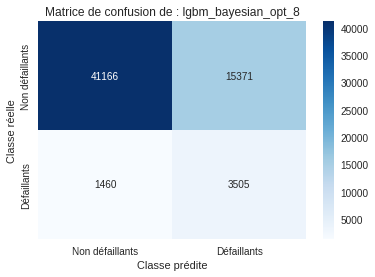

In [65]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_bayesian_opt_8,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_bayesian_opt_8')

In [66]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_bayesian_opt_8',
                                        1460, 15371, 3505, 41166, df_taux)

***
**Bilan** :
- L'optimisation avec la librairie bayes_opt égale celui du modèle LightGBM avec ces hyperparamètres de base avec le paramètre class_weight='balanced'.
- Soit la librairie n'est pas performante ou mal réglée par nos soins, soit les hyperparamètres de base sont très bien réglés.
- Nous tenterons d'utiliser la librairie d'optimisation bayésienne de scikit-learn : BayesSearchCV.

In [67]:
df_taux.sort_values(by='FN')

Modèle    FN     FP    TP     TN
19           lgbm_bayesian_opt_8  1460  15371  3505  41166
11   lgbm_bayesian_opt_1_bis_bal  1480  15265  3485  41272
9        lgbm_bayesian_opt_1_bal  1480  15265  3485  41272
14           lgbm_bayesian_opt_4  1486  15336  3479  41201
2       lgbm_hyperparam_base_bal  1500  15276  3469  41261
15           lgbm_bayesian_opt_9  1503  15149  3462  41388
4   lgbm_hyperparam_base_std_bal  1508  15281  3457  41256
18           lgbm_bayesian_opt_7  1532  14941  3433  41596
16           lgbm_bayesian_opt_5  1539  14540  3426  41997
17           lgbm_bayesian_opt_6  1551  14508  3414  42029
13           lgbm_bayesian_opt_3  1852  11178  3113  45359
12           lgbm_bayesian_opt_2  4644    259   321  56278
7          pycaret_lgbm_hyperopt  4680    221   285  56316
8            lgbm_bayesian_opt_1  4735    151   230  56386
10       lgbm_bayesian_opt_1_bis  4735    151   230  56386
1           lgbm_hyperparam_base  4742    158   223  56379
5    lgbm_hyperparam_base_minmax  4743    153   222  56384
6    lgbm_hyperparam_base_robust  4751    160   214  56377
0           lgbm_hyperparam_base  4758    165   207  56372
3       lgbm_hyperparam_base_std  4764    164   201  56373

### <span style='background:PowderBlue'>6.5. Optimisation LGBM : BayesSearchCV</span>

In [68]:
# Lancer la recherche avec BayesSearchCV
def lancer_optimise_baysearch(optimizer, X, y):
    optimizer.fit(X_train, y_train)
    d=pd.DataFrame(optimizer.cv_results_)
    best_score = optimizer.best_score_
    best_score_std = d.iloc[optimizer.best_index_].std_test_score
    best_params = optimizer.best_params_
    print(f'Best CV score : {best_score} +/- {best_score_std}')
    print('Best Hyperparamètres :\n')
    print(best_params)

#### <span style='background:Moccasin'>6.5.1. Optimisation LGBM : BayesSearchCV - ROC_AUC</span>

In [69]:
# Modèle lgbm
lgbm_baysearch_opt_1 = LGBMClassifier(objective='binary')

In [70]:
# Hyperparamètres à optimiser
params_search_spaces = {'num_leaves': Integer(25, 50),
                        'max_depth': Integer(6, 11),
                        'min_split_gain' : Real(0, 0.1),
                        'min_child_weight' : Integer(5,80),
                        'min_child_samples' : Integer(5,80),
                        'colsample_bytree' : Real(0.5,1),
                        'reg_alpha' : Real(0.001, 0.3),
                        'reg_lambda' : Real(0.001, 0.3),
                        'subsample': Real(0.5, 1.0)}

In [71]:
# Initialisation de BayesSearchCV
baysearch_opt_1 = BayesSearchCV(lgbm_baysearch_opt_1,
                                params_search_spaces,
                                scoring=roc_auc,
                                cv=skf,
                                n_iter=100,
                                n_jobs=-1,  
                                return_train_score=False,
                                refit=True,
                                optimizer_kwargs={'base_estimator': 'GP'},
                                random_state=seed)

In [72]:
lancer_optimise_baysearch(baysearch_opt_1, X_train, y_train)

Best CV score : 0.7928026464497095 +/- 0.003599737521087366
Best Hyperparamètres :

OrderedDict([('colsample_bytree', 0.7972548377966826), ('max_depth', 11), ('min_child_samples', 5), ('min_child_weight', 80), ('min_split_gain', 0.1), ('num_leaves', 50), ('reg_alpha', 0.1448965904033588), ('reg_lambda', 0.05409871652066437), ('subsample', 0.5)])


In [73]:
param_lgbm_baysearch_opt_1 = {'objective' : 'binary',
                             'boosting_type' : 'gbdt',
                             'n_jobs' : -1,
                             'class_weight' : 'balanced', # Balanced        
                             'colsample_bytree': 0.7972548377966826,
                             'max_depth': 11,
                             'min_child_samples': 5,
                             'min_child_weight': 80,
                             'min_split_gain': 0.1,
                             'num_leaves': 50,
                             'reg_alpha': 0.1448965904033588,
                             'reg_lambda': 0.05409871652066437,
                             'subsample': 0.5,
                             'verbosity' : -1}

In [74]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_baysearch_opt_1 = LGBMClassifier(**param_lgbm_baysearch_opt_1,
                                      force_col_wise=True)

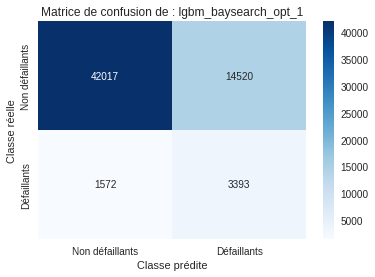

In [75]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_baysearch_opt_1,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_baysearch_opt_1')

In [76]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_baysearch_opt_1',
                                        1572, 14520, 3393, 42017, df_taux)

#### <span style='background:Moccasin'>6.5.2. Optimisation LGBM : BayesSearchCV - Métrique métier</span>

In [77]:
# Modèle lgbm
lgbm_baysearch_opt_2 = LGBMClassifier(objective='binary')

In [78]:
# Hyperparamètres à optimiser
params_search_spaces_2 = {'num_leaves': Integer(25, 50),
                          'max_depth': Integer(6, 11),
                          'min_split_gain' : Real(0, 0.1),
                          'min_child_weight' : Integer(5,80),
                          'min_child_samples' : Integer(5,80),
                          'colsample_bytree' : Real(0.5,1),
                          'reg_alpha' : Real(0.001, 0.3),
                          'reg_lambda' : Real(0.001, 0.3),
                          'subsample': Real(0.5, 1.0)}

In [79]:
# Initialisation de BayesSearchCV
baysearch_opt_2 = BayesSearchCV(lgbm_baysearch_opt_2,
                                params_search_spaces_2,
                                scoring=custom_score,
                                cv=skf,
                                n_iter=100,
                                n_jobs=-1,  
                                return_train_score=False,
                                refit=True,
                                optimizer_kwargs={'base_estimator': 'GP'},
                                random_state=seed)

In [80]:
lancer_optimise_baysearch(baysearch_opt_2, X_train, y_train)

Best CV score : 0.7818821369728688 +/- 0.0005034829751987051
Best Hyperparamètres :

OrderedDict([('colsample_bytree', 1.0), ('max_depth', 11), ('min_child_samples', 14), ('min_child_weight', 80), ('min_split_gain', 0.099636988363894), ('num_leaves', 50), ('reg_alpha', 0.009985929953554545), ('reg_lambda', 0.3), ('subsample', 0.5)])


In [81]:
param_lgbm_baysearch_opt_2 = {'objective' : 'binary',
                             'boosting_type' : 'gbdt',
                             'n_jobs' : -1,
                             'class_weight' : 'balanced', # Balanced        
                             'colsample_bytree': 1.0,
                             'max_depth': 11,
                             'min_child_samples': 14,
                             'min_child_weight': 80,
                             'min_split_gain': 0.099636988363894,
                             'num_leaves': 50,
                             'reg_alpha': 0.009985929953554545,
                             'reg_lambda': 0.3,
                             'subsample': 0.5,
                             'verbosity' : -1}

In [82]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_baysearch_opt_2 = LGBMClassifier(**param_lgbm_baysearch_opt_2,
                                      force_col_wise=True)

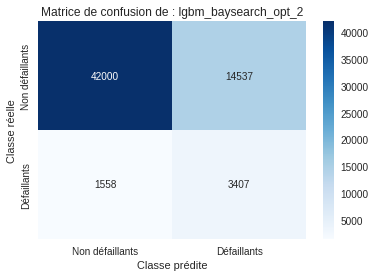

In [83]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_baysearch_opt_2,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_baysearch_opt_2')

In [84]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_baysearch_opt_2',
                                        1558, 14537, 3407, 42000, df_taux)

#### <span style='background:Moccasin'>6.5.3. Optimisation LGBM : BayesSearchCV - Score PR_AUC</span>

In [85]:
# Modèle lgbm
lgbm_baysearch_opt_3 = LGBMClassifier(objective='binary')

In [86]:
# Hyperparamètres à optimiser
params_search_spaces_3 = {'num_leaves': Integer(25, 50),
                          'max_depth': Integer(6, 11),
                          'min_split_gain' : Real(0, 0.1),
                          'min_child_weight' : Integer(5,80),
                          'min_child_samples' : Integer(5,80),
                          'colsample_bytree' : Real(0.5,1),
                          'reg_alpha' : Real(0.001, 0.3),
                          'reg_lambda' : Real(0.001, 0.3),
                          'subsample': Real(0.5, 1.0)}

In [87]:
# Initialisation de BayesSearchCV
baysearch_opt_3 = BayesSearchCV(lgbm_baysearch_opt_3,
                                params_search_spaces_3,
                                scoring=pr_auc,
                                cv=skf,
                                n_iter=100,
                                n_jobs=-1,  
                                return_train_score=False,
                                refit=True,
                                optimizer_kwargs={'base_estimator': 'GP'},
                                random_state=seed)

In [88]:
lancer_optimise_baysearch(baysearch_opt_3, X_train, y_train)

Best CV score : 0.28163342067249875 +/- 0.003545831596831192
Best Hyperparamètres :

OrderedDict([('colsample_bytree', 0.8290925905314461), ('max_depth', 11), ('min_child_samples', 45), ('min_child_weight', 72), ('min_split_gain', 0.1), ('num_leaves', 32), ('reg_alpha', 0.2084324054381411), ('reg_lambda', 0.3), ('subsample', 0.9344230127378306)])


In [89]:
param_lgbm_baysearch_opt_3 = {'objective' : 'binary',
                             'boosting_type' : 'gbdt',
                             'n_jobs' : -1,
                             'class_weight' : 'balanced', # Balanced        
                             'colsample_bytree': 0.8290925905314461,
                             'max_depth': 11,
                             'min_child_samples': 45,
                             'min_child_weight': 72,
                             'min_split_gain': 0.1,
                             'num_leaves': 32,
                             'reg_alpha': 0.2084324054381411,
                             'reg_lambda': 0.3,
                             'subsample': 0.9344230127378306,
                             'verbosity' : -1}

In [90]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_baysearch_opt_3 = LGBMClassifier(**param_lgbm_baysearch_opt_3,
                                      force_col_wise=True)

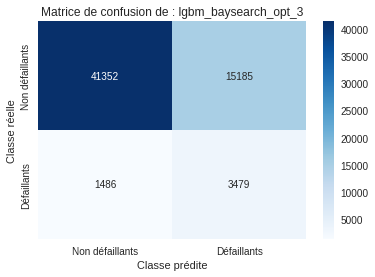

In [91]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_baysearch_opt_3,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_baysearch_opt_3')

In [92]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_baysearch_opt_3',
                                        1486, 15185, 3479, 41352, df_taux)

#### <span style='background:Moccasin'>6.5.4. Optimisation LGBM : BayesSearchCV - Score F10</span>

In [93]:
# Modèle lgbm
lgbm_baysearch_opt_4 = LGBMClassifier(objective='binary')

In [94]:
# Hyperparamètres à optimiser
params_search_spaces_4 = {'num_leaves': Integer(25, 50),
                          'max_depth': Integer(6, 11),
                          'min_split_gain' : Real(0, 0.1),
                          'min_child_weight' : Integer(5,80),
                          'min_child_samples' : Integer(5,80),
                          'colsample_bytree' : Real(0.5,1),
                          'reg_alpha' : Real(0.001, 0.3),
                          'reg_lambda' : Real(0.001, 0.3),
                          'subsample': Real(0.5, 1.0)}

In [95]:
# Initialisation de BayesSearchCV
baysearch_opt_4 = BayesSearchCV(lgbm_baysearch_opt_4,
                                params_search_spaces_4,
                                scoring=f10_score,
                                cv=skf,
                                n_iter=100,
                                n_jobs=-1,  
                                return_train_score=False,
                                refit=True,
                                optimizer_kwargs={'base_estimator': 'GP'},
                                random_state=seed)

In [96]:
lancer_optimise_baysearch(baysearch_opt_4, X_train, y_train)

Best CV score : 0.04913344077050551 +/- 0.002575955557428943
Best Hyperparamètres :

OrderedDict([('colsample_bytree', 1.0), ('max_depth', 11), ('min_child_samples', 80), ('min_child_weight', 39), ('min_split_gain', 0.0), ('num_leaves', 50), ('reg_alpha', 0.001), ('reg_lambda', 0.001), ('subsample', 0.5)])


In [97]:
param_lgbm_baysearch_opt_4 = {'objective' : 'binary',
                             'boosting_type' : 'gbdt',
                             'n_jobs' : -1,
                             'class_weight' : 'balanced', # Balanced        
                             'colsample_bytree': 1.0,
                             'max_depth': 11,
                             'min_child_samples': 80,
                             'min_child_weight': 39,
                             'min_split_gain': 0.0,
                             'num_leaves': 50,
                             'reg_alpha': 0.001,
                             'reg_lambda': 0.001,
                             'subsample': 0.5,
                             'verbosity' : -1}

In [98]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_baysearch_opt_4 = LGBMClassifier(**param_lgbm_baysearch_opt_4,
                                      force_col_wise=True)

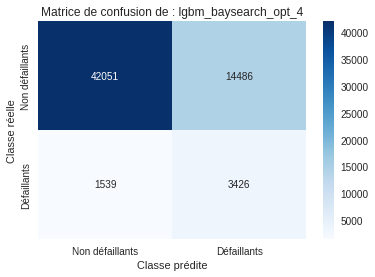

In [99]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_baysearch_opt_4,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_baysearch_opt_4')

In [100]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_baysearch_opt_4',
                                        1539, 14486, 3426, 42051, df_taux)

***
**Bilan** :
- L'optimisation avec la librairie BayesSearchCV égale celui du modèle LightGBM avec ces hyperparamètres de base avec le paramètre class_weight='balanced' mais les résultats pour les différents scores sont légèrement plus faibles avec la librairie de sckit-learn skopt que celle du MIT bayes_opt. 
- Soit la librairie n'est pas performante ou mal réglée par nos soins, soit les hyperparamètres de base sont très bien réglés.
- Nous tenterons d'utiliser la librairie d'optimisation bayésienne Optuna intégrée directement au modèle LightGBM.

In [101]:
mask = df_taux['FN']< 2000
df_taux[mask].sort_values(by='FN')

Modèle    FN     FP    TP     TN
19           lgbm_bayesian_opt_8  1460  15371  3505  41166
9        lgbm_bayesian_opt_1_bal  1480  15265  3485  41272
11   lgbm_bayesian_opt_1_bis_bal  1480  15265  3485  41272
14           lgbm_bayesian_opt_4  1486  15336  3479  41201
22          lgbm_baysearch_opt_3  1486  15185  3479  41352
2       lgbm_hyperparam_base_bal  1500  15276  3469  41261
15           lgbm_bayesian_opt_9  1503  15149  3462  41388
4   lgbm_hyperparam_base_std_bal  1508  15281  3457  41256
18           lgbm_bayesian_opt_7  1532  14941  3433  41596
16           lgbm_bayesian_opt_5  1539  14540  3426  41997
23          lgbm_baysearch_opt_4  1539  14486  3426  42051
17           lgbm_bayesian_opt_6  1551  14508  3414  42029
21          lgbm_baysearch_opt_2  1558  14537  3407  42000
20          lgbm_baysearch_opt_1  1572  14520  3393  42017
13           lgbm_bayesian_opt_3  1852  11178  3113  45359

### <span style='background:PowderBlue'>6.5. Optimisation : OPTUNA intégré à LGBM</span>

LightGBM Tuner est l'un des modules d'intégration d'Optuna permettant d'optimiser les hyperparamètres de LightGBM.

Les seules paramètres supportés :

`supported_param_names = [ 
     "lambda_l1", 
     "lambda_l2", 
     "num_leaves", 
     "feature_fraction", 
     "bagging_fraction", 
     "bagging_freq", 
     "min_child_samples", 
 ]` 

[Source](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.integration.lightgbm.LightGBMTunerCV.html) [Source](https://medium.com/optuna/lightgbm-tuner-new-optuna-integration-for-hyperparameter-optimization-8b7095e99258)

#### <span style='background:Moccasin'>6.5.1. Optimisation LGBM : Optuna intégrée à LightGBM - Score ROC_AUC</span>

**Sans les hyperparamètres n_estimators et learning_rate**

In [102]:
# Modèle et hyperparamètres à étudier
def create_model(trial):
#     n_estimators = trial.suggest_int('n_estimators', 50, 10000)
    max_depth = trial.suggest_int('max_depth', 3, 11)
#     learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 0.99)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    lambda_l1 = trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
    lambda_l2 = trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
    num_leaves = trial.suggest_int('num_leaves', 2, 256),
    feature_fraction = trial.suggest_uniform('feature_fraction', 0.4, 1.0),
    bagging_fraction = trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
    bagging_freq = trial.suggest_int('bagging_freq', 1, 7),
    min_child_samples = trial.suggest_int('min_child_samples', 5, 100),
            
    model = LGBMClassifier(
        objective = 'binary',
        metric = 'auc',
        class_weight='balanced',
#         n_estimators=n_estimators, 
        max_depth=max_depth, 
#         learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        lambda_l1=lambda_l1,
        lambda_l2=lambda_l2,
        num_leaves=num_leaves,
        feature_fraction=feature_fraction,
        bagging_fraction=bagging_fraction,
        bagging_freq=bagging_freq,
        min_child_samples=min_child_samples,
        random_state=seed,
        verbose=-1)
        
    return model

In [103]:
# Objective fonction
def objective(trial):
    model = create_model(trial)
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_valid)[:,1]
    score = roc_auc_score(y_valid, y_proba)
    return score

In [104]:
# Recherche des p
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-06-20 13:13:54,712] A new study created in memory with name: no-name-be605039-6654-4983-ac22-7b6eb63ec3d4


[LightGBM] [Warning] feature_fraction is set=0.621120969706735, colsample_bytree=0.38407477463722883 will be ignored. Current value: feature_fraction=0.621120969706735
[LightGBM] [Warning] bagging_fraction is set=0.9284760627473665, subsample=0.2265997266652881 will be ignored. Current value: bagging_fraction=0.9284760627473665
[LightGBM] [Warning] lambda_l1 is set=8.766019752891982, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.766019752891982
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.10800602672122323, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10800602672122323


[I 2022-06-20 13:14:08,831] Trial 0 finished with value: 0.7866429885295909 and parameters: {'max_depth': 10, 'subsample': 0.2265997266652881, 'colsample_bytree': 0.38407477463722883, 'lambda_l1': 8.766019752891982, 'lambda_l2': 0.10800602672122323, 'num_leaves': 163, 'feature_fraction': 0.621120969706735, 'bagging_fraction': 0.9284760627473665, 'bagging_freq': 2, 'min_child_samples': 25}. Best is trial 0 with value: 0.7866429885295909.


[LightGBM] [Warning] feature_fraction is set=0.9045961737416581, colsample_bytree=0.5233687221175853 will be ignored. Current value: feature_fraction=0.9045961737416581
[LightGBM] [Warning] bagging_fraction is set=0.7574884163757014, subsample=0.8476394216769866 will be ignored. Current value: bagging_fraction=0.7574884163757014
[LightGBM] [Warning] lambda_l1 is set=3.2345427685831566e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2345427685831566e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0067688480346089494, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0067688480346089494


[I 2022-06-20 13:14:21,307] Trial 1 finished with value: 0.7824061459560541 and parameters: {'max_depth': 9, 'subsample': 0.8476394216769866, 'colsample_bytree': 0.5233687221175853, 'lambda_l1': 3.2345427685831566e-06, 'lambda_l2': 0.0067688480346089494, 'num_leaves': 151, 'feature_fraction': 0.9045961737416581, 'bagging_fraction': 0.7574884163757014, 'bagging_freq': 3, 'min_child_samples': 44}. Best is trial 0 with value: 0.7866429885295909.


[LightGBM] [Warning] feature_fraction is set=0.6592050609439983, colsample_bytree=0.6329852492956255 will be ignored. Current value: feature_fraction=0.6592050609439983
[LightGBM] [Warning] bagging_fraction is set=0.6429353767426494, subsample=0.6426266071180108 will be ignored. Current value: bagging_fraction=0.6429353767426494
[LightGBM] [Warning] lambda_l1 is set=8.984722069664528e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.984722069664528e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=5.832642433512973e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.832642433512973e-05


[I 2022-06-20 13:14:27,536] Trial 2 finished with value: 0.784136089902252 and parameters: {'max_depth': 4, 'subsample': 0.6426266071180108, 'colsample_bytree': 0.6329852492956255, 'lambda_l1': 8.984722069664528e-05, 'lambda_l2': 5.832642433512973e-05, 'num_leaves': 13, 'feature_fraction': 0.6592050609439983, 'bagging_fraction': 0.6429353767426494, 'bagging_freq': 2, 'min_child_samples': 92}. Best is trial 0 with value: 0.7866429885295909.


[LightGBM] [Warning] feature_fraction is set=0.47860900405799756, colsample_bytree=0.6726062581253653 will be ignored. Current value: feature_fraction=0.47860900405799756
[LightGBM] [Warning] bagging_fraction is set=0.6874827653070956, subsample=0.8237798390221021 will be ignored. Current value: bagging_fraction=0.6874827653070956
[LightGBM] [Warning] lambda_l1 is set=0.00011145278414673297, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011145278414673297
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0022542101681321974, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0022542101681321974


[I 2022-06-20 13:14:34,816] Trial 3 finished with value: 0.788280715062925 and parameters: {'max_depth': 11, 'subsample': 0.8237798390221021, 'colsample_bytree': 0.6726062581253653, 'lambda_l1': 0.00011145278414673297, 'lambda_l2': 0.0022542101681321974, 'num_leaves': 35, 'feature_fraction': 0.47860900405799756, 'bagging_fraction': 0.6874827653070956, 'bagging_freq': 6, 'min_child_samples': 14}. Best is trial 3 with value: 0.788280715062925.


[LightGBM] [Warning] feature_fraction is set=0.5087065150304416, colsample_bytree=0.3900934101707062 will be ignored. Current value: feature_fraction=0.5087065150304416
[LightGBM] [Warning] bagging_fraction is set=0.9934142208416995, subsample=0.5984514512974255 will be ignored. Current value: bagging_fraction=0.9934142208416995
[LightGBM] [Warning] lambda_l1 is set=5.502604616191031e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.502604616191031e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.626863868217971e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.626863868217971e-07


[I 2022-06-20 13:14:43,408] Trial 4 finished with value: 0.7883240949376236 and parameters: {'max_depth': 8, 'subsample': 0.5984514512974255, 'colsample_bytree': 0.3900934101707062, 'lambda_l1': 5.502604616191031e-05, 'lambda_l2': 1.626863868217971e-07, 'num_leaves': 40, 'feature_fraction': 0.5087065150304416, 'bagging_fraction': 0.9934142208416995, 'bagging_freq': 5, 'min_child_samples': 99}. Best is trial 4 with value: 0.7883240949376236.


[LightGBM] [Warning] feature_fraction is set=0.8811914199286215, colsample_bytree=0.72387941247479 will be ignored. Current value: feature_fraction=0.8811914199286215
[LightGBM] [Warning] bagging_fraction is set=0.7854863864176587, subsample=0.40437331453035963 will be ignored. Current value: bagging_fraction=0.7854863864176587
[LightGBM] [Warning] lambda_l1 is set=0.012658819981914024, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012658819981914024
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.9729685832920483, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9729685832920483


[I 2022-06-20 13:14:52,773] Trial 5 finished with value: 0.7855312959683239 and parameters: {'max_depth': 7, 'subsample': 0.40437331453035963, 'colsample_bytree': 0.72387941247479, 'lambda_l1': 0.012658819981914024, 'lambda_l2': 0.9729685832920483, 'num_leaves': 87, 'feature_fraction': 0.8811914199286215, 'bagging_fraction': 0.7854863864176587, 'bagging_freq': 6, 'min_child_samples': 52}. Best is trial 4 with value: 0.7883240949376236.


[LightGBM] [Warning] feature_fraction is set=0.9592156297868812, colsample_bytree=0.7084666446931166 will be ignored. Current value: feature_fraction=0.9592156297868812
[LightGBM] [Warning] bagging_fraction is set=0.5751892420233011, subsample=0.5046185063119191 will be ignored. Current value: bagging_fraction=0.5751892420233011
[LightGBM] [Warning] lambda_l1 is set=0.9252689096589398, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9252689096589398
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=9.240648643106526, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.240648643106526


[I 2022-06-20 13:15:02,449] Trial 6 finished with value: 0.789164315053171 and parameters: {'max_depth': 11, 'subsample': 0.5046185063119191, 'colsample_bytree': 0.7084666446931166, 'lambda_l1': 0.9252689096589398, 'lambda_l2': 9.240648643106526, 'num_leaves': 67, 'feature_fraction': 0.9592156297868812, 'bagging_fraction': 0.5751892420233011, 'bagging_freq': 1, 'min_child_samples': 62}. Best is trial 6 with value: 0.789164315053171.


[LightGBM] [Warning] feature_fraction is set=0.9321396226925863, colsample_bytree=0.846307991557151 will be ignored. Current value: feature_fraction=0.9321396226925863
[LightGBM] [Warning] bagging_fraction is set=0.8850616273499985, subsample=0.9112866703343796 will be ignored. Current value: bagging_fraction=0.8850616273499985
[LightGBM] [Warning] lambda_l1 is set=2.1882314146881406e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1882314146881406e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.6686818265664473, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6686818265664473


[I 2022-06-20 13:15:10,289] Trial 7 finished with value: 0.7869884885515801 and parameters: {'max_depth': 5, 'subsample': 0.9112866703343796, 'colsample_bytree': 0.846307991557151, 'lambda_l1': 2.1882314146881406e-07, 'lambda_l2': 0.6686818265664473, 'num_leaves': 117, 'feature_fraction': 0.9321396226925863, 'bagging_fraction': 0.8850616273499985, 'bagging_freq': 7, 'min_child_samples': 34}. Best is trial 6 with value: 0.789164315053171.


[LightGBM] [Warning] feature_fraction is set=0.5620873653639751, colsample_bytree=0.9828741732752222 will be ignored. Current value: feature_fraction=0.5620873653639751
[LightGBM] [Warning] bagging_fraction is set=0.895878870067663, subsample=0.3519310871010667 will be ignored. Current value: bagging_fraction=0.895878870067663
[LightGBM] [Warning] lambda_l1 is set=9.809167554269095e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.809167554269095e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.0007289724128263733, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007289724128263733


[I 2022-06-20 13:15:17,307] Trial 8 finished with value: 0.7847791822058227 and parameters: {'max_depth': 4, 'subsample': 0.3519310871010667, 'colsample_bytree': 0.9828741732752222, 'lambda_l1': 9.809167554269095e-08, 'lambda_l2': 0.0007289724128263733, 'num_leaves': 175, 'feature_fraction': 0.5620873653639751, 'bagging_fraction': 0.895878870067663, 'bagging_freq': 5, 'min_child_samples': 85}. Best is trial 6 with value: 0.789164315053171.


[LightGBM] [Warning] feature_fraction is set=0.7157990819628643, colsample_bytree=0.7160608548654888 will be ignored. Current value: feature_fraction=0.7157990819628643
[LightGBM] [Warning] bagging_fraction is set=0.7838470322333907, subsample=0.3899822680844234 will be ignored. Current value: bagging_fraction=0.7838470322333907
[LightGBM] [Warning] lambda_l1 is set=1.0909550540356015e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0909550540356015e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=3.1346355756169477, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1346355756169477


[I 2022-06-20 13:15:25,964] Trial 9 finished with value: 0.7891761993647415 and parameters: {'max_depth': 11, 'subsample': 0.3899822680844234, 'colsample_bytree': 0.7160608548654888, 'lambda_l1': 1.0909550540356015e-06, 'lambda_l2': 3.1346355756169477, 'num_leaves': 44, 'feature_fraction': 0.7157990819628643, 'bagging_fraction': 0.7838470322333907, 'bagging_freq': 7, 'min_child_samples': 15}. Best is trial 9 with value: 0.7891761993647415.


[LightGBM] [Warning] feature_fraction is set=0.7715034925847132, colsample_bytree=0.13259908323882985 will be ignored. Current value: feature_fraction=0.7715034925847132
[LightGBM] [Warning] bagging_fraction is set=0.48539549359740286, subsample=0.18464418809734642 will be ignored. Current value: bagging_fraction=0.48539549359740286
[LightGBM] [Warning] lambda_l1 is set=0.01679960603878317, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01679960603878317
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.2845208980860821e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2845208980860821e-05


[I 2022-06-20 13:15:32,619] Trial 10 finished with value: 0.7837281010585426 and parameters: {'max_depth': 6, 'subsample': 0.18464418809734642, 'colsample_bytree': 0.13259908323882985, 'lambda_l1': 0.01679960603878317, 'lambda_l2': 1.2845208980860821e-05, 'num_leaves': 250, 'feature_fraction': 0.7715034925847132, 'bagging_fraction': 0.48539549359740286, 'bagging_freq': 7, 'min_child_samples': 16}. Best is trial 9 with value: 0.7891761993647415.


[LightGBM] [Warning] feature_fraction is set=0.7611982404187164, colsample_bytree=0.836573236650842 will be ignored. Current value: feature_fraction=0.7611982404187164
[LightGBM] [Warning] bagging_fraction is set=0.543957264012833, subsample=0.45282239677891667 will be ignored. Current value: bagging_fraction=0.543957264012833
[LightGBM] [Warning] lambda_l1 is set=5.959845630162974, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.959845630162974
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=8.998055475143465, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.998055475143465


[I 2022-06-20 13:15:41,521] Trial 11 finished with value: 0.7872251381119272 and parameters: {'max_depth': 11, 'subsample': 0.45282239677891667, 'colsample_bytree': 0.836573236650842, 'lambda_l1': 5.959845630162974, 'lambda_l2': 8.998055475143465, 'num_leaves': 78, 'feature_fraction': 0.7611982404187164, 'bagging_fraction': 0.543957264012833, 'bagging_freq': 1, 'min_child_samples': 69}. Best is trial 9 with value: 0.7891761993647415.


[LightGBM] [Warning] feature_fraction is set=0.9822712879606446, colsample_bytree=0.5064695495794876 will be ignored. Current value: feature_fraction=0.9822712879606446
[LightGBM] [Warning] bagging_fraction is set=0.5844242325160158, subsample=0.7210053851820311 will be ignored. Current value: bagging_fraction=0.5844242325160158
[LightGBM] [Warning] lambda_l1 is set=0.03037711130247115, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03037711130247115
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=7.836309456579527, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.836309456579527


[I 2022-06-20 13:15:51,147] Trial 12 finished with value: 0.7872954536220529 and parameters: {'max_depth': 9, 'subsample': 0.7210053851820311, 'colsample_bytree': 0.5064695495794876, 'lambda_l1': 0.03037711130247115, 'lambda_l2': 7.836309456579527, 'num_leaves': 68, 'feature_fraction': 0.9822712879606446, 'bagging_fraction': 0.5844242325160158, 'bagging_freq': 4, 'min_child_samples': 67}. Best is trial 9 with value: 0.7891761993647415.


[LightGBM] [Warning] feature_fraction is set=0.41195885749004335, colsample_bytree=0.8376904690622924 will be ignored. Current value: feature_fraction=0.41195885749004335
[LightGBM] [Warning] bagging_fraction is set=0.4245550023977901, subsample=0.50057395951334 will be ignored. Current value: bagging_fraction=0.4245550023977901
[LightGBM] [Warning] lambda_l1 is set=2.144061833199811e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.144061833199811e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.043133492596114854, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.043133492596114854


[I 2022-06-20 13:15:59,587] Trial 13 finished with value: 0.7828447290646817 and parameters: {'max_depth': 11, 'subsample': 0.50057395951334, 'colsample_bytree': 0.8376904690622924, 'lambda_l1': 2.144061833199811e-06, 'lambda_l2': 0.043133492596114854, 'num_leaves': 111, 'feature_fraction': 0.41195885749004335, 'bagging_fraction': 0.4245550023977901, 'bagging_freq': 1, 'min_child_samples': 68}. Best is trial 9 with value: 0.7891761993647415.


[LightGBM] [Warning] feature_fraction is set=0.8080125948272936, colsample_bytree=0.9865358425552642 will be ignored. Current value: feature_fraction=0.8080125948272936
[LightGBM] [Warning] bagging_fraction is set=0.8133779584105433, subsample=0.31121879248591644 will be ignored. Current value: bagging_fraction=0.8133779584105433
[LightGBM] [Warning] lambda_l1 is set=0.3696238894834391, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3696238894834391
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.3001298627359568e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3001298627359568e-06


[I 2022-06-20 13:16:06,604] Trial 14 finished with value: 0.7847828871470796 and parameters: {'max_depth': 9, 'subsample': 0.31121879248591644, 'colsample_bytree': 0.9865358425552642, 'lambda_l1': 0.3696238894834391, 'lambda_l2': 2.3001298627359568e-06, 'num_leaves': 9, 'feature_fraction': 0.8080125948272936, 'bagging_fraction': 0.8133779584105433, 'bagging_freq': 3, 'min_child_samples': 39}. Best is trial 9 with value: 0.7891761993647415.


[LightGBM] [Warning] feature_fraction is set=0.7030630254431681, colsample_bytree=0.7347251667641699 will be ignored. Current value: feature_fraction=0.7030630254431681
[LightGBM] [Warning] bagging_fraction is set=0.6230128093115546, subsample=0.1275950614450953 will be ignored. Current value: bagging_fraction=0.6230128093115546
[LightGBM] [Warning] lambda_l1 is set=0.002517300848864993, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002517300848864993
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.21074821034158436, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.21074821034158436


[I 2022-06-20 13:16:15,027] Trial 15 finished with value: 0.7876878354007172 and parameters: {'max_depth': 10, 'subsample': 0.1275950614450953, 'colsample_bytree': 0.7347251667641699, 'lambda_l1': 0.002517300848864993, 'lambda_l2': 0.21074821034158436, 'num_leaves': 49, 'feature_fraction': 0.7030630254431681, 'bagging_fraction': 0.6230128093115546, 'bagging_freq': 4, 'min_child_samples': 6}. Best is trial 9 with value: 0.7891761993647415.


[LightGBM] [Warning] feature_fraction is set=0.8292446440854979, colsample_bytree=0.4039356915462758 will be ignored. Current value: feature_fraction=0.8292446440854979
[LightGBM] [Warning] bagging_fraction is set=0.6973612146378793, subsample=0.5308528083163769 will be ignored. Current value: bagging_fraction=0.6973612146378793
[LightGBM] [Warning] lambda_l1 is set=2.3160637874976946e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3160637874976946e-08
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.012038415949538509, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.012038415949538509


[I 2022-06-20 13:16:24,377] Trial 16 finished with value: 0.7873169707808917 and parameters: {'max_depth': 7, 'subsample': 0.5308528083163769, 'colsample_bytree': 0.4039356915462758, 'lambda_l1': 2.3160637874976946e-08, 'lambda_l2': 0.012038415949538509, 'num_leaves': 200, 'feature_fraction': 0.8292446440854979, 'bagging_fraction': 0.6973612146378793, 'bagging_freq': 3, 'min_child_samples': 58}. Best is trial 9 with value: 0.7891761993647415.


[LightGBM] [Warning] feature_fraction is set=0.7110042220567423, colsample_bytree=0.20402687747593884 will be ignored. Current value: feature_fraction=0.7110042220567423
[LightGBM] [Warning] bagging_fraction is set=0.4827874468780732, subsample=0.6920463907896829 will be ignored. Current value: bagging_fraction=0.4827874468780732
[LightGBM] [Warning] lambda_l1 is set=4.109622078102764e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.109622078102764e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=3.1278619056412156, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1278619056412156


[I 2022-06-20 13:16:33,472] Trial 17 finished with value: 0.7848169013577736 and parameters: {'max_depth': 10, 'subsample': 0.6920463907896829, 'colsample_bytree': 0.20402687747593884, 'lambda_l1': 4.109622078102764e-06, 'lambda_l2': 3.1278619056412156, 'num_leaves': 101, 'feature_fraction': 0.7110042220567423, 'bagging_fraction': 0.4827874468780732, 'bagging_freq': 5, 'min_child_samples': 81}. Best is trial 9 with value: 0.7891761993647415.


[LightGBM] [Warning] feature_fraction is set=0.996171962396073, colsample_bytree=0.5905285353760761 will be ignored. Current value: feature_fraction=0.996171962396073
[LightGBM] [Warning] bagging_fraction is set=0.7309852477077644, subsample=0.278347578889948 will be ignored. Current value: bagging_fraction=0.7309852477077644
[LightGBM] [Warning] lambda_l1 is set=0.46226442751263497, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.46226442751263497
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=3.569065013469859e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.569065013469859e-08


[I 2022-06-20 13:16:44,016] Trial 18 finished with value: 0.78728663657435 and parameters: {'max_depth': 8, 'subsample': 0.278347578889948, 'colsample_bytree': 0.5905285353760761, 'lambda_l1': 0.46226442751263497, 'lambda_l2': 3.569065013469859e-08, 'num_leaves': 56, 'feature_fraction': 0.996171962396073, 'bagging_fraction': 0.7309852477077644, 'bagging_freq': 2, 'min_child_samples': 30}. Best is trial 9 with value: 0.7891761993647415.


[LightGBM] [Warning] feature_fraction is set=0.5968013714370629, colsample_bytree=0.763164104967474 will be ignored. Current value: feature_fraction=0.5968013714370629
[LightGBM] [Warning] bagging_fraction is set=0.8554444423041988, subsample=0.4131328189167979 will be ignored. Current value: bagging_fraction=0.8554444423041988
[LightGBM] [Warning] lambda_l1 is set=0.0009386134928405943, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009386134928405943
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.00015784546525203757, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015784546525203757


[I 2022-06-20 13:16:55,900] Trial 19 finished with value: 0.7856464662047639 and parameters: {'max_depth': 11, 'subsample': 0.4131328189167979, 'colsample_bytree': 0.763164104967474, 'lambda_l1': 0.0009386134928405943, 'lambda_l2': 0.00015784546525203757, 'num_leaves': 134, 'feature_fraction': 0.5968013714370629, 'bagging_fraction': 0.8554444423041988, 'bagging_freq': 6, 'min_child_samples': 47}. Best is trial 9 with value: 0.7891761993647415.


[LightGBM] [Warning] feature_fraction is set=0.8425824198875379, colsample_bytree=0.5076765633180612 will be ignored. Current value: feature_fraction=0.8425824198875379
[LightGBM] [Warning] bagging_fraction is set=0.5429172775907438, subsample=0.5630921430467133 will be ignored. Current value: bagging_fraction=0.5429172775907438
[LightGBM] [Warning] lambda_l1 is set=1.5560880182788623e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5560880182788623e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.6347615154117644, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6347615154117644


[I 2022-06-20 13:17:01,060] Trial 20 finished with value: 0.78244474146911 and parameters: {'max_depth': 3, 'subsample': 0.5630921430467133, 'colsample_bytree': 0.5076765633180612, 'lambda_l1': 1.5560880182788623e-05, 'lambda_l2': 0.6347615154117644, 'num_leaves': 28, 'feature_fraction': 0.8425824198875379, 'bagging_fraction': 0.5429172775907438, 'bagging_freq': 1, 'min_child_samples': 55}. Best is trial 9 with value: 0.7891761993647415.


[LightGBM] [Warning] feature_fraction is set=0.542171960498153, colsample_bytree=0.37379783978604425 will be ignored. Current value: feature_fraction=0.542171960498153
[LightGBM] [Warning] bagging_fraction is set=0.994330720426392, subsample=0.6086603966773632 will be ignored. Current value: bagging_fraction=0.994330720426392
[LightGBM] [Warning] lambda_l1 is set=3.172184030992434e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.172184030992434e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.1722511617911031e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1722511617911031e-08


[I 2022-06-20 13:17:10,144] Trial 21 finished with value: 0.7907096567387957 and parameters: {'max_depth': 10, 'subsample': 0.6086603966773632, 'colsample_bytree': 0.37379783978604425, 'lambda_l1': 3.172184030992434e-05, 'lambda_l2': 1.1722511617911031e-08, 'num_leaves': 41, 'feature_fraction': 0.542171960498153, 'bagging_fraction': 0.994330720426392, 'bagging_freq': 5, 'min_child_samples': 97}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.5243667971538288, colsample_bytree=0.44707102110122876 will be ignored. Current value: feature_fraction=0.5243667971538288
[LightGBM] [Warning] bagging_fraction is set=0.9709847443604076, subsample=0.48081491077872557 will be ignored. Current value: bagging_fraction=0.9709847443604076
[LightGBM] [Warning] lambda_l1 is set=8.332055221025244e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.332055221025244e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=8.744367447226682e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.744367447226682e-07


[I 2022-06-20 13:17:15,984] Trial 22 finished with value: 0.7738194601006417 and parameters: {'max_depth': 10, 'subsample': 0.48081491077872557, 'colsample_bytree': 0.44707102110122876, 'lambda_l1': 8.332055221025244e-07, 'lambda_l2': 8.744367447226682e-07, 'num_leaves': 3, 'feature_fraction': 0.5243667971538288, 'bagging_fraction': 0.9709847443604076, 'bagging_freq': 7, 'min_child_samples': 77}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.416605442784601, colsample_bytree=0.2330058052517675 will be ignored. Current value: feature_fraction=0.416605442784601
[LightGBM] [Warning] bagging_fraction is set=0.8308245763383835, subsample=0.7287513111339089 will be ignored. Current value: bagging_fraction=0.8308245763383835
[LightGBM] [Warning] lambda_l1 is set=1.6875139807421547e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6875139807421547e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.0772166792360513e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0772166792360513e-08


[I 2022-06-20 13:17:24,021] Trial 23 finished with value: 0.7878857825747028 and parameters: {'max_depth': 11, 'subsample': 0.7287513111339089, 'colsample_bytree': 0.2330058052517675, 'lambda_l1': 1.6875139807421547e-05, 'lambda_l2': 1.0772166792360513e-08, 'num_leaves': 66, 'feature_fraction': 0.416605442784601, 'bagging_fraction': 0.8308245763383835, 'bagging_freq': 6, 'min_child_samples': 95}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.6369924480517494, colsample_bytree=0.30827529645606666 will be ignored. Current value: feature_fraction=0.6369924480517494
[LightGBM] [Warning] bagging_fraction is set=0.658712758051444, subsample=0.623083403058286 will be ignored. Current value: bagging_fraction=0.658712758051444
[LightGBM] [Warning] lambda_l1 is set=0.0005829507911265407, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005829507911265407
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.8291614697853855e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8291614697853855e-05


[I 2022-06-20 13:17:33,067] Trial 24 finished with value: 0.7855360518304183 and parameters: {'max_depth': 10, 'subsample': 0.623083403058286, 'colsample_bytree': 0.30827529645606666, 'lambda_l1': 0.0005829507911265407, 'lambda_l2': 1.8291614697853855e-05, 'num_leaves': 91, 'feature_fraction': 0.6369924480517494, 'bagging_fraction': 0.658712758051444, 'bagging_freq': 5, 'min_child_samples': 62}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.7413823840302004, colsample_bytree=0.638990207158675 will be ignored. Current value: feature_fraction=0.7413823840302004
[LightGBM] [Warning] bagging_fraction is set=0.9415181711100513, subsample=0.36364647832059344 will be ignored. Current value: bagging_fraction=0.9415181711100513
[LightGBM] [Warning] lambda_l1 is set=3.9177166525547506e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9177166525547506e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.030775764531596427, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.030775764531596427


[I 2022-06-20 13:17:41,640] Trial 25 finished with value: 0.7882048528282444 and parameters: {'max_depth': 8, 'subsample': 0.36364647832059344, 'colsample_bytree': 0.638990207158675, 'lambda_l1': 3.9177166525547506e-07, 'lambda_l2': 0.030775764531596427, 'num_leaves': 26, 'feature_fraction': 0.7413823840302004, 'bagging_fraction': 0.9415181711100513, 'bagging_freq': 4, 'min_child_samples': 87}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.4672075050913206, colsample_bytree=0.3099221556571585 will be ignored. Current value: feature_fraction=0.4672075050913206
[LightGBM] [Warning] bagging_fraction is set=0.7432910332908117, subsample=0.5592230277781568 will be ignored. Current value: bagging_fraction=0.7432910332908117
[LightGBM] [Warning] lambda_l1 is set=1.302034518906078e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.302034518906078e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.9253335712384343, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9253335712384343


[I 2022-06-20 13:17:49,390] Trial 26 finished with value: 0.7882637471444567 and parameters: {'max_depth': 9, 'subsample': 0.5592230277781568, 'colsample_bytree': 0.3099221556571585, 'lambda_l1': 1.302034518906078e-08, 'lambda_l2': 1.9253335712384343, 'num_leaves': 52, 'feature_fraction': 0.4672075050913206, 'bagging_fraction': 0.7432910332908117, 'bagging_freq': 7, 'min_child_samples': 77}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.5592615340347739, colsample_bytree=0.5784511022251346 will be ignored. Current value: feature_fraction=0.5592615340347739
[LightGBM] [Warning] bagging_fraction is set=0.5926261610947795, subsample=0.4496133870979998 will be ignored. Current value: bagging_fraction=0.5926261610947795
[LightGBM] [Warning] lambda_l1 is set=1.0817783968317464e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0817783968317464e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0007955608967511348, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007955608967511348


[I 2022-06-20 13:17:57,948] Trial 27 finished with value: 0.7866045818260411 and parameters: {'max_depth': 11, 'subsample': 0.4496133870979998, 'colsample_bytree': 0.5784511022251346, 'lambda_l1': 1.0817783968317464e-05, 'lambda_l2': 0.0007955608967511348, 'num_leaves': 69, 'feature_fraction': 0.5592615340347739, 'bagging_fraction': 0.5926261610947795, 'bagging_freq': 3, 'min_child_samples': 26}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.6670430566019953, colsample_bytree=0.7852637958879084 will be ignored. Current value: feature_fraction=0.6670430566019953
[LightGBM] [Warning] bagging_fraction is set=0.4931206271963654, subsample=0.7937111416367314 will be ignored. Current value: bagging_fraction=0.4931206271963654
[LightGBM] [Warning] lambda_l1 is set=0.1706104367355599, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1706104367355599
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.1813537922131673, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1813537922131673


[I 2022-06-20 13:18:07,782] Trial 28 finished with value: 0.7805347694398135 and parameters: {'max_depth': 10, 'subsample': 0.7937111416367314, 'colsample_bytree': 0.7852637958879084, 'lambda_l1': 0.1706104367355599, 'lambda_l2': 0.1813537922131673, 'num_leaves': 132, 'feature_fraction': 0.6670430566019953, 'bagging_fraction': 0.4931206271963654, 'bagging_freq': 6, 'min_child_samples': 5}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.9531728597858985, colsample_bytree=0.9155263590783833 will be ignored. Current value: feature_fraction=0.9531728597858985
[LightGBM] [Warning] bagging_fraction is set=0.9509632364281443, subsample=0.25706711864201515 will be ignored. Current value: bagging_fraction=0.9509632364281443
[LightGBM] [Warning] lambda_l1 is set=3.5103550833514996, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5103550833514996
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=6.233019389650774e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.233019389650774e-07


[I 2022-06-20 13:18:17,774] Trial 29 finished with value: 0.7885662413483165 and parameters: {'max_depth': 10, 'subsample': 0.25706711864201515, 'colsample_bytree': 0.9155263590783833, 'lambda_l1': 3.5103550833514996, 'lambda_l2': 6.233019389650774e-07, 'num_leaves': 22, 'feature_fraction': 0.9531728597858985, 'bagging_fraction': 0.9509632364281443, 'bagging_freq': 2, 'min_child_samples': 19}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.6011099944044973, colsample_bytree=0.4662605339810885 will be ignored. Current value: feature_fraction=0.6011099944044973
[LightGBM] [Warning] bagging_fraction is set=0.9060969569704318, subsample=0.9770346603607175 will be ignored. Current value: bagging_fraction=0.9060969569704318
[LightGBM] [Warning] lambda_l1 is set=0.0017627130216705572, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0017627130216705572
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.25676931433450084, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.25676931433450084


[I 2022-06-20 13:18:28,991] Trial 30 finished with value: 0.7863423646085771 and parameters: {'max_depth': 9, 'subsample': 0.9770346603607175, 'colsample_bytree': 0.4662605339810885, 'lambda_l1': 0.0017627130216705572, 'lambda_l2': 0.25676931433450084, 'num_leaves': 93, 'feature_fraction': 0.6011099944044973, 'bagging_fraction': 0.9060969569704318, 'bagging_freq': 5, 'min_child_samples': 42}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.9550638732389478, colsample_bytree=0.9260404236052162 will be ignored. Current value: feature_fraction=0.9550638732389478
[LightGBM] [Warning] bagging_fraction is set=0.9489321758285318, subsample=0.2325634532278631 will be ignored. Current value: bagging_fraction=0.9489321758285318
[LightGBM] [Warning] lambda_l1 is set=9.172066258491428, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.172066258491428
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=1.3288488679004547e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3288488679004547e-07


[I 2022-06-20 13:18:39,116] Trial 31 finished with value: 0.7890152588540037 and parameters: {'max_depth': 10, 'subsample': 0.2325634532278631, 'colsample_bytree': 0.9260404236052162, 'lambda_l1': 9.172066258491428, 'lambda_l2': 1.3288488679004547e-07, 'num_leaves': 21, 'feature_fraction': 0.9550638732389478, 'bagging_fraction': 0.9489321758285318, 'bagging_freq': 2, 'min_child_samples': 18}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.8909324634197623, colsample_bytree=0.9036521702153755 will be ignored. Current value: feature_fraction=0.8909324634197623
[LightGBM] [Warning] bagging_fraction is set=0.989856436468505, subsample=0.20034464926374368 will be ignored. Current value: bagging_fraction=0.989856436468505
[LightGBM] [Warning] lambda_l1 is set=2.185949437779716, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.185949437779716
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=5.6948722262133384e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6948722262133384e-08


[I 2022-06-20 13:18:49,023] Trial 32 finished with value: 0.7895297576339647 and parameters: {'max_depth': 10, 'subsample': 0.20034464926374368, 'colsample_bytree': 0.9036521702153755, 'lambda_l1': 2.185949437779716, 'lambda_l2': 5.6948722262133384e-08, 'num_leaves': 48, 'feature_fraction': 0.8909324634197623, 'bagging_fraction': 0.989856436468505, 'bagging_freq': 1, 'min_child_samples': 22}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.913634768550237, colsample_bytree=0.7088531429408071 will be ignored. Current value: feature_fraction=0.913634768550237
[LightGBM] [Warning] bagging_fraction is set=0.999094855008133, subsample=0.10477470793798943 will be ignored. Current value: bagging_fraction=0.999094855008133
[LightGBM] [Warning] lambda_l1 is set=1.4937938873351535, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4937938873351535
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=2.5813984232961983e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5813984232961983e-08


[I 2022-06-20 13:18:59,056] Trial 33 finished with value: 0.7894644295447619 and parameters: {'max_depth': 11, 'subsample': 0.10477470793798943, 'colsample_bytree': 0.7088531429408071, 'lambda_l1': 1.4937938873351535, 'lambda_l2': 2.5813984232961983e-08, 'num_leaves': 43, 'feature_fraction': 0.913634768550237, 'bagging_fraction': 0.999094855008133, 'bagging_freq': 1, 'min_child_samples': 23}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.8762355695911992, colsample_bytree=0.6635199505585514 will be ignored. Current value: feature_fraction=0.8762355695911992
[LightGBM] [Warning] bagging_fraction is set=0.9783757748351892, subsample=0.11056809608168566 will be ignored. Current value: bagging_fraction=0.9783757748351892
[LightGBM] [Warning] lambda_l1 is set=0.07939400845879604, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07939400845879604
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=1.542831338734372e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.542831338734372e-08


[I 2022-06-20 13:19:08,679] Trial 34 finished with value: 0.78845301976848 and parameters: {'max_depth': 11, 'subsample': 0.11056809608168566, 'colsample_bytree': 0.6635199505585514, 'lambda_l1': 0.07939400845879604, 'lambda_l2': 1.542831338734372e-08, 'num_leaves': 43, 'feature_fraction': 0.8762355695911992, 'bagging_fraction': 0.9783757748351892, 'bagging_freq': 1, 'min_child_samples': 24}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.8985256464426853, colsample_bytree=0.9169008222024004 will be ignored. Current value: feature_fraction=0.8985256464426853
[LightGBM] [Warning] bagging_fraction is set=0.9977077952011617, subsample=0.17556489594410693 will be ignored. Current value: bagging_fraction=0.9977077952011617
[LightGBM] [Warning] lambda_l1 is set=1.358505006080417, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.358505006080417
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=6.52968035905908e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.52968035905908e-08


[I 2022-06-20 13:19:20,273] Trial 35 finished with value: 0.7899870471334969 and parameters: {'max_depth': 9, 'subsample': 0.17556489594410693, 'colsample_bytree': 0.9169008222024004, 'lambda_l1': 1.358505006080417, 'lambda_l2': 6.52968035905908e-08, 'num_leaves': 37, 'feature_fraction': 0.8985256464426853, 'bagging_fraction': 0.9977077952011617, 'bagging_freq': 2, 'min_child_samples': 12}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.8956377123150905, colsample_bytree=0.8875164469390672 will be ignored. Current value: feature_fraction=0.8956377123150905
[LightGBM] [Warning] bagging_fraction is set=0.9977530705358945, subsample=0.17192359634895826 will be ignored. Current value: bagging_fraction=0.9977530705358945
[LightGBM] [Warning] lambda_l1 is set=2.97030152114771, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.97030152114771
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=7.806754164597948e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.806754164597948e-08


[I 2022-06-20 13:19:30,816] Trial 36 finished with value: 0.7896371688684259 and parameters: {'max_depth': 8, 'subsample': 0.17192359634895826, 'colsample_bytree': 0.8875164469390672, 'lambda_l1': 2.97030152114771, 'lambda_l2': 7.806754164597948e-08, 'num_leaves': 34, 'feature_fraction': 0.8956377123150905, 'bagging_fraction': 0.9977530705358945, 'bagging_freq': 2, 'min_child_samples': 11}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.8753578677419154, colsample_bytree=0.913522624939582 will be ignored. Current value: feature_fraction=0.8753578677419154
[LightGBM] [Warning] bagging_fraction is set=0.9152049261966982, subsample=0.17359674203900474 will be ignored. Current value: bagging_fraction=0.9152049261966982
[LightGBM] [Warning] lambda_l1 is set=0.00016176243283836498, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00016176243283836498
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=1.0699249621262579e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0699249621262579e-07


[I 2022-06-20 13:19:40,476] Trial 37 finished with value: 0.7872816990276363 and parameters: {'max_depth': 7, 'subsample': 0.17359674203900474, 'colsample_bytree': 0.913522624939582, 'lambda_l1': 0.00016176243283836498, 'lambda_l2': 1.0699249621262579e-07, 'num_leaves': 33, 'feature_fraction': 0.8753578677419154, 'bagging_fraction': 0.9152049261966982, 'bagging_freq': 2, 'min_child_samples': 11}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.7992756255499125, colsample_bytree=0.868799803804977 will be ignored. Current value: feature_fraction=0.7992756255499125
[LightGBM] [Warning] bagging_fraction is set=0.865027280693129, subsample=0.18490016244480878 will be ignored. Current value: bagging_fraction=0.865027280693129
[LightGBM] [Warning] lambda_l1 is set=2.0128384068224707, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0128384068224707
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=3.771247819732759e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.771247819732759e-07


[I 2022-06-20 13:19:46,097] Trial 38 finished with value: 0.7731963441990888 and parameters: {'max_depth': 8, 'subsample': 0.18490016244480878, 'colsample_bytree': 0.868799803804977, 'lambda_l1': 2.0128384068224707, 'lambda_l2': 3.771247819732759e-07, 'num_leaves': 3, 'feature_fraction': 0.7992756255499125, 'bagging_fraction': 0.865027280693129, 'bagging_freq': 3, 'min_child_samples': 11}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.853792377533473, colsample_bytree=0.8019876846525829 will be ignored. Current value: feature_fraction=0.853792377533473
[LightGBM] [Warning] bagging_fraction is set=0.9935002259115865, subsample=0.3158429768772537 will be ignored. Current value: bagging_fraction=0.9935002259115865
[LightGBM] [Warning] lambda_l1 is set=0.0713755501143139, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0713755501143139
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.445794159722218e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.445794159722218e-06


[I 2022-06-20 13:19:54,690] Trial 39 finished with value: 0.7870690068999366 and parameters: {'max_depth': 7, 'subsample': 0.3158429768772537, 'colsample_bytree': 0.8019876846525829, 'lambda_l1': 0.0713755501143139, 'lambda_l2': 2.445794159722218e-06, 'num_leaves': 16, 'feature_fraction': 0.853792377533473, 'bagging_fraction': 0.9935002259115865, 'bagging_freq': 3, 'min_child_samples': 34}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.9037908044227232, colsample_bytree=0.9559117989646111 will be ignored. Current value: feature_fraction=0.9037908044227232
[LightGBM] [Warning] bagging_fraction is set=0.9300590447130228, subsample=0.1597372622793726 will be ignored. Current value: bagging_fraction=0.9300590447130228
[LightGBM] [Warning] lambda_l1 is set=0.9108843577879854, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9108843577879854
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=6.233782574881872e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.233782574881872e-08


[I 2022-06-20 13:20:09,089] Trial 40 finished with value: 0.7825039100934729 and parameters: {'max_depth': 9, 'subsample': 0.1597372622793726, 'colsample_bytree': 0.9559117989646111, 'lambda_l1': 0.9108843577879854, 'lambda_l2': 6.233782574881872e-08, 'num_leaves': 153, 'feature_fraction': 0.9037908044227232, 'bagging_fraction': 0.9300590447130228, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.9137309847166608, colsample_bytree=0.8870509572231196 will be ignored. Current value: feature_fraction=0.9137309847166608
[LightGBM] [Warning] bagging_fraction is set=0.9866567753130925, subsample=0.2118403654879561 will be ignored. Current value: bagging_fraction=0.9866567753130925
[LightGBM] [Warning] lambda_l1 is set=1.5601554261752186, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5601554261752186
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=3.813297315710613e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.813297315710613e-08


[I 2022-06-20 13:20:19,338] Trial 41 finished with value: 0.7893434810249386 and parameters: {'max_depth': 9, 'subsample': 0.2118403654879561, 'colsample_bytree': 0.8870509572231196, 'lambda_l1': 1.5601554261752186, 'lambda_l2': 3.813297315710613e-08, 'num_leaves': 58, 'feature_fraction': 0.9137309847166608, 'bagging_fraction': 0.9866567753130925, 'bagging_freq': 1, 'min_child_samples': 23}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.9241956347857829, colsample_bytree=0.943425919156118 will be ignored. Current value: feature_fraction=0.9241956347857829
[LightGBM] [Warning] bagging_fraction is set=0.9954790292401071, subsample=0.10485096298281048 will be ignored. Current value: bagging_fraction=0.9954790292401071
[LightGBM] [Warning] lambda_l1 is set=0.3274471699852317, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3274471699852317
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=2.223723965246598e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.223723965246598e-07


[I 2022-06-20 13:20:30,013] Trial 42 finished with value: 0.787251863563187 and parameters: {'max_depth': 8, 'subsample': 0.10485096298281048, 'colsample_bytree': 0.943425919156118, 'lambda_l1': 0.3274471699852317, 'lambda_l2': 2.223723965246598e-07, 'num_leaves': 79, 'feature_fraction': 0.9241956347857829, 'bagging_fraction': 0.9954790292401071, 'bagging_freq': 1, 'min_child_samples': 28}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.8814268090602883, colsample_bytree=0.8036967150745866 will be ignored. Current value: feature_fraction=0.8814268090602883
[LightGBM] [Warning] bagging_fraction is set=0.9610647393734856, subsample=0.14796663937378446 will be ignored. Current value: bagging_fraction=0.9610647393734856
[LightGBM] [Warning] lambda_l1 is set=3.092593694531155, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.092593694531155
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=1.891682858964747e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.891682858964747e-08


[I 2022-06-20 13:20:40,711] Trial 43 finished with value: 0.7901332213158594 and parameters: {'max_depth': 9, 'subsample': 0.14796663937378446, 'colsample_bytree': 0.8036967150745866, 'lambda_l1': 3.092593694531155, 'lambda_l2': 1.891682858964747e-08, 'num_leaves': 36, 'feature_fraction': 0.8814268090602883, 'bagging_fraction': 0.9610647393734856, 'bagging_freq': 2, 'min_child_samples': 22}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.8903385040882767, colsample_bytree=0.804960482305394 will be ignored. Current value: feature_fraction=0.8903385040882767
[LightGBM] [Warning] bagging_fraction is set=0.958185247679301, subsample=0.22024509165250206 will be ignored. Current value: bagging_fraction=0.958185247679301
[LightGBM] [Warning] lambda_l1 is set=8.905527527139792, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.905527527139792
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=2.205796621903787e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.205796621903787e-06


[I 2022-06-20 13:20:51,943] Trial 44 finished with value: 0.7901299189307197 and parameters: {'max_depth': 9, 'subsample': 0.22024509165250206, 'colsample_bytree': 0.804960482305394, 'lambda_l1': 8.905527527139792, 'lambda_l2': 2.205796621903787e-06, 'num_leaves': 34, 'feature_fraction': 0.8903385040882767, 'bagging_fraction': 0.958185247679301, 'bagging_freq': 2, 'min_child_samples': 20}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.807725635376179, colsample_bytree=0.808708379044051 will be ignored. Current value: feature_fraction=0.807725635376179
[LightGBM] [Warning] bagging_fraction is set=0.8877019021730155, subsample=0.27601763797021106 will be ignored. Current value: bagging_fraction=0.8877019021730155
[LightGBM] [Warning] lambda_l1 is set=8.744210093356882, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.744210093356882
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=1.8661723036670878e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8661723036670878e-06


[I 2022-06-20 13:21:01,643] Trial 45 finished with value: 0.7895992751567426 and parameters: {'max_depth': 8, 'subsample': 0.27601763797021106, 'colsample_bytree': 0.808708379044051, 'lambda_l1': 8.744210093356882, 'lambda_l2': 1.8661723036670878e-06, 'num_leaves': 36, 'feature_fraction': 0.807725635376179, 'bagging_fraction': 0.8877019021730155, 'bagging_freq': 2, 'min_child_samples': 34}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.8536692890461037, colsample_bytree=0.9941164934588897 will be ignored. Current value: feature_fraction=0.8536692890461037
[LightGBM] [Warning] bagging_fraction is set=0.9432874070734812, subsample=0.14522949537841204 will be ignored. Current value: bagging_fraction=0.9432874070734812
[LightGBM] [Warning] lambda_l1 is set=0.6591009685837056, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6591009685837056
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=1.5001690632460172e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5001690632460172e-05


[I 2022-06-20 13:21:10,072] Trial 46 finished with value: 0.7866798135082194 and parameters: {'max_depth': 6, 'subsample': 0.14522949537841204, 'colsample_bytree': 0.9941164934588897, 'lambda_l1': 0.6591009685837056, 'lambda_l2': 1.5001690632460172e-05, 'num_leaves': 17, 'feature_fraction': 0.8536692890461037, 'bagging_fraction': 0.9432874070734812, 'bagging_freq': 4, 'min_child_samples': 15}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.7778703930963363, colsample_bytree=0.8535931999495305 will be ignored. Current value: feature_fraction=0.7778703930963363
[LightGBM] [Warning] bagging_fraction is set=0.9649183191845188, subsample=0.23666139188437652 will be ignored. Current value: bagging_fraction=0.9649183191845188
[LightGBM] [Warning] lambda_l1 is set=4.224535379338391, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.224535379338391
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=1.1146426899875921e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1146426899875921e-08


[I 2022-06-20 13:21:24,436] Trial 47 finished with value: 0.7848549518169717 and parameters: {'max_depth': 9, 'subsample': 0.23666139188437652, 'colsample_bytree': 0.8535931999495305, 'lambda_l1': 4.224535379338391, 'lambda_l2': 1.1146426899875921e-08, 'num_leaves': 181, 'feature_fraction': 0.7778703930963363, 'bagging_fraction': 0.9649183191845188, 'bagging_freq': 2, 'min_child_samples': 8}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.9667640409940201, colsample_bytree=0.7534891766374048 will be ignored. Current value: feature_fraction=0.9667640409940201
[LightGBM] [Warning] bagging_fraction is set=0.9199215709734632, subsample=0.31002290008051103 will be ignored. Current value: bagging_fraction=0.9199215709734632
[LightGBM] [Warning] lambda_l1 is set=0.0037477211540900652, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0037477211540900652
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.3280507656140156e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3280507656140156e-07


[I 2022-06-20 13:21:36,141] Trial 48 finished with value: 0.7858469534009768 and parameters: {'max_depth': 8, 'subsample': 0.31002290008051103, 'colsample_bytree': 0.7534891766374048, 'lambda_l1': 0.0037477211540900652, 'lambda_l2': 2.3280507656140156e-07, 'num_leaves': 77, 'feature_fraction': 0.9667640409940201, 'bagging_fraction': 0.9199215709734632, 'bagging_freq': 3, 'min_child_samples': 30}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.933804567428748, colsample_bytree=0.3454333911412972 will be ignored. Current value: feature_fraction=0.933804567428748
[LightGBM] [Warning] bagging_fraction is set=0.8682598418421312, subsample=0.13705114288194342 will be ignored. Current value: bagging_fraction=0.8682598418421312
[LightGBM] [Warning] lambda_l1 is set=4.902415897313329e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.902415897313329e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=4.154994380279674e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.154994380279674e-06


[I 2022-06-20 13:21:50,835] Trial 49 finished with value: 0.7791902605074227 and parameters: {'max_depth': 9, 'subsample': 0.13705114288194342, 'colsample_bytree': 0.3454333911412972, 'lambda_l1': 4.902415897313329e-05, 'lambda_l2': 4.154994380279674e-06, 'num_leaves': 230, 'feature_fraction': 0.933804567428748, 'bagging_fraction': 0.8682598418421312, 'bagging_freq': 3, 'min_child_samples': 19}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.8279468977227263, colsample_bytree=0.8255185630120034 will be ignored. Current value: feature_fraction=0.8279468977227263
[LightGBM] [Warning] bagging_fraction is set=0.9626981655584732, subsample=0.6874766861784889 will be ignored. Current value: bagging_fraction=0.9626981655584732
[LightGBM] [Warning] lambda_l1 is set=0.11429709805374491, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11429709805374491
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=8.19523414201686e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.19523414201686e-08


[I 2022-06-20 13:22:00,419] Trial 50 finished with value: 0.788297405110799 and parameters: {'max_depth': 7, 'subsample': 0.6874766861784889, 'colsample_bytree': 0.8255185630120034, 'lambda_l1': 0.11429709805374491, 'lambda_l2': 8.19523414201686e-08, 'num_leaves': 32, 'feature_fraction': 0.8279468977227263, 'bagging_fraction': 0.9626981655584732, 'bagging_freq': 2, 'min_child_samples': 47}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.8103622089347352, colsample_bytree=0.8283776950673386 will be ignored. Current value: feature_fraction=0.8103622089347352
[LightGBM] [Warning] bagging_fraction is set=0.8888827826735793, subsample=0.2769781643729179 will be ignored. Current value: bagging_fraction=0.8888827826735793
[LightGBM] [Warning] lambda_l1 is set=8.680662302823398, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.680662302823398
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=8.391857559910141e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.391857559910141e-07


[I 2022-06-20 13:22:09,976] Trial 51 finished with value: 0.7899130480567753 and parameters: {'max_depth': 8, 'subsample': 0.2769781643729179, 'colsample_bytree': 0.8283776950673386, 'lambda_l1': 8.680662302823398, 'lambda_l2': 8.391857559910141e-07, 'num_leaves': 35, 'feature_fraction': 0.8103622089347352, 'bagging_fraction': 0.8888827826735793, 'bagging_freq': 2, 'min_child_samples': 34}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.8897236480095684, colsample_bytree=0.7720164569734389 will be ignored. Current value: feature_fraction=0.8897236480095684
[LightGBM] [Warning] bagging_fraction is set=0.9192440135655264, subsample=0.21325307853253522 will be ignored. Current value: bagging_fraction=0.9192440135655264
[LightGBM] [Warning] lambda_l1 is set=5.093907765879655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.093907765879655
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=7.167304265948478e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.167304265948478e-07


[I 2022-06-20 13:22:20,967] Trial 52 finished with value: 0.7887544096148497 and parameters: {'max_depth': 8, 'subsample': 0.21325307853253522, 'colsample_bytree': 0.7720164569734389, 'lambda_l1': 5.093907765879655, 'lambda_l2': 7.167304265948478e-07, 'num_leaves': 61, 'feature_fraction': 0.8897236480095684, 'bagging_fraction': 0.9192440135655264, 'bagging_freq': 2, 'min_child_samples': 14}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.8747538628024829, colsample_bytree=0.8637083323511597 will be ignored. Current value: feature_fraction=0.8747538628024829
[LightGBM] [Warning] bagging_fraction is set=0.8952024117076776, subsample=0.16734365922430489 will be ignored. Current value: bagging_fraction=0.8952024117076776
[LightGBM] [Warning] lambda_l1 is set=0.25542600186796766, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.25542600186796766
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=2.5117430821486514e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5117430821486514e-08


[I 2022-06-20 13:22:29,353] Trial 53 finished with value: 0.7857773468171109 and parameters: {'max_depth': 9, 'subsample': 0.16734365922430489, 'colsample_bytree': 0.8637083323511597, 'lambda_l1': 0.25542600186796766, 'lambda_l2': 2.5117430821486514e-08, 'num_leaves': 11, 'feature_fraction': 0.8747538628024829, 'bagging_fraction': 0.8952024117076776, 'bagging_freq': 2, 'min_child_samples': 19}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.8557384617844632, colsample_bytree=0.6973654332038614 will be ignored. Current value: feature_fraction=0.8557384617844632
[LightGBM] [Warning] bagging_fraction is set=0.9571154177762181, subsample=0.2685312463528615 will be ignored. Current value: bagging_fraction=0.9571154177762181
[LightGBM] [Warning] lambda_l1 is set=0.026415287849827215, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.026415287849827215
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=7.459593624223843e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.459593624223843e-06


[I 2022-06-20 13:22:38,457] Trial 54 finished with value: 0.7879106662426647 and parameters: {'max_depth': 6, 'subsample': 0.2685312463528615, 'colsample_bytree': 0.6973654332038614, 'lambda_l1': 0.026415287849827215, 'lambda_l2': 7.459593624223843e-06, 'num_leaves': 38, 'feature_fraction': 0.8557384617844632, 'bagging_fraction': 0.9571154177762181, 'bagging_freq': 3, 'min_child_samples': 40}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.7412694643681974, colsample_bytree=0.11024719372840541 will be ignored. Current value: feature_fraction=0.7412694643681974
[LightGBM] [Warning] bagging_fraction is set=0.8419329203713256, subsample=0.3352761206986294 will be ignored. Current value: bagging_fraction=0.8419329203713256
[LightGBM] [Warning] lambda_l1 is set=3.1254049999263653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1254049999263653
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=3.4259105184035925e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4259105184035925e-05


[I 2022-06-20 13:22:48,112] Trial 55 finished with value: 0.7891054314242893 and parameters: {'max_depth': 8, 'subsample': 0.3352761206986294, 'colsample_bytree': 0.11024719372840541, 'lambda_l1': 3.1254049999263653, 'lambda_l2': 3.4259105184035925e-05, 'num_leaves': 54, 'feature_fraction': 0.7412694643681974, 'bagging_fraction': 0.8419329203713256, 'bagging_freq': 2, 'min_child_samples': 36}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.8218965290132941, colsample_bytree=0.9459145419082049 will be ignored. Current value: feature_fraction=0.8218965290132941
[LightGBM] [Warning] bagging_fraction is set=0.7993603928975115, subsample=0.23938249763757913 will be ignored. Current value: bagging_fraction=0.7993603928975115
[LightGBM] [Warning] lambda_l1 is set=0.8842458916945058, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8842458916945058
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=1.7255893833079576e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7255893833079576e-07


[I 2022-06-20 13:22:56,487] Trial 56 finished with value: 0.7883394455067353 and parameters: {'max_depth': 9, 'subsample': 0.23938249763757913, 'colsample_bytree': 0.9459145419082049, 'lambda_l1': 0.8842458916945058, 'lambda_l2': 1.7255893833079576e-07, 'num_leaves': 26, 'feature_fraction': 0.8218965290132941, 'bagging_fraction': 0.7993603928975115, 'bagging_freq': 4, 'min_child_samples': 11}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.9428493292344856, colsample_bytree=0.8876091393916037 will be ignored. Current value: feature_fraction=0.9428493292344856
[LightGBM] [Warning] bagging_fraction is set=0.9324903766872716, subsample=0.6304243987912341 will be ignored. Current value: bagging_fraction=0.9324903766872716
[LightGBM] [Warning] lambda_l1 is set=4.957246364682751, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.957246364682751
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=4.6982162745985036e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6982162745985036e-07


[I 2022-06-20 13:23:10,304] Trial 57 finished with value: 0.7881438958572362 and parameters: {'max_depth': 9, 'subsample': 0.6304243987912341, 'colsample_bytree': 0.8876091393916037, 'lambda_l1': 4.957246364682751, 'lambda_l2': 4.6982162745985036e-07, 'num_leaves': 115, 'feature_fraction': 0.9428493292344856, 'bagging_fraction': 0.9324903766872716, 'bagging_freq': 2, 'min_child_samples': 30}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.6719874059527495, colsample_bytree=0.5440036824203092 will be ignored. Current value: feature_fraction=0.6719874059527495
[LightGBM] [Warning] bagging_fraction is set=0.9714451770446102, subsample=0.29616668599838725 will be ignored. Current value: bagging_fraction=0.9714451770446102
[LightGBM] [Warning] lambda_l1 is set=0.006892565478256572, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006892565478256572
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.110498655504098e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.110498655504098e-06


[I 2022-06-20 13:23:17,845] Trial 58 finished with value: 0.7856078706917077 and parameters: {'max_depth': 8, 'subsample': 0.29616668599838725, 'colsample_bytree': 0.5440036824203092, 'lambda_l1': 0.006892565478256572, 'lambda_l2': 1.110498655504098e-06, 'num_leaves': 12, 'feature_fraction': 0.6719874059527495, 'bagging_fraction': 0.9714451770446102, 'bagging_freq': 5, 'min_child_samples': 16}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.7881397044479793, colsample_bytree=0.8187481000967957 will be ignored. Current value: feature_fraction=0.7881397044479793
[LightGBM] [Warning] bagging_fraction is set=0.8747144327293128, subsample=0.3722253798388495 will be ignored. Current value: bagging_fraction=0.8747144327293128
[LightGBM] [Warning] lambda_l1 is set=1.1417852706301246, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1417852706301246
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=2.055762120931111e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.055762120931111e-08


[I 2022-06-20 13:23:28,550] Trial 59 finished with value: 0.7883168133030762 and parameters: {'max_depth': 8, 'subsample': 0.3722253798388495, 'colsample_bytree': 0.8187481000967957, 'lambda_l1': 1.1417852706301246, 'lambda_l2': 2.055762120931111e-08, 'num_leaves': 75, 'feature_fraction': 0.7881397044479793, 'bagging_fraction': 0.8747144327293128, 'bagging_freq': 2, 'min_child_samples': 49}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.9740755855961661, colsample_bytree=0.6112497067643967 will be ignored. Current value: feature_fraction=0.9740755855961661
[LightGBM] [Warning] bagging_fraction is set=0.9704103001767592, subsample=0.4277708895293355 will be ignored. Current value: bagging_fraction=0.9704103001767592
[LightGBM] [Warning] lambda_l1 is set=9.661705881368446, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.661705881368446
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.0001507548799605304, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001507548799605304


[I 2022-06-20 13:23:38,072] Trial 60 finished with value: 0.7896349922154375 and parameters: {'max_depth': 7, 'subsample': 0.4277708895293355, 'colsample_bytree': 0.6112497067643967, 'lambda_l1': 9.661705881368446, 'lambda_l2': 0.0001507548799605304, 'num_leaves': 46, 'feature_fraction': 0.9740755855961661, 'bagging_fraction': 0.9704103001767592, 'bagging_freq': 1, 'min_child_samples': 26}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.9983594565124277, colsample_bytree=0.6121152569503244 will be ignored. Current value: feature_fraction=0.9983594565124277
[LightGBM] [Warning] bagging_fraction is set=0.9721992321506303, subsample=0.42118693034974775 will be ignored. Current value: bagging_fraction=0.9721992321506303
[LightGBM] [Warning] lambda_l1 is set=2.783031200734529, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.783031200734529
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.00011070969326692034, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011070969326692034


[I 2022-06-20 13:23:47,524] Trial 61 finished with value: 0.7894078793163833 and parameters: {'max_depth': 7, 'subsample': 0.42118693034974775, 'colsample_bytree': 0.6121152569503244, 'lambda_l1': 2.783031200734529, 'lambda_l2': 0.00011070969326692034, 'num_leaves': 37, 'feature_fraction': 0.9983594565124277, 'bagging_fraction': 0.9721992321506303, 'bagging_freq': 1, 'min_child_samples': 21}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.9828419086383366, colsample_bytree=0.7379158301402328 will be ignored. Current value: feature_fraction=0.9828419086383366
[LightGBM] [Warning] bagging_fraction is set=0.942000800526741, subsample=0.5269240351984552 will be ignored. Current value: bagging_fraction=0.942000800526741
[LightGBM] [Warning] lambda_l1 is set=8.566470657872525, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.566470657872525
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.0034399174386855478, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0034399174386855478


[I 2022-06-20 13:23:57,783] Trial 62 finished with value: 0.7893688990594276 and parameters: {'max_depth': 9, 'subsample': 0.5269240351984552, 'colsample_bytree': 0.7379158301402328, 'lambda_l1': 8.566470657872525, 'lambda_l2': 0.0034399174386855478, 'num_leaves': 47, 'feature_fraction': 0.9828419086383366, 'bagging_fraction': 0.942000800526741, 'bagging_freq': 1, 'min_child_samples': 26}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.8998727797427005, colsample_bytree=0.4288261729080059 will be ignored. Current value: feature_fraction=0.8998727797427005
[LightGBM] [Warning] bagging_fraction is set=0.9747461106918163, subsample=0.14482952017711245 will be ignored. Current value: bagging_fraction=0.9747461106918163
[LightGBM] [Warning] lambda_l1 is set=3.365267662424892e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.365267662424892e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=4.364436223438462e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.364436223438462e-08


[I 2022-06-20 13:24:07,298] Trial 63 finished with value: 0.7868137400097728 and parameters: {'max_depth': 7, 'subsample': 0.14482952017711245, 'colsample_bytree': 0.4288261729080059, 'lambda_l1': 3.365267662424892e-05, 'lambda_l2': 4.364436223438462e-08, 'num_leaves': 63, 'feature_fraction': 0.8998727797427005, 'bagging_fraction': 0.9747461106918163, 'bagging_freq': 1, 'min_child_samples': 7}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.9672633898275793, colsample_bytree=0.7847299563646769 will be ignored. Current value: feature_fraction=0.9672633898275793
[LightGBM] [Warning] bagging_fraction is set=0.9982279850008583, subsample=0.5850856773392088 will be ignored. Current value: bagging_fraction=0.9982279850008583
[LightGBM] [Warning] lambda_l1 is set=0.5493136697512291, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5493136697512291
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=3.194662683406656e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.194662683406656e-07


[I 2022-06-20 13:24:16,586] Trial 64 finished with value: 0.7866645199382036 and parameters: {'max_depth': 5, 'subsample': 0.5850856773392088, 'colsample_bytree': 0.7847299563646769, 'lambda_l1': 0.5493136697512291, 'lambda_l2': 3.194662683406656e-07, 'num_leaves': 28, 'feature_fraction': 0.9672633898275793, 'bagging_fraction': 0.9982279850008583, 'bagging_freq': 2, 'min_child_samples': 13}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.9298261759573454, colsample_bytree=0.6725436083126803 will be ignored. Current value: feature_fraction=0.9298261759573454
[LightGBM] [Warning] bagging_fraction is set=0.9031377980069661, subsample=0.18569531568607991 will be ignored. Current value: bagging_fraction=0.9031377980069661
[LightGBM] [Warning] lambda_l1 is set=5.229403109359201, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.229403109359201
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=8.463263574694292e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.463263574694292e-08


[I 2022-06-20 13:24:26,010] Trial 65 finished with value: 0.7871433444087922 and parameters: {'max_depth': 6, 'subsample': 0.18569531568607991, 'colsample_bytree': 0.6725436083126803, 'lambda_l1': 5.229403109359201, 'lambda_l2': 8.463263574694292e-08, 'num_leaves': 48, 'feature_fraction': 0.9298261759573454, 'bagging_fraction': 0.9031377980069661, 'bagging_freq': 3, 'min_child_samples': 27}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.4918458922825056, colsample_bytree=0.8479525797712759 will be ignored. Current value: feature_fraction=0.4918458922825056
[LightGBM] [Warning] bagging_fraction is set=0.9542990353320319, subsample=0.465902157864581 will be ignored. Current value: bagging_fraction=0.9542990353320319
[LightGBM] [Warning] lambda_l1 is set=2.257724504494778, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.257724504494778
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=1.3656362522694775e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3656362522694775e-06


[I 2022-06-20 13:24:36,303] Trial 66 finished with value: 0.7881923842759372 and parameters: {'max_depth': 10, 'subsample': 0.465902157864581, 'colsample_bytree': 0.8479525797712759, 'lambda_l1': 2.257724504494778, 'lambda_l2': 1.3656362522694775e-06, 'num_leaves': 85, 'feature_fraction': 0.4918458922825056, 'bagging_fraction': 0.9542990353320319, 'bagging_freq': 2, 'min_child_samples': 99}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.8671150532657292, colsample_bytree=0.18579063292516718 will be ignored. Current value: feature_fraction=0.8671150532657292
[LightGBM] [Warning] bagging_fraction is set=0.9272249730802116, subsample=0.2566064115850933 will be ignored. Current value: bagging_fraction=0.9272249730802116
[LightGBM] [Warning] lambda_l1 is set=0.00017169010860023582, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00017169010860023582
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.0006184574291736785, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006184574291736785


[I 2022-06-20 13:24:47,795] Trial 67 finished with value: 0.7852561078940168 and parameters: {'max_depth': 8, 'subsample': 0.2566064115850933, 'colsample_bytree': 0.18579063292516718, 'lambda_l1': 0.00017169010860023582, 'lambda_l2': 0.0006184574291736785, 'num_leaves': 102, 'feature_fraction': 0.8671150532657292, 'bagging_fraction': 0.9272249730802116, 'bagging_freq': 4, 'min_child_samples': 72}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.7521868920240109, colsample_bytree=0.9703311883069957 will be ignored. Current value: feature_fraction=0.7521868920240109
[LightGBM] [Warning] bagging_fraction is set=0.7671714733270089, subsample=0.6655228735188213 will be ignored. Current value: bagging_fraction=0.7671714733270089
[LightGBM] [Warning] lambda_l1 is set=8.517955000113819, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.517955000113819
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=8.009250426804013e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.009250426804013e-06


[I 2022-06-20 13:24:52,283] Trial 68 finished with value: 0.7661746878733942 and parameters: {'max_depth': 10, 'subsample': 0.6655228735188213, 'colsample_bytree': 0.9703311883069957, 'lambda_l1': 8.517955000113819, 'lambda_l2': 8.009250426804013e-06, 'num_leaves': 2, 'feature_fraction': 0.7521868920240109, 'bagging_fraction': 0.7671714733270089, 'bagging_freq': 1, 'min_child_samples': 17}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.8395630712311516, colsample_bytree=0.8752691961680107 will be ignored. Current value: feature_fraction=0.8395630712311516
[LightGBM] [Warning] bagging_fraction is set=0.9774120640979764, subsample=0.19917831683495654 will be ignored. Current value: bagging_fraction=0.9774120640979764
[LightGBM] [Warning] lambda_l1 is set=7.797665626319638e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.797665626319638e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.0886857238894791e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0886857238894791e-08


[I 2022-06-20 13:25:01,231] Trial 69 finished with value: 0.7877973627266273 and parameters: {'max_depth': 7, 'subsample': 0.19917831683495654, 'colsample_bytree': 0.8752691961680107, 'lambda_l1': 7.797665626319638e-06, 'lambda_l2': 1.0886857238894791e-08, 'num_leaves': 21, 'feature_fraction': 0.8395630712311516, 'bagging_fraction': 0.9774120640979764, 'bagging_freq': 3, 'min_child_samples': 32}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.9792850422420918, colsample_bytree=0.6323889432564854 will be ignored. Current value: feature_fraction=0.9792850422420918
[LightGBM] [Warning] bagging_fraction is set=0.8275357929289962, subsample=0.4303421306627505 will be ignored. Current value: bagging_fraction=0.8275357929289962
[LightGBM] [Warning] lambda_l1 is set=0.23324189512498653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23324189512498653
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=4.084271064318821e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.084271064318821e-05


[I 2022-06-20 13:25:11,224] Trial 70 finished with value: 0.7877619413507443 and parameters: {'max_depth': 9, 'subsample': 0.4303421306627505, 'colsample_bytree': 0.6323889432564854, 'lambda_l1': 0.23324189512498653, 'lambda_l2': 4.084271064318821e-05, 'num_leaves': 55, 'feature_fraction': 0.9792850422420918, 'bagging_fraction': 0.8275357929289962, 'bagging_freq': 1, 'min_child_samples': 62}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.688119484171771, colsample_bytree=0.8012893385184969 will be ignored. Current value: feature_fraction=0.688119484171771
[LightGBM] [Warning] bagging_fraction is set=0.890720675329199, subsample=0.2681916224399719 will be ignored. Current value: bagging_fraction=0.890720675329199
[LightGBM] [Warning] lambda_l1 is set=8.568543105222266, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.568543105222266
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=3.942246654704577e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.942246654704577e-06


[I 2022-06-20 13:25:20,496] Trial 71 finished with value: 0.7898668467268118 and parameters: {'max_depth': 8, 'subsample': 0.2681916224399719, 'colsample_bytree': 0.8012893385184969, 'lambda_l1': 8.568543105222266, 'lambda_l2': 3.942246654704577e-06, 'num_leaves': 36, 'feature_fraction': 0.688119484171771, 'bagging_fraction': 0.890720675329199, 'bagging_freq': 2, 'min_child_samples': 34}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.6870312966297254, colsample_bytree=0.7891354273204583 will be ignored. Current value: feature_fraction=0.6870312966297254
[LightGBM] [Warning] bagging_fraction is set=0.9093693501502431, subsample=0.3436327237244811 will be ignored. Current value: bagging_fraction=0.9093693501502431
[LightGBM] [Warning] lambda_l1 is set=9.507057255465297, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.507057255465297
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=3.672379021237942e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.672379021237942e-06


[I 2022-06-20 13:25:30,092] Trial 72 finished with value: 0.7891905845116605 and parameters: {'max_depth': 8, 'subsample': 0.3436327237244811, 'colsample_bytree': 0.7891354273204583, 'lambda_l1': 9.507057255465297, 'lambda_l2': 3.672379021237942e-06, 'num_leaves': 41, 'feature_fraction': 0.6870312966297254, 'bagging_fraction': 0.9093693501502431, 'bagging_freq': 2, 'min_child_samples': 36}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.542469699946895, colsample_bytree=0.485049142016674 will be ignored. Current value: feature_fraction=0.542469699946895
[LightGBM] [Warning] bagging_fraction is set=0.9512743553583438, subsample=0.22060762763443992 will be ignored. Current value: bagging_fraction=0.9512743553583438
[LightGBM] [Warning] lambda_l1 is set=1.411569964800185, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.411569964800185
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=1.4863885827986752e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4863885827986752e-07


[I 2022-06-20 13:25:39,112] Trial 73 finished with value: 0.7885539865426203 and parameters: {'max_depth': 8, 'subsample': 0.22060762763443992, 'colsample_bytree': 0.485049142016674, 'lambda_l1': 1.411569964800185, 'lambda_l2': 1.4863885827986752e-07, 'num_leaves': 31, 'feature_fraction': 0.542469699946895, 'bagging_fraction': 0.9512743553583438, 'bagging_freq': 2, 'min_child_samples': 21}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.6312891783629291, colsample_bytree=0.750396878801777 will be ignored. Current value: feature_fraction=0.6312891783629291
[LightGBM] [Warning] bagging_fraction is set=0.8821755753488929, subsample=0.3829312573451528 will be ignored. Current value: bagging_fraction=0.8821755753488929
[LightGBM] [Warning] lambda_l1 is set=4.1884216293988334, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1884216293988334
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.561112248873548e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.561112248873548e-08


[I 2022-06-20 13:25:46,857] Trial 74 finished with value: 0.7879259705000108 and parameters: {'max_depth': 9, 'subsample': 0.3829312573451528, 'colsample_bytree': 0.750396878801777, 'lambda_l1': 4.1884216293988334, 'lambda_l2': 3.561112248873548e-08, 'num_leaves': 19, 'feature_fraction': 0.6312891783629291, 'bagging_fraction': 0.8821755753488929, 'bagging_freq': 6, 'min_child_samples': 37}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.4434293440891015, colsample_bytree=0.8279676800029464 will be ignored. Current value: feature_fraction=0.4434293440891015
[LightGBM] [Warning] bagging_fraction is set=0.8493817145791407, subsample=0.2985665978614337 will be ignored. Current value: bagging_fraction=0.8493817145791407
[LightGBM] [Warning] lambda_l1 is set=2.515378800437556, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.515378800437556
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.00020996093406592384, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00020996093406592384


[I 2022-06-20 13:25:55,799] Trial 75 finished with value: 0.7881678924767623 and parameters: {'max_depth': 7, 'subsample': 0.2985665978614337, 'colsample_bytree': 0.8279676800029464, 'lambda_l1': 2.515378800437556, 'lambda_l2': 0.00020996093406592384, 'num_leaves': 41, 'feature_fraction': 0.4434293440891015, 'bagging_fraction': 0.8493817145791407, 'bagging_freq': 2, 'min_child_samples': 43}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.5897032968006288, colsample_bytree=0.8953001110410049 will be ignored. Current value: feature_fraction=0.5897032968006288
[LightGBM] [Warning] bagging_fraction is set=0.9310675309901375, subsample=0.7455125259865479 will be ignored. Current value: bagging_fraction=0.9310675309901375
[LightGBM] [Warning] lambda_l1 is set=0.5451288203812936, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5451288203812936
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=7.690390584239157e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.690390584239157e-05


[I 2022-06-20 13:26:04,022] Trial 76 finished with value: 0.783993770283774 and parameters: {'max_depth': 10, 'subsample': 0.7455125259865479, 'colsample_bytree': 0.8953001110410049, 'lambda_l1': 0.5451288203812936, 'lambda_l2': 7.690390584239157e-05, 'num_leaves': 8, 'feature_fraction': 0.5897032968006288, 'bagging_fraction': 0.9310675309901375, 'bagging_freq': 3, 'min_child_samples': 54}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.9135827537719378, colsample_bytree=0.9252159669374054 will be ignored. Current value: feature_fraction=0.9135827537719378
[LightGBM] [Warning] bagging_fraction is set=0.7202865268364756, subsample=0.5951538521327204 will be ignored. Current value: bagging_fraction=0.7202865268364756
[LightGBM] [Warning] lambda_l1 is set=1.0315873086245044, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0315873086245044
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.9321843769041345e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9321843769041345e-08


[I 2022-06-20 13:26:13,911] Trial 77 finished with value: 0.7885217357414667 and parameters: {'max_depth': 8, 'subsample': 0.5951538521327204, 'colsample_bytree': 0.9252159669374054, 'lambda_l1': 1.0315873086245044, 'lambda_l2': 1.9321843769041345e-08, 'num_leaves': 68, 'feature_fraction': 0.9135827537719378, 'bagging_fraction': 0.7202865268364756, 'bagging_freq': 5, 'min_child_samples': 89}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.9413415889291736, colsample_bytree=0.259177283307084 will be ignored. Current value: feature_fraction=0.9413415889291736
[LightGBM] [Warning] bagging_fraction is set=0.9798158543578138, subsample=0.12470796918717329 will be ignored. Current value: bagging_fraction=0.9798158543578138
[LightGBM] [Warning] lambda_l1 is set=2.409138938804482e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409138938804482e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=4.540887634427899e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.540887634427899e-07


[I 2022-06-20 13:26:21,361] Trial 78 finished with value: 0.7811736972469133 and parameters: {'max_depth': 3, 'subsample': 0.12470796918717329, 'colsample_bytree': 0.259177283307084, 'lambda_l1': 2.409138938804482e-06, 'lambda_l2': 4.540887634427899e-07, 'num_leaves': 25, 'feature_fraction': 0.9413415889291736, 'bagging_fraction': 0.9798158543578138, 'bagging_freq': 2, 'min_child_samples': 9}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.8903949986206137, colsample_bytree=0.7152248662202634 will be ignored. Current value: feature_fraction=0.8903949986206137
[LightGBM] [Warning] bagging_fraction is set=0.958631880298433, subsample=0.2476570780102962 will be ignored. Current value: bagging_fraction=0.958631880298433
[LightGBM] [Warning] lambda_l1 is set=5.643305848715998, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.643305848715998
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=2.593862201976741e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.593862201976741e-05


[I 2022-06-20 13:26:31,419] Trial 79 finished with value: 0.7906590308539848 and parameters: {'max_depth': 9, 'subsample': 0.2476570780102962, 'colsample_bytree': 0.7152248662202634, 'lambda_l1': 5.643305848715998, 'lambda_l2': 2.593862201976741e-05, 'num_leaves': 50, 'feature_fraction': 0.8903949986206137, 'bagging_fraction': 0.958631880298433, 'bagging_freq': 1, 'min_child_samples': 5}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.8925320703447401, colsample_bytree=0.7032491199096951 will be ignored. Current value: feature_fraction=0.8925320703447401
[LightGBM] [Warning] bagging_fraction is set=0.89583086728889, subsample=0.24618829248597293 will be ignored. Current value: bagging_fraction=0.89583086728889
[LightGBM] [Warning] lambda_l1 is set=0.00047765107966903943, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00047765107966903943
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=2.2732192639527545e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2732192639527545e-05


[I 2022-06-20 13:26:41,428] Trial 80 finished with value: 0.7876382176874217 and parameters: {'max_depth': 10, 'subsample': 0.24618829248597293, 'colsample_bytree': 0.7032491199096951, 'lambda_l1': 0.00047765107966903943, 'lambda_l2': 2.2732192639527545e-05, 'num_leaves': 33, 'feature_fraction': 0.8925320703447401, 'bagging_fraction': 0.89583086728889, 'bagging_freq': 2, 'min_child_samples': 5}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.8628290297457202, colsample_bytree=0.5553613531423947 will be ignored. Current value: feature_fraction=0.8628290297457202
[LightGBM] [Warning] bagging_fraction is set=0.9995199123828328, subsample=0.16200168807346896 will be ignored. Current value: bagging_fraction=0.9995199123828328
[LightGBM] [Warning] lambda_l1 is set=6.135729743032204, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.135729743032204
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.0003290305209746964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003290305209746964


[I 2022-06-20 13:26:51,524] Trial 81 finished with value: 0.7900368572187423 and parameters: {'max_depth': 9, 'subsample': 0.16200168807346896, 'colsample_bytree': 0.5553613531423947, 'lambda_l1': 6.135729743032204, 'lambda_l2': 0.0003290305209746964, 'num_leaves': 52, 'feature_fraction': 0.8628290297457202, 'bagging_fraction': 0.9995199123828328, 'bagging_freq': 1, 'min_child_samples': 12}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.8574577881230188, colsample_bytree=0.8404943467247488 will be ignored. Current value: feature_fraction=0.8574577881230188
[LightGBM] [Warning] bagging_fraction is set=0.9963025212086243, subsample=0.1685164160457131 will be ignored. Current value: bagging_fraction=0.9963025212086243
[LightGBM] [Warning] lambda_l1 is set=3.2691545539959574, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2691545539959574
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.0004390412848003704, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004390412848003704


[I 2022-06-20 13:27:01,573] Trial 82 finished with value: 0.7882976117325229 and parameters: {'max_depth': 9, 'subsample': 0.1685164160457131, 'colsample_bytree': 0.8404943467247488, 'lambda_l1': 3.2691545539959574, 'lambda_l2': 0.0004390412848003704, 'num_leaves': 52, 'feature_fraction': 0.8574577881230188, 'bagging_fraction': 0.9963025212086243, 'bagging_freq': 1, 'min_child_samples': 13}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.7259850187149498, colsample_bytree=0.7738299163161634 will be ignored. Current value: feature_fraction=0.7259850187149498
[LightGBM] [Warning] bagging_fraction is set=0.6670094124439213, subsample=0.21108203083994106 will be ignored. Current value: bagging_fraction=0.6670094124439213
[LightGBM] [Warning] lambda_l1 is set=1.7377816865784554, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7377816865784554
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.0017509915624608684, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0017509915624608684


[I 2022-06-20 13:27:10,089] Trial 83 finished with value: 0.787087962661887 and parameters: {'max_depth': 9, 'subsample': 0.21108203083994106, 'colsample_bytree': 0.7738299163161634, 'lambda_l1': 1.7377816865784554, 'lambda_l2': 0.0017509915624608684, 'num_leaves': 59, 'feature_fraction': 0.7259850187149498, 'bagging_fraction': 0.6670094124439213, 'bagging_freq': 1, 'min_child_samples': 7}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.8808078768029722, colsample_bytree=0.7268647062406047 will be ignored. Current value: feature_fraction=0.8808078768029722
[LightGBM] [Warning] bagging_fraction is set=0.9586481218067582, subsample=0.15574059335906396 will be ignored. Current value: bagging_fraction=0.9586481218067582
[LightGBM] [Warning] lambda_l1 is set=4.934097769727667, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.934097769727667
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=2.3031290044129487e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3031290044129487e-06


[I 2022-06-20 13:27:20,816] Trial 84 finished with value: 0.7892889471395903 and parameters: {'max_depth': 9, 'subsample': 0.15574059335906396, 'colsample_bytree': 0.7268647062406047, 'lambda_l1': 4.934097769727667, 'lambda_l2': 2.3031290044129487e-06, 'num_leaves': 37, 'feature_fraction': 0.8808078768029722, 'bagging_fraction': 0.9586481218067582, 'bagging_freq': 2, 'min_child_samples': 12}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.8131935162474796, colsample_bytree=0.5682456738436269 will be ignored. Current value: feature_fraction=0.8131935162474796
[LightGBM] [Warning] bagging_fraction is set=0.9426771156737073, subsample=0.1918429182273573 will be ignored. Current value: bagging_fraction=0.9426771156737073
[LightGBM] [Warning] lambda_l1 is set=6.044349167208727, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.044349167208727
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=7.32203771150737e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.32203771150737e-06


[I 2022-06-20 13:27:29,358] Trial 85 finished with value: 0.7891556868149743 and parameters: {'max_depth': 10, 'subsample': 0.1918429182273573, 'colsample_bytree': 0.5682456738436269, 'lambda_l1': 6.044349167208727, 'lambda_l2': 7.32203771150737e-06, 'num_leaves': 27, 'feature_fraction': 0.8131935162474796, 'bagging_fraction': 0.9426771156737073, 'bagging_freq': 1, 'min_child_samples': 16}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.8405739833657705, colsample_bytree=0.8038760987724123 will be ignored. Current value: feature_fraction=0.8405739833657705
[LightGBM] [Warning] bagging_fraction is set=0.9603980476496764, subsample=0.11987333297760433 will be ignored. Current value: bagging_fraction=0.9603980476496764
[LightGBM] [Warning] lambda_l1 is set=1.7951896244842775, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7951896244842775
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=5.806333941730376e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.806333941730376e-08


[I 2022-06-20 13:27:43,453] Trial 86 finished with value: 0.7848175425976065 and parameters: {'max_depth': 9, 'subsample': 0.11987333297760433, 'colsample_bytree': 0.8038760987724123, 'lambda_l1': 1.7951896244842775, 'lambda_l2': 5.806333941730376e-08, 'num_leaves': 139, 'feature_fraction': 0.8405739833657705, 'bagging_fraction': 0.9603980476496764, 'bagging_freq': 2, 'min_child_samples': 8}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.9169251070514944, colsample_bytree=0.8459079133652914 will be ignored. Current value: feature_fraction=0.9169251070514944
[LightGBM] [Warning] bagging_fraction is set=0.9834203869432026, subsample=0.2757946796418857 will be ignored. Current value: bagging_fraction=0.9834203869432026
[LightGBM] [Warning] lambda_l1 is set=0.6923215954276047, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6923215954276047
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=4.969009715703964e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.969009715703964e-06


[I 2022-06-20 13:27:52,700] Trial 87 finished with value: 0.7874814345482672 and parameters: {'max_depth': 9, 'subsample': 0.2757946796418857, 'colsample_bytree': 0.8459079133652914, 'lambda_l1': 0.6923215954276047, 'lambda_l2': 4.969009715703964e-06, 'num_leaves': 14, 'feature_fraction': 0.9169251070514944, 'bagging_fraction': 0.9834203869432026, 'bagging_freq': 2, 'min_child_samples': 5}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.8686442152188044, colsample_bytree=0.39038480429078176 will be ignored. Current value: feature_fraction=0.8686442152188044
[LightGBM] [Warning] bagging_fraction is set=0.40406877323795093, subsample=0.22947903052080282 will be ignored. Current value: bagging_fraction=0.40406877323795093
[LightGBM] [Warning] lambda_l1 is set=0.16314296974751896, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16314296974751896
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=9.125728399444302e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.125728399444302e-07


[I 2022-06-20 13:28:02,206] Trial 88 finished with value: 0.7838419033166723 and parameters: {'max_depth': 10, 'subsample': 0.22947903052080282, 'colsample_bytree': 0.39038480429078176, 'lambda_l1': 0.16314296974751896, 'lambda_l2': 9.125728399444302e-07, 'num_leaves': 71, 'feature_fraction': 0.8686442152188044, 'bagging_fraction': 0.40406877323795093, 'bagging_freq': 1, 'min_child_samples': 19}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.9001441151097213, colsample_bytree=0.692769706019553 will be ignored. Current value: feature_fraction=0.9001441151097213
[LightGBM] [Warning] bagging_fraction is set=0.999574327444017, subsample=0.1340182143867865 will be ignored. Current value: bagging_fraction=0.999574327444017
[LightGBM] [Warning] lambda_l1 is set=2.8864913701253108, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8864913701253108
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.0188443501049266e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0188443501049266e-07


[I 2022-06-20 13:28:13,343] Trial 89 finished with value: 0.7889931111426626 and parameters: {'max_depth': 8, 'subsample': 0.1340182143867865, 'colsample_bytree': 0.692769706019553, 'lambda_l1': 2.8864913701253108, 'lambda_l2': 1.0188443501049266e-07, 'num_leaves': 51, 'feature_fraction': 0.9001441151097213, 'bagging_fraction': 0.999574327444017, 'bagging_freq': 3, 'min_child_samples': 57}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.8356732753225584, colsample_bytree=0.34844165827051227 will be ignored. Current value: feature_fraction=0.8356732753225584
[LightGBM] [Warning] bagging_fraction is set=0.9186333487328024, subsample=0.1774546180223821 will be ignored. Current value: bagging_fraction=0.9186333487328024
[LightGBM] [Warning] lambda_l1 is set=0.4539632139126731, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4539632139126731
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.005542456067152e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.005542456067152e-05


[I 2022-06-20 13:28:23,216] Trial 90 finished with value: 0.7885945164625057 and parameters: {'max_depth': 9, 'subsample': 0.1774546180223821, 'colsample_bytree': 0.34844165827051227, 'lambda_l1': 0.4539632139126731, 'lambda_l2': 1.005542456067152e-05, 'num_leaves': 42, 'feature_fraction': 0.8356732753225584, 'bagging_fraction': 0.9186333487328024, 'bagging_freq': 6, 'min_child_samples': 14}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.6501725641165993, colsample_bytree=0.5061378796037008 will be ignored. Current value: feature_fraction=0.6501725641165993
[LightGBM] [Warning] bagging_fraction is set=0.985025125769488, subsample=0.3280063262623266 will be ignored. Current value: bagging_fraction=0.985025125769488
[LightGBM] [Warning] lambda_l1 is set=9.741290654714522, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.741290654714522
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.0002701116612561066, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002701116612561066


[I 2022-06-20 13:28:31,875] Trial 91 finished with value: 0.7901342651118097 and parameters: {'max_depth': 8, 'subsample': 0.3280063262623266, 'colsample_bytree': 0.5061378796037008, 'lambda_l1': 9.741290654714522, 'lambda_l2': 0.0002701116612561066, 'num_leaves': 46, 'feature_fraction': 0.6501725641165993, 'bagging_fraction': 0.985025125769488, 'bagging_freq': 1, 'min_child_samples': 29}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.6569433120052006, colsample_bytree=0.5312137982044441 will be ignored. Current value: feature_fraction=0.6569433120052006
[LightGBM] [Warning] bagging_fraction is set=0.9848493692443543, subsample=0.3271383776729954 will be ignored. Current value: bagging_fraction=0.9848493692443543
[LightGBM] [Warning] lambda_l1 is set=6.090374787593779, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.090374787593779
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.001143846482619607, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001143846482619607


[I 2022-06-20 13:28:40,717] Trial 92 finished with value: 0.7895741207430736 and parameters: {'max_depth': 8, 'subsample': 0.3271383776729954, 'colsample_bytree': 0.5312137982044441, 'lambda_l1': 6.090374787593779, 'lambda_l2': 0.001143846482619607, 'num_leaves': 62, 'feature_fraction': 0.6569433120052006, 'bagging_fraction': 0.9848493692443543, 'bagging_freq': 1, 'min_child_samples': 24}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.5787697771725804, colsample_bytree=0.8686310476273705 will be ignored. Current value: feature_fraction=0.5787697771725804
[LightGBM] [Warning] bagging_fraction is set=0.9368712643660561, subsample=0.28872516578610014 will be ignored. Current value: bagging_fraction=0.9368712643660561
[LightGBM] [Warning] lambda_l1 is set=3.7961318693439496, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7961318693439496
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.00024239565105169157, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024239565105169157


[I 2022-06-20 13:28:49,072] Trial 93 finished with value: 0.7892551573628378 and parameters: {'max_depth': 8, 'subsample': 0.28872516578610014, 'colsample_bytree': 0.8686310476273705, 'lambda_l1': 3.7961318693439496, 'lambda_l2': 0.00024239565105169157, 'num_leaves': 33, 'feature_fraction': 0.5787697771725804, 'bagging_fraction': 0.9368712643660561, 'bagging_freq': 1, 'min_child_samples': 29}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.6961859274659855, colsample_bytree=0.4946270950173475 will be ignored. Current value: feature_fraction=0.6961859274659855
[LightGBM] [Warning] bagging_fraction is set=0.9873160657679554, subsample=0.22227208418374528 will be ignored. Current value: bagging_fraction=0.9873160657679554
[LightGBM] [Warning] lambda_l1 is set=1.1317915372565246, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1317915372565246
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=5.942637821329159e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.942637821329159e-05


[I 2022-06-20 13:28:58,196] Trial 94 finished with value: 0.7881989819213294 and parameters: {'max_depth': 9, 'subsample': 0.22227208418374528, 'colsample_bytree': 0.4946270950173475, 'lambda_l1': 1.1317915372565246, 'lambda_l2': 5.942637821329159e-05, 'num_leaves': 22, 'feature_fraction': 0.6961859274659855, 'bagging_fraction': 0.9873160657679554, 'bagging_freq': 2, 'min_child_samples': 21}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.645267103730209, colsample_bytree=0.43829185931066317 will be ignored. Current value: feature_fraction=0.645267103730209
[LightGBM] [Warning] bagging_fraction is set=0.9678707774985384, subsample=0.2621323563378913 will be ignored. Current value: bagging_fraction=0.9678707774985384
[LightGBM] [Warning] lambda_l1 is set=5.804065768240587, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.804065768240587
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=2.9929646079432634e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9929646079432634e-05


[I 2022-06-20 13:29:06,579] Trial 95 finished with value: 0.7895721792113574 and parameters: {'max_depth': 8, 'subsample': 0.2621323563378913, 'colsample_bytree': 0.43829185931066317, 'lambda_l1': 5.804065768240587, 'lambda_l2': 2.9929646079432634e-05, 'num_leaves': 47, 'feature_fraction': 0.645267103730209, 'bagging_fraction': 0.9678707774985384, 'bagging_freq': 1, 'min_child_samples': 32}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.8873946744367149, colsample_bytree=0.9072196547428312 will be ignored. Current value: feature_fraction=0.8873946744367149
[LightGBM] [Warning] bagging_fraction is set=0.9466099250114267, subsample=0.24627168265091565 will be ignored. Current value: bagging_fraction=0.9466099250114267
[LightGBM] [Warning] lambda_l1 is set=1.955822688088457, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.955822688088457
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.006947583873217659, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006947583873217659


[I 2022-06-20 13:29:17,646] Trial 96 finished with value: 0.7887820328018755 and parameters: {'max_depth': 9, 'subsample': 0.24627168265091565, 'colsample_bytree': 0.9072196547428312, 'lambda_l1': 1.955822688088457, 'lambda_l2': 0.006947583873217659, 'num_leaves': 57, 'feature_fraction': 0.8873946744367149, 'bagging_fraction': 0.9466099250114267, 'bagging_freq': 4, 'min_child_samples': 10}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.7891642646386183, colsample_bytree=0.8131303220424894 will be ignored. Current value: feature_fraction=0.7891642646386183
[LightGBM] [Warning] bagging_fraction is set=0.961248013184693, subsample=0.1526003035929837 will be ignored. Current value: bagging_fraction=0.961248013184693
[LightGBM] [Warning] lambda_l1 is set=9.524261891415502, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.524261891415502
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=1.6216723211193088e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6216723211193088e-06


[I 2022-06-20 13:29:27,844] Trial 97 finished with value: 0.7890692441230504 and parameters: {'max_depth': 8, 'subsample': 0.1526003035929837, 'colsample_bytree': 0.8131303220424894, 'lambda_l1': 9.524261891415502, 'lambda_l2': 1.6216723211193088e-06, 'num_leaves': 39, 'feature_fraction': 0.7891642646386183, 'bagging_fraction': 0.961248013184693, 'bagging_freq': 2, 'min_child_samples': 32}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.6064981245336853, colsample_bytree=0.4146335456099053 will be ignored. Current value: feature_fraction=0.6064981245336853
[LightGBM] [Warning] bagging_fraction is set=0.9837777045273502, subsample=0.10257155696978751 will be ignored. Current value: bagging_fraction=0.9837777045273502
[LightGBM] [Warning] lambda_l1 is set=3.3257075049878364, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3257075049878364
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=3.110097471496051e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.110097471496051e-08


[I 2022-06-20 13:29:36,467] Trial 98 finished with value: 0.789474379449503 and parameters: {'max_depth': 9, 'subsample': 0.10257155696978751, 'colsample_bytree': 0.4146335456099053, 'lambda_l1': 3.3257075049878364, 'lambda_l2': 3.110097471496051e-08, 'num_leaves': 29, 'feature_fraction': 0.6064981245336853, 'bagging_fraction': 0.9837777045273502, 'bagging_freq': 1, 'min_child_samples': 39}. Best is trial 21 with value: 0.7907096567387957.


[LightGBM] [Warning] feature_fraction is set=0.6771518693570902, colsample_bytree=0.6480599037706134 will be ignored. Current value: feature_fraction=0.6771518693570902
[LightGBM] [Warning] bagging_fraction is set=0.9255547208283857, subsample=0.3560685696601208 will be ignored. Current value: bagging_fraction=0.9255547208283857
[LightGBM] [Warning] lambda_l1 is set=1.3261912244390763, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3261912244390763
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=3.155073809795838e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.155073809795838e-06


[I 2022-06-20 13:29:43,892] Trial 99 finished with value: 0.7833816142396994 and parameters: {'max_depth': 10, 'subsample': 0.3560685696601208, 'colsample_bytree': 0.6480599037706134, 'lambda_l1': 1.3261912244390763, 'lambda_l2': 3.155073809795838e-06, 'num_leaves': 8, 'feature_fraction': 0.6771518693570902, 'bagging_fraction': 0.9255547208283857, 'bagging_freq': 2, 'min_child_samples': 82}. Best is trial 21 with value: 0.7907096567387957.


In [105]:
params = study.best_params
print(f'Nombre d\'essai terminés : {len(study.trials)}')
print('Best hyperparamètres:\n')
print(params)

Nombre d'essai terminés : 100
Best hyperparamètres:

{'max_depth': 10, 'subsample': 0.6086603966773632, 'colsample_bytree': 0.37379783978604425, 'lambda_l1': 3.172184030992434e-05, 'lambda_l2': 1.1722511617911031e-08, 'num_leaves': 41, 'feature_fraction': 0.542171960498153, 'bagging_fraction': 0.994330720426392, 'bagging_freq': 5, 'min_child_samples': 97}


Score_roc_auc=0.7844755408951506 

In [106]:
param_lgbm_optuna_opt_1 = {'objective' : 'binary',
                           'boosting_type' : 'gbdt',
                           'n_jobs' : -1,
                           'class_weight' : 'balanced', # Balanced                                 
                           'max_depth': 10,
                           'subsample': 0.6086603966773632,               
                           'colsample_bytree': 0.37379783978604425,                          
                           'reg_alpha': 0.3594315599980607,
                           'reg_lambda': 9.712199429465308e-07,
                           'num_leaves': 41,
                           'min_child_weight': 0.8906276235582508,
                           'subsample':0.6086603966773632,
                           'subsample_freq':7,
                           'min_child_samples': 97,
                           'verbosity' : -1}

In [107]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_optuna_opt_1 = LGBMClassifier(**param_lgbm_optuna_opt_1,
                                      force_col_wise=True)

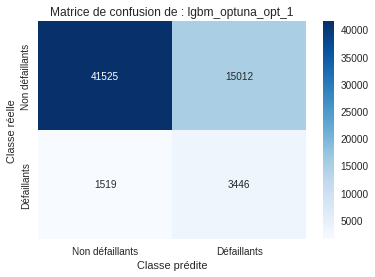

In [108]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_opt_1,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_optuna_opt_1')

In [109]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_optuna_opt_1',
                                        1519, 15012, 3446, 41525, df_taux)

Best hyperparamètres:

{'max_depth': 10, 'subsample': 0.9272920164356852, 'colsample_bytree': 0.624271596901296, 'lambda_l1': 0.3594315599980607, 'lambda_l2': 9.712199429465308e-07, 'num_leaves': 31, 'feature_fraction': 0.8906276235582508, 'bagging_fraction': 0.8078241529425154, 'bagging_freq': 7, 'min_child_samples': 57}

In [110]:
param_lgbm_optuna_opt_1_bis = {'objective' : 'binary',
                               'boosting_type' : 'gbdt',
                               'n_jobs' : -1,
                               'class_weight' : 'balanced', # Balanced                                 
                               'max_depth': 10,
                               'subsample': 0.6086603966773632,               
                               'colsample_bytree': 0.37379783978604425,                          
                               'reg_alpha': 0.3594315599980607,
                               'reg_lambda': 9.712199429465308e-07,
                               'num_leaves': 41,
                               'min_child_weight': 0.8906276235582508,
#                                'subsample':0.8078241529425154,
#                                'subsample_freq':7,
                               'min_child_samples': 97,
                               'verbosity' : -1}

In [111]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_optuna_opt_1_bis = LGBMClassifier(**param_lgbm_optuna_opt_1_bis,
                                       force_col_wise=True)

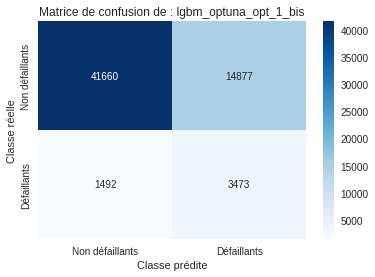

In [112]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_opt_1_bis,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_optuna_opt_1_bis')

In [113]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_optuna_opt_1_bis',
                                        1492, 14877, 3473, 41660, df_taux)

**Avec les hyperparamètres n_estimators et learning_rate**

In [114]:
# Modèle et hyperparamètres à étudier
def create_model_2(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 1000)
    max_depth = trial.suggest_int('max_depth', 3, 11)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 0.99)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
    num_leaves = trial.suggest_int('num_leaves', 2, 256),
    min_child_weight = trial.suggest_uniform('min_child_weight', 0.4, 1.0),
    subsample_freq = trial.suggest_int('subsample_freq', 1, 7),
    min_child_samples = trial.suggest_int('min_child_samples', 5, 100),
            
    model = LGBMClassifier(
        objective = 'binary',
        metric = 'auc',
        class_weight='balanced',
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        learning_rate=learning_rate,
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        num_leaves=num_leaves,
        min_child_weight=min_child_weight,
        subsample=subsample,
        subsample_freq=subsample_freq,
        min_child_samples=min_child_samples,
        random_state=seed,
        verbose=-1)
        
    return model

In [115]:
# Objective fonction
def objective_2(trial):
    model = create_model_2(trial)
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_valid)[:,1]
    score = roc_auc_score(y_valid, y_proba)
    return score

In [116]:
# Recherche des p
study_2 = optuna.create_study(direction='maximize')
study_2.optimize(objective_2, n_trials=100)

[I 2022-06-20 13:51:27,316] A new study created in memory with name: no-name-c51156c5-a2ae-4371-b9d6-c9497d7e976e
[I 2022-06-20 13:51:53,503] Trial 0 finished with value: 0.6440393150553976 and parameters: {'n_estimators': 890, 'max_depth': 8, 'learning_rate': 0.728756779143007, 'subsample': 0.3821859240685802, 'colsample_bytree': 0.27521354467650977, 'reg_alpha': 3.7689338192185684e-07, 'reg_lambda': 2.5972487291355255e-08, 'num_leaves': 194, 'min_child_weight': 0.7239821273132897, 'subsample_freq': 3, 'min_child_samples': 67}. Best is trial 0 with value: 0.6440393150553976.
[I 2022-06-20 13:52:15,098] Trial 1 finished with value: 0.6606870856310425 and parameters: {'n_estimators': 690, 'max_depth': 9, 'learning_rate': 0.8882455660565174, 'subsample': 0.35041031450156657, 'colsample_bytree': 0.8739598868778694, 'reg_alpha': 1.2023593882354739e-06, 'reg_lambda': 5.105382267811973e-07, 'num_leaves': 97, 'min_child_weight': 0.9358796381688084, 'subsample_freq': 6, 'min_child_samples': 26

In [117]:
params_2 = study_2.best_params
print(f'Nombre d\'essai terminés : {len(study_2.trials)}')
print('Best hyperparamètres:\n')
print(params_2)

Nombre d'essai terminés : 100
Best hyperparamètres:

{'n_estimators': 292, 'max_depth': 7, 'learning_rate': 0.04546579511804427, 'subsample': 0.8971033487101814, 'colsample_bytree': 0.5770673105607397, 'reg_alpha': 0.18118540689422238, 'reg_lambda': 2.0640359845839987e-05, 'num_leaves': 67, 'min_child_weight': 0.9691756840056109, 'subsample_freq': 4, 'min_child_samples': 94}


In [118]:
param_lgbm_optuna_opt_2 = {'objective' : 'binary',
                           'boosting_type' : 'gbdt',
                           'n_jobs' : -1,
                           'class_weight' : 'balanced', # Balanced        
                           'colsample_bytree': 0.5770673105607397,
                           'max_depth': 7,
                           'min_child_weight': 0.9691756840056109,
                           'num_leaves': 67,
                           'reg_alpha': 0.18118540689422238,
                           'reg_lambda': 2.0640359845839987e-05,
                           'subsample': 0.8971033487101814,
                           'subsample_freq': 4,
                           'min_child_samples': 94,
                           'n_estimators': 292,
                           'learning_rate': 0.04546579511804427,
                           'verbosity' : -1}

In [119]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_optuna_opt_2 = LGBMClassifier(**param_lgbm_optuna_opt_2,
                                   force_col_wise=True)

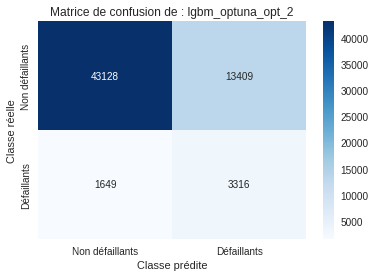

In [120]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_opt_2,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_optuna_opt_2')

In [121]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_optuna_opt_2',
                                        1649, 13409, 3316, 43128, df_taux)

#### <span style='background:Moccasin'>6.5.2. Optimisation LGBM : Optuna intégrée à LightGBM - Score Métrique métier</span>

**Sans les hyperparamètres n_estimators et learning_rate**

In [122]:
# Modèle et hyperparamètres à étudier
def create_model_3(trial):
    max_depth = trial.suggest_int('max_depth', 3, 11)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
    num_leaves = trial.suggest_int('num_leaves', 2, 256),
    min_child_weight = trial.suggest_uniform('min_child_weight', 0.4, 1.0),
    subsample_freq = trial.suggest_int('subsample_freq', 1, 7),
    min_child_samples = trial.suggest_int('min_child_samples', 5, 100),
            
    model = LGBMClassifier(
        objective = 'binary',
        metric = 'custom_score',
        class_weight='balanced',
        max_depth=max_depth, 
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        num_leaves=num_leaves,
        min_child_weight=min_child_weight,
        subsample=subsample,
        subsample_freq=subsample_freq,
        min_child_samples=min_child_samples,
        random_state=seed,
        verbose=-1)
        
    return model

In [123]:
# Objective fonction
def objective_3(trial):
    model = create_model_3(trial)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    score = outils_model.custom_score(y_valid, y_pred)
    return score

In [124]:
# Recherche des paramètres
study_3 = optuna.create_study(direction='maximize')
study_3.optimize(objective_3, n_trials=100)

[I 2022-06-20 14:31:17,074] A new study created in memory with name: no-name-50382830-669d-475c-a67f-6359d33c3828
[I 2022-06-20 14:31:21,211] Trial 0 finished with value: 0.706865334008328 and parameters: {'max_depth': 3, 'subsample': 0.2526952467531357, 'colsample_bytree': 0.3508648398948564, 'reg_alpha': 4.075116505870629e-07, 'reg_lambda': 1.6447656294908274e-08, 'num_leaves': 131, 'min_child_weight': 0.8302948913623234, 'subsample_freq': 4, 'min_child_samples': 59}. Best is trial 0 with value: 0.706865334008328.
[I 2022-06-20 14:31:27,488] Trial 1 finished with value: 0.7148330072379493 and parameters: {'max_depth': 4, 'subsample': 0.7461462547669838, 'colsample_bytree': 0.8315984794170701, 'reg_alpha': 0.000497270068580599, 'reg_lambda': 3.9670622760197906e-06, 'num_leaves': 58, 'min_child_weight': 0.49316169514480795, 'subsample_freq': 5, 'min_child_samples': 80}. Best is trial 1 with value: 0.7148330072379493.
[I 2022-06-20 14:31:32,077] Trial 2 finished with value: 0.7089176825

In [125]:
params_3 = study_3.best_params
print(f'Nombre d\'essai terminés : {len(study_3.trials)}')
print('Best hyperparamètres:\n')
print(params_3)

Nombre d'essai terminés : 100
Best hyperparamètres:

{'max_depth': 11, 'subsample': 0.9191953044591897, 'colsample_bytree': 0.9743479225542737, 'reg_alpha': 1.4943804912114853e-05, 'reg_lambda': 3.0215138303226945e-05, 'num_leaves': 250, 'min_child_weight': 0.9685226655317417, 'subsample_freq': 4, 'min_child_samples': 36}


In [126]:
param_lgbm_optuna_opt_3 = {'objective' : 'binary',
                           'boosting_type' : 'gbdt',
                           'n_jobs' : -1,
                           'class_weight' : 'balanced', # Balanced        
                           'colsample_bytree': 0.9743479225542737,
                           'max_depth': 11,
                           'min_child_weight': 0.9685226655317417,
                           'num_leaves': 250,
                           'reg_alpha': 1.4943804912114853e-05,
                           'reg_lambda': 3.0215138303226945e-05,
                           'subsample': 0.9191953044591897,
                           'subsample_freq': 4,
                           'min_child_samples': 36,
                           'verbosity' : -1}

In [127]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_optuna_opt_3 = LGBMClassifier(**param_lgbm_optuna_opt_3,
                                      force_col_wise=True)

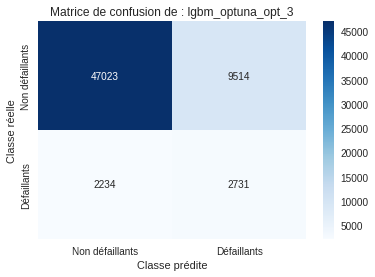

In [128]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_opt_3,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_optuna_opt_3')

In [129]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_optuna_opt_3',
                                        2234, 9514, 2731, 47023, df_taux)

#### <span style='background:Moccasin'>6.5.3. Optimisation LGBM : Optuna intégrée à LightGBM - Score PR_AUC</span>

**Sans les hyperparamètres n_estimators et learning_rate**

In [130]:
# Modèle et hyperparamètres à étudier
def create_model_4(trial):
    max_depth = trial.suggest_int('max_depth', 3, 11)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
    num_leaves = trial.suggest_int('num_leaves', 2, 256),
    min_child_weight = trial.suggest_uniform('min_child_weight', 0.4, 1.0),
    subsample_freq = trial.suggest_int('subsample_freq', 1, 7),
    min_child_samples = trial.suggest_int('min_child_samples', 5, 100),
            
    model = LGBMClassifier(
        objective = 'binary',
        metric = 'pr_auc',
        class_weight='balanced',
        max_depth=max_depth, 
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        num_leaves=num_leaves,
        min_child_weight=min_child_weight,
        subsample=subsample,
        subsample_freq=subsample_freq,
        min_child_samples=min_child_samples,
        random_state=seed,
        verbose=-1)
        
    return model

In [131]:
# Objective fonction
def objective_4(trial):
    model = create_model_3(trial)
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_valid)[:,1]
    score = average_precision_score(y_valid, y_proba)
    return score

In [132]:
# Recherche des paramètres
study_4 = optuna.create_study(direction='maximize')
study_4.optimize(objective_4, n_trials=100)

[I 2022-06-20 15:01:08,041] A new study created in memory with name: no-name-1ccc6544-6e96-411f-957a-a764a85ae255
[I 2022-06-20 15:01:13,731] Trial 0 finished with value: 0.2750000259200668 and parameters: {'max_depth': 8, 'subsample': 0.2843156106393715, 'colsample_bytree': 0.8822476846854591, 'reg_alpha': 0.0011672863280873323, 'reg_lambda': 1.0452118960747381e-08, 'num_leaves': 10, 'min_child_weight': 0.5165187361795662, 'subsample_freq': 1, 'min_child_samples': 8}. Best is trial 0 with value: 0.2750000259200668.
[I 2022-06-20 15:01:18,600] Trial 1 finished with value: 0.27118905348832756 and parameters: {'max_depth': 10, 'subsample': 0.3652269694468575, 'colsample_bytree': 0.6220296389785365, 'reg_alpha': 0.13730918319469188, 'reg_lambda': 1.4089505721364881e-08, 'num_leaves': 7, 'min_child_weight': 0.5364030214000736, 'subsample_freq': 3, 'min_child_samples': 51}. Best is trial 0 with value: 0.2750000259200668.
[I 2022-06-20 15:01:23,574] Trial 2 finished with value: 0.26692081360

In [133]:
params_4 = study_4.best_params
print(f'Nombre d\'essai terminés : {len(study_4.trials)}')
print('Best hyperparamètres:\n')
print(params_4)

Nombre d'essai terminés : 100
Best hyperparamètres:

{'max_depth': 8, 'subsample': 0.8689649551960289, 'colsample_bytree': 0.7072074790403408, 'reg_alpha': 1.8039975387313393e-05, 'reg_lambda': 0.03550413688829879, 'num_leaves': 41, 'min_child_weight': 0.44572337087134484, 'subsample_freq': 4, 'min_child_samples': 94}


In [134]:
param_lgbm_optuna_opt_4 = {'objective' : 'binary',
                           'boosting_type' : 'gbdt',
                           'n_jobs' : -1,
                           'class_weight' : 'balanced', # Balanced        
                           'colsample_bytree': 0.7072074790403408,
                           'max_depth': 8,
                           'min_child_weight': 0.44572337087134484,
                           'num_leaves': 41,
                           'reg_alpha': 1.8039975387313393e-05,
                           'reg_lambda': 0.03550413688829879,
                           'subsample': 0.8689649551960289,
                           'subsample_freq': 4,
                           'min_child_samples': 94,
                           'verbosity' : -1}

In [135]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_optuna_opt_4 = LGBMClassifier(**param_lgbm_optuna_opt_4,
                                      force_col_wise=True)

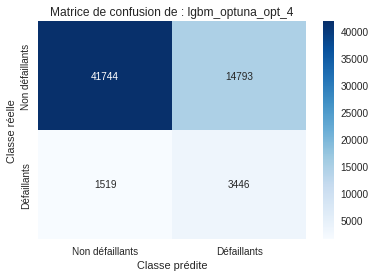

In [136]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_opt_4,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_optuna_opt_4')

In [137]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_optuna_opt_4',
                                        1519, 14793, 3446, 41744, df_taux)

#### <span style='background:Moccasin'>6.5.4. Optimisation LGBM : Optuna intégrée à LightGBM - Score F10</span>

**Sans les hyperparamètres n_estimators et learning_rate**

In [138]:
# Modèle et hyperparamètres à étudier
def create_model_5(trial):
    max_depth = trial.suggest_int('max_depth', 3, 11)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
    num_leaves = trial.suggest_int('num_leaves', 2, 256),
    min_child_weight = trial.suggest_uniform('min_child_weight', 0.4, 1.0),
    subsample_freq = trial.suggest_int('subsample_freq', 1, 7),
    min_child_samples = trial.suggest_int('min_child_samples', 5, 100),
            
    model = LGBMClassifier(
        objective = 'binary',
        metric = 'f10_score',
        class_weight='balanced',
        max_depth=max_depth, 
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        num_leaves=num_leaves,
        min_child_weight=min_child_weight,
        subsample=subsample,
        subsample_freq=subsample_freq,
        min_child_samples=min_child_samples,
        random_state=seed,
        verbose=-1)
        
    return model

In [139]:
# Objective fonction
def objective_5(trial):
    model = create_model_3(trial)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    score = fbeta_score(y_valid, y_pred, 10)
    return score

In [140]:
# Recherche des paramètres
study_5 = optuna.create_study(direction='maximize')
study_5.optimize(objective_5, n_trials=100)

[I 2022-06-20 15:30:43,380] A new study created in memory with name: no-name-fa6c54e6-cf7d-4bc4-a54b-a2346cb67fc8
[I 2022-06-20 15:30:51,660] Trial 0 finished with value: 0.5964049891383199 and parameters: {'max_depth': 10, 'subsample': 0.4065269564492697, 'colsample_bytree': 0.36566059924700434, 'reg_alpha': 2.6873613387633053e-08, 'reg_lambda': 7.722830658430598e-06, 'num_leaves': 179, 'min_child_weight': 0.4573011716176822, 'subsample_freq': 1, 'min_child_samples': 97}. Best is trial 0 with value: 0.5964049891383199.
[I 2022-06-20 15:31:00,525] Trial 1 finished with value: 0.6294744896266208 and parameters: {'max_depth': 9, 'subsample': 0.9843000566846198, 'colsample_bytree': 0.3603384604555898, 'reg_alpha': 2.9827065387242175, 'reg_lambda': 7.227395807553477e-08, 'num_leaves': 130, 'min_child_weight': 0.783605993119848, 'subsample_freq': 6, 'min_child_samples': 93}. Best is trial 1 with value: 0.6294744896266208.
[I 2022-06-20 15:31:05,219] Trial 2 finished with value: 0.6594113373

In [141]:
params_5 = study_5.best_params
print(f'Nombre d\'essai terminés : {len(study_5.trials)}')
print('Best hyperparamètres:\n')
print(params_5)

Nombre d'essai terminés : 100
Best hyperparamètres:

{'max_depth': 3, 'subsample': 0.18463058154981357, 'colsample_bytree': 0.6165561461232584, 'reg_alpha': 0.04036415503705408, 'reg_lambda': 6.380429879874343e-06, 'num_leaves': 225, 'min_child_weight': 0.816706751735683, 'subsample_freq': 4, 'min_child_samples': 80}


In [142]:
param_lgbm_optuna_opt_5 = {'objective' : 'binary',
                           'boosting_type' : 'gbdt',
                           'n_jobs' : -1,
                           'class_weight' : 'balanced', # Balanced        
                           'colsample_bytree': 0.6165561461232584,
                           'max_depth': 3,
                           'min_child_samples': 80,
                           'min_child_weight': 0.816706751735683,
                           'num_leaves': 225,
                           'reg_alpha': 0.04036415503705408,
                           'reg_lambda': 6.380429879874343e-06,
                           'subsample': 0.18463058154981357,
                           'subsample_freq': 4,
                           'verbosity' : -1}

In [143]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_optuna_opt_5 = LGBMClassifier(**param_lgbm_optuna_opt_5,
                                      force_col_wise=True)

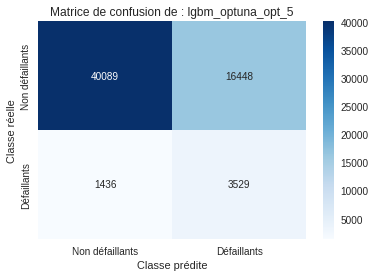

In [144]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_opt_5,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_optuna_opt_5')

In [145]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_optuna_opt_5',
                                        1436, 16448, 3529, 40089, df_taux)

#### <span style='background:Moccasin'>6.5.5. Optimisation LGBM : Optuna intégrée à LightGBM - Score F1</span>

**Sans les hyperparamètres n_estimators et learning_rate**

In [146]:
# Modèle et hyperparamètres à étudier
def create_model_F1(trial):
    max_depth = trial.suggest_int('max_depth', 3, 11)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
    num_leaves = trial.suggest_int('num_leaves', 2, 256),
    min_child_weight = trial.suggest_uniform('min_child_weight', 0.4, 1.0),
    subsample_freq = trial.suggest_int('subsample_freq', 1, 7),
    min_child_samples = trial.suggest_int('min_child_samples', 5, 100),
            
    model = LGBMClassifier(
        objective = 'binary',
        metric = 'f1_score',
        class_weight='balanced',
        max_depth=max_depth, 
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        num_leaves=num_leaves,
        min_child_weight=min_child_weight,
        subsample=subsample,
        subsample_freq=subsample_freq,
        min_child_samples=min_child_samples,
        random_state=seed,
        verbose=-1)
        
    return model

In [147]:
# Objective fonction
def objective_F1(trial):
    model = create_model_F1(trial)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    score = fbeta_score(y_valid, y_pred, 1)
    return score

In [148]:
# Recherche des paramètres
study_F1 = optuna.create_study(direction='maximize')
study_F1.optimize(objective_F1, n_trials=100)

[I 2022-06-20 15:43:49,646] A new study created in memory with name: no-name-01cbbd06-b559-481e-b143-02a2e4fea59d
[I 2022-06-20 15:43:57,716] Trial 0 finished with value: 0.2912640217549653 and parameters: {'max_depth': 11, 'subsample': 0.16505177675326294, 'colsample_bytree': 0.4999925752764066, 'reg_alpha': 1.1275191652601436e-07, 'reg_lambda': 3.196559677341122e-05, 'num_leaves': 122, 'min_child_weight': 0.9746918176447217, 'subsample_freq': 1, 'min_child_samples': 17}. Best is trial 0 with value: 0.2912640217549653.
[I 2022-06-20 15:44:02,394] Trial 1 finished with value: 0.2835455435847209 and parameters: {'max_depth': 4, 'subsample': 0.46738836497938696, 'colsample_bytree': 0.14290563722717975, 'reg_alpha': 0.3950172064538236, 'reg_lambda': 0.000344311094590611, 'num_leaves': 101, 'min_child_weight': 0.8379302310517077, 'subsample_freq': 2, 'min_child_samples': 29}. Best is trial 0 with value: 0.2912640217549653.
[I 2022-06-20 15:44:12,053] Trial 2 finished with value: 0.30273766

In [149]:
params_F1 = study_F1.best_params
print(f'Nombre d\'essai terminés : {len(study_F1.trials)}')
print('Best hyperparamètres:\n')
print(params_F1)

Nombre d'essai terminés : 100
Best hyperparamètres:

{'max_depth': 11, 'subsample': 0.8776899515359412, 'colsample_bytree': 0.9572271539673742, 'reg_alpha': 4.867191759553701e-05, 'reg_lambda': 2.0470742545914317e-06, 'num_leaves': 210, 'min_child_weight': 0.9445912084351472, 'subsample_freq': 1, 'min_child_samples': 80}


In [150]:
param_lgbm_optuna_opt_F1 = {'objective' : 'binary',
                            'boosting_type' : 'gbdt',
                            'n_jobs' : -1,
                            'class_weight' : 'balanced', # Balanced        
                            'colsample_bytree': 0.9572271539673742,
                            'max_depth': 11,
                            'min_child_samples': 80,
                            'min_child_weight': 0.9445912084351472,
                            'num_leaves': 210,
                            'reg_alpha': 4.867191759553701e-05,
                            'reg_lambda': 2.0470742545914317e-06,
                            'subsample': 0.8776899515359412,
                            'subsample_freq': 1,
                            'verbosity' : -1}

In [151]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_optuna_opt_F1 = LGBMClassifier(**param_lgbm_optuna_opt_F1,
                                    force_col_wise=True)

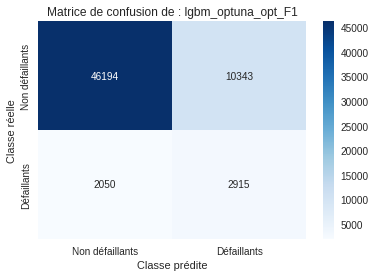

In [152]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_opt_F1,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_optuna_opt_F1')

In [153]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_optuna_opt_F1',
                                        2050, 10343, 2915, 46194, df_taux)

#### <span style='background:Moccasin'>6.5.6. Optimisation LGBM : Optuna intégrée à LightGBM - Score F5</span>

**Sans les hyperparamètres n_estimators et learning_rate**

In [154]:
# Modèle et hyperparamètres à étudier
def create_model_F5(trial):
    max_depth = trial.suggest_int('max_depth', 3, 11)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
    num_leaves = trial.suggest_int('num_leaves', 2, 256),
    min_child_weight = trial.suggest_uniform('min_child_weight', 0.4, 1.0),
    subsample_freq = trial.suggest_int('subsample_freq', 1, 7),
    min_child_samples = trial.suggest_int('min_child_samples', 5, 100),
            
    model = LGBMClassifier(
        objective = 'binary',
        metric = 'f5_score',
        class_weight='balanced',
        max_depth=max_depth, 
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        num_leaves=num_leaves,
        min_child_weight=min_child_weight,
        subsample=subsample,
        subsample_freq=subsample_freq,
        min_child_samples=min_child_samples,
        random_state=seed,
        verbose=-1)
        
    return model

In [155]:
# Objective fonction
def objective_F5(trial):
    model = create_model_F5(trial)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    score = fbeta_score(y_valid, y_pred, 5)
    return score

In [156]:
# Recherche des paramètres
study_F5 = optuna.create_study(direction='maximize')
study_F5.optimize(objective_F5, n_trials=100)

[I 2022-06-20 16:12:15,613] A new study created in memory with name: no-name-f229cfdd-bafe-4b30-b79c-8e48e62bcf6d
[I 2022-06-20 16:12:20,673] Trial 0 finished with value: 0.6361247651467357 and parameters: {'max_depth': 3, 'subsample': 0.675280672270897, 'colsample_bytree': 0.2475010350296185, 'reg_alpha': 0.028196199458513642, 'reg_lambda': 3.567228726260093e-08, 'num_leaves': 11, 'min_child_weight': 0.6161233857994786, 'subsample_freq': 2, 'min_child_samples': 82}. Best is trial 0 with value: 0.6361247651467357.
[I 2022-06-20 16:12:24,733] Trial 1 finished with value: 0.6275040606388739 and parameters: {'max_depth': 10, 'subsample': 0.4938323361254805, 'colsample_bytree': 0.13878283764204072, 'reg_alpha': 2.013343239609975e-06, 'reg_lambda': 0.14765989055869314, 'num_leaves': 6, 'min_child_weight': 0.8755655318587251, 'subsample_freq': 6, 'min_child_samples': 68}. Best is trial 0 with value: 0.6361247651467357.
[I 2022-06-20 16:12:32,283] Trial 2 finished with value: 0.60399674601209

In [157]:
params_F5 = study_F5.best_params
print(f'Nombre d\'essai terminés : {len(study_F5.trials)}')
print('Best hyperparamètres:\n')
print(params_F5)

Nombre d'essai terminés : 100
Best hyperparamètres:

{'max_depth': 4, 'subsample': 0.9077838896252034, 'colsample_bytree': 0.4350135811603948, 'reg_alpha': 4.513821368925364e-05, 'reg_lambda': 0.00013083257564163326, 'num_leaves': 232, 'min_child_weight': 0.47322576287064994, 'subsample_freq': 3, 'min_child_samples': 53}


In [158]:
param_lgbm_optuna_opt_F5 = {'objective' : 'binary',
                            'boosting_type' : 'gbdt',
                            'n_jobs' : -1,
                            'class_weight' : 'balanced', # Balanced        
                            'colsample_bytree': 0.4350135811603948,
                            'max_depth': 4,
                            'min_child_samples': 53,
                            'min_child_weight': 0.47322576287064994,
                            'num_leaves': 232,
                            'reg_alpha': 4.513821368925364e-05,
                            'reg_lambda': 0.00013083257564163326,
                            'subsample': 0.9077838896252034,
                            'subsample_freq': 3,
                            'verbosity' : -1}

In [159]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_optuna_opt_F5 = LGBMClassifier(**param_lgbm_optuna_opt_F5,
                                    force_col_wise=True)

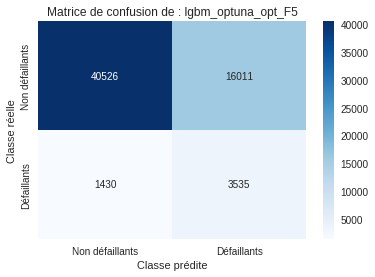

In [160]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_opt_F5,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_optuna_opt_F5')

In [161]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_optuna_opt_F5',
                                        1430, 16011, 3535, 40526, df_taux)

### <span style='background:PowderBlue'>6.6. Optimisation : rééquilibrage des classes</span>

**Répartition variable cible?**

In [162]:
# Jeu d'entraînement du jeu d'entraînement
# Répartition des la cible 0 (non-défaillants) - 1 (défaillants)?
y_train_distrib = Counter(y_train)
print('Répartition des classes : ')
print(y_train_distrib)
# Pourcentage
y_train_distrib_norm = y_train.value_counts(normalize=True)*100
print('\nRépartition des classes (en %) :')
print(y_train_distrib_norm)

Répartition des classes : 
Counter({0: 226145, 1: 19860})

Répartition des classes (en %) :
0    91.927
1     8.073
Name: TARGET, dtype: float64


In [163]:
# Jeu de validation du jeu d'entraînement
# Répartition des la cible 0 (non-défaillants) - 1 (défaillants)?
y_valid_distrib = Counter(y_valid)
print('Répartition des classes : ')
print(y_valid_distrib)
# Pourcentage
y_valid_distrib_norm = y_valid.value_counts(normalize=True)*100
print('\nRépartition des classes (en %) :')
print(y_valid_distrib_norm)

Répartition des classes : 
Counter({0: 56537, 1: 4965})

Répartition des classes (en %) :
0    91.9271
1     8.0729
Name: TARGET, dtype: float64


**Bilan** :
- La variable cible est fortement déséquilibrée 90% de non défaillants et 10% de défaillants ==> on tentera un rééquilibrage de la variable cible pour optimiser le modèle.

Plusieurs méthodes de réquilibrage sont à notre disposition :
- undersampling : consiste en un sous-échantillonnage de la classe majoritaire.
- oversampling : sur-échantillonnage de la classe minoritaire (ex : SMOTE, ADASYN).
- une combinaison d'oversampling suivi d'undersampling (possible avec SMOTE).
- hyperparamètre du modèle Ligthgbm : class_weight='balanced'.

[Source](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)

#### <span style='background:Moccasin'>6.6.1. Rééquilibrage - oversampling : SMOTE</span>

**SMOTE - paramètres par défaut**

In [164]:
# Répartition des classes au départ
counter_original = Counter(y_train)
print(counter_original)
# Application de l'oversampling via SMOTE avec les paramètres par défaut
oversample = SMOTE()
X_train_smote, y_train_smote = \
    oversample.fit_resample(X_train, y_train)
X_valid_smote, y_valid_smote = \
    oversample.fit_resample(X_valid, y_valid)
# Répartition après oversampling SMOTE paramètres par défaut
counter_smote_def = Counter(y_train_smote)
print(counter_smote_def)

Counter({0: 226145, 1: 19860})
Counter({0: 226145, 1: 226145})


#### <span style='background:LightGreen'>**Modèle LightGBM - hyperparamètres de base**</span>

In [165]:
# Initialisation du modèle avec les hyperparamètres de base
lgbm_smote_base = LGBMClassifier(random_state=seed, verbose=0,
                                 force_col_wise=True)

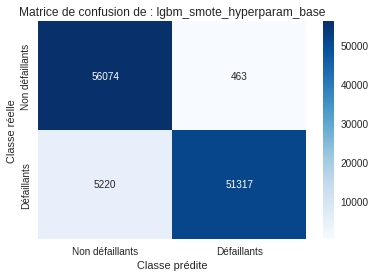

In [166]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_smote_base,
                                        X_train_smote, X_valid_smote,
                                        y_train_smote, y_valid_smote,
                                        df_resultats,
                                        'lgbm_smote_hyperparam_base')

In [167]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_smote_hyperparam_base',
                                        5220, 463, 51317, 56074, df_taux)

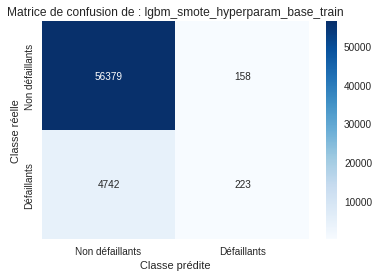

In [168]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_smote_base,
                                        X_train, X_valid,
                                        y_train, y_valid,
                                        df_resultats,
                                        'lgbm_smote_hyperparam_base_train')

In [169]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_smote_hyperparam_base_train',
                                        4742, 158, 223, 56379, df_taux)

#### <span style='background:LightGreen'>**Modèle LightGBM - hyperparamètres de base + class_weight='balanced'**</span>

In [170]:
# Initialisation du modèle avec les hyperparamètres de base
lgbm_smote_base_bal = LGBMClassifier(class_weight='balanced',
                                     random_state=seed, verbose=0,
                                     force_col_wise=True)

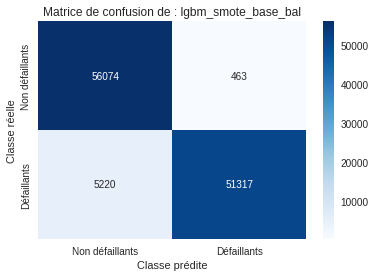

In [171]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_smote_base_bal,
                                        X_train_smote, X_valid_smote,
                                        y_train_smote, y_valid_smote,
                                        df_resultats,
                                        'lgbm_smote_base_bal')

In [172]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_smote_base_bal',
                                        5220, 463, 51317, 56074, df_taux)

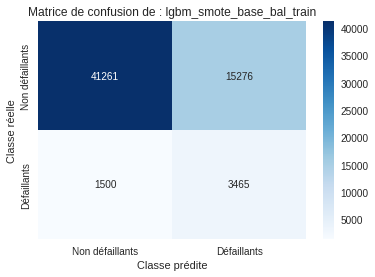

In [173]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_smote_base_bal,
                                        X_train, X_valid,
                                        y_train, y_valid,
                                        df_resultats,
                                        'lgbm_smote_base_bal_train')

In [174]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_smote_base_bal_train',
                                        1500, 15276, 3465, 41261, df_taux)

#### <span style='background:LightGreen'>**Optimisation des hyperparamètres - optuna - score ROC_AUC**</span>

In [175]:
# Modèle et hyperparamètres à étudier
def create_model_7(trial):
    max_depth = trial.suggest_int('max_depth', 3, 11)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
    num_leaves = trial.suggest_int('num_leaves', 2, 256),
    min_child_weight = trial.suggest_uniform('min_child_weight', 0.4, 1.0),
    subsample_freq = trial.suggest_int('subsample_freq', 1, 7),
    min_child_samples = trial.suggest_int('min_child_samples', 5, 100),
            
    model = LGBMClassifier(
        objective = 'binary',
        metric = 'auc',
        max_depth=max_depth, 
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        num_leaves=num_leaves,
        min_child_weight=min_child_weight,
        subsample=subsample,
        subsample_freq=subsample_freq,
        min_child_samples=min_child_samples,
        random_state=seed,
        verbose=-1)
        
    return model

In [176]:
# Objective fonction
def objective_7(trial):
    model = create_model_7(trial)
    model.fit(X_train_smote, y_train_smote)
    y_proba_smote = model.predict_proba(X_valid_smote)[:,1]
    score = roc_auc_score(y_valid_smote, y_proba_smote)
    return score

In [177]:
# Recherche des paramètres
study_7 = optuna.create_study(direction='maximize')
study_7.optimize(objective_7, n_trials=100)

[I 2022-06-20 16:45:13,531] A new study created in memory with name: no-name-44ecea2c-7f46-4324-b320-e2484d947175
[I 2022-06-20 16:45:23,304] Trial 0 finished with value: 0.9780400903580013 and parameters: {'max_depth': 10, 'subsample': 0.514271261052333, 'colsample_bytree': 0.12847708915706843, 'reg_alpha': 0.01488747284546934, 'reg_lambda': 0.21905864174648085, 'num_leaves': 139, 'min_child_weight': 0.7277699300561107, 'subsample_freq': 1, 'min_child_samples': 35}. Best is trial 0 with value: 0.9780400903580013.
[I 2022-06-20 16:45:35,476] Trial 1 finished with value: 0.9768487784325777 and parameters: {'max_depth': 6, 'subsample': 0.9292660920874379, 'colsample_bytree': 0.3453962905292308, 'reg_alpha': 3.84709109247289e-05, 'reg_lambda': 3.59711746089289e-06, 'num_leaves': 169, 'min_child_weight': 0.8169824498234743, 'subsample_freq': 3, 'min_child_samples': 43}. Best is trial 0 with value: 0.9780400903580013.
[I 2022-06-20 16:45:43,833] Trial 2 finished with value: 0.97419283361036

In [178]:
params_7 = study_7.best_params
print(f'Nombre d\'essai terminés : {len(study_7.trials)}')
print('Best hyperparamètres:\n')
print(params_7)

Nombre d'essai terminés : 100
Best hyperparamètres:

{'max_depth': 11, 'subsample': 0.8789193554803507, 'colsample_bytree': 0.936473010114947, 'reg_alpha': 2.063464618135947e-07, 'reg_lambda': 1.660261248365724, 'num_leaves': 171, 'min_child_weight': 0.4753614568575446, 'subsample_freq': 3, 'min_child_samples': 10}


In [179]:
param_lgbm_optuna_opt_7 = {'objective' : 'binary',
                           'boosting_type' : 'gbdt',
                           'n_jobs' : -1,    
                           'colsample_bytree': 0.936473010114947,
                           'max_depth': 11,
                           'min_child_samples': 10,
                           'min_child_weight': 0.4753614568575446,
                           'num_leaves': 171,
                           'reg_alpha': 2.063464618135947e-07,
                           'reg_lambda': 1.660261248365724,
                           'subsample': 0.8789193554803507,
                           'subsample_freq': 3,
                           'verbosity' : -1}

In [180]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_optuna_smote_opt_7 = LGBMClassifier(**param_lgbm_optuna_opt_7,
                                         force_col_wise=True)

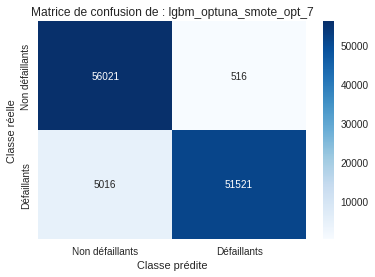

In [181]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_smote_opt_7,
                                        X_train_smote, X_valid_smote,
                                        y_train_smote, y_valid_smote,
                                        df_resultats,
                                        'lgbm_optuna_smote_opt_7')

In [182]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_optuna_smote_opt_7',
                                        5016, 516, 51521, 56021, df_taux)

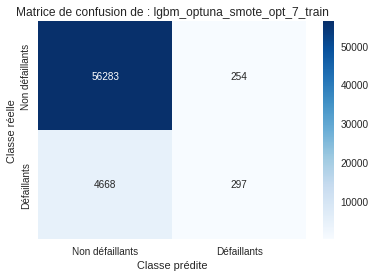

In [183]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_smote_opt_7,
                                        X_train, X_valid,
                                        y_train, y_valid,
                                        df_resultats,
                                        'lgbm_optuna_smote_opt_7_train')

In [184]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_optuna_smote_opt_7_train',
                                        4668, 254, 297, 56283, df_taux)

#### <span style='background:LightGreen'>**Optimisation des hyperparamètres - optuna - score F10**</span>

In [185]:
# Modèle et hyperparamètres à étudier
def create_model_6(trial):
    max_depth = trial.suggest_int('max_depth', 3, 11)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
    num_leaves = trial.suggest_int('num_leaves', 2, 256),
    min_child_weight = trial.suggest_uniform('min_child_weight', 0.4, 1.0),
    subsample_freq = trial.suggest_int('subsample_freq', 1, 7),
    min_child_samples = trial.suggest_int('min_child_samples', 5, 100),
            
    model = LGBMClassifier(
        objective = 'binary',
        metric = 'f10_score',
#         class_weight='balanced',
        max_depth=max_depth, 
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        num_leaves=num_leaves,
        min_child_weight=min_child_weight,
        subsample=subsample,
        subsample_freq=subsample_freq,
        min_child_samples=min_child_samples,
        random_state=seed,
        verbose=-1)
        
    return model

In [186]:
# Objective fonction
def objective_6(trial):
    model = create_model_6(trial)
    model.fit(X_train_smote, y_train_smote)
    y_pred_smote = model.predict(X_valid_smote)
    score = fbeta_score(y_valid_smote, y_pred_smote, 10)
    return score

In [187]:
# Recherche des paramètres
study_6 = optuna.create_study(direction='maximize')
study_6.optimize(objective_6, n_trials=100)

[I 2022-06-20 17:37:00,178] A new study created in memory with name: no-name-1760b5ed-ffdc-41fd-8b61-327a3f2c350c
[I 2022-06-20 17:37:09,240] Trial 0 finished with value: 0.9038563115276109 and parameters: {'max_depth': 5, 'subsample': 0.4592920369089768, 'colsample_bytree': 0.14834334729675672, 'reg_alpha': 5.779217722479271, 'reg_lambda': 3.095199781058209, 'num_leaves': 218, 'min_child_weight': 0.8818680863059756, 'subsample_freq': 1, 'min_child_samples': 50}. Best is trial 0 with value: 0.9038563115276109.
[I 2022-06-20 17:37:18,681] Trial 1 finished with value: 0.8988132375641964 and parameters: {'max_depth': 4, 'subsample': 0.5552196521028117, 'colsample_bytree': 0.8407240176576857, 'reg_alpha': 6.294442104735038e-08, 'reg_lambda': 0.00022012808253164525, 'num_leaves': 221, 'min_child_weight': 0.43867501483196514, 'subsample_freq': 7, 'min_child_samples': 22}. Best is trial 0 with value: 0.9038563115276109.
[I 2022-06-20 17:37:36,999] Trial 2 finished with value: 0.90979333426456

In [188]:
params_6 = study_6.best_params
print(f'Nombre d\'essai terminés : {len(study_6.trials)}')
print('Best hyperparamètres:\n')
print(params_6)

Nombre d'essai terminés : 100
Best hyperparamètres:

{'max_depth': 10, 'subsample': 0.53074202971397, 'colsample_bytree': 0.12700342465616354, 'reg_alpha': 0.0017258865765306733, 'reg_lambda': 0.05715071435415144, 'num_leaves': 180, 'min_child_weight': 0.7152703333828843, 'subsample_freq': 2, 'min_child_samples': 65}


In [189]:
param_lgbm_optuna_opt_6 = {'objective' : 'binary',
                           'boosting_type' : 'gbdt',
                           'n_jobs' : -1,    
                           'colsample_bytree': 0.12700342465616354,
                           'max_depth': 10,
                           'min_child_samples': 65,
                           'min_child_weight': 0.7152703333828843,
                           'num_leaves': 180,
                           'reg_alpha': 0.0017258865765306733,
                           'reg_lambda': 0.05715071435415144,
                           'subsample': 0.5824550271928287,
                           'subsample_freq': 2,
                           'verbosity' : -1}

In [190]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_optuna_smote_opt_6 = LGBMClassifier(**param_lgbm_optuna_opt_6,
                                         force_col_wise=True)

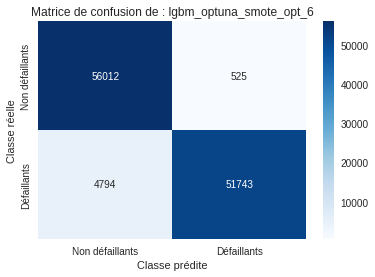

In [191]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_smote_opt_6,
                                        X_train_smote, X_valid_smote,
                                        y_train_smote, y_valid_smote,
                                        df_resultats,
                                        'lgbm_optuna_smote_opt_6')

In [192]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_optuna_smote_opt_6',
                                        4794, 525, 51743, 56012, df_taux)

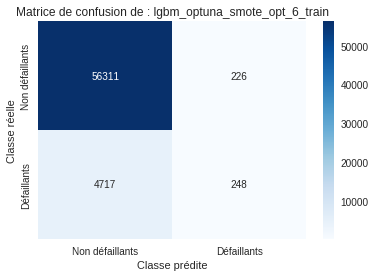

In [193]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_smote_opt_6,
                                        X_train, X_valid,
                                        y_train, y_valid,
                                        df_resultats,
                                        'lgbm_optuna_smote_opt_6_train')

In [194]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_optuna_smote_opt_6_train',
                                        4717, 226, 248, 56311, df_taux)

#### <span style='background:Moccasin'>6.6.2. Rééquilibrage - oversampling : SMOTE auto</span>

In [195]:
# Répartition des classes au départ
counter_original = Counter(y_train)
print(counter_original)
# Application de l'oversampling via SMOTE avec les paramètres par défaut
oversample = SMOTE(sampling_strategy='auto', k_neighbors=5, n_jobs=-1,
                   random_state=seed)
X_train_smote_1, y_train_smote_1 = \
    oversample.fit_resample(X_train, y_train)
X_valid_smote_1, y_valid_smote_1 = \
    oversample.fit_resample(X_valid, y_valid)
# Répartition après oversampling SMOTE paramètres par défaut
counter_smote_1 = Counter(y_train_smote_1)
print(counter_smote_1)

Counter({0: 226145, 1: 19860})
Counter({0: 226145, 1: 226145})


#### <span style='background:LightGreen'>**Modèle LightGBM - hyperparamètres de base**</span>

In [196]:
# Initialisation du modèle avec les hyperparamètres de base
lgbm_smote_base_1 = LGBMClassifier(random_state=seed, verbose=0,
                                   force_col_wise=True)

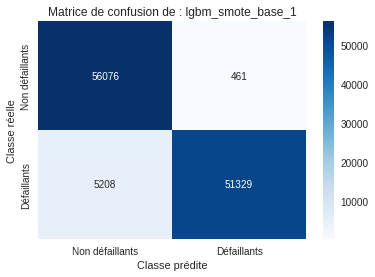

In [197]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_smote_base_1,
                                        X_train_smote_1, X_valid_smote_1,
                                        y_train_smote_1, y_valid_smote_1,
                                        df_resultats,
                                        'lgbm_smote_base_1')

In [198]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_smote_base_1',
                                        5208, 461, 51329, 56076, df_taux)

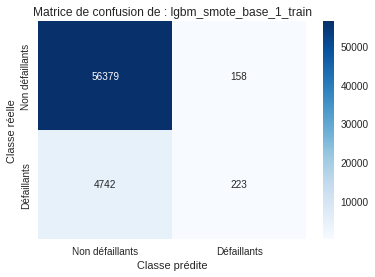

In [199]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_smote_base_1,
                                        X_train, X_valid,
                                        y_train, y_valid,
                                        df_resultats,
                                        'lgbm_smote_base_1_train')

In [200]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_smote_base_1_train',
                                        4742, 158, 223, 56379, df_taux)

#### <span style='background:LightGreen'>**Optimisation des hyperparamètres - optuna - score ROC_AUC**</span>

In [201]:
# Modèle et hyperparamètres à étudier
def create_model_8(trial):
    max_depth = trial.suggest_int('max_depth', 3, 11)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
    num_leaves = trial.suggest_int('num_leaves', 2, 256),
    min_child_weight = trial.suggest_uniform('min_child_weight', 0.4, 1.0),
    subsample_freq = trial.suggest_int('subsample_freq', 1, 7),
    min_child_samples = trial.suggest_int('min_child_samples', 5, 100),
            
    model = LGBMClassifier(
        objective = 'binary',
        metric = 'auc',
        max_depth=max_depth, 
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        num_leaves=num_leaves,
        min_child_weight=min_child_weight,
        subsample=subsample,
        subsample_freq=subsample_freq,
        min_child_samples=min_child_samples,
        random_state=seed,
        verbose=-1)
        
    return model

In [202]:
# Objective fonction
def objective_8(trial):
    model = create_model_8(trial)
    model.fit(X_train_smote_1, y_train_smote_1)
    y_proba_smote_1 = model.predict_proba(X_valid_smote_1)[:,1]
    score = roc_auc_score(y_valid_smote_1, y_proba_smote_1)
    return score

In [203]:
# Recherche des paramètres
study_8 = optuna.create_study(direction='maximize')
study_8.optimize(objective_8, n_trials=100)

[I 2022-06-20 18:16:25,850] A new study created in memory with name: no-name-fff882a1-2381-4598-8a66-e8b8cf15bfd8
[I 2022-06-20 18:16:36,371] Trial 0 finished with value: 0.9752590226006437 and parameters: {'max_depth': 9, 'subsample': 0.563834659750064, 'colsample_bytree': 0.9646666310898847, 'reg_alpha': 0.04893550744462354, 'reg_lambda': 2.3404311768336314, 'num_leaves': 10, 'min_child_weight': 0.8044437638386859, 'subsample_freq': 5, 'min_child_samples': 58}. Best is trial 0 with value: 0.9752590226006437.
[I 2022-06-20 18:16:43,305] Trial 1 finished with value: 0.9737399139696923 and parameters: {'max_depth': 9, 'subsample': 0.3671240977336886, 'colsample_bytree': 0.1451273654422766, 'reg_alpha': 5.848317960738412, 'reg_lambda': 0.009323991517342227, 'num_leaves': 11, 'min_child_weight': 0.46409091872810704, 'subsample_freq': 5, 'min_child_samples': 22}. Best is trial 0 with value: 0.9752590226006437.
[I 2022-06-20 18:16:51,703] Trial 2 finished with value: 0.9720547003070348 and 

In [204]:
params_8 = study_8.best_params
print(f'Nombre d\'essai terminés : {len(study_8.trials)}')
print('Best hyperparamètres:\n')
print(params_8)

Nombre d'essai terminés : 100
Best hyperparamètres:

{'max_depth': 11, 'subsample': 0.9035778110227983, 'colsample_bytree': 0.8051113444635857, 'reg_alpha': 2.0436442057797e-07, 'reg_lambda': 0.05453666037713956, 'num_leaves': 176, 'min_child_weight': 0.46922301863605553, 'subsample_freq': 4, 'min_child_samples': 44}


In [205]:
param_lgbm_optuna_opt_8 = {'objective' : 'binary',
                           'boosting_type' : 'gbdt',
                           'n_jobs' : -1,    
                           'colsample_bytree': 0.8051113444635857,
                           'max_depth': 11,
                           'min_child_samples': 44,
                           'min_child_weight': 0.46922301863605553,
                           'num_leaves': 176,
                           'reg_alpha': 2.0436442057797e-07,
                           'reg_lambda': 0.05453666037713956,
                           'subsample': 0.9035778110227983,
                           'subsample_freq': 4,
                           'verbosity' : -1}

In [206]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_optuna_smote_opt_8 = LGBMClassifier(**param_lgbm_optuna_opt_8,
                                         force_col_wise=True)

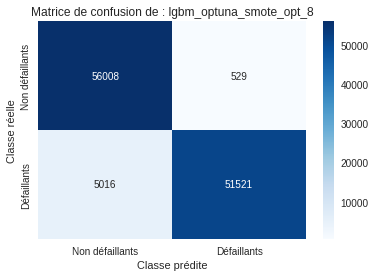

In [207]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_smote_opt_8,
                                        X_train_smote_1, X_valid_smote_1,
                                        y_train_smote_1, y_valid_smote_1,
                                        df_resultats,
                                        'lgbm_optuna_smote_opt_8')

In [208]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_optuna_smote_opt_8',
                                        5016, 529, 51521, 56008, df_taux)

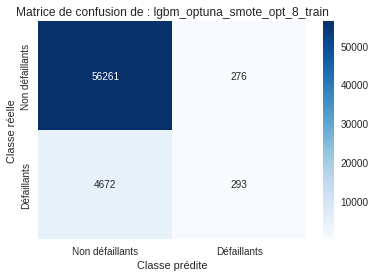

In [209]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_smote_opt_8,
                                        X_train, X_valid,
                                        y_train, y_valid,
                                        df_resultats,
                                        'lgbm_optuna_smote_opt_8_train')

In [210]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_optuna_smote_opt_8_train',
                                        4672, 276, 293, 56261, df_taux)

#### <span style='background:Moccasin'>6.6.3. Rééquilibrage - combinaison oversampling/undersampling : SMOTE</span>

In [211]:
# Répartition des classes au départ
counter_original = Counter(y_train)
print(counter_original)

# define pipeline
over = SMOTE(sampling_strategy=0.1, random_state=seed)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=seed)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# transform the dataset
X_train_smote_combi, y_train_smote_combi = \
    pipeline.fit_resample(X_train, y_train)
X_valid_smote_combi, y_valid_smote_combi = \
    pipeline.fit_resample(X_valid, y_valid)
# Répartition après oversampling SMOTE paramètres par défaut
counter_smote_combi = Counter(y_train_smote_combi)
print(counter_smote_combi)

Counter({0: 226145, 1: 19860})
Counter({0: 45228, 1: 22614})


#### <span style='background:LightGreen'>**Modèle LightGBM - hyperparamètres de base**</span>

In [212]:
# Initialisation du modèle avec les hyperparamètres de base
lgbm_smote_base_2 = LGBMClassifier(random_state=seed, verbose=0,
                                   force_col_wise=True)

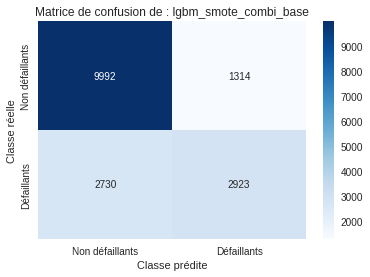

In [213]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_smote_base_2,
                                        X_train_smote_combi,
                                        X_valid_smote_combi,
                                        y_train_smote_combi,
                                        y_valid_smote_combi,
                                        df_resultats,
                                        'lgbm_smote_combi_base')

In [214]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_smote_combi_base',
                                        2730, 1314, 2923, 9992, df_taux)

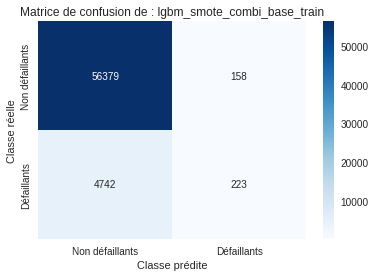

In [215]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_smote_base_2,
                                        X_train, X_valid,
                                        y_train, y_valid,
                                        df_resultats,
                                        'lgbm_smote_combi_base_train')

In [216]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_smote_combi_base_train',
                                        4742, 158, 223, 56379, df_taux)

#### <span style='background:LightGreen'>**Optimisation des hyperparamètres - optuna - score ROC_AUC**</span>

In [217]:
# Modèle et hyperparamètres à étudier
def create_model_9(trial):
    max_depth = trial.suggest_int('max_depth', 3, 11)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
    num_leaves = trial.suggest_int('num_leaves', 2, 256),
    min_child_weight = trial.suggest_uniform('min_child_weight', 0.4, 1.0),
    subsample_freq = trial.suggest_int('subsample_freq', 1, 7),
    min_child_samples = trial.suggest_int('min_child_samples', 5, 100),
            
    model = LGBMClassifier(
        objective = 'binary',
        metric = 'auc',
        max_depth=max_depth, 
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        num_leaves=num_leaves,
        min_child_weight=min_child_weight,
        subsample=subsample,
        subsample_freq=subsample_freq,
        min_child_samples=min_child_samples,
        random_state=seed,
        verbose=-1)
        
    return model

In [218]:
# Objective fonction
def objective_9(trial):
    model = create_model_9(trial)
    model.fit(X_train_smote_combi, y_train_smote_combi)
    y_proba_smote_combi = model.predict_proba(X_valid_smote_combi)[:,1]
    score = roc_auc_score(y_valid_smote_combi, y_proba_smote_combi)
    return score

In [219]:
# Recherche des paramètres
study_9 = optuna.create_study(direction='maximize')
study_9.optimize(objective_9, n_trials=100)

[I 2022-06-20 19:09:21,207] A new study created in memory with name: no-name-8c171fae-7570-45b1-80c2-2197b2842607
[I 2022-06-20 19:09:23,492] Trial 0 finished with value: 0.8050562721236919 and parameters: {'max_depth': 5, 'subsample': 0.8548348983047678, 'colsample_bytree': 0.7834010114160392, 'reg_alpha': 0.003669933602153954, 'reg_lambda': 1.8865151944317809e-06, 'num_leaves': 27, 'min_child_weight': 0.5522022358041119, 'subsample_freq': 6, 'min_child_samples': 14}. Best is trial 0 with value: 0.8050562721236919.
[I 2022-06-20 19:09:24,979] Trial 1 finished with value: 0.7924927516104829 and parameters: {'max_depth': 6, 'subsample': 0.11182320042573013, 'colsample_bytree': 0.3523616715353164, 'reg_alpha': 0.49064574763082874, 'reg_lambda': 3.306778963988076e-08, 'num_leaves': 51, 'min_child_weight': 0.7845855617983071, 'subsample_freq': 3, 'min_child_samples': 20}. Best is trial 0 with value: 0.8050562721236919.
[I 2022-06-20 19:09:27,063] Trial 2 finished with value: 0.802705444782

In [220]:
params_9 = study_9.best_params
print(f'Nombre d\'essai terminés : {len(study_9.trials)}')
print('Best hyperparamètres:\n')
print(params_9)

Nombre d'essai terminés : 100
Best hyperparamètres:

{'max_depth': 10, 'subsample': 0.8002147947613214, 'colsample_bytree': 0.7326960453052795, 'reg_alpha': 0.9582646668920498, 'reg_lambda': 0.0011990198263090435, 'num_leaves': 64, 'min_child_weight': 0.7250437733146622, 'subsample_freq': 3, 'min_child_samples': 50}


In [221]:
param_lgbm_optuna_opt_9 = {'objective' : 'binary',
                           'boosting_type' : 'gbdt',
                           'n_jobs' : -1,    
                           'colsample_bytree': 0.7326960453052795,
                           'max_depth': 10,
                           'min_child_samples': 50,
                           'min_child_weight': 0.7250437733146622,
                           'num_leaves': 64,
                           'reg_alpha': 0.9582646668920498,
                           'reg_lambda': 0.0011990198263090435,
                           'subsample': 0.8002147947613214,
                           'subsample_freq': 3,
                           'verbosity' : -1}

In [222]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_optuna_smote_opt_9 = LGBMClassifier(**param_lgbm_optuna_opt_9,
                                         force_col_wise=True)

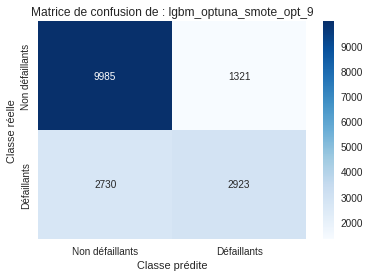

In [223]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_smote_opt_9,
                                        X_train_smote_combi,
                                        X_valid_smote_combi,
                                        y_train_smote_combi,
                                        y_valid_smote_combi,
                                        df_resultats,
                                        'lgbm_optuna_smote_opt_9')

In [224]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_optuna_smote_opt_9',
                                        2730, 1321, 2923, 9985, df_taux)

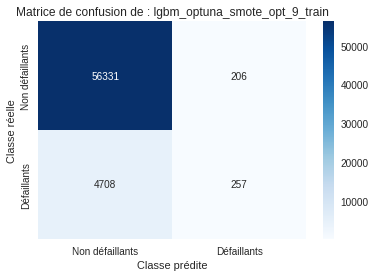

In [225]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_smote_opt_9,
                                        X_train, X_valid,
                                        y_train, y_valid,
                                        df_resultats,
                                        'lgbm_optuna_smote_opt_9_train')

In [226]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_optuna_smote_opt_9_train',
                                        4708, 206, 257, 56331, df_taux)

#### <span style='background:LightGreen'>**Optimisation des hyperparamètres - optuna - score F10**</span>

In [227]:
# Modèle et hyperparamètres à étudier
def create_model_10(trial):
    max_depth = trial.suggest_int('max_depth', 3, 11)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
    num_leaves = trial.suggest_int('num_leaves', 2, 256),
    min_child_weight = trial.suggest_uniform('min_child_weight', 0.4, 1.0),
    subsample_freq = trial.suggest_int('subsample_freq', 1, 7),
    min_child_samples = trial.suggest_int('min_child_samples', 5, 100),
            
    model = LGBMClassifier(
        objective = 'binary',
        metric = 'f10_score',
        max_depth=max_depth, 
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        num_leaves=num_leaves,
        min_child_weight=min_child_weight,
        subsample=subsample,
        subsample_freq=subsample_freq,
        min_child_samples=min_child_samples,
        random_state=seed,
        verbose=-1)
        
    return model

In [228]:
# Objective fonction
def objective_10(trial):
    model = create_model_10(trial)
    model.fit(X_train_smote_combi, y_train_smote_combi)
    y_pred_smote_combi = model.predict(X_valid_smote_combi)
    score = fbeta_score(y_valid_smote_combi, y_pred_smote_combi, 10)
    return score

In [229]:
# Recherche des paramètres
study_10 = optuna.create_study(direction='maximize')
study_10.optimize(objective_10, n_trials=100)

[I 2022-06-20 19:22:56,323] A new study created in memory with name: no-name-cdd5a244-8ba5-4acb-8dee-137302fc4f29
[I 2022-06-20 19:22:59,701] Trial 0 finished with value: 0.5157313985299333 and parameters: {'max_depth': 10, 'subsample': 0.7851737183183826, 'colsample_bytree': 0.4506963002952449, 'reg_alpha': 8.35021484058971e-05, 'reg_lambda': 8.25436854879929e-06, 'num_leaves': 81, 'min_child_weight': 0.4706474486591279, 'subsample_freq': 4, 'min_child_samples': 88}. Best is trial 0 with value: 0.5157313985299333.
[I 2022-06-20 19:23:02,939] Trial 1 finished with value: 0.5156951774947414 and parameters: {'max_depth': 4, 'subsample': 0.7787415027748297, 'colsample_bytree': 0.8522371311755813, 'reg_alpha': 0.00011625098625616477, 'reg_lambda': 2.0035987791976836e-06, 'num_leaves': 256, 'min_child_weight': 0.7664786505852113, 'subsample_freq': 5, 'min_child_samples': 62}. Best is trial 0 with value: 0.5157313985299333.
[I 2022-06-20 19:23:04,882] Trial 2 finished with value: 0.482421638

In [230]:
params_10 = study_10.best_params
print(f'Nombre d\'essai terminés : {len(study_10.trials)}')
print('Best hyperparamètres:\n')
print(params_10)

Nombre d'essai terminés : 100
Best hyperparamètres:

{'max_depth': 11, 'subsample': 0.9132230105328837, 'colsample_bytree': 0.8571074313160634, 'reg_alpha': 2.0068793674190615, 'reg_lambda': 4.428881471649659e-07, 'num_leaves': 125, 'min_child_weight': 0.6484956164953546, 'subsample_freq': 1, 'min_child_samples': 70}


In [231]:
param_lgbm_optuna_opt_10 = {'objective' : 'binary',
                            'boosting_type' : 'gbdt',
                            'n_jobs' : -1,    
                            'colsample_bytree': 0.8571074313160634,
                            'max_depth': 11,
                            'min_child_samples': 70,
                            'min_child_weight': 0.6484956164953546,
                            'num_leaves': 125,
                            'reg_alpha': 2.0068793674190615,
                            'reg_lambda': 4.428881471649659e-07,
                            'subsample': 0.9132230105328837,
                            'subsample_freq': 1,
                            'verbosity' : -1}

In [232]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_optuna_smote_opt_10 = LGBMClassifier(**param_lgbm_optuna_opt_10,
                                          force_col_wise=True)

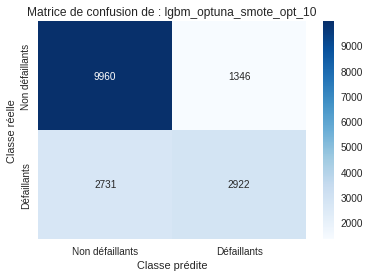

In [233]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_smote_opt_10,
                                        X_train_smote_combi,
                                        X_valid_smote_combi,
                                        y_train_smote_combi,
                                        y_valid_smote_combi,
                                        df_resultats,
                                        'lgbm_optuna_smote_opt_10')

In [234]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_optuna_smote_opt_10',
                                        2731, 1346, 2922, 9960, df_taux)

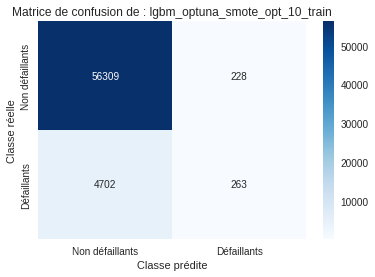

In [235]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_smote_opt_10,
                                        X_train, X_valid,
                                        y_train, y_valid,
                                        df_resultats,
                                        'lgbm_optuna_smote_opt_10_train')

In [236]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_optuna_smote_opt_10_train',
                                        4702, 228, 263, 56309, df_taux)

#### <span style='background:Moccasin'>6.6.4. Rééquilibrage - LigthGbm - BorderlineSMOTE</span>

In [237]:
# Répartition des classes au départ
counter_original = Counter(y_train)
print(counter_original)
# Application de l'oversampling via SMOTE avec les paramètres par défaut
oversample = BorderlineSMOTE(random_state=seed)
X_train_smote_2, y_train_smote_2 = \
    oversample.fit_resample(X_train, y_train)
X_valid_smote_2, y_valid_smote_2 = \
    oversample.fit_resample(X_valid, y_valid)
# Répartition après oversampling SMOTE paramètres par défaut
counter_smote_2 = Counter(y_train_smote_2)
print(counter_smote_2)

Counter({0: 226145, 1: 19860})
Counter({0: 226145, 1: 226145})


#### <span style='background:LightGreen'>**Modèle LightGBM - hyperparamètres de base**</span>

In [238]:
# Initialisation du modèle avec les hyperparamètres de base
lgbm_smote_bord_base_2 = LGBMClassifier(random_state=seed, verbose=0,
                                        force_col_wise=True) 

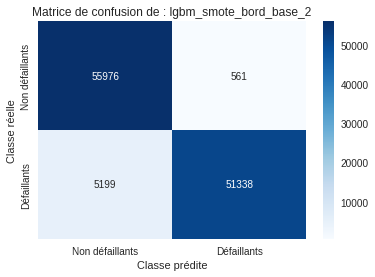

In [239]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_smote_bord_base_2,
                                        X_train_smote_2, X_valid_smote_2,
                                        y_train_smote_2, y_valid_smote_2,
                                        df_resultats,
                                        'lgbm_smote_bord_base_2')

In [240]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_smote_bord_base_2',
                                        5199, 561, 51338, 55976, df_taux)

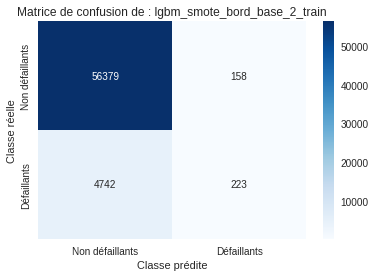

In [241]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_smote_bord_base_2,
                                        X_train, X_valid,
                                        y_train, y_valid,
                                        df_resultats,
                                        'lgbm_smote_bord_base_2_train')

In [242]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_smote_bord_base_2_train',
                                        4742, 158, 223, 56379, df_taux)

#### <span style='background:LightGreen'>**Optimisation des hyperparamètres - optuna - score ROC_AUC**</span>

In [243]:
# Modèle et hyperparamètres à étudier
def create_model_smote(trial):
    max_depth = trial.suggest_int('max_depth', 3, 11)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
    num_leaves = trial.suggest_int('num_leaves', 2, 256),
    min_child_weight = trial.suggest_uniform('min_child_weight', 0.4, 1.0),
    subsample_freq = trial.suggest_int('subsample_freq', 1, 7),
    min_child_samples = trial.suggest_int('min_child_samples', 5, 100),
            
    model = LGBMClassifier(
        objective = 'binary',
        metric = 'auc',
        max_depth=max_depth, 
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        num_leaves=num_leaves,
        min_child_weight=min_child_weight,
        subsample=subsample,
        subsample_freq=subsample_freq,
        min_child_samples=min_child_samples,
        random_state=seed,
        verbose=-1)
        
    return model

In [244]:
# Objective fonction
def objective_smote(trial):
    model = create_model_smote(trial)
    model.fit(X_train_smote_2, y_train_smote_2)
    y_proba_smote_2 = model.predict_proba(X_valid_smote_2)[:,1]
    score = roc_auc_score(y_valid_smote_2, y_proba_smote_2)
    return score

In [245]:
# Recherche des paramètres
study_smote = optuna.create_study(direction='maximize')
study_smote.optimize(objective_smote, n_trials=100)

[I 2022-06-20 19:48:14,912] A new study created in memory with name: no-name-b077c542-72b7-4b69-9db3-be62600d4ea0
[I 2022-06-20 19:48:23,853] Trial 0 finished with value: 0.9745340127357469 and parameters: {'max_depth': 5, 'subsample': 0.9263376224435208, 'colsample_bytree': 0.10587658368111877, 'reg_alpha': 0.287456752779189, 'reg_lambda': 0.00011777241625317812, 'num_leaves': 223, 'min_child_weight': 0.560369840112496, 'subsample_freq': 2, 'min_child_samples': 92}. Best is trial 0 with value: 0.9745340127357469.
[I 2022-06-20 19:48:31,921] Trial 1 finished with value: 0.9744598372261072 and parameters: {'max_depth': 4, 'subsample': 0.49781250190783954, 'colsample_bytree': 0.4001856221950697, 'reg_alpha': 1.2411914233276915e-05, 'reg_lambda': 0.8729088979039941, 'num_leaves': 160, 'min_child_weight': 0.4323016488200189, 'subsample_freq': 7, 'min_child_samples': 80}. Best is trial 0 with value: 0.9745340127357469.
[I 2022-06-20 19:48:42,691] Trial 2 finished with value: 0.9762351480554

In [246]:
params_smote = study_smote.best_params
print(f'Nombre d\'essai terminés : {len(study_smote.trials)}')
print('Best hyperparamètres:\n')
print(params_smote)

Nombre d'essai terminés : 100
Best hyperparamètres:

{'max_depth': 10, 'subsample': 0.8967169744326565, 'colsample_bytree': 0.7415054354086053, 'reg_alpha': 2.7456325509537635e-06, 'reg_lambda': 0.002433447957524254, 'num_leaves': 154, 'min_child_weight': 0.9855926934366233, 'subsample_freq': 4, 'min_child_samples': 71}


In [247]:
param_lgbm_optuna_opt_smote = {'objective' : 'binary',
                               'boosting_type' : 'gbdt',
                               'n_jobs' : -1,    
                               'colsample_bytree': 0.7415054354086053,
                               'max_depth': 10,
                               'min_child_samples': 71,
                               'min_child_weight': 0.9855926934366233,
                               'num_leaves': 154,
                               'reg_alpha': 2.7456325509537635e-06,
                               'reg_lambda': 0.002433447957524254,
                               'subsample': 0.8967169744326565,
                               'subsample_freq': 4,
                               'verbosity' : -1}

In [248]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_optuna_smote_opt_smote = LGBMClassifier(**param_lgbm_optuna_opt_smote,
                                             force_col_wise=True)

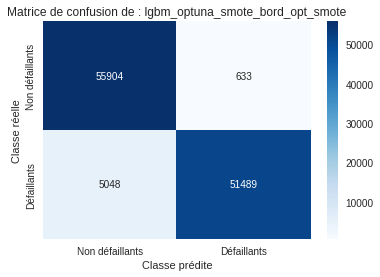

In [249]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_smote_opt_smote,
                                        X_train_smote_2, X_valid_smote_2,
                                        y_train_smote_2, y_valid_smote_2,
                                        df_resultats,
                                        'lgbm_optuna_smote_bord_opt_smote')

In [250]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_optuna_smote_bord_opt_smote',
                                        5048, 633, 51489, 55904, df_taux)

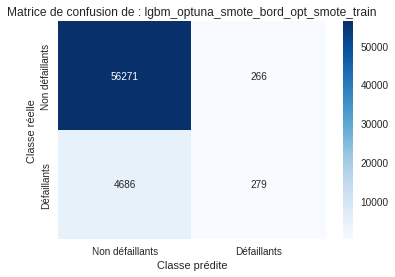

In [251]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_smote_opt_smote,
                                        X_train, X_valid,
                                        y_train, y_valid,
                                        df_resultats,
                                        'lgbm_optuna_smote_bord_opt_smote_train')

In [252]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_optuna_smote_bord_opt_smote_train',
                                        4686, 266, 279, 56271, df_taux)

#### <span style='background:Moccasin'>6.6.5. Rééquilibrage - LigthGbm - ADASYN</span>

In [253]:
# Répartition des classes au départ
counter_original = Counter(y_train)
print(counter_original)
# Application de l'oversampling via SMOTE avec les paramètres par défaut
oversample = ADASYN(random_state=seed)
X_train_smote_3, y_train_smote_3 = \
    oversample.fit_resample(X_train, y_train)
X_valid_smote_3, y_valid_smote_3 = \
    oversample.fit_resample(X_valid, y_valid)
# Répartition après oversampling SMOTE paramètres par défaut
counter_smote_3 = Counter(y_train_smote_3)
print(counter_smote_3)

Counter({0: 226145, 1: 19860})
Counter({1: 229580, 0: 226145})


#### <span style='background:LightGreen'>**Modèle LightGBM - hyperparamètres de base**</span>

In [254]:
# Initialisation du modèle avec les hyperparamètres de base
lgbm_smote_adasyn = LGBMClassifier(random_state=seed, verbose=0,
                                   force_col_wise=True) 

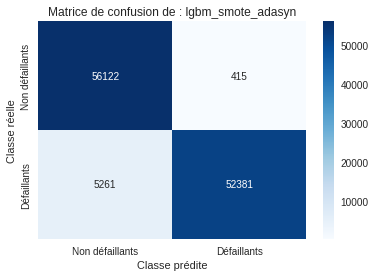

In [255]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_smote_adasyn,
                                        X_train_smote_3, X_valid_smote_3,
                                        y_train_smote_3, y_valid_smote_3,
                                        df_resultats,
                                        'lgbm_smote_adasyn')

In [256]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_smote_adasyn',
                                        5261, 415, 52381, 56122, df_taux)

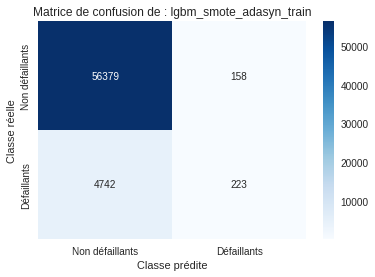

In [257]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_smote_adasyn,
                                        X_train, X_valid,
                                        y_train, y_valid,
                                        df_resultats,
                                        'lgbm_smote_adasyn_train')

In [258]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_smote_adasyn_train',
                                        4742, 158, 223, 56379, df_taux)

#### <span style='background:LightGreen'>**Optimisation des hyperparamètres - optuna - score ROC_AUC**</span>

In [259]:
# Modèle et hyperparamètres à étudier
def create_model_adasyn(trial):
    max_depth = trial.suggest_int('max_depth', 3, 11)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
    num_leaves = trial.suggest_int('num_leaves', 2, 256),
    min_child_weight = trial.suggest_uniform('min_child_weight', 0.4, 1.0),
    subsample_freq = trial.suggest_int('subsample_freq', 1, 7),
    min_child_samples = trial.suggest_int('min_child_samples', 5, 100),
            
    model = LGBMClassifier(
        objective = 'binary',
        metric = 'auc',
        max_depth=max_depth, 
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        num_leaves=num_leaves,
        min_child_weight=min_child_weight,
        subsample=subsample,
        subsample_freq=subsample_freq,
        min_child_samples=min_child_samples,
        random_state=seed,
        verbose=-1)
        
    return model

In [260]:
# Objective fonction
def objective_adasyn(trial):
    model = create_model_adasyn(trial)
    model.fit(X_train_smote_3, y_train_smote_3)
    y_proba_smote_3 = model.predict_proba(X_valid_smote_3)[:,1]
    score = roc_auc_score(y_valid_smote_3, y_proba_smote_3)
    return score

In [261]:
# Recherche des paramètres
study_adasyn = optuna.create_study(direction='maximize')
study_adasyn.optimize(objective_adasyn, n_trials=100)

[I 2022-06-20 20:48:06,198] A new study created in memory with name: no-name-3585a8e6-1d8c-42e8-ad8a-234c7872a5a1
[I 2022-06-20 20:48:14,239] Trial 0 finished with value: 0.9719502047925748 and parameters: {'max_depth': 3, 'subsample': 0.4268701937057756, 'colsample_bytree': 0.44064123453727966, 'reg_alpha': 3.183683054718131e-05, 'reg_lambda': 1.3662402894178959e-05, 'num_leaves': 18, 'min_child_weight': 0.6023071835207265, 'subsample_freq': 3, 'min_child_samples': 73}. Best is trial 0 with value: 0.9719502047925748.
[I 2022-06-20 20:48:30,013] Trial 1 finished with value: 0.9785746541107245 and parameters: {'max_depth': 8, 'subsample': 0.7097023794482206, 'colsample_bytree': 0.9761288833187268, 'reg_alpha': 7.61809592425096e-06, 'reg_lambda': 4.523135546780855e-06, 'num_leaves': 42, 'min_child_weight': 0.4530885455959156, 'subsample_freq': 3, 'min_child_samples': 70}. Best is trial 1 with value: 0.9785746541107245.
[I 2022-06-20 20:48:46,458] Trial 2 finished with value: 0.9787373160

In [262]:
params_adasyn = study_adasyn.best_params
print(f'Nombre d\'essai terminés : {len(study_adasyn.trials)}')
print('Best hyperparamètres:\n')
print(params_adasyn)

Nombre d'essai terminés : 100
Best hyperparamètres:

{'max_depth': 11, 'subsample': 0.972694942332461, 'colsample_bytree': 0.7875889101253444, 'reg_alpha': 1.8741565805306722e-07, 'reg_lambda': 2.1698617351269486e-07, 'num_leaves': 137, 'min_child_weight': 0.9558751540541132, 'subsample_freq': 5, 'min_child_samples': 62}


In [263]:
param_lgbm_optuna_adasyn = {'objective' : 'binary',
                            'boosting_type' : 'gbdt',
                            'n_jobs' : -1,    
                            'colsample_bytree': 0.7875889101253444,
                            'max_depth': 11,
                            'min_child_samples': 62,
                            'min_child_weight': 0.9558751540541132,
                            'num_leaves': 137,
                            'reg_alpha': 1.8741565805306722e-07,
                            'reg_lambda': 2.1698617351269486e-07,
                            'subsample': 0.972694942332461,
                            'subsample_freq': 5,
                            'verbosity' : -1}

In [264]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_optuna_adasyn = LGBMClassifier(**param_lgbm_optuna_adasyn,
                                    force_col_wise=True)

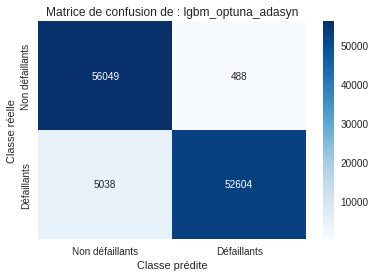

In [265]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_adasyn,
                                        X_train_smote_3, X_valid_smote_3,
                                        y_train_smote_3, y_valid_smote_3,
                                        df_resultats,
                                        'lgbm_optuna_adasyn')

In [266]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_optuna_adasyn',
                                        5038, 488, 52604, 56049, df_taux)

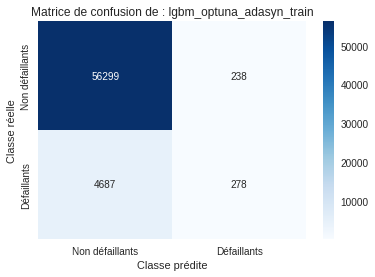

In [267]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = \
    outils_model.process_classification(lgbm_optuna_adasyn,
                                        X_train, X_valid,
                                        y_train, y_valid,
                                        df_resultats,
                                        'lgbm_optuna_adasyn_train')

In [268]:
# Sauvegarde
df_taux = outils_model.sauvegarder_taux('lgbm_optuna_adasyn_train',
                                        4687, 238, 278, 56299, df_taux)

### <span style='background:PowderBlue'>6.7. Bilan - Modélisations</span>

**Les différents taux des matrices de confusion**

In [269]:
df_taux_comp1 = df_taux.sort_values(by='Modèle')

In [270]:
modeles = ['lgbm_bayesian_opt_1', 'lgbm_bayesian_opt_1_bal',
           'lgbm_bayesian_opt_1_bis', 'lgbm_bayesian_opt_1_bis_bal',
           'lgbm_bayesian_opt_2', 'lgbm_bayesian_opt_3',
           'lgbm_bayesian_opt_4', 'lgbm_bayesian_opt_5',
           'lgbm_bayesian_opt_6', 'lgbm_bayesian_opt_7',
           'lgbm_bayesian_opt_8', 'lgbm_bayesian_opt_9',
           'lgbm_baysearch_opt_1', 'lgbm_baysearch_opt_2',
           'lgbm_baysearch_opt_3', 'lgbm_baysearch_opt_4',
           'lgbm_hyperparam_base', 'lgbm_hyperparam_base_bal',
           'lgbm_hyperparam_base_minmax', 'lgbm_hyperparam_base_robust',
           'lgbm_hyperparam_base_std', 'lgbm_hyperparam_base_std_bal',
           'lgbm_optuna_adasyn', 'lgbm_optuna_adasyn_train',
           'lgbm_optuna_opt_1', 'lgbm_optuna_opt_1_bis',
           'lgbm_optuna_opt_2', 'lgbm_optuna_opt_3',
           'lgbm_optuna_opt_4', 'lgbm_optuna_opt_5',
           'lgbm_optuna_opt_F1', 'lgbm_optuna_opt_F5',
           'lgbm_optuna_smote_bord_opt_smote',
           'lgbm_optuna_smote_bord_opt_smote_train',
           'lgbm_optuna_smote_opt_10', 'lgbm_optuna_smote_opt_10_train',
           'lgbm_optuna_smote_opt_6', 'lgbm_optuna_smote_opt_6_train',
           'lgbm_optuna_smote_opt_7', 'lgbm_optuna_smote_opt_7_train',
           'lgbm_optuna_smote_opt_8', 'lgbm_optuna_smote_opt_8_train',
           'lgbm_optuna_smote_opt_9', 'lgbm_optuna_smote_opt_9_train',
           'lgbm_smote_adasyn', 'lgbm_smote_adasyn_train',
           'lgbm_smote_base_1', 'lgbm_smote_base_1_train',
           'lgbm_smote_base_bal', 'lgbm_smote_base_bal_train',
           'lgbm_smote_bord_base_2', 'lgbm_smote_bord_base_2_train',
           'lgbm_smote_combi_base', 'lgbm_smote_combi_base_train',
           'lgbm_smote_hyperparam_base',
           'lgbm_smote_hyperparam_base_train',
           'pycaret_lgbm_hyperopt']

In [271]:
jeu_donnees = ['train', 'train', 'train', 'train', 'train', 'train',
               'train', 'train', 'train', 'train', 'train', 'train',
               'train', 'train', 'train', 'train', 'train', 'train',
               'train', 'train', 'train', 'train', 'augmente',
               'train', 'train', 'train', 'train', 'train', 'train',
               'train', 'train', 'train', 'augmente', 'train', 'reduit',
               'train', 'augmente', 'train', 'augmente', 'train',
               'augmente', 'train', 'reduit', 'train', 'reduit', 'train',
               'augmente', 'train', 'augmente', 'train', 'augmente',
               'train', 'reduit', 'train', 'augmente', 'train', 'train']

In [272]:
df_taux_comp2 = pd.DataFrame({'Modèle' : modeles,
                              'Jeu_donnees' : jeu_donnees})

In [273]:
# Dataframe de sauvegarde des taux des différentes modélisations
df_taux_comp = df_taux_comp2.merge(df_taux_comp1, on='Modèle',
                                   how='right')

In [274]:
# Tri par Faux Négatifs décroissant (les clients prédits non défaillants
# qui sont défaillants ==> la banque perd le montant du prêt en totalité
# ou en partie) pour le train set
mask = df_taux_comp['Jeu_donnees'] == 'train'
df_taux_comp[mask].sort_values(by='FN').style \
    .highlight_min(subset=['FN', 'FP', 'TN', 'TP'], color='lightgreen',
                   axis=0)

**Constitution des dataframes de comparaison pour les résultats**

In [275]:
df_resultats_comp1 = df_resultats.sort_values(by='Modèle')

In [280]:
metrique = ['roc_auc', 'roc_auc', 'roc_auc', 'roc_auc', 'roc_auc',
            'roc_auc', 'roc_auc',
            'custom', 'custom', 'pr_auc', 'F10', 'roc_auc', 'roc_auc',
            'custom', 'pr_auc', 'F10', 'logloss', 'logloss', 'logloss', 
            'logloss', 'logloss',  'logloss', 'logloss', 'roc_auc',
            'roc_auc', 'roc_auc',  'roc_auc', 'custom', 'pr_auc',
            'F10', 'F1', 'F5', 'roc_auc', 'roc_auc', 'F10', 'F10', 'F10',
            'F10', 'roc_auc', 'roc_auc', 'roc_auc', 'roc_auc', 'roc_auc',
            'roc_auc', 'logloss', 'logloss', 'logloss', 'logloss',
            'logloss', 'logloss', 'logloss', 'logloss', 'logloss',
            'logloss', 'logloss', 'logloss', 'roc_auc']

In [281]:
optimisation = ['bayes_opt', 'bayes_opt', 'bayes_opt', 'bayes_opt',
                'bayes_opt', 'bayes_opt', 'bayes_opt', 'bayes_opt',
                'bayes_opt', 'bayes_opt',
                'bayes_opt', 'bayes_opt', 'skopt', 'skopt', 'skopt',
                'skopt', 'aucune', 'aucune', 'minmax', 'robust',
                'std', 'std', 'optuna', 'optuna', 'optuna', 'optuna',
                'optuna', 'optuna', 'optuna', 'optuna', 'optuna', 'optuna',
                'optuna', 'optuna', 'optuna', 'optuna', 'optuna', 'optuna',
                'optuna', 'optuna', 'optuna', 'optuna', 'optuna', 'optuna',
                'smoteover', 'smoteover', 'smoteover', 'smoteover',
                'smoteover', 'smoteover', 'borderlinesmote',
                'borderlinesmote', 'smoteoverunder', 'smoteoverunder',
                'smoteover', 'smoteover', 'hyperopt']

In [282]:
class_weight = ['non', 'oui', 'non', 'oui', 'non', 'oui', 'oui', 'oui',
                'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui',
                'non', 'oui', 'non', 'non', 'non', 'oui', 'non', 'non',
                'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'oui', 'non',
                'non', 'non', 'non', 'non', 'non', 'non', 'non', 'non',
                'non', 'non', 'non', 'non', 'non', 'non', 'non', 'non',
                'non', 'non', 'non', 'non', 'non', 'non', 'non', 'non',
                'oui']

In [283]:
df_resultats_comp2 = pd.DataFrame({'Modèle' : modeles,
                                   'Metrique' : metrique,
                                   'Optimisation' : optimisation,
                                   'Class_weight' : class_weight})

In [284]:
# Dataframe de sauvegarde des résultats de la modélisation
df_resultats_comp = \
    df_resultats_comp2.merge(df_resultats_comp1, on='Modèle', how='left')

In [285]:
# Dataframe de recueil de tous les résultats
df_comparaison = \
    df_taux_comp.merge(df_resultats_comp, on='Modèle', how='left')

In [286]:
# Les vraies répartition de la TARGET dans le jeu de validation
Counter(y_valid)

Counter({0: 56537, 1: 4965})

- Nombre de vrais non-défaillants : 56537 (TN).
- Nombre de vrais défaillants : 4965 (TP).

In [287]:
df_comp = df_comparaison.sort_values(by='FN')
df_comp.style.highlight_min(subset=['FN', 'FP', 'TN', 'TP'],
                            color='lightgreen', axis=0).hide_index()

In [288]:
df_comp.head(4).style.highlight_min(subset=['FN', 'FP', 'TN', 'TP'],
                            color='lightgreen', axis=0).hide_index()

**Bilan des taux FN, FP, TN et TP**

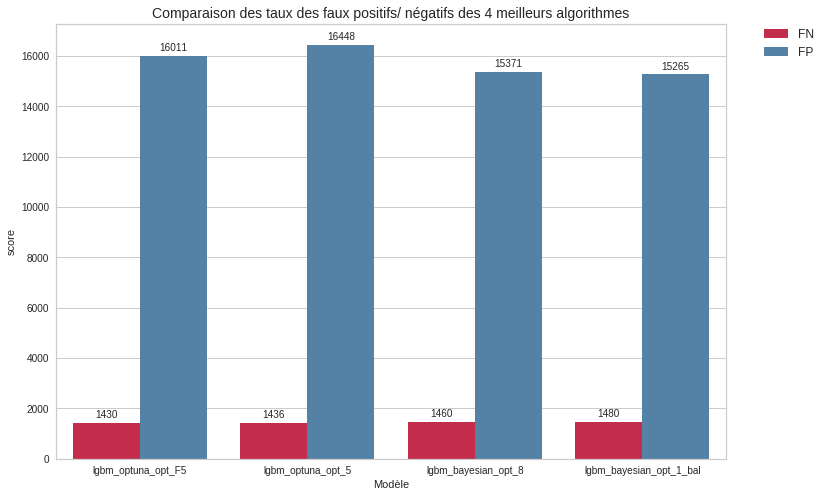

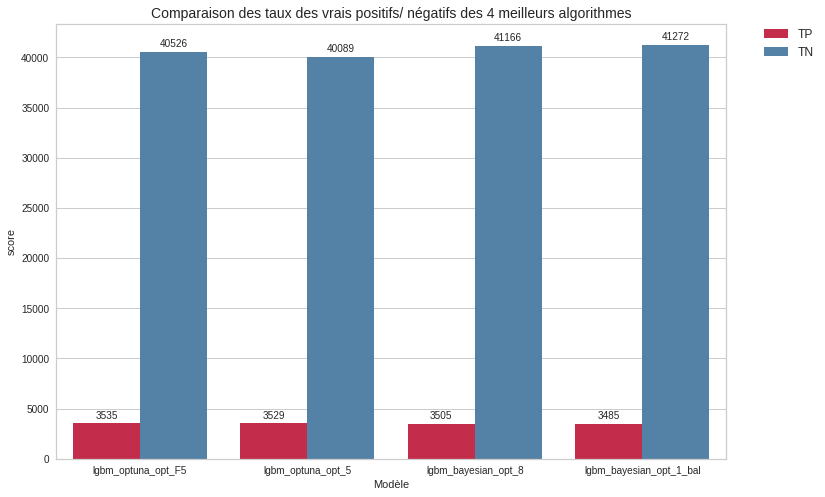

In [289]:
# Comparaison visuelle des 4 algorithmes les plus performants
df_comp_best = df_comp[df_comp['Modèle'].isin(
    ['lgbm_optuna_opt_5', 'lgbm_bayesian_opt_8',
     'lgbm_optuna_opt_F5', 'lgbm_bayesian_opt_1_bal'])]

# Renseignements sur les modèles
df_comp_display = df_comp_best[['Modèle', 'Metrique', 'Optimisation',
                               'Class_weight']].style.hide_index()
display(df_comp_display)

# Faux négatifs/Faux positifs
comparaison_taux_melt_false = \
    pd.melt(df_comp_best, id_vars=['Modèle'], value_name='score',
            value_vars=['FN', 'FP'])
# Visualisation
plt.figure(figsize=(12, 8))
ax= sns.barplot(x=comparaison_taux_melt_false['Modèle'],
                y=comparaison_taux_melt_false['score'],
            hue=comparaison_taux_melt_false['variable'],
            palette=['Crimson', 'SteelBlue', 'Crimson', 'SteelBlue'])
plt.title('Comparaison des taux des faux positifs/ négatifs des 4 meilleurs algorithmes', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+ p.get_width()/2.,
            height + 200,
            int(height),
            ha="center") 
plt.show()

# Vrais négatifs/Vrais positifs
comparaison_taux_melt_true = \
    pd.melt(df_comp_best, id_vars=['Modèle'], value_name='score',
            value_vars=['TP', 'TN'])
# Visualisation
plt.figure(figsize=(12, 8))
total = float(len(comparaison_taux_melt_true))
ax = sns.barplot(x=comparaison_taux_melt_true['Modèle'],
                 y=comparaison_taux_melt_true['score'],
                 hue=comparaison_taux_melt_true['variable'],
                 palette=['Crimson', 'SteelBlue', 'Crimson', 'SteelBlue'])
plt.title('Comparaison des taux des vrais positifs/ négatifs des 4 meilleurs algorithmes', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+ p.get_width()/2.,
            height + 500,
            int(height),
            ha="center") 
plt.show()

**Bilan** :
***
- Le modèle **lgbm_otuna_opt_5** (LightGBM class_weight='balanced' avec une optimisation bayésienne, la métrique F10-score) détecte :
    - le moins de faux négatifs (des clients détectés non défaillants mais qui ne remboursent pas le prêt) 
    - et le plus de vrais positifs (des clients détéctés défaillants qui sont défaillants),
- Ce modèle détecte un peu plus de faux positifs (des clients qui sont détectés défaillants mais qui ne sont pas défaillants et rembourseraient leur prêt) que le modèle **lgbm_bayesian_opt_1_bal** (LightGBM class_weight='balanced' sans optimisation bayésienne ou optuna avec la métrique par défaut logloss). Mais nous n'avons aucune consigne de notre client sur le niveau de détection des faux positifs.

On peut désormais tenter d'optimiser ce modèle **lgbm_otuna_opt_5** en recherchant le seuil de probabilité optimal ayant un impact sur la décision de classer en classe 0 (non-défaillant) ou 1 (défaillant).

**Bilan des différentes métriques**

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


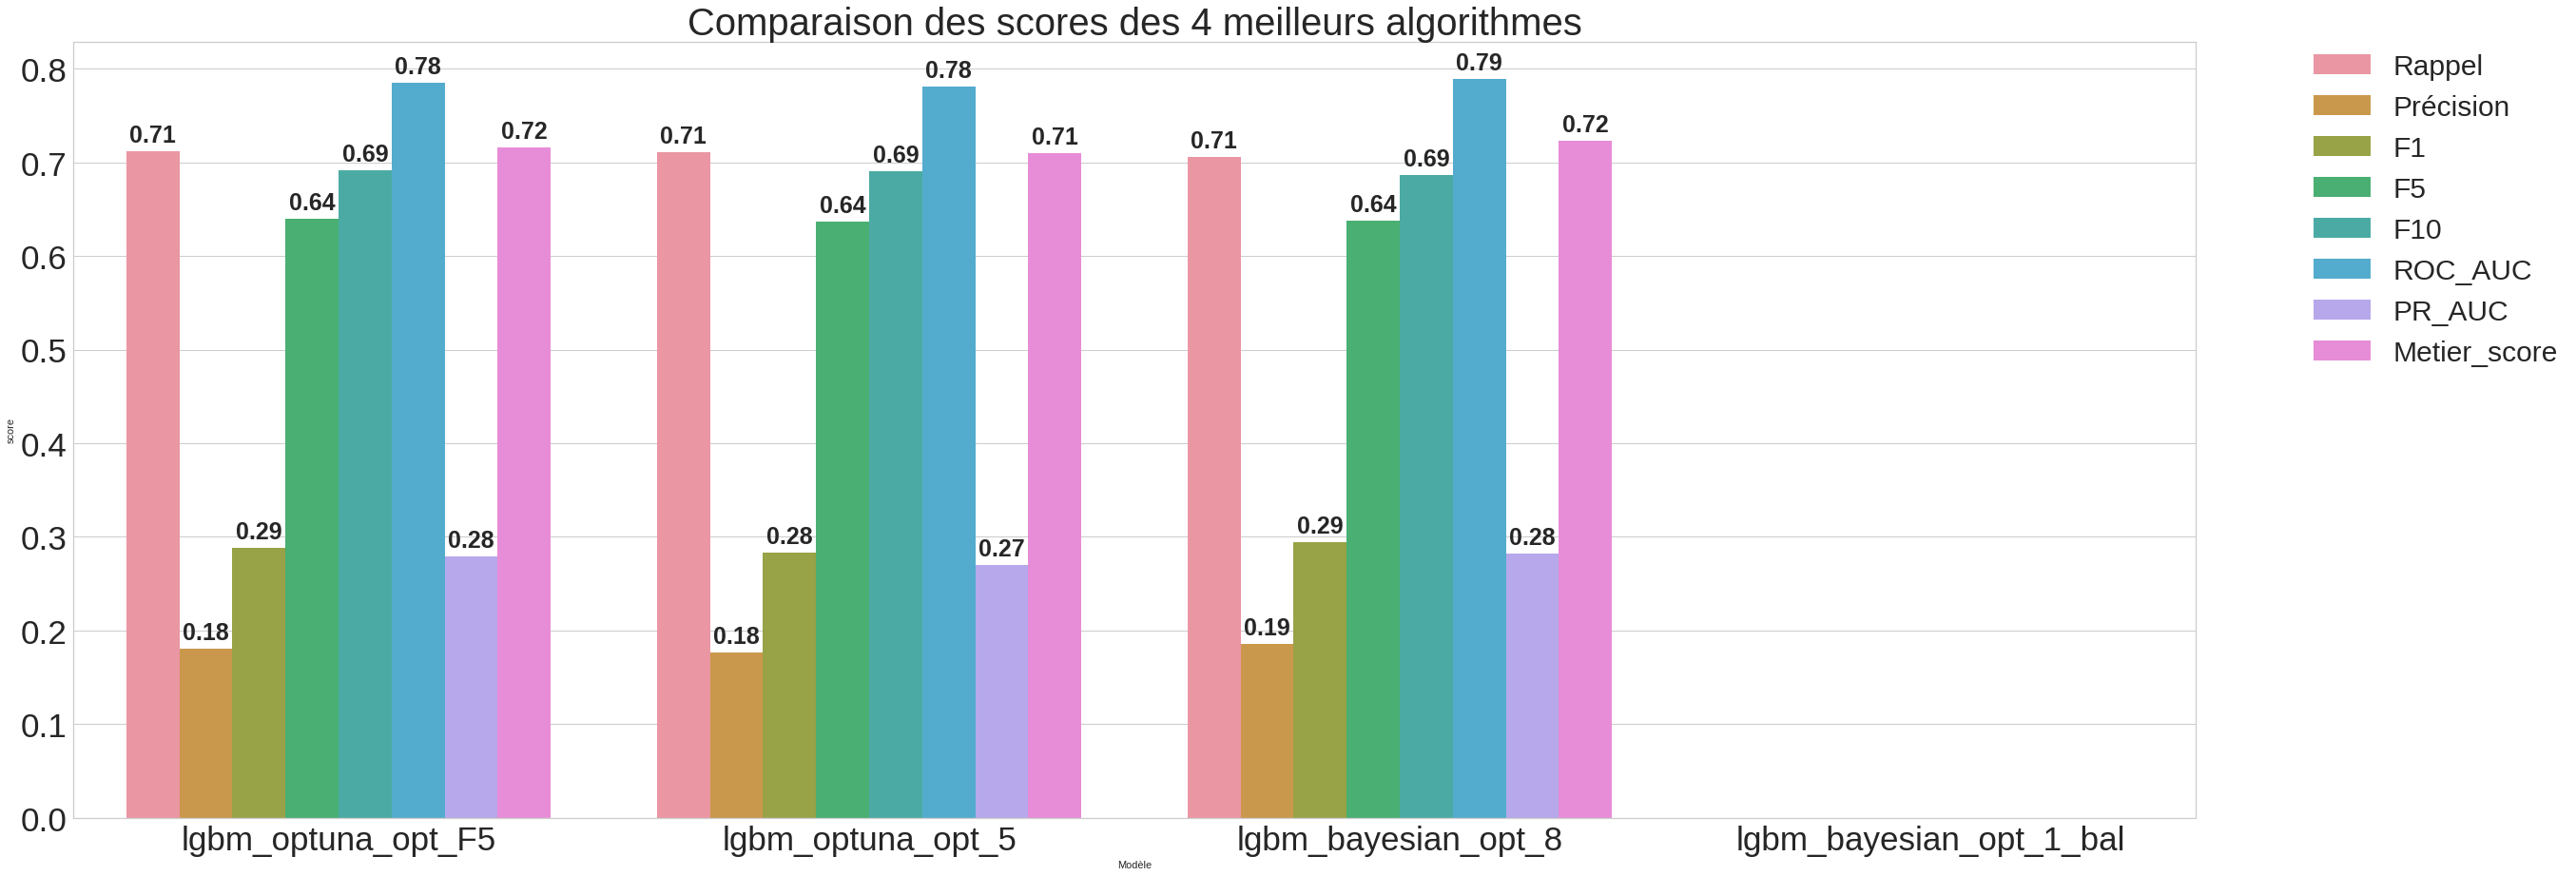

In [290]:
# Comparaison visuelle des 4 algorithmes les plus performants
df_comp_score = df_comp[df_comp['Modèle'].isin(
    ['lgbm_optuna_opt_5', 'lgbm_optuna_opt_F5', 'lgbm_bayesian_opt_1_bal',
     'lgbm_bayesian_opt_8'])]

# Renseignements sur les modèles
df_comp_display = df_comp_score[['Modèle', 'Metrique', 'Optimisation',
                               'Class_weight']].style.hide_index()
display(df_comp_display)

# Scores
comparaison_score_melt = \
    pd.melt(df_comp_score, id_vars=['Modèle'], value_name='score',
            value_vars=['Rappel', 'Précision', 'F1', 'F5', 'F10',
                        'ROC_AUC', 'PR_AUC', 'Metier_score'])
# Visualisation
plt.figure(figsize=(40, 15))
ax= sns.barplot(x=comparaison_score_melt['Modèle'],
                y=comparaison_score_melt['score'],
            hue=comparaison_score_melt['variable'])
plt.title('Comparaison des scores des 4 meilleurs algorithmes',
          fontsize=40)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=30)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+ p.get_width()/2.,
            height + 0.01,
            '{:1.2f}'.format(height),
            ha="center",
            fontsize=25,
            fontweight='bold') 
plt.show()

df_comp_score[['Rappel', 'Précision', 'F1', 'F5', 'F10', 'ROC_AUC',
               'PR_AUC', 'Metier_score']].style.hide_index()

**Bilan** :
***
- Les différentes métriques sont proches pour tous les modèles avec un léger avantage pour le rappel pour le modèle **lgbm_otuna_opt_5** qui s'explique pour le nombre beta=10 qui favorise la détection des classes positives.

### <span style='background:PowderBlue'>6.8. Recherche de seuil de probabilité optimal</span>

In [291]:
df_res_seuil = pd.DataFrame({})

**Seuil de probabilité optimal du modèle lgbm_optuna_opt_5**

In [292]:
# Chargement du meilleur modèle
fic_lgbm_optuna_opt_5 = \
    '/content/drive/My Drive/sauvegarde/modelisation/modele_lgbm_optuna_opt_5.pickle'
with open(fic_lgbm_optuna_opt_5, 'rb') as df_mod2:
    lgbm_optuna_opt_5 = pickle.load(df_mod2)
lgbm_optuna_opt_5

LGBMClassifier(class_weight='balanced', colsample_bytree=0.6165561461232584,
               force_col_wise=True, max_depth=3, min_child_samples=80,
               min_child_weight=0.816706751735683, num_leaves=225,
               objective='binary', reg_alpha=0.04036415503705408,
               reg_lambda=6.380429879874343e-06, subsample=0.18463058154981357,
               subsample_freq=4, verbosity=-1)

**Première métrique métier**

Score métrique métier maximal : 0.7985870720283132
Seuil maximal : 0.75


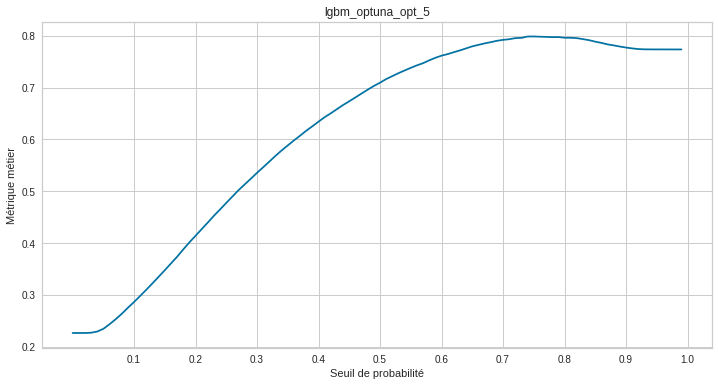

In [293]:
# taux_tn=1, taux_fp=0, taux_fn=-10, taux_tp=0
outils_model.determiner_seuil_probabilite(lgbm_optuna_opt_5,
                                          X_valid, y_valid,
                                          'lgbm_optuna_opt_5')

**Scores du modèle en prenant en compte le seuil**

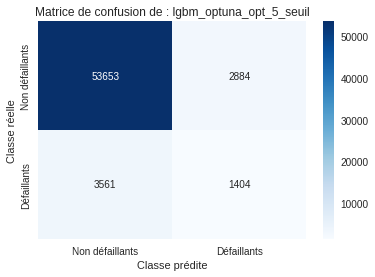

In [294]:
df_res_seuil = \
    outils_model.process_classification_seuil(lgbm_optuna_opt_5, 0.76,
                                             X_train, X_valid, y_train,
                                             y_valid, df_res_seuil,
                                            'lgbm_optuna_opt_5_seuil')

**Bilan** :
- La métrique métier n'est pas efficace puisqu'on détecte plus de vrais négatifs (prédits non-défaillants mais défaillants).

**Deuxième métrique métier**

Score F10 maximal : 0.9016604583622704
Seuil maximal : 0.09


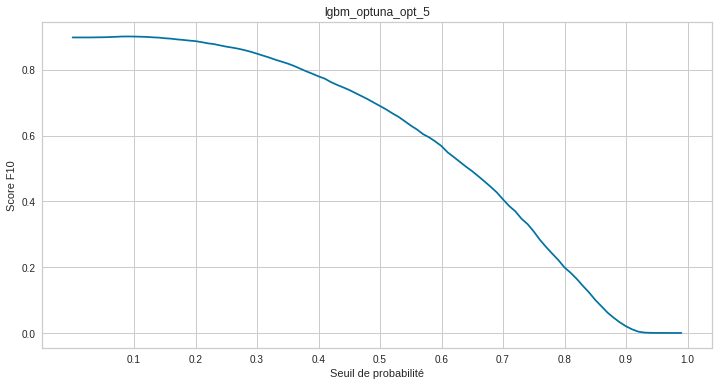

In [295]:
# Score F10 en fonction du seuil
outils_model.determiner_seuil_probabilite_F10(lgbm_optuna_opt_5,
                                              X_valid, y_valid,
                                             'lgbm_optuna_opt_5')

**Scores du modèle en prenant en compte le seuil**

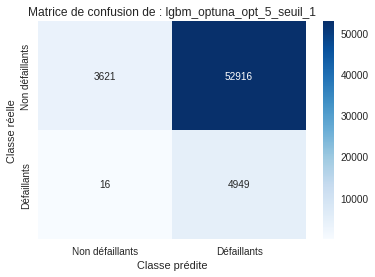

In [296]:
df_res_seuil = \
    outils_model.process_classification_seuil(lgbm_optuna_opt_5, 0.09,
                                              X_train, X_valid, y_train,
                                              y_valid, df_res_seuil,
                                             'lgbm_optuna_opt_5_seuil_1')

- Le taux de FN est très faible mais cela signifie que le prêt n'est plus accordé à personne ! Ce n'est pas le but de la banque qui doit gagner de l'argent avec les intérêts des prêts accordés.
- Le compromis faux négatifs et faux positifs devra être discuté avec nos clients pour régler au mieux le seuil de probabilité avec le nombre de faux négatifs/positifs à atteindre. 
- Sans client disponible et sans consigne dans le projet, le seuil par défaut à 0.5 sera conservé et le modèle final sera **lgbm_optuna_opt_5**.

In [297]:
# Sauvegarde du meilleur modèle dans best_model
fic_best_model = \
    '/content/drive/My Drive/sauvegarde/modelisation/best_model.pickle'
with open(fic_best_model, 'wb') as f:
    pickle.dump(lgbm_optuna_opt_5, f, pickle.HIGHEST_PROTOCOL)

## <span style='background:Thistle'>7. Interprétabilité du modèle</span>

In [298]:
# Chargement du meilleur modèle
fic_best_model = '/content/drive/My Drive/sauvegarde/modelisation/best_model.pickle'
with open(fic_best_model, 'rb') as df_best_model:
    best_model = pickle.load(df_best_model)
best_model

LGBMClassifier(class_weight='balanced', colsample_bytree=0.6165561461232584,
               force_col_wise=True, max_depth=3, min_child_samples=80,
               min_child_weight=0.816706751735683, num_leaves=225,
               objective='binary', reg_alpha=0.04036415503705408,
               reg_lambda=6.380429879874343e-06, subsample=0.18463058154981357,
               subsample_freq=4, verbosity=-1)

### <span style='background:PowderBlue'>7.1. LightGBM - Features importances</span>

**Features importances**

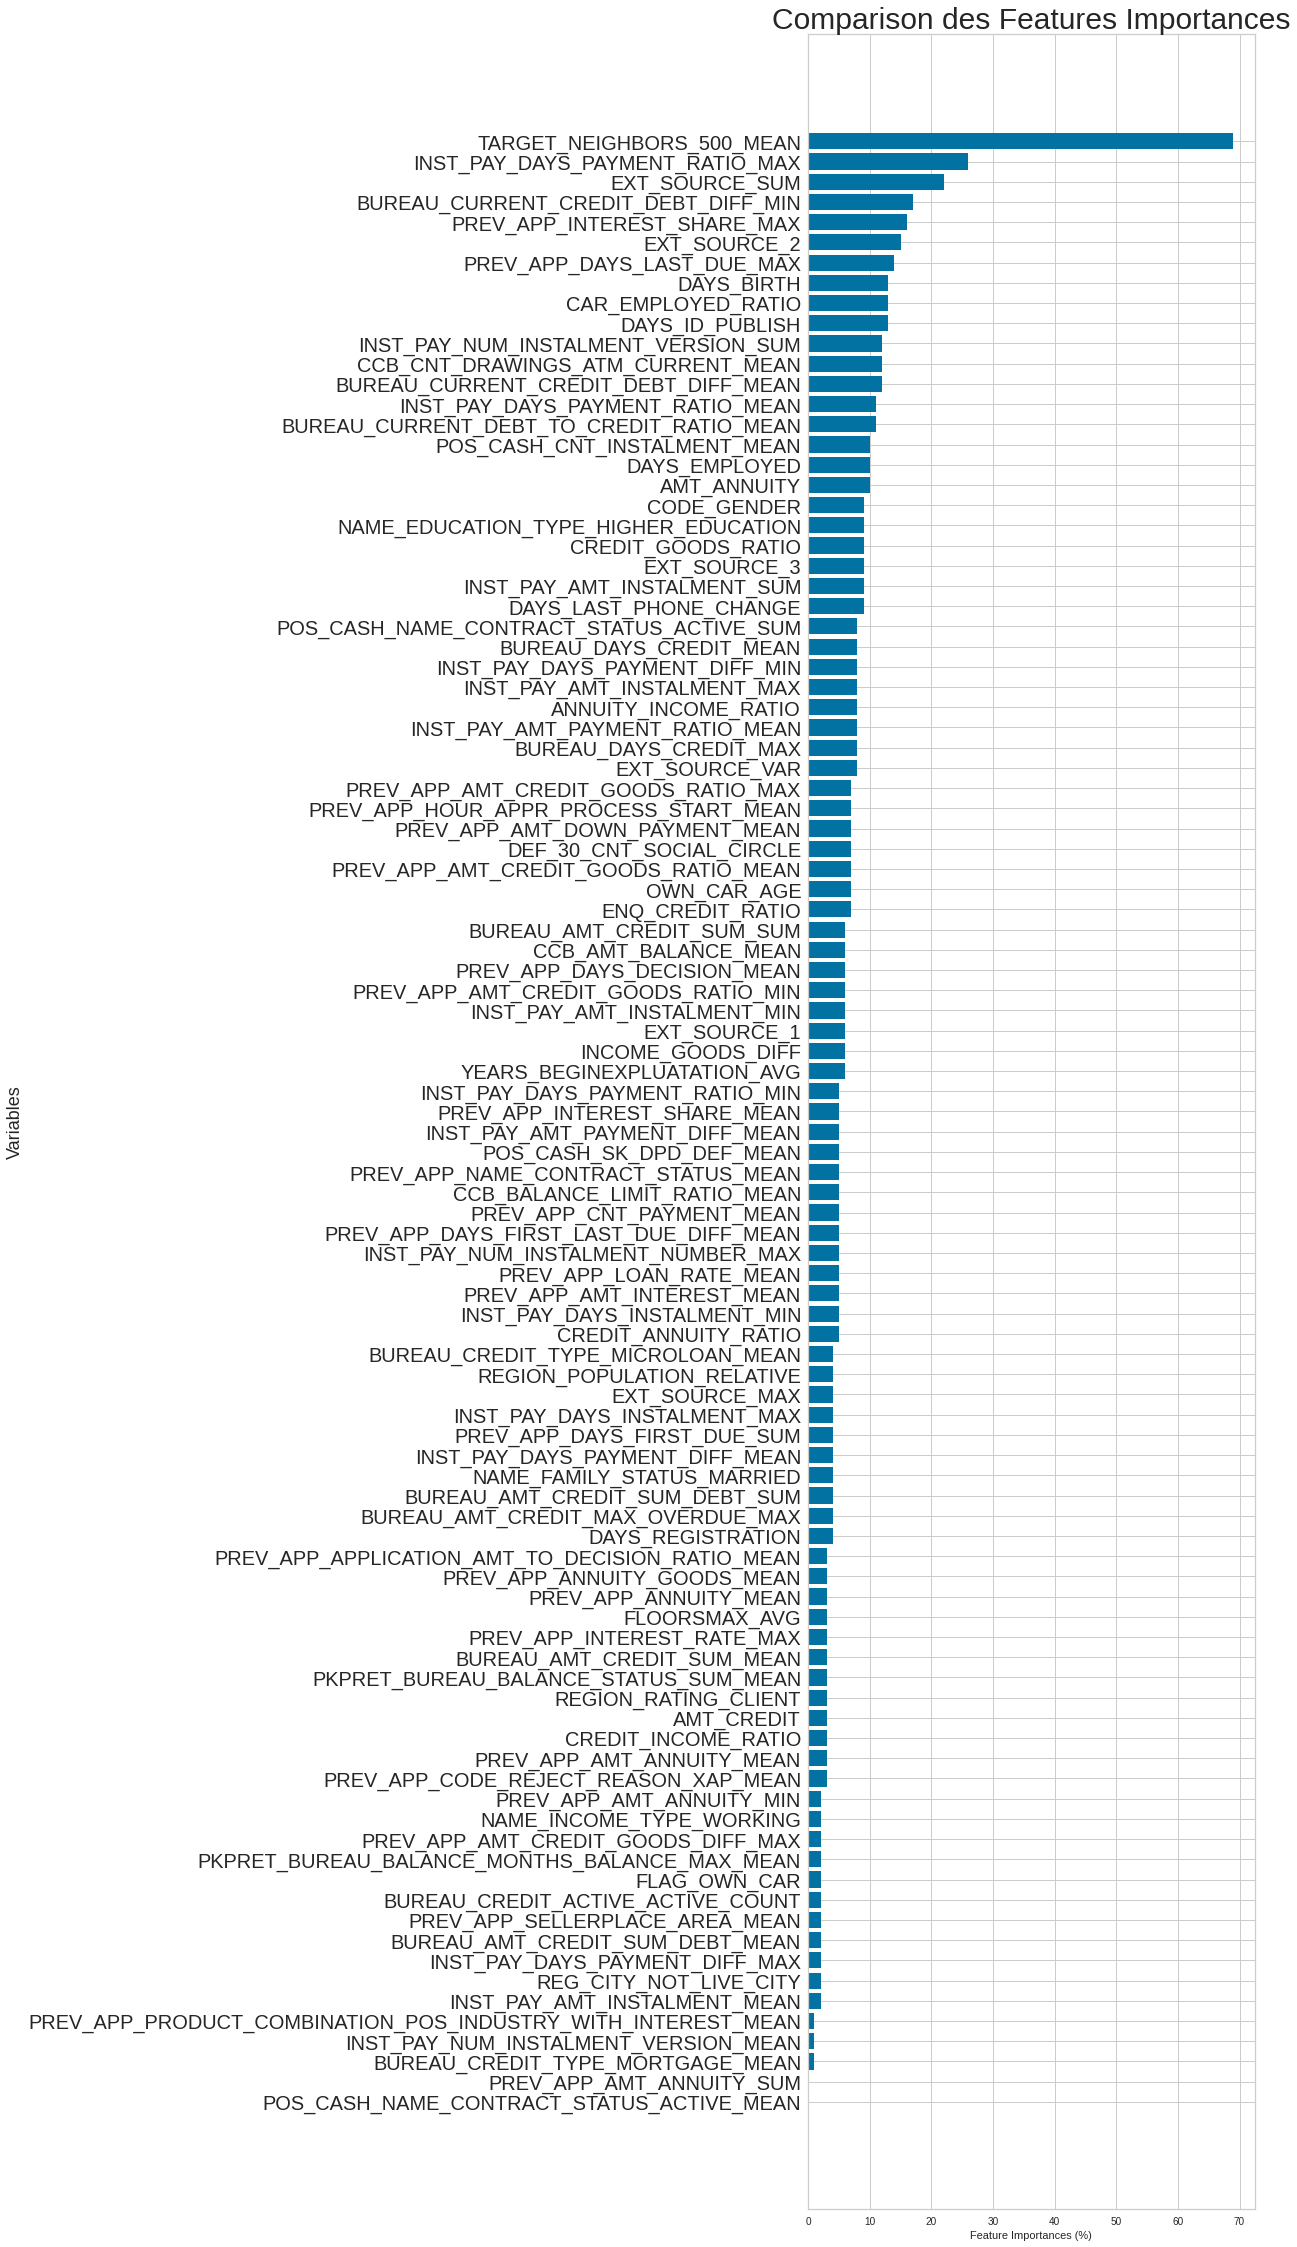

In [299]:
feature_importance_values = best_model.feature_importances_
feature_names = list(X_train.columns)
outils_model.plot_features_importance(feature_importance_values,
                                      feature_names, (8, 40))

**Répartition des features importances**

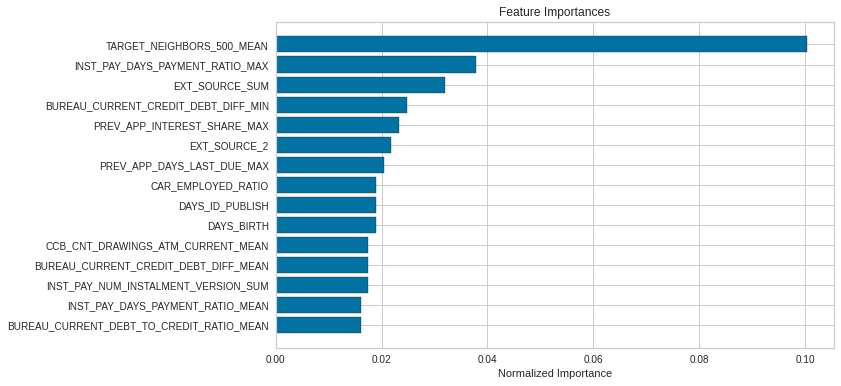

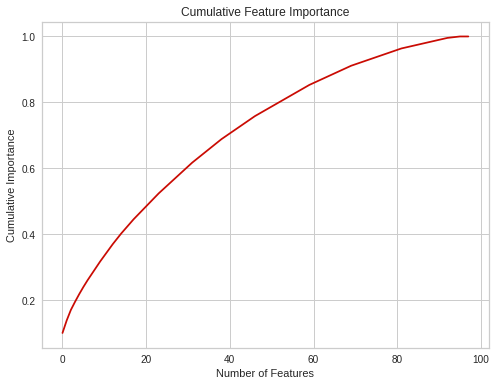

69 variables nécessaires pour 0.90 de cummulative imortance


In [300]:
# Impact des features importance cumulées
feature_importance_values = best_model.feature_importances_
feature_names = list(X_train.columns)
feature_importances = pd.DataFrame({'feature': feature_names,
                                    'importance': feature_importance_values})
# Show the feature importances for the new features
df_featimp = \
    outils_model.plot_cumultative_feature_importance(feature_importances)

In [301]:
df_featimp

index                                                       feature  importance  importance_normalized  cumulative_importance
0       0                                     TARGET_NEIGHBORS_500_MEAN          69                 0.1004                 0.1004
1      22                               INST_PAY_DAYS_PAYMENT_RATIO_MAX          26                 0.0378                 0.1383
2      56                                                EXT_SOURCE_SUM          22                 0.0320                 0.1703
3      52                           BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN          17                 0.0247                 0.1951
4      49                                   PREV_APP_INTEREST_SHARE_MAX          16                 0.0233                 0.2183
5      46                                                  EXT_SOURCE_2          15                 0.0218                 0.2402
6      45                                    PREV_APP_DAYS_LAST_DUE_MAX          14                 0.0204                 0.2606
7      40                                            CAR_EMPLOYED_RATIO          13                 0.0189                 0.2795
8      41                                               DAYS_ID_PUBLISH          13                 0.0189                 0.2984
9      64                                                    DAYS_BIRTH          13                 0.0189                 0.3173
10     19                             CCB_CNT_DRAWINGS_ATM_CURRENT_MEAN          12                 0.0175                 0.3348
11     48                          BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN          12                 0.0175                 0.3523
12      9                           INST_PAY_NUM_INSTALMENT_VERSION_SUM          12                 0.0175                 0.3697
13     44                              INST_PAY_DAYS_PAYMENT_RATIO_MEAN          11                 0.0160                 0.3857
14     60                      BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN          11                 0.0160                 0.4017
15     63                                                   AMT_ANNUITY          10                 0.0146                 0.4163
16     50                                  POS_CASH_CNT_INSTALMENT_MEAN          10                 0.0146                 0.4309
17     57                                                 DAYS_EMPLOYED          10                 0.0146                 0.4454
18     37                                                   CODE_GENDER           9                 0.0131                 0.4585
19     38                                   INST_PAY_AMT_INSTALMENT_SUM           9                 0.0131                 0.4716
20     66                                        DAYS_LAST_PHONE_CHANGE           9                 0.0131                 0.4847
21     58                                                  EXT_SOURCE_3           9                 0.0131                 0.4978
22     47                                            CREDIT_GOODS_RATIO           9                 0.0131                 0.5109
23     33                          NAME_EDUCATION_TYPE_HIGHER_EDUCATION           9                 0.0131                 0.5240
24     43                                          ANNUITY_INCOME_RATIO           8                 0.0116                 0.5357
25      3                                INST_PAY_DAYS_PAYMENT_DIFF_MIN           8                 0.0116                 0.5473
26     55                                        BUREAU_DAYS_CREDIT_MAX           8                 0.0116                 0.5590
27     36                      POS_CASH_NAME_CONTRACT_STATUS_ACTIVE_SUM           8                 0.0116                 0.5706
28     87                                                EXT_SOURCE_VAR           8                 0.0116                 0.5822
29     51                                   INST_PAY_AMT_INSTALMENT_MAX           8                 0.01

- 65 variables sont nécessaires pour représenter 90% des features importances et 36 variables pour 70%.

**Arbre de décision de LightGBM**

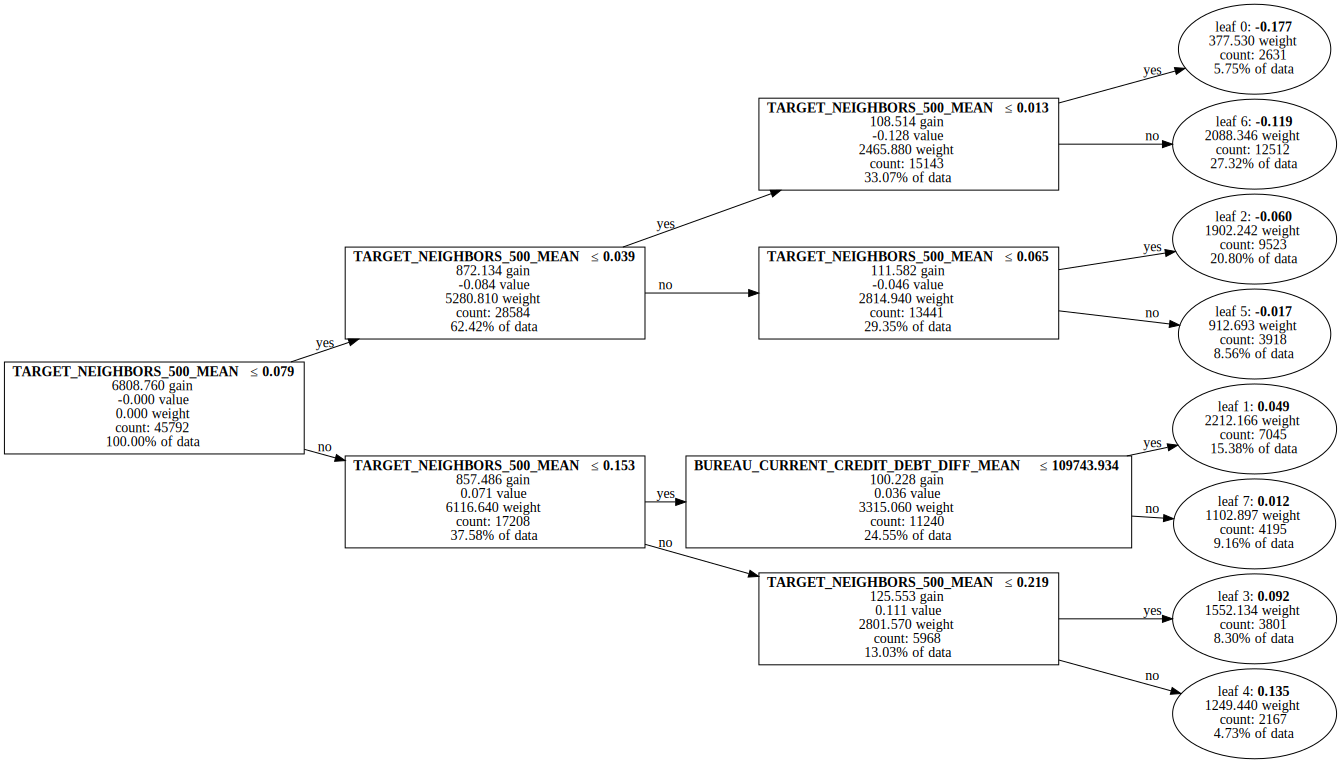

In [302]:
lgb.create_tree_digraph(best_model, tree_index=0,
                        show_info=['split_gain', 'internal_value',
                                   'internal_count', 'internal_weight',
                                   'leaf_count', 'leaf_weight', 'data_percentage'])

### <span style='background:PowderBlue'>7.2. SHAP</span>

- La méthode SHAP (SHapley Additive exPlanations) consiste à calculer la valeur de Shapley pour toutes les variables de tous les individus c’est-à-dire la moyenne de l’impact d’une variable (sur la sortie, donc la prédiction) pour toutes les combinaisons de variables possibles.
- La somme des effets de chaque variable expliquera la prédiction.

[Source](https://towardsdatascience.com/shap-explained-the-way-i-wish-someone-explained-it-to-me-ab81cc69ef30) [Source](https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d) [Source](https://medium.com/@gabrieltseng/interpreting-complex-models-with-shap-values-1c187db6ec83) [Source](https://medium.com/swlh/push-the-limits-of-explainability-an-ultimate-guide-to-shap-library-a110af566a02) [Source](https://www.kaggle.com/dansbecker/shap-values)

**Interprétabilité globale**

**Summary plot**

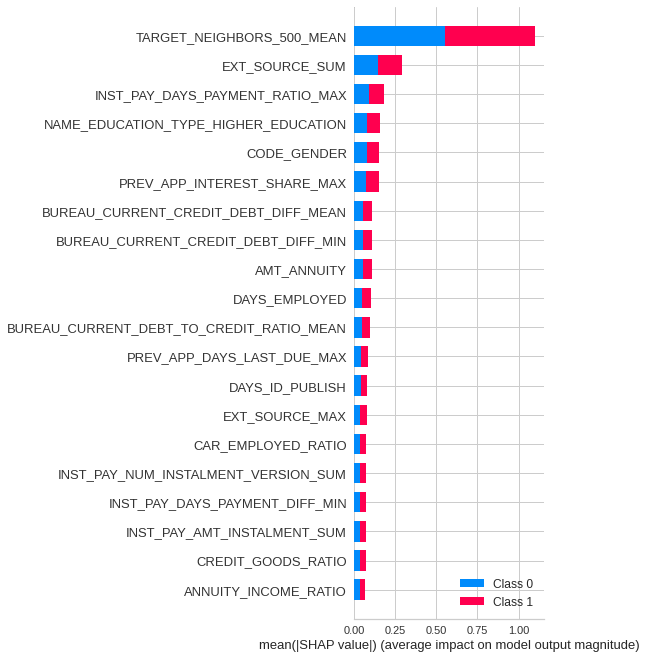

In [303]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_valid)
# Summary plot
shap.summary_plot(shap_values, X_valid)

**Summary plot** : 

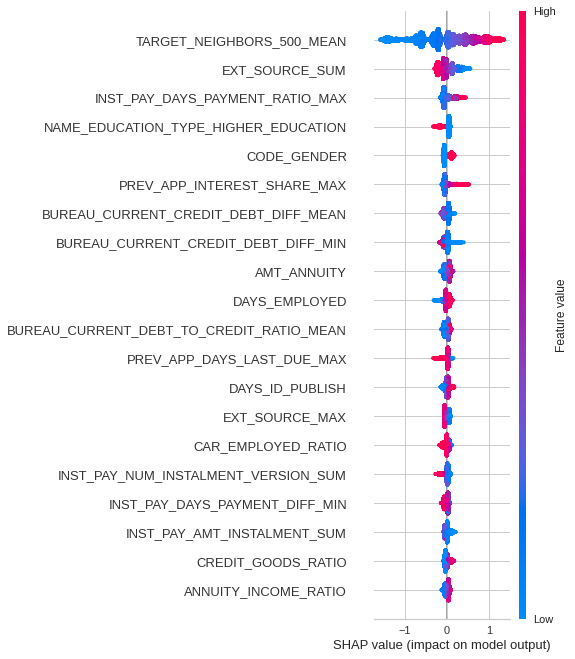

In [304]:
shap.summary_plot(shap_values[1], X_valid, show=False)

In [305]:
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_train, check_additivity=False)

100%|===================| 245513/246005 [04:31<00:00]       

**Bar plot** : l'importance globale des caractéristiques, où l'importance globale de chaque caractéristique est considérée comme la valeur absolue moyenne pour cette caractéristique sur tous les échantillons donnés.

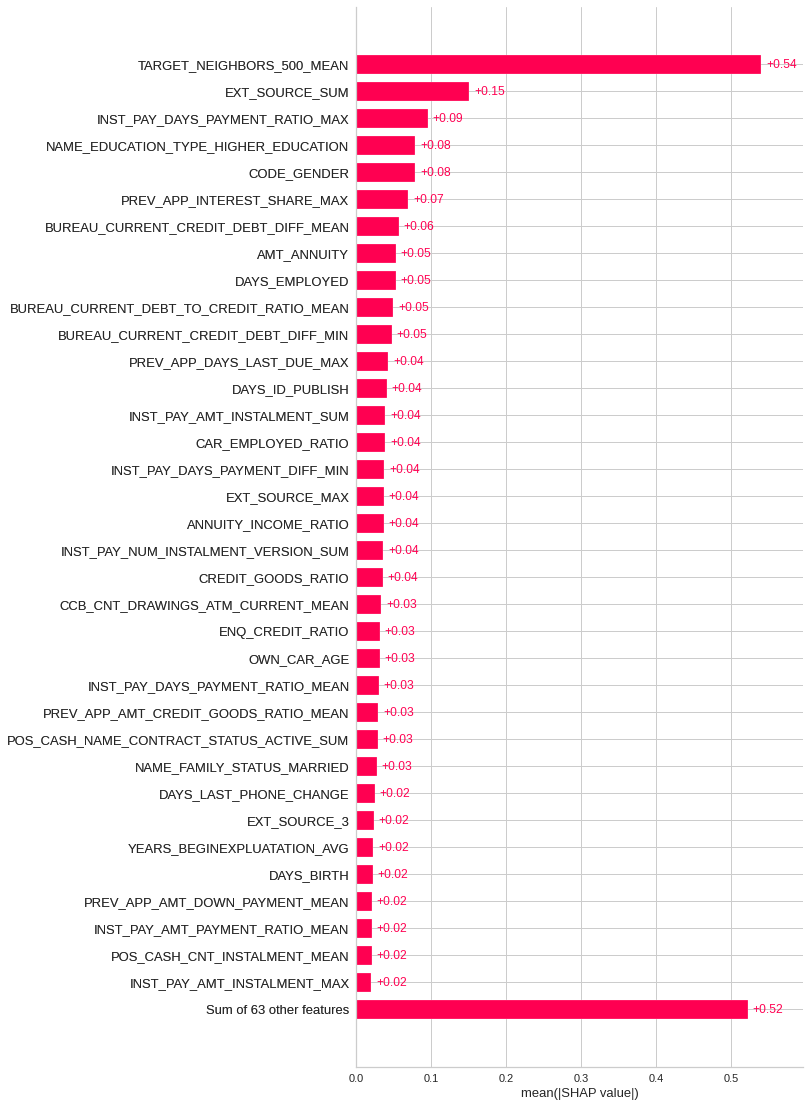

In [306]:
shap.plots.bar(shap_values, max_display=36)

**Beeswarm** : 
- ce graphique est conçu pour afficher un résumé dense en informations de la manière dont les principales caractéristiques d'un ensemble de données influencent la sortie du modèle. 
- Chaque instance de l'explication donnée est représentée par un seul point sur chaque graphique de caractéristiques. La position x du point est déterminée par la valeur SHAP (shap_values.value[instance,feature]) de cette caractéristique, et les points s'empilent le long de chaque ligne de caractéristique pour montrer la densité. 
- La couleur est utilisée pour afficher la valeur originale d'une caractéristique (shap_values.data[instance,feature]). 

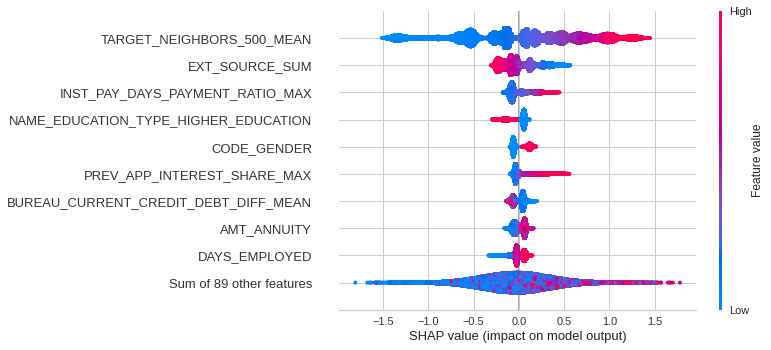

In [307]:
shap.plots.beeswarm(shap_values)

- Dans le graphique ci-dessous, nous pouvons voir que la variable EXT_SOURCE_SUM est la caractéristique la plus importante en moyenne, et que les hautes valuers (en rouge) ont tendance avoir un impact négatif donc classe 1 défaillant alors que les basses valeurs ont tendance à avoir un impact postif donc classe 0 non-défaillant...

***
Le meilleur modèle est sélectionné et extrait. La suite concernera la préparation des données nécessaires au dashboard et sera traitée dans le notebook P7_01_06_DASHBOARD.ipynb.
***